In [2]:
# ====== Core Python Libraries ======
import json
import joblib
import os
import warnings
from copy import deepcopy
from pathlib import Path
from typing import Dict, Iterable, List, Optional, Tuple, Union

# ====== Data & Visualization ======
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# ====== Statistics & Numeric Utilities ======
from scipy.stats import chi2_contingency, pointbiserialr, ttest_ind

# ====== Scikit-Learn: Models, Metrics, Preprocessing & Utilities ======
from sklearn.calibration import CalibratedClassifierCV
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    auc,
    average_precision_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid, RadiusNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    LabelEncoder,
    MinMaxScaler,
    OneHotEncoder,
    PolynomialFeatures,
    StandardScaler,
)
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import check_random_state, compute_class_weight

# ====== Gradient Boosting ======
from xgboost import XGBClassifier

# ====== Imbalanced-Learn (optional) ======
try:
    from imblearn.combine import SMOTETomek
    from imblearn.ensemble import EasyEnsembleClassifier
    from imblearn.over_sampling import ADASYN, RandomOverSampler, SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
    from imblearn.under_sampling import EditedNearestNeighbours, RandomUnderSampler, TomekLinks
    IMB_AVAILABLE = True
except Exception:
    IMB_AVAILABLE = False

# ====== TensorFlow / Keras (optional) ======
try:
    import tensorflow as tf
    from tensorflow.keras import backend as K, layers, losses, models
    from tensorflow.keras.layers import Dense, Dropout
    from tensorflow.keras.optimizers import Adam
    TF_AVAILABLE = True
except Exception:
    TF_AVAILABLE = False

# ====== Warnings ======
warnings.filterwarnings("ignore")


In [3]:
OG = pd.read_csv("train_ZoGVYWq.csv")

In [4]:
OG.describe(include='all')

id  perc_premium_paid_by_cash_credit   age_in_days  \
count    79853.000000                      79853.000000  79853.000000   
unique            NaN                               NaN           NaN   
top               NaN                               NaN           NaN   
freq              NaN                               NaN           NaN   
mean     57167.166368                          0.314288  18846.696906   
std      32928.970160                          0.334915   5208.719136   
min          2.000000                          0.000000   7670.000000   
25%      28640.000000                          0.034000  14974.000000   
50%      57262.000000                          0.167000  18625.000000   
75%      85632.000000                          0.538000  22636.000000   
max     114076.000000                          1.000000  37602.000000   

              Income  Count_3-6_months_late  Count_6-12_months_late  \
count   7.985300e+04           79756.000000            79756.000000   
unique           NaN                    NaN                     NaN   
top              NaN                    NaN                     NaN   
freq             NaN                    NaN                     NaN   
mean    2.088472e+05               0.248671                0.078188   
std     4.965826e+05               0.691468                0.436507   
min     2.403000e+04               0.000000                0.000000   
25%     1.080100e+05               0.000000                0.000000   
50%     1.665600e+05               0.000000                0.000000   
75%     2.520900e+05               0.000000                0.000000   
max     9.026260e+07              13.000000               17.000000   

        Count_more_than_12_months_late  application_underwriting_score  \
count                     79756.000000                    76879.000000   
unique                             NaN                             NaN   
top                                NaN                             NaN   
freq                               NaN                             NaN   
mean                          0.060008                       99.067291   
std                           0.312023                        0.739799   
min                           0.000000                       91.900000   
25%                           0.000000                       98.810000   
50%                           0.000000                       99.210000   
75%                           0.000000                       99.540000   
max                          11.000000                       99.890000   

        no_of_premiums_paid sourcing_channel residence_area_type  \
count          79853.000000            79853               79853   
unique                  NaN                5                   2   
top                     NaN                A               Urban   
freq                    NaN            43134               48183   
mean              10.863887              NaN                 NaN   
std                5.170687              NaN                 NaN   
min                2.000000              NaN                 NaN   
25%                7.000000              NaN                 NaN   
50%               10.000000              NaN                 NaN   
75%               14.000000              NaN                 NaN   
max               60.000000              NaN                 NaN   

             premium       renewal  
count   79853.000000  79853.000000  
unique           NaN           NaN  
top              NaN           NaN  
freq             NaN           NaN  
mean    10924.507533      0.937410  
std      9401.676542      0.242226  
min      1200.000000      0.000000  
25%      5400.000000      1.000000  
50%      7500.000000      1.000000  
75%     13800.000000      1.000000  
max     60000.000000      1.000000

In [5]:
OG.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79853 entries, 0 to 79852
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                79853 non-null  int64  
 1   perc_premium_paid_by_cash_credit  79853 non-null  float64
 2   age_in_days                       79853 non-null  int64  
 3   Income                            79853 non-null  int64  
 4   Count_3-6_months_late             79756 non-null  float64
 5   Count_6-12_months_late            79756 non-null  float64
 6   Count_more_than_12_months_late    79756 non-null  float64
 7   application_underwriting_score    76879 non-null  float64
 8   no_of_premiums_paid               79853 non-null  int64  
 9   sourcing_channel                  79853 non-null  object 
 10  residence_area_type               79853 non-null  object 
 11  premium                           79853 non-null  int64  
 12  rene

In [10]:
OG.groupby(by="renewal").size()

renewal
0     4998
1    74855
dtype: int64

In [12]:
latepayment_cols = [
    "Count_3-6_months_late",
    "Count_6-12_months_late",
    "Count_more_than_12_months_late"
]


In [14]:
ignore_cols = ["id", "renewal"] + latepayment_cols

OG[OG.duplicated(subset=OG.columns.difference(ignore_cols))]

Empty DataFrame
Columns: [id, perc_premium_paid_by_cash_credit, age_in_days, Income, Count_3-6_months_late, Count_6-12_months_late, Count_more_than_12_months_late, application_underwriting_score, no_of_premiums_paid, sourcing_channel, residence_area_type, premium, renewal]
Index: []

In [16]:
OG.shape

(79853, 13)

In [18]:
TARGET = "renewal"

In [20]:
SEED = 42 

### Data cleaning / preprocessing

#### Remove ID feature

In [26]:
# Create a copy of OG for processing
OG_proc = OG.copy()
# Drop the ID column from OG_proc
OG_proc = OG_proc.drop(columns=['id'])

In [28]:
OG_proc.describe()

perc_premium_paid_by_cash_credit   age_in_days        Income  \
count                      79853.000000  79853.000000  7.985300e+04   
mean                           0.314288  18846.696906  2.088472e+05   
std                            0.334915   5208.719136  4.965826e+05   
min                            0.000000   7670.000000  2.403000e+04   
25%                            0.034000  14974.000000  1.080100e+05   
50%                            0.167000  18625.000000  1.665600e+05   
75%                            0.538000  22636.000000  2.520900e+05   
max                            1.000000  37602.000000  9.026260e+07   

       Count_3-6_months_late  Count_6-12_months_late  \
count           79756.000000            79756.000000   
mean                0.248671                0.078188   
std                 0.691468                0.436507   
min                 0.000000                0.000000   
25%                 0.000000                0.000000   
50%                 0.000000                0.000000   
75%                 0.000000                0.000000   
max                13.000000               17.000000   

       Count_more_than_12_months_late  application_underwriting_score  \
count                    79756.000000                    76879.000000   
mean                         0.060008                       99.067291   
std                          0.312023                        0.739799   
min                          0.000000                       91.900000   
25%                          0.000000                       98.810000   
50%                          0.000000                       99.210000   
75%                          0.000000                       99.540000   
max                         11.000000                       99.890000   

       no_of_premiums_paid       premium       renewal  
count         79853.000000  79853.000000  79853.000000  
mean             10.863887  10924.507533      0.937410  
std               5.170687   9401.676542      0.242226  
min               2.000000   1200.000000      0.000000  
25%               7.000000   5400.000000      1.000000  
50%              10.000000   7500.000000      1.000000  
75%              14.000000  13800.000000      1.000000  
max              60.000000  60000.000000      1.000000

#### Check Duplicate records

In [31]:
##All rows in OG_proc where feature values are identical, but the target label (renewal) might differ.
OG_proc[OG_proc.duplicated(subset=OG_proc.columns.difference([ TARGET]))]

Empty DataFrame
Columns: [perc_premium_paid_by_cash_credit, age_in_days, Income, Count_3-6_months_late, Count_6-12_months_late, Count_more_than_12_months_late, application_underwriting_score, no_of_premiums_paid, sourcing_channel, residence_area_type, premium, renewal]
Index: []

In [33]:
OG_proc[OG_proc.duplicated(subset=OG_proc.columns, keep=False)]

Empty DataFrame
Columns: [perc_premium_paid_by_cash_credit, age_in_days, Income, Count_3-6_months_late, Count_6-12_months_late, Count_more_than_12_months_late, application_underwriting_score, no_of_premiums_paid, sourcing_channel, residence_area_type, premium, renewal]
Index: []

In [35]:
OG_proc.isna().sum()

perc_premium_paid_by_cash_credit       0
age_in_days                            0
Income                                 0
Count_3-6_months_late                 97
Count_6-12_months_late                97
Count_more_than_12_months_late        97
application_underwriting_score      2974
no_of_premiums_paid                    0
sourcing_channel                       0
residence_area_type                    0
premium                                0
renewal                                0
dtype: int64

In [37]:
missing_cols = OG_proc.columns[OG_proc.isnull().any()].tolist()
missing_cols

['Count_3-6_months_late',
 'Count_6-12_months_late',
 'Count_more_than_12_months_late',
 'application_underwriting_score']

In [39]:
all_missing_records = OG_proc[OG_proc[missing_cols].isnull().all(axis=1)]
print("Rows where ALL missing columns are NaN:", len(all_missing_records))

Rows where ALL missing columns are NaN: 73


In [41]:
all_missing_latepayment_records = OG_proc[OG_proc[latepayment_cols].isnull().all(axis=1)]
print("Rows where ALL Late payments missing columns are NaN:", len(all_missing_latepayment_records ))

Rows where ALL Late payments missing columns are NaN: 97


#### Imputing Late Pyment features with "ZERO"

In [44]:
mask_all_missing = OG_proc[latepayment_cols].isnull().all(axis=1)
OG_proc.loc[mask_all_missing, latepayment_cols] = 0


In [46]:
all_missing_latepayment_records = OG_proc[OG_proc[latepayment_cols].isnull().all(axis=1)]
print("Rows where ALL Late payments missing columns are NaN:", len(all_missing_latepayment_records ))

Rows where ALL Late payments missing columns are NaN: 0


In [48]:
before = OG_proc['application_underwriting_score'].copy()

#### Imputing application_underwriting_score with knn imputation

In [51]:

def knn_impute_target(df, target_col, n_neighbors=5):
    """
    Impute missing values for a single target column using KNNImputer.
    Uses all other features (numeric + categorical) for distance calculation.
    """
    df_out = df.copy()

    # All columns except target
    feature_cols = [c for c in df_out.columns if c != target_col]

    # Separate numeric and categorical
    num_cols = df_out[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = df_out[feature_cols].select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

    # Preprocessor (scikit-learn >= 1.2 uses sparse_output instead of sparse)
    preproc = ColumnTransformer(
        transformers=[
            ('num', MinMaxScaler(), num_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols),
        ],
        remainder='drop'
    )

    # Encode predictors
    X_enc = preproc.fit_transform(df_out[feature_cols])

    # Append target
    y = df_out[[target_col]].to_numpy()
    Xy = np.hstack([X_enc, y])

    # KNN Imputer
    imputer = KNNImputer(n_neighbors=n_neighbors)
    Xy_imputed = imputer.fit_transform(Xy)

    # Update only target col
    df_out[target_col] = Xy_imputed[:, -1]

    return df_out

In [53]:
OG_proc = knn_impute_target(OG_proc, 'application_underwriting_score', n_neighbors=5)


In [54]:
OG_proc.isna().sum()

perc_premium_paid_by_cash_credit    0
age_in_days                         0
Income                              0
Count_3-6_months_late               0
Count_6-12_months_late              0
Count_more_than_12_months_late      0
application_underwriting_score      0
no_of_premiums_paid                 0
sourcing_channel                    0
residence_area_type                 0
premium                             0
renewal                             0
dtype: int64

In [55]:
imputed_mask = before.isna()

In [56]:
imputed_values = OG_proc[imputed_mask]

In [57]:

# After imputation
after = OG_proc['application_underwriting_score']

# Identify rows that were NaN before (i.e., imputed)
imputed_mask = before.isna()

# Print only the imputed values (index + value)
imputed_only = after[imputed_mask]

print("Number of values imputed:", imputed_mask.sum())
print(imputed_only.head(20))  # show first 20 imputed values

Number of values imputed: 2974
18     99.584
26     98.854
39     99.496
60     99.662
61     98.770
76     99.332
77     99.632
84     98.170
140    99.568
145    98.422
158    99.858
170    99.660
197    99.618
225    99.674
296    99.300
304    99.602
358    99.474
382    99.794
394    98.882
400    99.688
Name: application_underwriting_score, dtype: float64


In [58]:
OG_proc_clean = OG_proc.copy()

# Mask: total late payments <= premiums paid (computed on the fly, not stored)
mask = (
    OG_proc_clean['Count_3-6_months_late'] +
    OG_proc_clean['Count_6-12_months_late'] +
    OG_proc_clean['Count_more_than_12_months_late']
) <= OG_proc_clean['no_of_premiums_paid']

# Apply filter
OG_proc_clean = OG_proc_clean[mask]

print("Original dataset shape:", OG_proc.shape)
print("After removing logical issues:", OG_proc_clean.shape)


Original dataset shape: (79853, 12)
After removing logical issues: (79611, 12)


In [59]:
# OG_proc_clean = OG_proc_clean[
#     OG_proc_clean['no_of_premiums_paid'] <= (OG_proc_clean['age_in_days'] / 365)
# ]

In [67]:
# print("After removing rows where premiums > age in years:", OG_proc_clean.shape)

In [69]:
late_cols = [
    'Count_3-6_months_late',
    'Count_6-12_months_late',
    'Count_more_than_12_months_late'
]


In [71]:

# Boolean mask: True if ANY lateness >= 5
lateness_flag = (OG_proc_clean[late_cols] >= 6).any(axis=1)

# Drop rows where (lateness_flag == True) AND (renewal == 1)
OG_proc_clean = OG_proc_clean[~(lateness_flag & (OG_proc_clean['renewal'] == 1))]

print("After removing noisy late>=5 renewals:", OG_proc_clean.shape)


After removing noisy late>=5 renewals: (79535, 12)


In [73]:
OG_proc_clean.describe()

perc_premium_paid_by_cash_credit   age_in_days        Income  \
count                      79535.000000  79535.000000  7.953500e+04   
mean                           0.312296  18856.696348  2.090386e+05   
std                            0.333482   5209.430984  4.974980e+05   
min                            0.000000   7670.000000  2.403000e+04   
25%                            0.034000  14975.000000  1.080400e+05   
50%                            0.166000  18626.000000  1.667500e+05   
75%                            0.533000  22636.000000  2.521200e+05   
max                            1.000000  37602.000000  9.026260e+07   

       Count_3-6_months_late  Count_6-12_months_late  \
count           79535.000000            79535.000000   
mean                0.239618                0.065833   
std                 0.659603                0.350796   
min                 0.000000                0.000000   
25%                 0.000000                0.000000   
50%                 0.000000                0.000000   
75%                 0.000000                0.000000   
max                13.000000               14.000000   

       Count_more_than_12_months_late  application_underwriting_score  \
count                    79535.000000                    79535.000000   
mean                         0.056302                       99.080544   
std                          0.295393                        0.731899   
min                          0.000000                       91.900000   
25%                          0.000000                       98.830000   
50%                          0.000000                       99.220000   
75%                          0.000000                       99.550000   
max                         11.000000                       99.890000   

       no_of_premiums_paid       premium       renewal  
count         79535.000000  79535.000000  79535.000000  
mean             10.879386  10931.919281      0.939008  
std               5.160280   9407.461514      0.239317  
min               2.000000   1200.000000      0.000000  
25%               7.000000   5400.000000      1.000000  
50%              10.000000   7500.000000      1.000000  
75%              14.000000  13800.000000      1.000000  
max              60.000000  60000.000000      1.000000

In [75]:
max_late_when_renewed = OG_proc_clean.loc[OG_proc_clean['renewal'] == 1, late_cols].max()

In [77]:
print("🔍 Maximum lateness values when renewed (should all be <= 5 now):")
print(max_late_when_renewed)

🔍 Maximum lateness values when renewed (should all be <= 5 now):
Count_3-6_months_late             5.0
Count_6-12_months_late            5.0
Count_more_than_12_months_late    5.0
dtype: float64


# Cleaning Summary: Outlier Audit and Decisions

## Outlier Audit Results

| Feature                         | IQR Outliers? | Renewal Impact | Decision |
|---------------------------------|---------------|----------------|----------|
| Late payment counts             | Yes (all >0)  | Strong negative correlation with renewal (predictive) | Retain as is |
| Application underwriting score  | Yes (low tail)| Outliers show lower renewal rates (predictive risk) | Retain as is |
| Age (94–103 years)              | Yes           | Outliers show slightly higher renewal rates | Retain as is |
| Income (up to ~470,000)         | Yes           | Outliers show slightly higher renewal rates | Retain as is |
| Premium (28,500–60,000, structured brackets) | Yes | Outliers show slightly higher renewal rates | Retain as is |
| Number of premiums paid (25–60) | Yes           | Renewal behavior consistent with non-outliers | Retain as is |

---

## Cleaning Decisions

- **Late payment counts**: Retain all positive values.  
- **Application underwriting score**: Retain outliers (low scores signal higher risk).  
- **Age**: Retain elderly outliers (94–103 years), realistic customers.  
- **Income**: Retain high-income segment, business-relevant.  
- **Premium**: Retain high-value premium brackets, structured product offerings.  
- **Number of premiums paid**: Retain long-tenure customers, valuable information.  

---

## Current Cleaning Status

- Outlier treatment completed: all retained as valid segments.  
- Logical consistency filters applied:  
  - Late payments ≤ premiums paid  
  - Premiums paid ≤ age (in years)  
  - Removed extreme noisy renewals (lateness ≥ 6 with renewal = 1)  
- Missing values imputed:  
  - Late payment columns → 0  
  - Application underwriting score → KNN imputation  
- Next: quick duplicate check and categorical validation.  

---


### Feature Engineering

In [81]:
# Make copies to keep both datasets in sync
OG_proc_fe = OG_proc.copy()
OG_proc_clean_fe = OG_proc_clean.copy()

for df in [OG_proc_fe, OG_proc_clean_fe]:
    df["age_in_years"] = (df["age_in_days"] / 365).astype(int)
    df.drop(columns=["age_in_days"], inplace=True, errors="ignore")  # <--- remove days



In [83]:
# Sort by number of premiums paid and look at top 10 customers
top_premiums = OG_proc_clean_fe.sort_values("no_of_premiums_paid", ascending=False)[
    ["no_of_premiums_paid", "age_in_years"]
].head(10)

print(top_premiums)


       no_of_premiums_paid  age_in_years
26644                   60            53
67876                   59            42
41724                   58            48
60223                   58            70
24675                   56            60
2825                    56            62
47995                   56            61
42819                   55            67
6983                    54            77
4453                    54            71


In [85]:
OG_proc_clean_fe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79535 entries, 0 to 79852
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   perc_premium_paid_by_cash_credit  79535 non-null  float64
 1   Income                            79535 non-null  int64  
 2   Count_3-6_months_late             79535 non-null  float64
 3   Count_6-12_months_late            79535 non-null  float64
 4   Count_more_than_12_months_late    79535 non-null  float64
 5   application_underwriting_score    79535 non-null  float64
 6   no_of_premiums_paid               79535 non-null  int64  
 7   sourcing_channel                  79535 non-null  object 
 8   residence_area_type               79535 non-null  object 
 9   premium                           79535 non-null  int64  
 10  renewal                           79535 non-null  int64  
 11  age_in_years                      79535 non-null  int64  
dtypes: float6

In [87]:
def feature_engineering(df):
    df_fe = df.copy()

    # 1. Total late payments
    df_fe['total_late_payments'] = (
        df_fe['Count_3-6_months_late'] +
        df_fe['Count_6-12_months_late'] +
        df_fe['Count_more_than_12_months_late']
    )

    # 2. Late payment ratio
    df_fe['late_payment_ratio'] = df_fe['total_late_payments'] / (df_fe['no_of_premiums_paid'] + 1e-6)

    # 3. Premium to income (per-payment affordability)
    df_fe['premium_to_income'] = df_fe['premium'] / (df_fe['Income'] + 1e-6)

    # 4. Total premium paid so far
    df_fe['total_premium_paid'] = df_fe['premium'] * df_fe['no_of_premiums_paid']

    # 5. Total premium to income (long-term affordability/commitment)
    df_fe['total_premium_to_income'] = df_fe['total_premium_paid'] / (df_fe['Income'] + 1e-6)

    return df_fe

# Apply to both datasets
OG_proc_fe = feature_engineering(OG_proc_fe)
OG_proc_clean_fe = feature_engineering(OG_proc_clean_fe)

print("Base shape :", OG_proc_fe.shape)
print("Clean shape:", OG_proc_clean_fe.shape)


Base shape : (79853, 17)
Clean shape: (79535, 17)


In [89]:
OG_proc_clean_fe.describe()

perc_premium_paid_by_cash_credit        Income  Count_3-6_months_late  \
count                      79535.000000  7.953500e+04           79535.000000   
mean                           0.312296  2.090386e+05               0.239618   
std                            0.333482  4.974980e+05               0.659603   
min                            0.000000  2.403000e+04               0.000000   
25%                            0.034000  1.080400e+05               0.000000   
50%                            0.166000  1.667500e+05               0.000000   
75%                            0.533000  2.521200e+05               0.000000   
max                            1.000000  9.026260e+07              13.000000   

       Count_6-12_months_late  Count_more_than_12_months_late  \
count            79535.000000                    79535.000000   
mean                 0.065833                        0.056302   
std                  0.350796                        0.295393   
min                  0.000000                        0.000000   
25%                  0.000000                        0.000000   
50%                  0.000000                        0.000000   
75%                  0.000000                        0.000000   
max                 14.000000                       11.000000   

       application_underwriting_score  no_of_premiums_paid       premium  \
count                    79535.000000         79535.000000  79535.000000   
mean                        99.080544            10.879386  10931.919281   
std                          0.731899             5.160280   9407.461514   
min                         91.900000             2.000000   1200.000000   
25%                         98.830000             7.000000   5400.000000   
50%                         99.220000            10.000000   7500.000000   
75%                         99.550000            14.000000  13800.000000   
max                         99.890000            60.000000  60000.000000   

            renewal  age_in_years  total_late_payments  late_payment_ratio  \
count  79535.000000  79535.000000         79535.000000        79535.000000   
mean       0.939008     51.634802             0.361753            0.042021   
std        0.239317     14.272434             0.953463            0.121142   
min        0.000000     21.000000             0.000000            0.000000   
25%        1.000000     41.000000             0.000000            0.000000   
50%        1.000000     51.000000             0.000000            0.000000   
75%        1.000000     62.000000             0.000000            0.000000   
max        1.000000    103.000000            16.000000            1.000000   

       premium_to_income  total_premium_paid  total_premium_to_income  
count       79535.000000        7.953500e+04             79535.000000  
mean            0.056871        1.282135e+05                 0.610832  
std             0.028750        1.514847e+05                 0.430803  
min             0.000665        2.400000e+03                 0.007977  
25%             0.039985        3.780000e+04                 0.310422  
50%             0.054521        8.250000e+04                 0.525521  
75%             0.072651        1.620000e+05                 0.809595  
max             0.237203        3.540000e+06                 5.807534

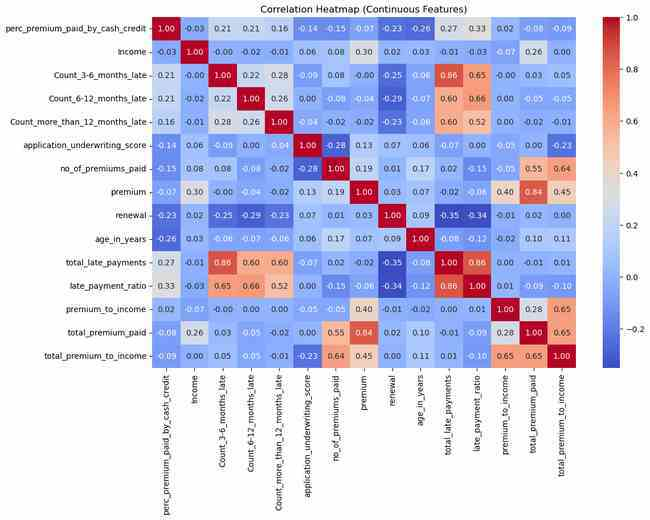

In [92]:
cont_features = OG_proc_clean_fe.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Correlation matrix (including renewal)
corr_matrix = OG_proc_clean_fe[cont_features].corr()

# Heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap (Continuous Features)")
plt.show()

## Premium–Income Related Features

### Engineered Features
- **`premium_to_income`**: ratio of one installment to income.  
- **`total_premium_paid`**: cumulative premiums paid so far.  
- **`total_premium_to_income`**: cumulative premiums relative to income.  

### Correlation with Renewal
| Feature                  | Correlation with Renewal |
|---------------------------|--------------------------|
| premium_to_income         | –0.01                   |
| total_premium_paid        | +0.02                   |
| total_premium_to_income   | ~0.00                   |

### Interpretation
- All three features show **near-zero correlation** with the renewal target.  
- This suggests that in this dataset, **premium affordability and cumulative investment are not key drivers of renewal**.  
- This finding is consistent with insurance domain knowledge: **renewal is more influenced by behavioral history (late payments, underwriting score) than raw affordability**.  

### Decision
- **Retain** for tree-based models (e.g., Random Forest, XGBoost), since these models may capture **nonlinear thresholds**.  
- **Exclude** from linear models (e.g., Logistic Regression), as they add little predictive power and may introduce noise.  


## Late Payment Features

### Engineered Features
- **`total_late_payments`**: sum of all late payment counts across 3–6 months, 6–12 months, and more than 12 months.  
- **`late_payment_ratio`**: proportion of late payments relative to the total number of premiums paid.  

### Correlation with Renewal
| Feature              | Correlation with Renewal |
|-----------------------|--------------------------|
| total_late_payments   | –0.35                   |
| late_payment_ratio    | –0.34                   |

### Interpretation
- Both features show **strong negative correlation** with renewal, confirming that customers with higher delinquency are less likely to renew.  
- **`total_late_payments`** captures absolute delinquency, while **`late_payment_ratio`** normalizes by tenure, making comparisons fairer across customers.  
- The two features are highly correlated with each other (~0.86), meaning they carry largely the same information.  

### Decision
- Keep **`late_payment_ratio`** for modeling, as it generalizes better across different tenures.  
- Retain **`total_late_payments`** only for descriptive analysis and reporting, but it can be excluded from model inputs to avoid redundancy.  


In [96]:
# Features to drop (redundant / weak)
drop_features = [
    'premium_to_income',
    'total_premium_paid',
    'total_premium_to_income',
    'total_late_payments'
]

# Create new reduced DataFrames
OG_proc_clean_fe_reduced = OG_proc_clean_fe.drop(columns=drop_features, errors='ignore')
OG_proc_fe_reduced = OG_proc_fe.drop(columns=drop_features, errors='ignore')

print("Original engineered clean shape:", OG_proc_clean_fe.shape)
print("Reduced engineered clean shape :", OG_proc_clean_fe_reduced.shape)

print("\nOriginal engineered base shape:", OG_proc_fe.shape)
print("Reduced engineered base shape :", OG_proc_fe_reduced.shape)


Original engineered clean shape: (79535, 17)
Reduced engineered clean shape : (79535, 13)

Original engineered base shape: (79853, 17)
Reduced engineered base shape : (79853, 13)


In [98]:
# Remove weak categorical features from reduced datasets
base_reduced_no_cat = OG_proc_fe_reduced.drop(
    columns=['sourcing_channel', 'residence_area_type'], errors='ignore'
)

clean_reduced_no_cat = OG_proc_clean_fe_reduced.drop(
    columns=['sourcing_channel', 'residence_area_type'], errors='ignore'
)

In [100]:
# ==============================================================
# RAW VERSIONS (remove engineered feature 'late_payment_ratio')
# ==============================================================

base_reduced_no_cat_raw = base_reduced_no_cat.drop(
    columns=['late_payment_ratio'], errors='ignore'
)

clean_reduced_no_cat_raw = clean_reduced_no_cat.drop(
    columns=['late_payment_ratio'], errors='ignore'
)


# ==============================================================
# TOP CORRELATION VERSIONS (keep only features with >0.3 correlation)
# ==============================================================

base_topcorr_only = base_reduced_no_cat[
    [
        'perc_premium_paid_by_cash_credit',
        'Count_3-6_months_late',
        'Count_6-12_months_late',
        'Count_more_than_12_months_late',
        'renewal'
    ]
].copy()

clean_topcorr_only = clean_reduced_no_cat[
    [
        'perc_premium_paid_by_cash_credit',
        'Count_3-6_months_late',
        'Count_6-12_months_late',
        'Count_more_than_12_months_late',
        'renewal'
    ]
].copy()


In [102]:
datasets = {
    "base_full": OG_proc_fe,
    "clean_full": OG_proc_clean_fe,
    "base_reduced": OG_proc_fe_reduced,
    "clean_reduced": OG_proc_clean_fe_reduced,
    "base_reduced_no_cat": base_reduced_no_cat,
    "clean_reduced_no_cat": clean_reduced_no_cat,
    "base_reduced_no_cat_raw": base_reduced_no_cat_raw,
    "clean_reduced_no_cat_raw": clean_reduced_no_cat_raw,
    "base_topcorr_only": base_topcorr_only,
    "clean_topcorr_only": clean_topcorr_only,
}


In [104]:
splits = {}
for name, df in datasets.items():
    X = df.drop(columns=[TARGET])
    y = df[TARGET]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    
    splits[name] = (X_train, X_test, y_train, y_test)
    print(f"{name}: Train={X_train.shape}, Test={X_test.shape}")

base_full: Train=(63882, 16), Test=(15971, 16)
clean_full: Train=(63628, 16), Test=(15907, 16)
base_reduced: Train=(63882, 12), Test=(15971, 12)
clean_reduced: Train=(63628, 12), Test=(15907, 12)
base_reduced_no_cat: Train=(63882, 10), Test=(15971, 10)
clean_reduced_no_cat: Train=(63628, 10), Test=(15907, 10)
base_reduced_no_cat_raw: Train=(63882, 9), Test=(15971, 9)
clean_reduced_no_cat_raw: Train=(63628, 9), Test=(15907, 9)
base_topcorr_only: Train=(63882, 4), Test=(15971, 4)
clean_topcorr_only: Train=(63628, 4), Test=(15907, 4)


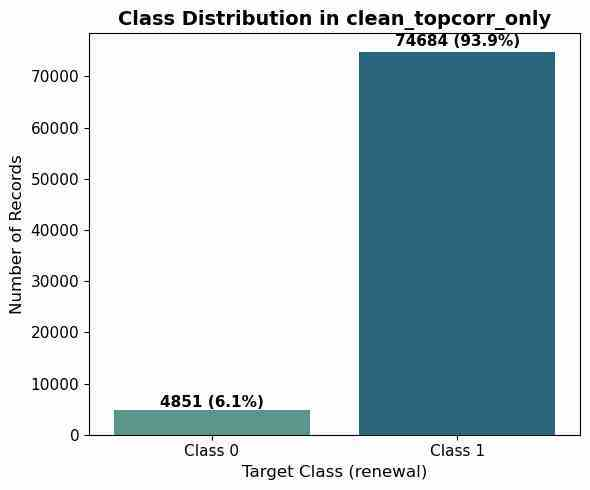

In [106]:

# --- Dataset ---
df = clean_topcorr_only.copy()

# --- Compute counts & percentages ---
class_counts = df['renewal'].value_counts().sort_index()
percentages = (class_counts / class_counts.sum() * 100).round(2)

# --- Build dynamic class labels from actual unique values ---
classes = [f"Class {int(c)}" for c in class_counts.index]

# --- Prepare summary DataFrame for plotting ---
plot_df = pd.DataFrame({
    'Class': classes,
    'Count': class_counts.values,
    'Percentage': percentages.values
})

# --- Plot ---
plt.figure(figsize=(6,5))
ax = sns.barplot(data=plot_df, x='Class', y='Count', palette='crest')

# --- Annotate counts & percentages ---
for i, row in plot_df.iterrows():
    ax.text(i, row['Count'] + (row['Count'] * 0.01),
            f"{row['Count']} ({row['Percentage']}%)",
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# --- Labels & style ---
plt.title("Class Distribution in clean_topcorr_only", fontsize=14, fontweight='bold')
plt.ylabel("Number of Records", fontsize=12)
plt.xlabel("Target Class (renewal)", fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()


### Target label standardization (non-renewal as positive class)

The original dataset encoded the `renewal` column as:
- `0 = Non-renewal`
- `1 = Renewal`

Our modeling objective is to predict **non-renewal**. To make evaluation and tuning straightforward (so that `predict_proba()[:, 1]` and default scorers like `roc_auc`, `average_precision`, and `recall` all refer to the class of interest), we standardize the target encoding so that:

- `1 → Non-renewal (positive class)`
- `0 → Renewal (negative class)`

This transformation is applied once, at dataset-preparation time, to all dataset variants. All subsequent modeling and evaluation in this notebook use the standardized encoding.

In [109]:
# ==============================================================
# Flip target column ('renewal') so that non-renewal → 1, renewal → 0
# In-place modification of all datasets in the dictionary
# ==============================================================

for name, df in datasets.items():
    print(f"\n🔁 Processing dataset: {name}")
    
    # Count before flipping
    before_counts = df['renewal'].value_counts().to_dict()
    print("Before flip:", before_counts)
    
    # Flip target inplace
    df['renewal'] = 1 - df['renewal']
    
    # Count after flipping
    after_counts = df['renewal'].value_counts().to_dict()
    print("After  flip:", after_counts)
    
    # Simple consistency check
    total_before = sum(before_counts.values())
    total_after = sum(after_counts.values())
    assert total_before == total_after, f"Row count mismatch in {name} after flipping!"

print("\n All datasets updated in-place: non-renewal → 1, renewal → 0")



🔁 Processing dataset: base_full
Before flip: {1: 74855, 0: 4998}
After  flip: {0: 74855, 1: 4998}

🔁 Processing dataset: clean_full
Before flip: {1: 74684, 0: 4851}
After  flip: {0: 74684, 1: 4851}

🔁 Processing dataset: base_reduced
Before flip: {1: 74855, 0: 4998}
After  flip: {0: 74855, 1: 4998}

🔁 Processing dataset: clean_reduced
Before flip: {1: 74684, 0: 4851}
After  flip: {0: 74684, 1: 4851}

🔁 Processing dataset: base_reduced_no_cat
Before flip: {1: 74855, 0: 4998}
After  flip: {0: 74855, 1: 4998}

🔁 Processing dataset: clean_reduced_no_cat
Before flip: {1: 74684, 0: 4851}
After  flip: {0: 74684, 1: 4851}

🔁 Processing dataset: base_reduced_no_cat_raw
Before flip: {1: 74855, 0: 4998}
After  flip: {0: 74855, 1: 4998}

🔁 Processing dataset: clean_reduced_no_cat_raw
Before flip: {1: 74684, 0: 4851}
After  flip: {0: 74684, 1: 4851}

🔁 Processing dataset: base_topcorr_only
Before flip: {1: 74855, 0: 4998}
After  flip: {0: 74855, 1: 4998}

🔁 Processing dataset: clean_topcorr_only
B

### Verifying Target Encoding Flip (Renewal ↔ Non-Renewal)

To ensure correctness, we visualize the target class distribution **before** and **after** flipping.

- The total record count remains the same.
- Only the class labels are swapped.
- The visual proportions confirm no data loss or duplication.


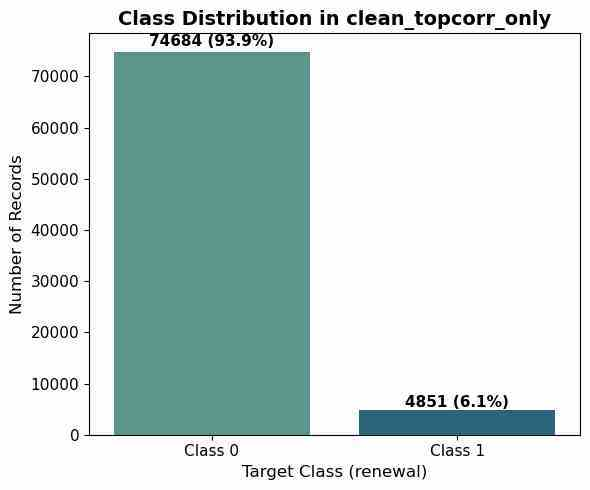

In [112]:

# --- Dataset ---
df = clean_topcorr_only.copy()

# --- Compute counts & percentages ---
class_counts = df['renewal'].value_counts().sort_index()
percentages = (class_counts / class_counts.sum() * 100).round(2)

# --- Build dynamic class labels from actual unique values ---
classes = [f"Class {int(c)}" for c in class_counts.index]

# --- Prepare summary DataFrame for plotting ---
plot_df = pd.DataFrame({
    'Class': classes,
    'Count': class_counts.values,
    'Percentage': percentages.values
})

# --- Plot ---
plt.figure(figsize=(6,5))
ax = sns.barplot(data=plot_df, x='Class', y='Count', palette='crest')

# --- Annotate counts & percentages ---
for i, row in plot_df.iterrows():
    ax.text(i, row['Count'] + (row['Count'] * 0.01),
            f"{row['Count']} ({row['Percentage']}%)",
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# --- Labels & style ---
plt.title("Class Distribution in clean_topcorr_only", fontsize=14, fontweight='bold')
plt.ylabel("Number of Records", fontsize=12)
plt.xlabel("Target Class (renewal)", fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()


In [114]:
# for name, df in datasets.items():
#     if 'residence_area_type' in df.columns:
#         df['residence_area_type'] = df['residence_area_type'].map({'Rural': 0, 'Urban': 1})


In [116]:
# for name, df in datasets.items():
#     if 'residence_area_type' in df.columns:
#         # Convert to binary and rename
#         df['residence_area_type'] = (
#             df['residence_area_type']
#             .replace({'Rural': 0, 'Urban': 1})
#             .fillna(0)
#             .astype(int)
#         )
#         df.rename(columns={'residence_area_type': 'residence_area_type_urban'}, inplace=True)


In [118]:
def encode_categoricals(df):
    df_enc = df.copy()
    
    # Identify categorical columns
    cat_cols = df_enc.select_dtypes(include=['object','category']).columns.tolist()
    
    # Separate binary vs multi
    binary_cats = [c for c in cat_cols if df_enc[c].nunique() == 2]
    multi_cats  = [c for c in cat_cols if df_enc[c].nunique() > 2]
    
    # Binary → drop_first=True
    df_enc = pd.get_dummies(df_enc, columns=binary_cats, drop_first=True)
    
    # Multi → drop_first=False
    df_enc = pd.get_dummies(df_enc, columns=multi_cats, drop_first=False)
    # === EDA-only one-hot encoding (for exploration, not modeling) ===
    
    return df_enc


In [65]:
encoded_datasets = {name: encode_categoricals(df) for name, df in datasets.items()}

for name, df in encoded_datasets.items():
    print(f"\n{name} → {df.shape}")
    print("Features:", df.columns.tolist())



base_full → (79853, 21)
Features: ['perc_premium_paid_by_cash_credit', 'Income', 'Count_3-6_months_late', 'Count_6-12_months_late', 'Count_more_than_12_months_late', 'application_underwriting_score', 'no_of_premiums_paid', 'premium', 'renewal', 'age_in_years', 'total_late_payments', 'late_payment_ratio', 'premium_to_income', 'total_premium_paid', 'total_premium_to_income', 'residence_area_type_Urban', 'sourcing_channel_A', 'sourcing_channel_B', 'sourcing_channel_C', 'sourcing_channel_D', 'sourcing_channel_E']

clean_full → (79535, 21)
Features: ['perc_premium_paid_by_cash_credit', 'Income', 'Count_3-6_months_late', 'Count_6-12_months_late', 'Count_more_than_12_months_late', 'application_underwriting_score', 'no_of_premiums_paid', 'premium', 'renewal', 'age_in_years', 'total_late_payments', 'late_payment_ratio', 'premium_to_income', 'total_premium_paid', 'total_premium_to_income', 'residence_area_type_Urban', 'sourcing_channel_A', 'sourcing_channel_B', 'sourcing_channel_C', 'sourcing_c

In [66]:
OG_proc_fe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79853 entries, 0 to 79852
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   perc_premium_paid_by_cash_credit  79853 non-null  float64
 1   Income                            79853 non-null  int64  
 2   Count_3-6_months_late             79853 non-null  float64
 3   Count_6-12_months_late            79853 non-null  float64
 4   Count_more_than_12_months_late    79853 non-null  float64
 5   application_underwriting_score    79853 non-null  float64
 6   no_of_premiums_paid               79853 non-null  int64  
 7   sourcing_channel                  79853 non-null  object 
 8   residence_area_type               79853 non-null  object 
 9   premium                           79853 non-null  int64  
 10  renewal                           79853 non-null  int64  
 11  age_in_years                      79853 non-null  int64  
 12  tota

# Feature Preparation Pipeline

### Function: `split_dataset()`

This function performs stratified splitting of the dataset into Train/Test or Train/Validation/Test subsets.

Steps:
1. Splits the dataset into Train+Validation and Test based on `test_size`.
2. If `val_size > 0`, further splits Train+Validation into Train and Validation using proportional allocation.
3. Stratification ensures that the target class distribution remains consistent across all splits.

Returns:
- Train, Validation (optional), and Test sets for both features and target.


In [120]:
def split_dataset(X, y, test_size=0.2, val_size=0.0, random_state=42, stratify=True):
    """
    Splits data into train/test, or train/validation/test if val_size > 0.

    Parameters
    ----------
    X : pd.DataFrame or np.ndarray
        Feature matrix
    y : pd.Series or np.ndarray
        Target vector
    test_size : float, default=0.2
        Fraction of data for test set.
    val_size : float, default=0.0
        Fraction of data for validation set (0 = skip validation).
    random_state : int, default=42
        Random seed for reproducibility.
    stratify : bool, default=True
        Whether to stratify splits by y.

    Returns
    -------
    tuple
        If val_size == 0:
            (X_train, X_test, y_train, y_test)
        Else:
            (X_train, X_val, X_test, y_train, y_val, y_test)
    """
    stratify_arg = y if stratify else None

    # --- Split into train+val and test ---
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X, y,
        test_size=test_size,
        stratify=stratify_arg,
        random_state=random_state
    )

    # --- Optional validation split ---
    if val_size and val_size > 0:
        val_fraction = val_size / (1 - test_size)
        stratify_val = y_trainval if stratify else None

        X_train, X_val, y_train, y_val = train_test_split(
            X_trainval, y_trainval,
            test_size=val_fraction,
            stratify=stratify_val,
            random_state=random_state
        )
        return X_train, X_val, X_test, y_train, y_val, y_test

    # --- No validation split ---
    return X_trainval, X_test, y_trainval, y_test


### Function: `make_onehot_encoder()`

Helper function that ensures compatibility across different versions of scikit-learn by selecting the appropriate OneHotEncoder initialization parameter (`sparse_output` or `sparse`), while consistently enabling `handle_unknown="ignore"`.


In [123]:
def make_onehot_encoder(sparse=False, handle_unknown="ignore"):
    # older sklearn uses `sparse`, newer uses `sparse_output`
    try:
        encoder = OneHotEncoder(sparse_output=sparse, handle_unknown=handle_unknown)
    except TypeError:
        encoder = OneHotEncoder(sparse=sparse, handle_unknown=handle_unknown)
    return encoder



### Function: `encode_categorical_df()`

This function handles categorical variable encoding in a reproducible way using only the TRAIN dataset for fitting.

Processing logic:
- Identifies categorical and numeric columns from the training data.
- Binary categoricals (2 unique values) are converted to a single indicator column named `<column>_<positive_class>`, ensuring consistent 0/1 coding.
- Multi-category variables are encoded using `OneHotEncoder(handle_unknown="ignore")`.
- Encoded columns are combined with numeric features to produce final feature matrices for train and test.
- Returns:
  - Encoded Train and Test DataFrames
  - The fitted OneHotEncoder (or `None` if no multi-categorical features exist)
  - Lists of numeric and one-hot feature names for downstream scaling


In [126]:
# ===== Encode categorical features and return DataFrames + metadata =====
def encode_categorical_df(X_train_df, X_test_df, sparse=False):
    """
    Fit OneHotEncoder on categorical columns of X_train_df, transform train/test,
    and return encoded DataFrames + encoder + feature metadata.

    Returns:
      X_train_enc_df, X_test_enc_df, encoder, feature_names, numeric_features, onehot_features
    """
    X_train = X_train_df.copy()
    X_test = X_test_df.copy()

    # Identify categorical and numeric columns from TRAIN only (metadata)
    cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
    num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

    # Early exit: no categoricals
    if len(cat_cols) == 0:
        feature_names = num_cols.copy()
        return (
            X_train.reset_index(drop=True),
            X_test.reset_index(drop=True),
            None,
            feature_names,
            num_cols,
            []
        )

    # Split categorical columns into binary and multi-category
    binary_cats = [c for c in cat_cols if X_train[c].nunique(dropna=True) == 2]
    multi_cats  = [c for c in cat_cols if X_train[c].nunique(dropna=True) > 2]

    # --- Handle binary categoricals manually (for consistency across datasets) ---
    # Create stable column names like <col>_<positive_value>
    for c in binary_cats:
        unique_vals = sorted(X_train[c].dropna().unique())  # ensure same ordering
        if len(unique_vals) == 2:
            pos_class = unique_vals[1]  # second unique value becomes 1
            new_col = f"{c}_{pos_class}"
            X_train[new_col] = (X_train[c] == pos_class).astype(int)
            X_test[new_col]  = (X_test[c] == pos_class).astype(int)
        else:
            # fallback safety (shouldn't happen)
            X_train[c] = X_train[c].astype('category').cat.codes
            X_test[c]  = X_test[c].astype('category').cat.codes

        # Drop original binary column
        X_train.drop(columns=[c], inplace=True)
        X_test.drop(columns=[c], inplace=True)

    # --- Handle multi-class categoricals via OneHotEncoder ---
    encoder = None
    ohe_feat_names = []

    if len(multi_cats) > 0:
        encoder = make_onehot_encoder(sparse=sparse, handle_unknown="ignore")
        encoder.fit(X_train[multi_cats])

        X_train_cat = encoder.transform(X_train[multi_cats])
        X_test_cat  = encoder.transform(X_test[multi_cats])

        ohe_feat_names = encoder.get_feature_names_out(multi_cats).tolist()

        X_train_cat_df = pd.DataFrame(X_train_cat, columns=ohe_feat_names, index=X_train.index)
        X_test_cat_df  = pd.DataFrame(X_test_cat, columns=ohe_feat_names, index=X_test.index)

        # Drop original multi-cats
        X_train.drop(columns=multi_cats, inplace=True)
        X_test.drop(columns=multi_cats, inplace=True)

        # Merge numeric + binary + one-hot (reset index for safe concat)
        X_train = pd.concat([X_train.reset_index(drop=True), X_train_cat_df.reset_index(drop=True)], axis=1)
        X_test  = pd.concat([X_test.reset_index(drop=True), X_test_cat_df.reset_index(drop=True)], axis=1)
    else:
        # No multi-cats, just ensure index alignment
        X_train = X_train.reset_index(drop=True)
        X_test  = X_test.reset_index(drop=True)

    # Final metadata
    feature_names = X_train.columns.tolist()

    # numeric_features: the numeric columns (from original train numeric cols)
    # onehot_features: any one-hot columns produced (ohe_feat_names) PLUS binary-created columns
    binary_created = [col for col in feature_names if any(col.startswith(b + "_") for b in binary_cats)]
    onehot_features = ohe_feat_names + binary_created

    numeric_features = [c for c in feature_names if c not in onehot_features]

    return X_train, X_test, encoder, feature_names, numeric_features, onehot_features


### Function: `scale_dataframe_numeric_safe()`

This function applies feature scaling (standardization) in a controlled manner that avoids dtype issues.

Key aspects:
- If `scale_numeric_only=True`, only numeric columns are scaled, while one-hot encoded columns are preserved.
- If `scale_numeric_only=False`, all columns are scaled.
- Scaling is performed using `StandardScaler`, fitted only on the training set.
- New DataFrames are created to prevent modifying original data structures.
- The function returns scaled Train, Test, and (optionally) Validation sets along with the fitted scaler.


In [129]:
def scale_dataframe_numeric_safe(
    X_train_df: pd.DataFrame,
    X_test_df: pd.DataFrame,
    X_val_df: Optional[pd.DataFrame] = None,
    *,
    scale_numeric_only: bool = True,
    numeric_features: Optional[Iterable[str]] = None,
    onehot_features: Optional[Iterable[str]] = None,
    verbose: bool = False
) -> Tuple[pd.DataFrame, pd.DataFrame, Optional[pd.DataFrame], Optional[StandardScaler]]:
    """
    Safely scale numeric columns (or all columns) and return NEW DataFrames (no in-place
    assignment to existing integer columns which triggers pandas FutureWarning).

    Parameters
    ----------
    X_train_df, X_test_df, X_val_df : pd.DataFrame
        Input feature DataFrames. X_val_df can be None.
    scale_numeric_only : bool
        If True, scale only numeric columns (preferred for mixed numeric + one-hot).
        If False, scale all columns (useful when everything is numeric).
    numeric_features : iterable[str] or None
        Explicit list of numeric columns to scale. If provided, this is used instead of
        auto-detected numeric dtypes.
    onehot_features : iterable[str] or None
        If provided, these columns will be treated as one-hot categorical and excluded
        from numeric_features when auto-detecting numeric columns.
    verbose : bool
        If True prints helpful diagnostics.

    Returns
    -------
    X_train_safe, X_test_safe, X_val_safe, scaler
        Scaled DataFrames (X_val_safe may be None if X_val_df was None) and the fitted
        StandardScaler (or None if nothing was scaled).
    """
    # Defensive copies
    X_train = X_train_df.copy()
    X_test = X_test_df.copy()
    X_val = X_val_df.copy() if X_val_df is not None else None

    # If user asked to scale only numeric columns, compute the columns
    if scale_numeric_only:
        # Prefer explicit metadata
        if numeric_features is not None:
            num_cols = list(numeric_features)
        else:
            # auto-detect numeric columns, but allow excluding known one-hot features
            candidate = X_train.select_dtypes(include=[np.number]).columns.tolist()
            if onehot_features:
                num_cols = [c for c in candidate if c not in set(onehot_features)]
            else:
                num_cols = candidate

        # If no numeric columns found, return originals (no scaler)
        if len(num_cols) == 0:
            if verbose:
                print("scale_dataframe_numeric_safe: no numeric columns detected -> returning originals (scaler=None).")
            return X_train, X_test, X_val, None

        # Validate presence across splits
        missing_train = [c for c in num_cols if c not in X_train.columns]
        missing_test  = [c for c in num_cols if c not in X_test.columns]
        missing_val   = [c for c in num_cols if X_val is not None and c not in X_val.columns]
        if missing_train or missing_test or missing_val:
            raise ValueError(f"Numeric columns missing: train_missing={missing_train}, test_missing={missing_test}, val_missing={missing_val}")

        if verbose:
            print("scale_dataframe_numeric_safe: scaling numeric columns:", num_cols)
            print("dtypes before coercion (train):", X_train[num_cols].dtypes.to_dict())

        # Explicit coercion to float to avoid dtype-incompatibility on assignment
        for c in num_cols:
            X_train[c] = pd.to_numeric(X_train[c], errors="coerce").astype(float)
            X_test[c]  = pd.to_numeric(X_test[c], errors="coerce").astype(float)
            if X_val is not None:
                X_val[c] = pd.to_numeric(X_val[c], errors="coerce").astype(float)

        if verbose:
            print("dtypes after coercion (train):", X_train[num_cols].dtypes.to_dict())
            print("NaNs after coercion (train/test/val):",
                  int(X_train[num_cols].isna().sum().sum()),
                  int(X_test[num_cols].isna().sum().sum()),
                  int(X_val[num_cols].isna().sum().sum()) if X_val is not None else 0)

        # Fit scaler and create scaled DataFrames (float dtype)
        scaler = StandardScaler()
        scaled_train_df = pd.DataFrame(
            scaler.fit_transform(X_train[num_cols].values),
            columns=num_cols,
            index=X_train.index,
            dtype=float
        )
        scaled_test_df = pd.DataFrame(
            scaler.transform(X_test[num_cols].values),
            columns=num_cols,
            index=X_test.index,
            dtype=float
        )
        scaled_val_df = None
        if X_val is not None:
            scaled_val_df = pd.DataFrame(
                scaler.transform(X_val[num_cols].values),
                columns=num_cols,
                index=X_val.index,
                dtype=float
            )

        # SAFE recomposition: concatenate non-numeric part with scaled numeric block
        non_num_train = X_train.drop(columns=num_cols)
        non_num_test  = X_test.drop(columns=num_cols)
        non_num_val   = X_val.drop(columns=num_cols) if X_val is not None else None

        X_train_safe = pd.concat([non_num_train.reset_index(drop=True), scaled_train_df.reset_index(drop=True)], axis=1)
        X_test_safe  = pd.concat([non_num_test.reset_index(drop=True), scaled_test_df.reset_index(drop=True)], axis=1)
        X_val_safe   = pd.concat([non_num_val.reset_index(drop=True), scaled_val_df.reset_index(drop=True)], axis=1) if X_val is not None else None

        # restore original column order: non-numeric columns (original order) then numeric columns
        col_order = list(non_num_train.columns) + list(num_cols)
        X_train_safe = X_train_safe[col_order]
        X_test_safe  = X_test_safe[col_order]
        if X_val_safe is not None:
            X_val_safe = X_val_safe[col_order]

        if verbose:
            print("scale_dataframe_numeric_safe: scaling complete; numeric dtypes:", X_train_safe[num_cols].dtypes.to_dict())

        return X_train_safe, X_test_safe, X_val_safe, scaler

    else:
        # scale everything: rebuild complete DataFrames as floats (safe)
        if verbose:
            print("scale_dataframe_numeric_safe: scaling entire DataFrames (all columns).")

        scaler = StandardScaler()
        X_train_safe = pd.DataFrame(
            scaler.fit_transform(X_train.values),
            columns=X_train.columns,
            index=X_train.index,
            dtype=float
        )
        X_test_safe = pd.DataFrame(
            scaler.transform(X_test.values),
            columns=X_test.columns,
            index=X_test.index,
            dtype=float
        )
        X_val_safe = None
        if X_val is not None:
            X_val_safe = pd.DataFrame(
                scaler.transform(X_val.values),
                columns=X_val.columns,
                index=X_val.index,
                dtype=float
            )

        if verbose:
            print("scale_dataframe_numeric_safe: finished scaling all columns; all dtypes are float64.")

        return X_train_safe, X_test_safe, X_val_safe, scaler

### Function: `prepare_dataset_df()`

This function performs the complete preprocessing pipeline required for model training.

Steps performed:
1. **Splitting**
   - Splits the dataset into Train / Test / (optional Validation) sets.
   - Uses stratified splitting to maintain target class distribution.

2. **Categorical Encoding**
   - Binary categorical features (2 unique values) are converted into a single 0/1 indicator column using a consistent rule based on sorted class labels in the training data.
   - Multi-category features (>2 unique values) are encoded using `OneHotEncoder` fitted **only on the training data**.
   - Ensures the same columns and ordering are applied to validation and test sets.

3. **Scaling**
   - Two modes are supported:
     - `numeric_only`: Only true numeric features are scaled (encoded binary/OHE columns remain unchanged).
     - `all`: The entire encoded feature matrix is scaled.
   - Scaling uses `StandardScaler` fitted only on the training set.

4. **Integrity Checks**
   - Validates that Train, Validation (if present), and Test feature matrices have exactly the same columns in the same order.

**Returns**
A dictionary containing:
- `X_train_df`, `X_val_df`, `X_test_df`: Preprocessed feature matrices.
- `y_train`, `y_val`, `y_test`: Corresponding target vectors.
- `encoder`: The fitted OneHotEncoder (or `None` if no multi-category features exist).
- `scaler`: The fitted StandardScaler (or `None` if scaling was not applied).
- `features`: Final list of feature names after encoding and scaling.
- `numeric_features`: List of numeric features used for scaling logic.
- `onehot_features`: List of encoded categorical (binary + OHE) feature columns.
- `scale_mode`: Selected scaling mode.


In [132]:
def prepare_dataset_df(
    df,
    target=TARGET,
    test_size=0.2,
    val_size=0.0,
    random_state=SEED,
    scale_mode=None
):
    """
    Full preprocessing: split -> encode -> scale.

    Parameters
    ----------
    scale_mode : str, **mandatory**. Must be one of:
        - "numeric_only" : scale only true numeric features (one-hot columns untouched)
        - "all"          : scale entire encoded matrix (including OHE/binaries)

    Returns dict with X/Y splits, encoder, scaler, features and metadata.
    """
    # Validate scale_mode (mandatory)
    if scale_mode not in {"numeric_only", "all"}:
        raise ValueError("scale_mode is mandatory and must be 'numeric_only' or 'all'")

    # 1) split
    X = df.drop(columns=[target]).copy()
    y = df[target].astype(int).copy()                          # explicit int cast

    split_out = split_dataset(X, y, test_size=test_size, val_size=val_size, random_state=random_state, stratify=True)

    if val_size and val_size > 0:
        X_train_df, X_val_df, X_test_df, y_train, y_val, y_test = split_out
    else:
        X_train_df, X_test_df, y_train, y_test = split_out
        X_val_df, y_val = None, None

    # Normalize indexes to avoid misalignment
    X_train_df = X_train_df.reset_index(drop=True)
    X_test_df  = X_test_df.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test  = y_test.reset_index(drop=True)
    if X_val_df is not None:
        X_val_df = X_val_df.reset_index(drop=True)
        y_val = y_val.reset_index(drop=True)

    # 2) encode categorical features using encoder fitted on train only
    X_train_enc_df, X_test_enc_df, encoder, feature_names, num_cols, ohe_cols = encode_categorical_df(X_train_df, X_test_df, sparse=False)

    # 2b) build X_val_enc_df consistently (if validation exists) -- FIXED
    X_val_enc_df = None
    if X_val_df is not None:
        if encoder is not None:
            # Recompute TRAIN categorical metadata (must match encode_categorical_df logic)
            train_cat_cols = X_train_df.select_dtypes(include=["object", "category"]).columns.tolist()
            train_num_cols = X_train_df.select_dtypes(include=[np.number]).columns.tolist()

            # Determine binary vs multi exactly as in encode_categorical_df (based on TRAIN)
            binary_cats = [c for c in train_cat_cols if X_train_df[c].nunique(dropna=True) == 2]
            multi_cats  = [c for c in train_cat_cols if X_train_df[c].nunique(dropna=True) > 2]

            # 1) Numeric part (from TRAIN numeric ordering)
            X_val_num_df = X_val_df[train_num_cols].reset_index(drop=True)

            # 2) Recreate binary columns on VAL using TRAIN ordering & positive class
            X_val_bin_df = pd.DataFrame(index=X_val_df.index)
            for c in binary_cats:
                unique_vals = sorted(X_train_df[c].dropna().unique())
                if len(unique_vals) == 2:
                    pos_class = unique_vals[1]
                    new_col = f"{c}_{pos_class}"
                    X_val_bin_df[new_col] = (X_val_df[c] == pos_class).astype(int).reset_index(drop=True)
                else:
                    # fallback: numeric codes
                    X_val_bin_df[c] = X_val_df[c].astype('category').cat.codes.reset_index(drop=True)

            # 3) Transform multi-class categories using the fitted encoder (only multi_cats)
            if len(multi_cats) > 0:
                # Pass exactly the multi_cats to the encoder (same order)
                X_val_cat_trans = encoder.transform(X_val_df[multi_cats])
                X_val_cat_df = pd.DataFrame(
                    X_val_cat_trans,
                    columns=encoder.get_feature_names_out(multi_cats),
                ).reset_index(drop=True)

                # 4) Concatenate numeric + binary + one-hot in the same relative order used in TRAIN
                X_val_enc_df = pd.concat(
                    [X_val_num_df.reset_index(drop=True),
                     X_val_bin_df.reset_index(drop=True),
                     X_val_cat_df.reset_index(drop=True)],
                    axis=1
                )
            else:
                # No multi-class cats: numeric + binary only
                X_val_enc_df = pd.concat(
                    [X_val_num_df.reset_index(drop=True),
                     X_val_bin_df.reset_index(drop=True)],
                    axis=1
                )
        else:
            # encoder is None -> TRAIN had no multi-class categoricals; VAL just uses numeric and any binary handling is N/A here
            X_val_enc_df = X_val_df.reset_index(drop=True)

    # Ensure encoded outputs are DataFrames with proper indexing
    if not isinstance(X_train_enc_df, pd.DataFrame):
        X_train_enc_df = pd.DataFrame(X_train_enc_df, columns=feature_names).reset_index(drop=True)
    else:
        X_train_enc_df = X_train_enc_df.reset_index(drop=True)

    if not isinstance(X_test_enc_df, pd.DataFrame):
        X_test_enc_df = pd.DataFrame(X_test_enc_df, columns=feature_names).reset_index(drop=True)
    else:
        X_test_enc_df = X_test_enc_df.reset_index(drop=True)

    if X_val_enc_df is not None and not isinstance(X_val_enc_df, pd.DataFrame):
        X_val_enc_df = pd.DataFrame(X_val_enc_df, columns=X_train_enc_df.columns).reset_index(drop=True)

    # Sanity-check: ensure train/test/val have identical encoded columns (order too)
    if isinstance(X_test_enc_df, pd.DataFrame):
        if list(X_train_enc_df.columns) != list(X_test_enc_df.columns):
            train_cols = set(X_train_enc_df.columns)
            test_cols = set(X_test_enc_df.columns)
            missing_in_test = sorted(train_cols - test_cols)
            extra_in_test = sorted(test_cols - train_cols)
            raise AssertionError(
                f"TRAIN/TEST encoded columns mismatch. Missing in TEST: {missing_in_test}; Extra in TEST: {extra_in_test}"
            )
    if X_val_enc_df is not None:
        if list(X_train_enc_df.columns) != list(X_val_enc_df.columns):
            train_cols = set(X_train_enc_df.columns)
            val_cols = set(X_val_enc_df.columns)
            missing_in_val = sorted(train_cols - val_cols)
            extra_in_val = sorted(val_cols - train_cols)
            raise AssertionError(
                f"TRAIN/VAL encoded columns mismatch. Missing in VAL: {missing_in_val}; Extra in VAL: {extra_in_val}"
            )

    # 3) scale using chosen mode
    if scale_mode == "numeric_only":
        X_train_scaled_df, X_test_scaled_df, X_val_scaled_df, scaler = scale_dataframe_numeric_safe(
            X_train_enc_df,
            X_test_enc_df,
            X_val_enc_df,
            scale_numeric_only=True,
            numeric_features=num_cols,
            onehot_features=ohe_cols
        )
    else:  # scale_mode == "all"
        X_train_scaled_df, X_test_scaled_df, X_val_scaled_df, scaler = scale_dataframe_numeric_safe(
            X_train_enc_df,
            X_test_enc_df,
            X_val_enc_df,
            scale_numeric_only=False,
            numeric_features=num_cols,
            onehot_features=ohe_cols
        )

    # 4) final result dict
    features_out = X_train_scaled_df.columns.tolist() if isinstance(X_train_scaled_df, pd.DataFrame) else feature_names

    result = {
        "X_train_df": X_train_scaled_df,
        "X_val_df": X_val_scaled_df,
        "X_test_df": X_test_scaled_df,
        "y_train": y_train.reset_index(drop=True),
        "y_val": y_val.reset_index(drop=True) if y_val is not None else None,
        "y_test": y_test.reset_index(drop=True),
        "features": features_out,
        "encoder": encoder,
        "scaler": scaler,
        "numeric_features": num_cols,
        "onehot_features": ohe_cols,
        "scale_mode": scale_mode
    }

    # brief print
    train_shape = getattr(result["X_train_df"], "shape", None)
    test_shape  = getattr(result["X_test_df"], "shape", None)
    val_shape   = getattr(result["X_val_df"], "shape", None)
    nfeat = len(result["features"]) if result["features"] is not None else None

    if result["X_val_df"] is not None:
        print(f"Prepared dataset: Train={train_shape}, Val={val_shape}, Test={test_shape}, Features={nfeat}, mode={scale_mode}")
    else:
        print(f"Prepared dataset: Train={train_shape}, Test={test_shape}, Features={nfeat}, mode={scale_mode}")

    return result



---

### If your notebook **does not support Mermaid**, use this **simple academic diagram instead**:

```markdown
Raw Dataset (df)
        │
        ▼
[Train / Validation / Test Split]
        │
        ▼
[Categorical Encoding]
    • Binary categories → single 0/1 column
    • Multi-categories → One-Hot Encoder (fit on Train only)
        │
        ▼
[Scaling]
    • numeric_only → scale only numeric features
    • all → scale entire encoded matrix
        │
        ▼
Final Outputs:
    X_train_df, X_val_df, X_test_df
    y_train, y_val, y_test
    encoder (for inference)
    scaler (for normalization of new data)
    feature metadata lists


In [135]:
# ---------------------------------------------------------------------
# Recreate prepared_data using the new mandatory `scale_mode` argument.
# Choose "numeric_only" or "all" explicitly per dataset/model usage.
# ---------------------------------------------------------------------
prepared_data = {}

for name, df in datasets.items():
    print(f"\nPreparing: {name}")
    # CHANGE this value to "all" when you want to scale OHE columns as well.
    result = prepare_dataset_df(
        df,
        target=TARGET,
        test_size=0.2,
        val_size=0.1,            # change if you want validation
        random_state=SEED,
        scale_mode="all"   # <-- mandatory: "numeric_only" | "all"
    )

    # basic sanity checks (shape and y-lengths)
    Xtr = result["X_train_df"]; Xte = result["X_test_df"]; Xval = result.get("X_val_df")
    ytr = result["y_train"];  yte = result["y_test"];  yval = result.get("y_val")

    assert Xtr.shape[0] == ytr.shape[0], f"train rows mismatch for {name}"
    assert Xte.shape[0] == yte.shape[0], f"test rows mismatch for {name}"
    if Xval is not None and yval is not None:
        assert Xval.shape[0] == yval.shape[0], f"val rows mismatch for {name}"

    prepared_data[name] = result

    nfeat = len(result["features"]) if result["features"] is not None else None
    if Xval is not None:
        print(f"{name}: Train={Xtr.shape}, Val={Xval.shape}, Test={Xte.shape}, Features={nfeat}, mode={result['scale_mode']}")
    else:
        print(f"{name}: Train={Xtr.shape}, Test={Xte.shape}, Features={nfeat}, mode={result['scale_mode']}")


Preparing: base_full
Prepared dataset: Train=(55896, 20), Val=(7986, 20), Test=(15971, 20), Features=20, mode=all
base_full: Train=(55896, 20), Val=(7986, 20), Test=(15971, 20), Features=20, mode=all

Preparing: clean_full
Prepared dataset: Train=(55674, 20), Val=(7954, 20), Test=(15907, 20), Features=20, mode=all
clean_full: Train=(55674, 20), Val=(7954, 20), Test=(15907, 20), Features=20, mode=all

Preparing: base_reduced
Prepared dataset: Train=(55896, 16), Val=(7986, 16), Test=(15971, 16), Features=16, mode=all
base_reduced: Train=(55896, 16), Val=(7986, 16), Test=(15971, 16), Features=16, mode=all

Preparing: clean_reduced
Prepared dataset: Train=(55674, 16), Val=(7954, 16), Test=(15907, 16), Features=16, mode=all
clean_reduced: Train=(55674, 16), Val=(7954, 16), Test=(15907, 16), Features=16, mode=all

Preparing: base_reduced_no_cat
Prepared dataset: Train=(55896, 10), Val=(7986, 10), Test=(15971, 10), Features=10, mode=all
base_reduced_no_cat: Train=(55896, 10), Val=(7986, 10),

In [137]:
# === Summary check and preview ===

summary = []

for name, res in prepared_data.items():
    Xtr, Xte, Xval = res["X_train_df"], res["X_test_df"], res.get("X_val_df")
    ytr, yte, yval = res["y_train"], res["y_test"], res.get("y_val")
    mode = res["scale_mode"]

    # Feature alignment checks
    feat_mismatch_test = (list(Xtr.columns) != list(Xte.columns))
    feat_mismatch_val = False
    if Xval is not None:
        feat_mismatch_val = (list(Xtr.columns) != list(Xval.columns))

    # Class balance
    tr_counts = ytr.value_counts().to_dict()
    te_counts = yte.value_counts().to_dict()

    # NaN checks
    nan_train = int(Xtr.isna().sum().sum())
    nan_test = int(Xte.isna().sum().sum())
    nan_val = int(Xval.isna().sum().sum()) if Xval is not None else 0

    # Record summary
    summary.append({
        "dataset": name,
        "scale_mode": mode,
        "train_rows": Xtr.shape[0],
        "test_rows": Xte.shape[0],
        "val_rows": Xval.shape[0] if Xval is not None else 0,
        "features": Xtr.shape[1],
        "numeric_features": len(res["numeric_features"]),
        "onehot_features": len(res["onehot_features"]),
        "feat_mismatch_test": feat_mismatch_test,
        "feat_mismatch_val": feat_mismatch_val,
        "train_class_counts": tr_counts,
        "test_class_counts": te_counts,
        "nan_train": nan_train,
        "nan_test": nan_test,
        "nan_val": nan_val
    })

# === Display summary table ===
summary_df = pd.DataFrame(summary)
print("\n📊 Dataset Preparation Summary:\n")
display(summary_df)

# === Preview first few rows of each dataset ===
print("\n🔍 Sample rows from each prepared dataset:\n")

for name, res in prepared_data.items():
    print(f"🧾 Dataset: {name}  |  scale_mode: {res['scale_mode']}")
    print(f"Shape → Train={res['X_train_df'].shape}, Test={res['X_test_df'].shape}, "
          f"Features={len(res['features'])}\n")

    print("Numeric features (scaled):", res["numeric_features"][:5], "...")
    print("One-hot features (not scaled):", res["onehot_features"][:5], "...\n")

    # Show first 5 training rows
    display(res["X_val_df"].head(5))
    print("🎯 y_val (first 5):")
    print(res["y_val"].head(5).to_string(index=False))
    print("\n" + "-" * 120 + "\n")



📊 Dataset Preparation Summary:



dataset scale_mode  train_rows  test_rows  val_rows  \
0                 base_full        all       55896      15971      7986   
1                clean_full        all       55674      15907      7954   
2              base_reduced        all       55896      15971      7986   
3             clean_reduced        all       55674      15907      7954   
4       base_reduced_no_cat        all       55896      15971      7986   
5      clean_reduced_no_cat        all       55674      15907      7954   
6   base_reduced_no_cat_raw        all       55896      15971      7986   
7  clean_reduced_no_cat_raw        all       55674      15907      7954   
8         base_topcorr_only        all       55896      15971      7986   
9        clean_topcorr_only        all       55674      15907      7954   

   features  numeric_features  onehot_features  feat_mismatch_test  \
0        20                14                6               False   
1        20                14                6               False   
2        16                10                6               False   
3        16                10                6               False   
4        10                10                0               False   
5        10                10                0               False   
6         9                 9                0               False   
7         9                 9                0               False   
8         4                 4                0               False   
9         4                 4                0               False   

   feat_mismatch_val   train_class_counts    test_class_counts  nan_train  \
0              False  {0: 52398, 1: 3498}  {0: 14971, 1: 1000}          0   
1              False  {0: 52278, 1: 3396}   {0: 14937, 1: 970}          0   
2              False  {0: 52398, 1: 3498}  {0: 14971, 1: 1000}          0   
3              False  {0: 52278, 1: 3396}   {0: 14937, 1: 970}          0   
4              False  {0: 52398, 1: 3498}  {0: 14971, 1: 1000}          0   
5              False  {0: 52278, 1: 3396}   {0: 14937, 1: 970}          0   
6              False  {0: 52398, 1: 3498}  {0: 14971, 1: 1000}          0   
7              False  {0: 52278, 1: 3396}   {0: 14937, 1: 970}          0   
8              False  {0: 52398, 1: 3498}  {0: 14971, 1: 1000}          0   
9              False  {0: 52278, 1: 3396}   {0: 14937, 1: 970}          0   

   nan_test  nan_val  
0         0        0  
1         0        0  
2         0        0  
3         0        0  
4         0        0  
5         0        0  
6         0        0  
7         0        0  
8         0        0  
9         0        0


🔍 Sample rows from each prepared dataset:

🧾 Dataset: base_full  |  scale_mode: all
Shape → Train=(55896, 20), Test=(15971, 20), Features=20

Numeric features (scaled): ['perc_premium_paid_by_cash_credit', 'Income', 'Count_3-6_months_late', 'Count_6-12_months_late', 'Count_more_than_12_months_late'] ...
One-hot features (not scaled): ['sourcing_channel_A', 'sourcing_channel_B', 'sourcing_channel_C', 'sourcing_channel_D', 'sourcing_channel_E'] ...



perc_premium_paid_by_cash_credit    Income  Count_3-6_months_late  \
0                         -0.833652  0.086947              -0.358103   
1                         -0.123288 -0.142473              -0.358103   
2                         -0.872453 -0.283957              -0.358103   
3                         -0.926178 -0.021891              -0.358103   
4                         -0.836636  0.068153              -0.358103   

   Count_6-12_months_late  Count_more_than_12_months_late  \
0               -0.177256                       -0.191201   
1               -0.177256                       -0.191201   
2               -0.177256                       -0.191201   
3               -0.177256                       -0.191201   
4               -0.177256                       -0.191201   

   application_underwriting_score  no_of_premiums_paid   premium  \
0                        0.821262             1.763394  0.525369   
1                       -1.456319             2.342480 -0.363735   
2                        1.054508            -0.359918 -0.554257   
3                        0.862423             0.026138  0.525369   
4                        0.588015             0.798252  0.747645   

   age_in_years  total_late_payments  late_payment_ratio  premium_to_income  \
0      0.307434            -0.369235           -0.305962           0.193277   
1      1.148686            -0.369235           -0.305962          -0.045268   
2      2.130146            -0.369235           -0.305962           1.258168   
3      0.938373            -0.369235           -0.305962           0.814449   
4      0.728060            -0.369235           -0.305962           0.577399   

   total_premium_paid  total_premium_to_income  residence_area_type_Urban  \
0            1.245988                 1.487976                   0.808474   
1            0.291854                 1.555654                   0.808474   
2           -0.502930                 0.533579                  -1.236898   
3            0.307593                 0.639481                   0.808474   
4            0.931223                 1.148394                   0.808474   

   sourcing_channel_A  sourcing_channel_B  sourcing_channel_C  \
0            0.922322           -0.511013           -0.420544   
1            0.922322           -0.511013           -0.420544   
2            0.922322           -0.511013           -0.420544   
3            0.922322           -0.511013           -0.420544   
4            0.922322           -0.511013           -0.420544   

   sourcing_channel_D  sourcing_channel_E  
0           -0.322978           -0.088972  
1           -0.322978           -0.088972  
2           -0.322978           -0.088972  
3           -0.322978           -0.088972  
4           -0.322978           -0.088972

🎯 y_val (first 5):
1
0
0
0
0

------------------------------------------------------------------------------------------------------------------------

🧾 Dataset: clean_full  |  scale_mode: all
Shape → Train=(55674, 20), Test=(15907, 20), Features=20

Numeric features (scaled): ['perc_premium_paid_by_cash_credit', 'Income', 'Count_3-6_months_late', 'Count_6-12_months_late', 'Count_more_than_12_months_late'] ...
One-hot features (not scaled): ['sourcing_channel_A', 'sourcing_channel_B', 'sourcing_channel_C', 'sourcing_channel_D', 'sourcing_channel_E'] ...



perc_premium_paid_by_cash_credit    Income  Count_3-6_months_late  \
0                         -0.888491 -0.052815              -0.363607   
1                         -0.834473  0.277802              -0.363607   
2                         -0.936507 -0.207165              -0.363607   
3                         -0.375321  0.571876              -0.363607   
4                         -0.279289 -0.223700              -0.363607   

   Count_6-12_months_late  Count_more_than_12_months_late  \
0               -0.189241                       -0.192591   
1               -0.189241                       -0.192591   
2               -0.189241                       -0.192591   
3               -0.189241                       -0.192591   
4               -0.189241                       -0.192591   

   application_underwriting_score  no_of_premiums_paid   premium  \
0                       -0.054383            -0.749630  0.972209   
1                        1.099686            -0.943193  0.972209   
2                       -0.108692            -0.943193 -0.365413   
3                        0.597327            -1.136755 -0.588350   
4                       -1.004793            -0.168941 -0.556502   

   age_in_years  total_late_payments  late_payment_ratio  premium_to_income  \
0      0.586044            -0.379652            -0.34761           1.909980   
1      0.726562            -0.379652            -0.34761          -0.038661   
2     -0.467836            -0.379652            -0.34761           0.737648   
3      0.726562            -0.379652            -0.34761          -1.626301   
4     -0.257060            -0.379652            -0.34761           0.297371   

   total_premium_paid  total_premium_to_income  residence_area_type_Urban  \
0            0.081784                 0.395389                  -1.232090   
1           -0.050749                -0.643080                   0.811629   
2           -0.549232                -0.332832                  -1.232090   
3           -0.667918                -1.301733                  -1.232090   
4           -0.470108                 0.100381                   0.811629   

   sourcing_channel_A  sourcing_channel_B  sourcing_channel_C  \
0           -1.083318            1.956793           -0.421944   
1            0.923090           -0.511040           -0.421944   
2           -1.083318           -0.511040            2.369985   
3           -1.083318           -0.511040            2.369985   
4            0.923090           -0.511040           -0.421944   

   sourcing_channel_D  sourcing_channel_E  
0           -0.322027           -0.089253  
1           -0.322027           -0.089253  
2           -0.322027           -0.089253  
3           -0.322027           -0.089253  
4           -0.322027           -0.089253

🎯 y_val (first 5):
0
0
0
0
0

------------------------------------------------------------------------------------------------------------------------

🧾 Dataset: base_reduced  |  scale_mode: all
Shape → Train=(55896, 16), Test=(15971, 16), Features=16

Numeric features (scaled): ['perc_premium_paid_by_cash_credit', 'Income', 'Count_3-6_months_late', 'Count_6-12_months_late', 'Count_more_than_12_months_late'] ...
One-hot features (not scaled): ['sourcing_channel_A', 'sourcing_channel_B', 'sourcing_channel_C', 'sourcing_channel_D', 'sourcing_channel_E'] ...



perc_premium_paid_by_cash_credit    Income  Count_3-6_months_late  \
0                         -0.833652  0.086947              -0.358103   
1                         -0.123288 -0.142473              -0.358103   
2                         -0.872453 -0.283957              -0.358103   
3                         -0.926178 -0.021891              -0.358103   
4                         -0.836636  0.068153              -0.358103   

   Count_6-12_months_late  Count_more_than_12_months_late  \
0               -0.177256                       -0.191201   
1               -0.177256                       -0.191201   
2               -0.177256                       -0.191201   
3               -0.177256                       -0.191201   
4               -0.177256                       -0.191201   

   application_underwriting_score  no_of_premiums_paid   premium  \
0                        0.821262             1.763394  0.525369   
1                       -1.456319             2.342480 -0.363735   
2                        1.054508            -0.359918 -0.554257   
3                        0.862423             0.026138  0.525369   
4                        0.588015             0.798252  0.747645   

   age_in_years  late_payment_ratio  residence_area_type_Urban  \
0      0.307434           -0.305962                   0.808474   
1      1.148686           -0.305962                   0.808474   
2      2.130146           -0.305962                  -1.236898   
3      0.938373           -0.305962                   0.808474   
4      0.728060           -0.305962                   0.808474   

   sourcing_channel_A  sourcing_channel_B  sourcing_channel_C  \
0            0.922322           -0.511013           -0.420544   
1            0.922322           -0.511013           -0.420544   
2            0.922322           -0.511013           -0.420544   
3            0.922322           -0.511013           -0.420544   
4            0.922322           -0.511013           -0.420544   

   sourcing_channel_D  sourcing_channel_E  
0           -0.322978           -0.088972  
1           -0.322978           -0.088972  
2           -0.322978           -0.088972  
3           -0.322978           -0.088972  
4           -0.322978           -0.088972

🎯 y_val (first 5):
1
0
0
0
0

------------------------------------------------------------------------------------------------------------------------

🧾 Dataset: clean_reduced  |  scale_mode: all
Shape → Train=(55674, 16), Test=(15907, 16), Features=16

Numeric features (scaled): ['perc_premium_paid_by_cash_credit', 'Income', 'Count_3-6_months_late', 'Count_6-12_months_late', 'Count_more_than_12_months_late'] ...
One-hot features (not scaled): ['sourcing_channel_A', 'sourcing_channel_B', 'sourcing_channel_C', 'sourcing_channel_D', 'sourcing_channel_E'] ...



perc_premium_paid_by_cash_credit    Income  Count_3-6_months_late  \
0                         -0.888491 -0.052815              -0.363607   
1                         -0.834473  0.277802              -0.363607   
2                         -0.936507 -0.207165              -0.363607   
3                         -0.375321  0.571876              -0.363607   
4                         -0.279289 -0.223700              -0.363607   

   Count_6-12_months_late  Count_more_than_12_months_late  \
0               -0.189241                       -0.192591   
1               -0.189241                       -0.192591   
2               -0.189241                       -0.192591   
3               -0.189241                       -0.192591   
4               -0.189241                       -0.192591   

   application_underwriting_score  no_of_premiums_paid   premium  \
0                       -0.054383            -0.749630  0.972209   
1                        1.099686            -0.943193  0.972209   
2                       -0.108692            -0.943193 -0.365413   
3                        0.597327            -1.136755 -0.588350   
4                       -1.004793            -0.168941 -0.556502   

   age_in_years  late_payment_ratio  residence_area_type_Urban  \
0      0.586044            -0.34761                  -1.232090   
1      0.726562            -0.34761                   0.811629   
2     -0.467836            -0.34761                  -1.232090   
3      0.726562            -0.34761                  -1.232090   
4     -0.257060            -0.34761                   0.811629   

   sourcing_channel_A  sourcing_channel_B  sourcing_channel_C  \
0           -1.083318            1.956793           -0.421944   
1            0.923090           -0.511040           -0.421944   
2           -1.083318           -0.511040            2.369985   
3           -1.083318           -0.511040            2.369985   
4            0.923090           -0.511040           -0.421944   

   sourcing_channel_D  sourcing_channel_E  
0           -0.322027           -0.089253  
1           -0.322027           -0.089253  
2           -0.322027           -0.089253  
3           -0.322027           -0.089253  
4           -0.322027           -0.089253

🎯 y_val (first 5):
0
0
0
0
0

------------------------------------------------------------------------------------------------------------------------

🧾 Dataset: base_reduced_no_cat  |  scale_mode: all
Shape → Train=(55896, 10), Test=(15971, 10), Features=10

Numeric features (scaled): ['perc_premium_paid_by_cash_credit', 'Income', 'Count_3-6_months_late', 'Count_6-12_months_late', 'Count_more_than_12_months_late'] ...
One-hot features (not scaled): [] ...



perc_premium_paid_by_cash_credit    Income  Count_3-6_months_late  \
0                         -0.833652  0.086947              -0.358103   
1                         -0.123288 -0.142473              -0.358103   
2                         -0.872453 -0.283957              -0.358103   
3                         -0.926178 -0.021891              -0.358103   
4                         -0.836636  0.068153              -0.358103   

   Count_6-12_months_late  Count_more_than_12_months_late  \
0               -0.177256                       -0.191201   
1               -0.177256                       -0.191201   
2               -0.177256                       -0.191201   
3               -0.177256                       -0.191201   
4               -0.177256                       -0.191201   

   application_underwriting_score  no_of_premiums_paid   premium  \
0                        0.821262             1.763394  0.525369   
1                       -1.456319             2.342480 -0.363735   
2                        1.054508            -0.359918 -0.554257   
3                        0.862423             0.026138  0.525369   
4                        0.588015             0.798252  0.747645   

   age_in_years  late_payment_ratio  
0      0.307434           -0.305962  
1      1.148686           -0.305962  
2      2.130146           -0.305962  
3      0.938373           -0.305962  
4      0.728060           -0.305962

🎯 y_val (first 5):
1
0
0
0
0

------------------------------------------------------------------------------------------------------------------------

🧾 Dataset: clean_reduced_no_cat  |  scale_mode: all
Shape → Train=(55674, 10), Test=(15907, 10), Features=10

Numeric features (scaled): ['perc_premium_paid_by_cash_credit', 'Income', 'Count_3-6_months_late', 'Count_6-12_months_late', 'Count_more_than_12_months_late'] ...
One-hot features (not scaled): [] ...



perc_premium_paid_by_cash_credit    Income  Count_3-6_months_late  \
0                         -0.888491 -0.052815              -0.363607   
1                         -0.834473  0.277802              -0.363607   
2                         -0.936507 -0.207165              -0.363607   
3                         -0.375321  0.571876              -0.363607   
4                         -0.279289 -0.223700              -0.363607   

   Count_6-12_months_late  Count_more_than_12_months_late  \
0               -0.189241                       -0.192591   
1               -0.189241                       -0.192591   
2               -0.189241                       -0.192591   
3               -0.189241                       -0.192591   
4               -0.189241                       -0.192591   

   application_underwriting_score  no_of_premiums_paid   premium  \
0                       -0.054383            -0.749630  0.972209   
1                        1.099686            -0.943193  0.972209   
2                       -0.108692            -0.943193 -0.365413   
3                        0.597327            -1.136755 -0.588350   
4                       -1.004793            -0.168941 -0.556502   

   age_in_years  late_payment_ratio  
0      0.586044            -0.34761  
1      0.726562            -0.34761  
2     -0.467836            -0.34761  
3      0.726562            -0.34761  
4     -0.257060            -0.34761

🎯 y_val (first 5):
0
0
0
0
0

------------------------------------------------------------------------------------------------------------------------

🧾 Dataset: base_reduced_no_cat_raw  |  scale_mode: all
Shape → Train=(55896, 9), Test=(15971, 9), Features=9

Numeric features (scaled): ['perc_premium_paid_by_cash_credit', 'Income', 'Count_3-6_months_late', 'Count_6-12_months_late', 'Count_more_than_12_months_late'] ...
One-hot features (not scaled): [] ...



perc_premium_paid_by_cash_credit    Income  Count_3-6_months_late  \
0                         -0.833652  0.086947              -0.358103   
1                         -0.123288 -0.142473              -0.358103   
2                         -0.872453 -0.283957              -0.358103   
3                         -0.926178 -0.021891              -0.358103   
4                         -0.836636  0.068153              -0.358103   

   Count_6-12_months_late  Count_more_than_12_months_late  \
0               -0.177256                       -0.191201   
1               -0.177256                       -0.191201   
2               -0.177256                       -0.191201   
3               -0.177256                       -0.191201   
4               -0.177256                       -0.191201   

   application_underwriting_score  no_of_premiums_paid   premium  age_in_years  
0                        0.821262             1.763394  0.525369      0.307434  
1                       -1.456319             2.342480 -0.363735      1.148686  
2                        1.054508            -0.359918 -0.554257      2.130146  
3                        0.862423             0.026138  0.525369      0.938373  
4                        0.588015             0.798252  0.747645      0.728060

🎯 y_val (first 5):
1
0
0
0
0

------------------------------------------------------------------------------------------------------------------------

🧾 Dataset: clean_reduced_no_cat_raw  |  scale_mode: all
Shape → Train=(55674, 9), Test=(15907, 9), Features=9

Numeric features (scaled): ['perc_premium_paid_by_cash_credit', 'Income', 'Count_3-6_months_late', 'Count_6-12_months_late', 'Count_more_than_12_months_late'] ...
One-hot features (not scaled): [] ...



perc_premium_paid_by_cash_credit    Income  Count_3-6_months_late  \
0                         -0.888491 -0.052815              -0.363607   
1                         -0.834473  0.277802              -0.363607   
2                         -0.936507 -0.207165              -0.363607   
3                         -0.375321  0.571876              -0.363607   
4                         -0.279289 -0.223700              -0.363607   

   Count_6-12_months_late  Count_more_than_12_months_late  \
0               -0.189241                       -0.192591   
1               -0.189241                       -0.192591   
2               -0.189241                       -0.192591   
3               -0.189241                       -0.192591   
4               -0.189241                       -0.192591   

   application_underwriting_score  no_of_premiums_paid   premium  age_in_years  
0                       -0.054383            -0.749630  0.972209      0.586044  
1                        1.099686            -0.943193  0.972209      0.726562  
2                       -0.108692            -0.943193 -0.365413     -0.467836  
3                        0.597327            -1.136755 -0.588350      0.726562  
4                       -1.004793            -0.168941 -0.556502     -0.257060

🎯 y_val (first 5):
0
0
0
0
0

------------------------------------------------------------------------------------------------------------------------

🧾 Dataset: base_topcorr_only  |  scale_mode: all
Shape → Train=(55896, 4), Test=(15971, 4), Features=4

Numeric features (scaled): ['perc_premium_paid_by_cash_credit', 'Count_3-6_months_late', 'Count_6-12_months_late', 'Count_more_than_12_months_late'] ...
One-hot features (not scaled): [] ...



perc_premium_paid_by_cash_credit  Count_3-6_months_late  \
0                         -0.833652              -0.358103   
1                         -0.123288              -0.358103   
2                         -0.872453              -0.358103   
3                         -0.926178              -0.358103   
4                         -0.836636              -0.358103   

   Count_6-12_months_late  Count_more_than_12_months_late  
0               -0.177256                       -0.191201  
1               -0.177256                       -0.191201  
2               -0.177256                       -0.191201  
3               -0.177256                       -0.191201  
4               -0.177256                       -0.191201

🎯 y_val (first 5):
1
0
0
0
0

------------------------------------------------------------------------------------------------------------------------

🧾 Dataset: clean_topcorr_only  |  scale_mode: all
Shape → Train=(55674, 4), Test=(15907, 4), Features=4

Numeric features (scaled): ['perc_premium_paid_by_cash_credit', 'Count_3-6_months_late', 'Count_6-12_months_late', 'Count_more_than_12_months_late'] ...
One-hot features (not scaled): [] ...



perc_premium_paid_by_cash_credit  Count_3-6_months_late  \
0                         -0.888491              -0.363607   
1                         -0.834473              -0.363607   
2                         -0.936507              -0.363607   
3                         -0.375321              -0.363607   
4                         -0.279289              -0.363607   

   Count_6-12_months_late  Count_more_than_12_months_late  
0               -0.189241                       -0.192591  
1               -0.189241                       -0.192591  
2               -0.189241                       -0.192591  
3               -0.189241                       -0.192591  
4               -0.189241                       -0.192591

🎯 y_val (first 5):
0
0
0
0
0

------------------------------------------------------------------------------------------------------------------------



## Evaluation & Thresholding Toolkit 


In [139]:
def safe_predict_proba(model, X):
    """
    Return probability for class 1. If model has predict_proba, use it;
    otherwise fall back to predict and cast to 0/1 probabilities (0/1).
    """
    try:
        probs = model.predict_proba(X)[:, 1]
    except Exception:
        # fallback: model.predict might return 0/1; convert to float
        preds = model.predict(X)
        probs = np.asarray(preds, dtype=float)
    return probs

In [141]:
def compute_metrics_from_probs(y_true, y_prob, threshold=0.5, pos_label=1):
    """
    Given true labels and probability for class 1, compute metrics and report
    per-class precision/recall/f1 plus AP and ROC-AUC for both classes.
    Returns dict with scalar metrics and arrays for PR/ROC curves.
    """
    # safe preds
    y_pred = (np.asarray(y_prob) >= float(threshold)).astype(int)

    # base metrics
    acc = accuracy_score(y_true, y_pred)
    # per-class precision/recall/f1 with labels 0 and 1 in that order
    prec = precision_score(y_true, y_pred, average=None, labels=[0,1], zero_division=0)
    rec  = recall_score(y_true, y_pred, average=None, labels=[0,1], zero_division=0)
    f1   = f1_score(y_true, y_pred, average=None, labels=[0,1], zero_division=0)

    # average precision (AP) for class1 and class0 via flipping
    try:
        ap1 = average_precision_score(y_true, y_prob)
    except Exception:
        ap1 = np.nan
    try:
        ap0 = average_precision_score((y_true == 0).astype(int), 1.0 - np.asarray(y_prob))
    except Exception:
        ap0 = np.nan

    # ROC AUC for class1 and class0
    try:
        roc1 = roc_auc_score(y_true, y_prob)
    except Exception:
        roc1 = np.nan
    try:
        roc0 = roc_auc_score((y_true == 0).astype(int), 1.0 - np.asarray(y_prob))
    except Exception:
        roc0 = np.nan

    # PR/ROC curve points for plotting
    try:
        pr_prec, pr_rec, pr_thr = precision_recall_curve(y_true, y_prob)
    except Exception:
        pr_prec, pr_rec, pr_thr = np.array([]), np.array([]), np.array([])
    try:
        fpr, tpr, roc_thr = roc_curve(y_true, y_prob)
    except Exception:
        fpr, tpr, roc_thr = np.array([]), np.array([]), np.array([])

    # supports
    unique, counts = np.unique(y_true, return_counts=True)
    support = {int(k): int(v) for k, v in zip(unique, counts)}

    return {
        "accuracy": float(acc),
        "precision_by_class": [float(prec[0]), float(prec[1])],
        "recall_by_class":    [float(rec[0]), float(rec[1])],
        "f1_by_class":        [float(f1[0]), float(f1[1])],
        "ap_class1": float(ap1),
        "ap_class0": float(ap0),
        "roc_auc_class1": float(roc1),
        "roc_auc_class0": float(roc0),
        "pr_curve": (pr_rec, pr_prec, pr_thr),
        "roc_curve": (fpr, tpr, roc_thr),
        "support": support,
        "y_pred": y_pred,
        "y_prob": np.asarray(y_prob),
        "threshold": float(threshold)
    }


In [143]:
# def choose_threshold_from_val(y_val, y_prob_val, target_recall=0.8):
#     """
#     Choose a threshold on validation probabilities that achieves >= target_recall for class 1.
#     If multiple thresholds achieve it, choose the one with highest precision.
#     If none achieve target_recall, choose threshold that maximizes F1.
#     Returns chosen_threshold (float) and a small info dict.
#     """
#     prec, rec, thr = precision_recall_curve(y_val, y_prob_val)
#     # thr length = len(prec)-1; align arrays
#     # Find candidates with rec >= target_recall
#     candidates_idx = np.where(rec >= target_recall)[0]
#     if len(candidates_idx) > 0:
#         # choose candidate with max precision among them
#         best_idx = candidates_idx[np.argmax(prec[candidates_idx])]
#         # threshold associated: thr[best_idx-1] mapping detail: use a safe approach
#         # We'll pick the threshold that yields that recall by scanning numeric thresholds
#         candidate_thresholds = np.unique(np.concatenate(([0.0], thr, [1.0])))
#         # brute force search: best precision among thresholds meeting recall
#         best_t = None; best_p = -1.0
#         for t in candidate_thresholds:
#             pred = (np.asarray(y_prob_val) >= t).astype(int)
#             r = recall_score(y_val, pred, pos_label=1, zero_division=0)
#             p = precision_score(y_val, pred, pos_label=1, zero_division=0)
#             if r >= target_recall and p > best_p:
#                 best_p = p; best_t = t
#         if best_t is not None:
#             return float(best_t), {"mode": "target_recall", "achieved_recall": r, "precision_at_threshold": best_p}
#     # fallback: maximize F1
#     candidate_thresholds = np.unique(np.concatenate(([0.0], thr, [1.0])))
#     best_t = 0.5; best_f1 = -1.0
#     for t in candidate_thresholds:
#         pred = (np.asarray(y_prob_val) >= t).astype(int)
#         f1 = f1_score(y_val, pred, pos_label=1, zero_division=0)
#         if f1 > best_f1:
#             best_f1 = f1; best_t = t
#     return float(best_t), {"mode": "max_f1", "f1": best_f1}

In [145]:
# Wrapper to standardize summarize_results call (works with optional val)
def standardize_and_summarize(model, X_train, y_train, X_test, y_test,
                              X_val=None, y_val=None,
                              threshold=None, tune_threshold_on_val=False,
                              target_recall_on_val=None,
                              dataset_name="dataset", save_plot=True, plot_fname=None):
    """
    Returns:
      - report: flattened dict of scalar metrics (train/val/test)
      - metrics_splits: dict of splits -> compute_metrics_from_probs outputs (with curves etc.)
    Behavior:
      - If tune_threshold_on_val=True and y_val provided, chooses threshold on val to meet target_recall_on_val (or maximize F1).
      - Else uses provided threshold (default 0.5).
    """
    # 1) get probs
    p_train = safe_predict_proba(model, X_train)
    p_test  = safe_predict_proba(model, X_test)
    p_val   = safe_predict_proba(model, X_val) if X_val is not None else None

    # 2) choose threshold
    chosen_threshold = 0.5 if threshold is None else float(threshold)
    thr_info = None
    if tune_threshold_on_val and (y_val is not None):
        target_recall = target_recall_on_val if target_recall_on_val is not None else 0.8
        chosen_threshold, thr_info = choose_threshold_from_val(y_val, p_val, target_recall=target_recall)

    # 3) compute metrics per split
    metrics_splits = {}
    metrics_splits["train"] = compute_metrics_from_probs(y_train, p_train, threshold=chosen_threshold)
    metrics_splits["test"]  = compute_metrics_from_probs(y_test,  p_test,  threshold=chosen_threshold)
    if X_val is not None and y_val is not None:
        metrics_splits["val"] = compute_metrics_from_probs(y_val, p_val, threshold=chosen_threshold)

    # 4) flatten summary record for easy tabulation
    rec = {
        "dataset": dataset_name,
        "threshold_used": float(chosen_threshold),
        "threshold_info": thr_info
    }
    for split in ["train","val","test"]:
        if split in metrics_splits:
            m = metrics_splits[split]
            rec.update({
                f"{split}_accuracy": m["accuracy"],
                f"{split}_prec0": m["precision_by_class"][0],
                f"{split}_prec1": m["precision_by_class"][1],
                f"{split}_rec0":  m["recall_by_class"][0],
                f"{split}_rec1":  m["recall_by_class"][1],
                f"{split}_f1_0":  m["f1_by_class"][0],
                f"{split}_f1_1":  m["f1_by_class"][1],
                f"{split}_ap1":   m["ap_class1"],
                f"{split}_ap0":   m["ap_class0"],
                f"{split}_roc1":  m["roc_auc_class1"],
                f"{split}_roc0":  m["roc_auc_class0"],
                f"{split}_support": str(m["support"])
            })
        else:
            # put NaNs for absent splits
            rec.update({f"{split}_accuracy": np.nan})
            for c in ["prec0","prec1","rec0","rec1","f1_0","f1_1","ap1","ap0","roc1","roc0","support"]:
                rec.update({f"{split}_{c}": np.nan})

    # 5) optionally plot PR/ROC
    if save_plot:
        if plot_fname is None:
            plot_fname = f"pr_roc_{dataset_name}.pnSog"
        plot_pr_roc_for_splits(metrics_splits, dataset_name, out_fname=plot_fname, show=True)

    return rec, metrics_splits

In [147]:
# Capture & print store helpers (small improvements of your original)
def capture_results(model_name, dataset_name, record, store):
    r = {"model": model_name, "dataset": dataset_name}
    r.update(record)
    store.append(r)


In [149]:
def print_results_summary(results_store, model_name=None, sort_by="val_rec1", ascending=False, top_n=None):
    """
    Returns DataFrame sorted and rounded for display. sort_by should be a column present in records (e.g., 'val_rec1' 'test_rec1' 'train_rec1')
    """
    df = pd.DataFrame(results_store)
    if "dataset" in df.columns:
        df = df.set_index("dataset")
    df = df.round(4)
    if model_name:
        print(f"\n=== {model_name} results ===")
    if sort_by in df.columns:
        df = df.sort_values(by=sort_by, ascending=ascending)
    if top_n:
        df = df.head(top_n)
    display(df.reset_index())
    return df


In [151]:
def plot_threshold_curves(y_true, y_prob, dataset_name="dataset", chosen_threshold=None, save_path=None):
    """
    Plots:
      1. Precision–Recall vs Threshold
      2. ROC curve
    Highlights chosen threshold if provided.
    """
    # === Compute metrics ===
    precision, recall, thresholds_pr = precision_recall_curve(y_true, y_prob)
    fpr, tpr, thresholds_roc = roc_curve(y_true, y_prob)
    auc_roc = roc_auc_score(y_true, y_prob)
    ap_score = average_precision_score(y_true, y_prob)

    # --- Plot Precision & Recall vs Threshold ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    ax_pr, ax_roc = axes

    # PR vs Threshold
    ax_pr.plot(thresholds_pr, precision[:-1], label="Precision", color="tab:blue")
    ax_pr.plot(thresholds_pr, recall[:-1], label="Recall", color="tab:orange")
    if chosen_threshold is not None:
        ax_pr.axvline(chosen_threshold, color="red", linestyle="--", label=f"Chosen = {chosen_threshold:.2f}")
    ax_pr.set_title(f"{dataset_name} — Precision / Recall vs Threshold")
    ax_pr.set_xlabel("Threshold")
    ax_pr.set_ylabel("Score")
    ax_pr.legend(loc="best")
    ax_pr.grid(True, alpha=0.3)

    # --- ROC Curve ---
    ax_roc.plot(fpr, tpr, color="tab:blue", label=f"ROC (AUC={auc_roc:.3f})")
    ax_roc.plot([0, 1], [0, 1], "k--", lw=1)
    ax_roc.set_title(f"{dataset_name} — ROC Curve (AUC={auc_roc:.3f})")
    ax_roc.set_xlabel("False Positive Rate")
    ax_roc.set_ylabel("True Positive Rate")
    ax_roc.legend(loc="lower right")
    ax_roc.grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        fig.savefig(save_path, dpi=150)
        print(f" Saved: {save_path}")
    plt.show()
    plt.close(fig)

In [153]:
def plot_precision_recall_thresholds(y_true, y_prob, dataset_name="dataset", chosen_threshold=None, show=True, save_path=None):
    """Plots:
        Precision & Recall vs Threshold
        Precision–Recall (PR) curve
        ROC curve
       for class 1 (non-renewal)
    """
    precision, recall, thresholds_pr = precision_recall_curve(y_true, y_prob)
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_roc = roc_auc_score(y_true, y_prob) if len(np.unique(y_true)) > 1 else np.nan
    ap = average_precision_score(y_true, y_prob) if len(np.unique(y_true)) > 1 else np.nan

    fig, axs = plt.subplots(1, 3, figsize=(16, 4))
    ax_thr, ax_pr, ax_roc = axs

    # --- Precision & Recall vs Threshold ---
    if thresholds_pr.size > 0:
        ax_thr.plot(thresholds_pr, precision[:-1], label="Precision", linewidth=2)
        ax_thr.plot(thresholds_pr, recall[:-1], label="Recall", linewidth=2)
        if chosen_threshold is not None:
            ax_thr.axvline(chosen_threshold, color="red", linestyle="--", label=f"chosen={chosen_threshold:.3f}")
        ax_thr.set_xlabel("Threshold")
        ax_thr.set_ylabel("Score")
        ax_thr.set_title(f"{dataset_name} — Precision/Recall vs Threshold (class 1)")
        ax_thr.legend(loc="best")
        ax_thr.grid(alpha=0.3)

    # --- PR curve ---
    ax_pr.plot(recall, precision, label=f"PR (AP={ap:.3f})", color="tab:blue")
    ax_pr.set_xlabel("Recall")
    ax_pr.set_ylabel("Precision")
    ax_pr.set_title(f"{dataset_name} — Precision-Recall (class 1)")
    ax_pr.grid(alpha=0.3)
    ax_pr.legend(loc="best")

    # --- ROC curve ---
    ax_roc.plot(fpr, tpr, label=f"ROC (AUC={auc_roc:.3f})", color="tab:orange")
    ax_roc.plot([0, 1], [0, 1], "--", color="gray", linewidth=0.8)
    ax_roc.set_xlabel("False Positive Rate")
    ax_roc.set_ylabel("True Positive Rate")
    ax_roc.set_title(f"{dataset_name} — ROC Curve (class 1)")
    ax_roc.grid(alpha=0.3)
    ax_roc.legend(loc="best")

    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=150)
        print(f" Saved: {save_path}")
    if show:
        plt.show()
    plt.close(fig)


In [155]:
# Ensure print_results_summary_clean exists (from earlier). If not, define quick variant:
def print_results_summary_clean(results_store, model_name=None, sort_by="val_rec1", ascending=False, top_n=None):
    df = pd.DataFrame(results_store)
    if "dataset" in df.columns:
        df = df.set_index("dataset")
    # Round floats but keep support column as-is
    for c in df.select_dtypes(include=["float","int"]).columns:
        df[c] = df[c].round(4)
    if model_name:
        print(f"\n=== {model_name} results ===")
    if sort_by in df.columns:
        df = df.sort_values(by=sort_by, ascending=ascending)
    if top_n:
        df = df.head(top_n)
    display(df.reset_index())
    return df


In [157]:
# --- helper to capture results without verbose fields like threshold_info ---
def capture_results_clean(model_name, dataset_name, record, store, drop_verbose=["threshold_info"]):
    r = {"model": model_name, "dataset": dataset_name}
    rec = dict(record)  # shallow copy
    for k in drop_verbose:
        rec.pop(k, None)
    r.update(rec)
    store.append(r)


In [159]:
def safe_score_for_class1(model, X):
    """
    Return a score/probability array that is monotonic for class 1.
    Priority:
      1) model.predict_proba(X)[:,1]
      2) model.decision_function(X)   (will be rescaled to [0,1] via min-max)
      3) model.predict(X)             (0/1 -> cast to float)
    This is robust for most scikit-learn, xgboost, lightgbm models.
    """
    # 1) try predict_proba
    try:
        probs = model.predict_proba(X)[:, 1]
        return np.asarray(probs, dtype=float)
    except Exception:
        pass

    # 2) try decision_function
    try:
        scores = model.decision_function(X)
        scores = np.asarray(scores, dtype=float)
        # min-max scale to [0,1] for compatibility with PR curve functions
        if np.all(np.isfinite(scores)):
            minv, maxv = np.min(scores), np.max(scores)
            if maxv > minv:
                return (scores - minv) / (maxv - minv)
            else:
                return np.zeros_like(scores, dtype=float)
    except Exception:
        pass

    # 3) fallback to predict (0/1)
    try:
        preds = model.predict(X)
        return np.asarray(preds, dtype=float)
    except Exception:
        raise RuntimeError("Model has no predict_proba/decision_function/predict usable for scoring.")


In [161]:
def choose_threshold_max_f1_from_scores(y_val, y_scores):
    """Return threshold maximizing F1 (class 1)."""
    prec, rec, thr = precision_recall_curve(y_val, y_scores)
    candidate_thresholds = np.unique(np.concatenate(([0.0], thr, [1.0])))
    best_t = 0.5
    best_f1 = -1.0
    for t in candidate_thresholds:
        preds = (y_scores >= t).astype(int)
        f1 = f1_score(y_val, preds, pos_label=1, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    return float(best_t), {"mode": "max_f1", "f1": float(best_f1)}


In [163]:
def choose_threshold_for_recall_from_scores(y_val, y_scores, target_recall=0.8):
    """
    Pick smallest threshold with recall >= target_recall, then choose among them the one with highest precision.
    If none meet target_recall, fallback to max-F1.
    """
    prec, rec, thr = precision_recall_curve(y_val, y_scores)
    candidate_thresholds = np.unique(np.concatenate(([0.0], thr, [1.0])))
    best_t = None; best_prec = -1.0; best_rec = -1.0
    for t in candidate_thresholds:
        preds = (y_scores >= t).astype(int)
        p = precision_score(y_val, preds, pos_label=1, zero_division=0)
        r = recall_score(y_val, preds, pos_label=1, zero_division=0)
        if r >= target_recall:
            if (p > best_prec) or (p == best_prec and r > best_rec):
                best_prec = p; best_rec = r; best_t = t
    if best_t is not None:
        return float(best_t), {"mode": "target_recall", "achieved_recall": float(best_rec), "precision_at_threshold": float(best_prec)}
    # fallback
    return choose_threshold_max_f1_from_scores(y_val, y_scores)


In [165]:
def choose_threshold_for_precision_from_scores(y_val, y_scores, target_precision=0.6):
    """
    Pick threshold(s) with precision >= target_precision, then choose among them the one with highest recall.
    If none meet target_precision, fallback to max-F1.
    """
    prec, rec, thr = precision_recall_curve(y_val, y_scores)
    candidate_thresholds = np.unique(np.concatenate(([0.0], thr, [1.0])))
    best_t = None; best_rec = -1.0; best_prec = -1.0
    for t in candidate_thresholds:
        preds = (y_scores >= t).astype(int)
        p = precision_score(y_val, preds, pos_label=1, zero_division=0)
        r = recall_score(y_val, preds, pos_label=1, zero_division=0)
        if p >= target_precision:
            if (r > best_rec) or (r == best_rec and p > best_prec):
                best_rec = r; best_prec = p; best_t = t
    if best_t is not None:
        return float(best_t), {"mode": "target_precision", "achieved_precision": float(best_prec), "achieved_recall": float(best_rec)}
    # fallback
    return choose_threshold_max_f1_from_scores(y_val, y_scores)

In [167]:
def choose_threshold_from_val(y_val, y_prob_val, target_recall=0.8):
    """Pick threshold achieving >= target_recall (maximize precision among those), fallback max-F1."""
    from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score
    precs, recs, thrs = precision_recall_curve(y_val, y_prob_val)
    candidate_thresholds = np.unique(np.concatenate(([0.0], thrs, [1.0])))
    best_t = None; best_prec = -1; best_rec = -1
    for t in candidate_thresholds:
        preds = (np.asarray(y_prob_val) >= t).astype(int)
        p = precision_score(y_val, preds, pos_label=1, zero_division=0)
        r = recall_score(y_val, preds, pos_label=1, zero_division=0)
        if r >= target_recall:
            if p > best_prec or (p == best_prec and r > best_rec):
                best_prec = p; best_rec = r; best_t = t
    if best_t is not None:
        return float(best_t), {"mode":"target_recall", "achieved_recall": best_rec, "precision_at_threshold": best_prec}
    # fallback: maximize F1
    best_t = 0.5; best_f1 = -1
    for t in candidate_thresholds:
        preds = (np.asarray(y_prob_val) >= t).astype(int)
        f1 = f1_score(y_val, preds, pos_label=1, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1; best_t = t
    return float(best_t), {"mode":"max_f1_fallback", "f1": best_f1}

In [169]:
def choose_threshold_for_precision(y_val, y_prob_val, target_precision=0.6):
    """Pick threshold achieving >= target_precision (maximize recall among those), fallback max-F1."""
    from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score
    precs, recs, thrs = precision_recall_curve(y_val, y_prob_val)
    candidate_thresholds = np.unique(np.concatenate(([0.0], thrs, [1.0])))
    best_t = None; best_rec = -1; best_prec = -1
    for t in candidate_thresholds:
        preds = (np.asarray(y_prob_val) >= t).astype(int)
        p = precision_score(y_val, preds, pos_label=1, zero_division=0)
        r = recall_score(y_val, preds, pos_label=1, zero_division=0)
        if p >= target_precision:
            if r > best_rec or (r == best_rec and p > best_prec):
                best_rec = r; best_prec = p; best_t = t
    if best_t is not None:
        return float(best_t), {"mode":"target_precision", "achieved_precision": best_prec, "achieved_recall": best_rec}
    # fallback: maximize F1
    best_t = 0.5; best_f1 = -1
    for t in candidate_thresholds:
        preds = (np.asarray(y_prob_val) >= t).astype(int)
        f1 = f1_score(y_val, preds, pos_label=1, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1; best_t = t
    return float(best_t), {"mode":"max_f1_fallback", "f1": best_f1}

In [171]:
def choose_threshold_max_f1(y_val, y_prob_val):
    """Return threshold that maximizes F1 on validation."""
    from sklearn.metrics import precision_recall_curve, f1_score
    precs, recs, thrs = precision_recall_curve(y_val, y_prob_val)
    candidate_thresholds = np.unique(np.concatenate(([0.0], thrs, [1.0])))
    best_t = 0.5; best_f1 = -1
    for t in candidate_thresholds:
        preds = (np.asarray(y_prob_val) >= t).astype(int)
        f1 = f1_score(y_val, preds, pos_label=1, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1; best_t = t
    return float(best_t), {"mode":"max_f1", "f1": best_f1}


In [173]:
def choose_threshold_for_model(model, X_val, y_val, mode="recall", target=0.8):
    """
    mode: "recall" | "precision" | "max_f1" | "fixed"
    target: float target (recall or precision), ignored for max_f1
    """
    scores = safe_score_for_class1(model, X_val)
    if mode == "recall":
        return choose_threshold_for_recall_from_scores(y_val, scores, target_recall=float(target))
    elif mode == "precision":
        return choose_threshold_for_precision_from_scores(y_val, scores, target_precision=float(target))
    elif mode == "max_f1":
        return choose_threshold_max_f1_from_scores(y_val, scores)
    else:
        raise ValueError("mode must be one of 'recall','precision','max_f1'")


##  Evaluation & Thresholding Toolkit — Summary, Rationale, and Benefits

### What this block adds
A compact toolkit to:
- **Score models robustly** across libraries (`predict_proba` / `decision_function` / `predict` fallbacks).
- **Compute class-aware metrics** from probabilities (Accuracy, per-class Precision/Recall/F1, AP, ROC-AUC, plus full PR/ROC curves).
- **Tune decision thresholds** on a validation set to meet **business goals** (e.g., target recall or precision) or **maximize F1**.
- **Standardize experiment summaries** (train/val/test) into a flat record for easy comparison/tabulation, with optional PR/ROC plots.
- **Plot threshold diagnostics** to show trade-offs clearly (Precision–Recall vs Threshold, PR curve, ROC curve).

### Why we did it
- **Different models expose different APIs.** A single “safe” scoring path prevents brittle code and lets us compare XGBoost, LightGBM, sklearn models, etc., **fairly and consistently**.
- **Class imbalance is common.** Point metrics at 0.5 can be misleading; **probability-based metrics** (AP/ROC) and **curve-based** views (PR/ROC) show the **real operating characteristics**.
- **Business alignment needs threshold tuning.** Instead of “fixed 0.5”, we **choose thresholds** that meet **target recall (risk capture)** or **target precision (cost control)** — or **maximize F1** when no specific target is provided.
- **Reproducible reporting.** A standardized summary record (train/val/test) reduces copy-paste errors and makes model selection auditable.
- **Visual explainability.** Plots convey why a chosen threshold is appropriate, especially for stakeholders who need to see the trade-off.

### Key benefits in practice
-  **Comparability:** Same metrics & curves across **all** models/splits → apples-to-apples comparison.
-  **Goal-driven decisions:** Thresholds optimized for **recall** (catch more positives), **precision** (fewer false alarms), or **F1** (balanced).
-  **Transparency:** Curves and threshold markers make choices **defensible** in reviews.
-  **Productivity:** A single wrapper (`standardize_and_summarize`) produces **ready-to-table** results and plots.



## Imbalance Mitigation & Data Augmentation Toolkit
This section provides a unified set of resampling methods to address class imbalance during model training. It includes random under/over-sampling, boundary-cleaning techniques (Tomek Links, ENN), synthetic minority sample generation approaches (SMOTE, ADASYN, SMOTE–Tomek), and a lightweight VAE-based generator for continuous feature spaces. All resampling functions preserve the DataFrame structure and are wrapped under a single interface (`resample_train`), allowing the method to be switched easily.

We included these techniques to systematically compare how different imbalance-handling strategies affect model performance across datasets. By toggling the resampling method, we can evaluate changes in precision, recall, F1, and calibration behavior, and identify which approach yields the most stable and meaningful improvements for our specific classification problem.


In [175]:
# -----------------------
# Simple random undersample / oversample (no imblearn) - preserve pandas types
# -----------------------
def random_undersample(X, y, random_state=0):
    X_df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
    y_ser = pd.Series(y).reset_index(drop=True)
    rng = np.random.default_rng(random_state)
    counts = y_ser.value_counts()
    if counts.size <= 1:
        return X_df.copy(), y_ser.copy()
    min_n = int(counts.min())
    idxs = []
    for cls in counts.index:
        idx = np.flatnonzero(y_ser.values == cls)
        if len(idx) <= min_n:
            idxs.append(idx)
        else:
            idxs.append(rng.choice(idx, size=min_n, replace=False))
    chosen = np.concatenate(idxs)
    rng.shuffle(chosen)
    return X_df.iloc[chosen].reset_index(drop=True), y_ser.iloc[chosen].reset_index(drop=True)



In [177]:
def random_oversample(X, y, random_state=0, target_n: Optional[int] = None):
    X_df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
    y_ser = pd.Series(y).reset_index(drop=True)
    rng = np.random.default_rng(random_state)
    counts = y_ser.value_counts()
    if counts.size <= 1:
        return X_df.copy(), y_ser.copy()
    max_n = int(target_n or counts.max())
    idxs = []
    for cls in counts.index:
        idx = np.flatnonzero(y_ser.values == cls)
        if len(idx) >= max_n:
            idxs.append(idx)
        else:
            extra = rng.choice(idx, size=(max_n - len(idx)), replace=True)
            idxs.append(np.concatenate([idx, extra]))
    chosen = np.concatenate(idxs)
    rng.shuffle(chosen)
    return X_df.iloc[chosen].reset_index(drop=True), y_ser.iloc[chosen].reset_index(drop=True)


In [179]:

# -----------------------
# SMOTE wrapper (if available)
# -----------------------
def smote_resample(X, y, random_state=0, k_neighbors=5):
    if not IMB_AVAILABLE:
        raise RuntimeError("imblearn not installed; cannot run SMOTE.")
    sm = SMOTE(random_state=random_state, k_neighbors=k_neighbors)
    Xr_np, yr_np = sm.fit_resample(np.asarray(X), np.asarray(y))
    Xr = pd.DataFrame(Xr_np, columns=X.columns).reset_index(drop=True)
    yr = pd.Series(yr_np).reset_index(drop=True)
    return Xr, yr



In [181]:
# -----------------------
# ADASYN wrapper
# -----------------------
def adasyn_resample(X, y, random_state=0, n_neighbors=5):
    if not IMB_AVAILABLE:
        raise RuntimeError("imblearn not installed; cannot run ADASYN.")
    ad = ADASYN(random_state=random_state, n_neighbors=n_neighbors)
    Xr_np, yr_np = ad.fit_resample(np.asarray(X), np.asarray(y))
    Xr = pd.DataFrame(Xr_np, columns=X.columns).reset_index(drop=True)
    yr = pd.Series(yr_np).reset_index(drop=True)
    return Xr, yr



In [183]:
# -----------------------
# SMOTE-TOMEK wrapper
# -----------------------
def smote_tomek_resample(X, y, random_state=0, k_neighbors=5):
    if not IMB_AVAILABLE:
        raise RuntimeError("imblearn not installed; cannot run SMOTE-Tomek.")
    smt = SMOTETomek(smote=SMOTE(random_state=random_state, k_neighbors=k_neighbors))
    Xr_np, yr_np = smt.fit_resample(np.asarray(X), np.asarray(y))
    Xr = pd.DataFrame(Xr_np, columns=X.columns).reset_index(drop=True)
    yr = pd.Series(yr_np).reset_index(drop=True)
    return Xr, yr




In [185]:
# -----------------------
# Tomek / ENN wrappers
# -----------------------
def tomek_resample(X, y):
    if not IMB_AVAILABLE:
        raise RuntimeError("imblearn not installed; cannot run Tomek Links.")
    t = TomekLinks()
    Xr_np, yr_np = t.fit_resample(np.asarray(X), np.asarray(y))
    Xr = pd.DataFrame(Xr_np, columns=X.columns).reset_index(drop=True)
    yr = pd.Series(yr_np).reset_index(drop=True)
    return Xr, yr



In [187]:
# -------------------------
# Simple VAE-based minority generator
# -------------------------
def _build_simple_vae(input_dim: int, latent_dim: int = 8, hidden_units: int = 64):
    """
    Returns (encoder, decoder, vae_model, sampling_layer)
    Uses Keras functional API. Minimal VAE sufficient for tabular continuous features.
    """
    # encoder
    inputs = layers.Input(shape=(input_dim,))
    h = layers.Dense(hidden_units, activation="relu")(inputs)
    z_mean = layers.Dense(latent_dim, name="z_mean")(h)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(h)

    def sampling(args):
        z_mean_, z_log_var_ = args
        epsilon = K.random_normal(shape=K.shape(z_mean_))
        return z_mean_ + K.exp(0.5 * z_log_var_) * epsilon

    z = layers.Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])

    encoder = models.Model(inputs, [z_mean, z_log_var, z], name="encoder")

    # decoder
    latent_inputs = layers.Input(shape=(latent_dim,), name="z_sampling")
    x = layers.Dense(hidden_units, activation="relu")(latent_inputs)
    outputs = layers.Dense(input_dim, activation="linear")(x)
    decoder = models.Model(latent_inputs, outputs, name="decoder")

    # VAE model
    vae_outputs = decoder(encoder(inputs)[2])
    vae = models.Model(inputs, vae_outputs, name="vae")

    # VAE loss
    reconstruction_loss = losses.mse(inputs, vae_outputs)  # mean squared error
    reconstruction_loss = K.mean(reconstruction_loss) * input_dim
    kl_loss = -0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var))
    vae_loss = reconstruction_loss + kl_loss
    vae.add_loss(vae_loss)
    vae.compile(optimizer="adam")
    return encoder, decoder, vae

In [189]:
def vae_synthesize_minority(
    X: pd.DataFrame,
    y: pd.Series,
    n_samples: int,
    latent_dim: int = 8,
    hidden_units: int = 64,
    epochs: int = 50,
    batch_size: int = 128,
    random_state: int = 0,
    verbose: int = 0
) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Train a small VAE on minority-class rows and generate n_samples synthetic rows.
    Returns DataFrame/Series of synthetic samples (no concatenation with original performed here).

    NOTES/ASSUMPTIONS:
    - X must be numeric (e.g., after prepare_dataset_df with scale_mode='all' or numeric-only output).
    - This is a simple generator: not as feature-rich as CTGAN/CTABGAN, but works as a light-weight NN-based augmentation.
    - If TensorFlow/Keras not available, raises RuntimeError.
    """
    if not TF_AVAILABLE:
        raise RuntimeError("tensorflow/keras not available; install tensorflow to use VAE-based generation.")

    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)
    y = pd.Series(y).reset_index(drop=True)

    # Get minority class rows
    counts = y.value_counts()
    if len(counts) <= 1:
        raise ValueError("Need at least two classes to synthesize minority class.")
    minority_class = counts.idxmin()
    X_min = X.loc[y == minority_class].reset_index(drop=True)
    if X_min.shape[0] == 0:
        raise ValueError("No minority class rows found.")

    # Build and train VAE on X_min
    inp_dim = X_min.shape[1]
    encoder, decoder, vae = _build_simple_vae(inp_dim, latent_dim=latent_dim, hidden_units=hidden_units)

    # train
    tf.random.set_seed(random_state)
    vae.fit(X_min.values, epochs=epochs, batch_size=batch_size, verbose=verbose)

    # sample from latent: sample z ~ N(0,1) and decode
    rng = np.random.default_rng(random_state)
    z_samples = rng.normal(size=(n_samples, latent_dim)).astype(np.float32)
    synthesized = decoder.predict(z_samples, verbose=0)

    # Return as DataFrame with same columns as X_min
    X_syn = pd.DataFrame(synthesized, columns=X_min.columns)
    y_syn = pd.Series([minority_class] * n_samples)
    return X_syn.reset_index(drop=True), y_syn.reset_index(drop=True)

In [191]:
def enn_resample(X, y):
    if not IMB_AVAILABLE:
        raise RuntimeError("imblearn not installed; cannot run EditedNearestNeighbours (ENN).")
    e = EditedNearestNeighbours()
    Xr_np, yr_np = e.fit_resample(np.asarray(X), np.asarray(y))
    Xr = pd.DataFrame(Xr_np, columns=X.columns).reset_index(drop=True)
    yr = pd.Series(yr_np).reset_index(drop=True)
    return Xr, yr

# -----------------------
# VAE-based synth wrapper (calls your earlier vae_synthesize_minority if present)
# -----------------------
# If you pasted earlier VAE code, it should define vae_synthesize_minority(); else raise
try:
    vae_synthesize_minority  # type: ignore
    VAE_AVAILABLE = True
except Exception:
    VAE_AVAILABLE = False




In [193]:
def vae_resample(X, y, n_samples=None, vae_params=None, random_state=0):
    if not VAE_AVAILABLE:
        raise RuntimeError("VAE-based synth not available (vae_synthesize_minority not defined).")
    y_ser = pd.Series(y).reset_index(drop=True)
    counts = y_ser.value_counts()
    if counts.size <= 1:
        raise ValueError("Need at least two classes for VAE synth.")
    majority = counts.max()
    minority = counts.min()
    needed = majority - minority if n_samples is None else int(n_samples)
    if needed <= 0:
        # nothing to add
        return X.reset_index(drop=True), y_ser.reset_index(drop=True)
    # build X numeric only if necessary
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)
    X_syn, y_syn = vae_synthesize_minority(X, y_ser, n_samples=needed, random_state=random_state, **(vae_params or {}))
    Xr = pd.concat([X.reset_index(drop=True), X_syn], axis=0).reset_index(drop=True)
    yr = pd.concat([y_ser.reset_index(drop=True), y_syn.reset_index(drop=True)], axis=0).reset_index(drop=True)
    return Xr, yr

In [195]:
# -----------------------
# Unified wrapper: resample_train (updated)
# -----------------------
def resample_train(
    X: Union[pd.DataFrame, np.ndarray],
    y: Union[pd.Series, np.ndarray],
    method: str = "none",
    *,
    random_state: int = 0,
    smote_k: int = 5,
    adasyn_k: int = 5,
    vae_params: Optional[Dict] = None,
    oversample_frac: Optional[float] = None
) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Unified wrapper to resample training data.

    method options:
      - "none", "passthrough"
      - "random_under"
      - "random_over"
      - "smote"
      - "adasyn"
      - "smote_tomek"
      - "tomek"
      - "enn"
      - "vae"
    """
    method = (method or "none").lower()
    X_df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
    y_ser = pd.Series(y).reset_index(drop=True)

    if method in ("none","passthrough"):
        return X_df.reset_index(drop=True), y_ser.reset_index(drop=True)
    if method == "random_under":
        return random_undersample(X_df, y_ser, random_state=random_state)
    if method == "random_over":
        return random_oversample(X_df, y_ser, random_state=random_state, target_n=None)
    if method == "smote":
        return smote_resample(X_df, y_ser, random_state=random_state, k_neighbors=smote_k)
    if method == "adasyn":
        return adasyn_resample(X_df, y_ser, random_state=random_state, n_neighbors=adasyn_k)
    if method == "smote_tomek":
        return smote_tomek_resample(X_df, y_ser, random_state=random_state, k_neighbors=smote_k)
    if method in ("tomek", "tomek_links"):
        return tomek_resample(X_df, y_ser)
    if method in ("enn", "edited_nearest"):
        return enn_resample(X_df, y_ser)
    if method == "vae":
        return vae_resample(X_df, y_ser, vae_params=vae_params, random_state=random_state)
    raise ValueError(f"Unsupported resampling method: {method}")


In [199]:
def _plot_pr_roc_inline(y_val, label_to_probs, label_to_thr=None, dataset_name="dataset", show=True):
    """Overlayed PR vs threshold and ROC plotting used across pipelines."""
    labels = list(label_to_probs.keys())
    cmap = plt.get_cmap("tab10")
    colors = {lab: cmap(i % 10) for i, lab in enumerate(labels)}

    fig, (ax_pr, ax_roc) = plt.subplots(1,2, figsize=(12,4))
    for lab in labels:
        probs = np.asarray(label_to_probs[lab])
        color = colors[lab]

        precs, recs, ths = precision_recall_curve(y_val, probs)
        ax_pr.plot(ths, precs[:-1], label=f"{lab} Prec", color=color, linewidth=1.4)
        ax_pr.plot(ths, recs[:-1], linestyle="--", label=f"{lab} Rec", color=color, linewidth=1.0, alpha=0.9)

        if label_to_thr and lab in label_to_thr:
            thr = float(label_to_thr[lab])
            ax_pr.axvline(thr, linestyle=":", color=color, alpha=0.6)
            ypred_thr = (probs >= thr).astype(int)
            p_at = precision_score(np.asarray(y_val), ypred_thr, zero_division=0)
            r_at = recall_score(np.asarray(y_val), ypred_thr, zero_division=0)
            ax_pr.plot([thr], [p_at], marker='o', color=color, markersize=6)
            ax_pr.plot([thr], [r_at], marker='o', color=color, markersize=6, markeredgecolor='k', alpha=0.9)
            ax_pr.annotate(f"{lab}\nP={p_at:.3f}\nR={r_at:.3f}", xy=(thr, p_at), xytext=(6,6), textcoords="offset points",
                           fontsize=8, color=color, bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.7))

        fpr, tpr, _ = roc_curve(y_val, probs)
        ax_roc.plot(fpr, tpr, label=f"{lab} AUC={auc(fpr,tpr):.3f}", color=color, linewidth=1.4)

    ax_pr.set_title(f"{dataset_name} — Precision & Recall vs Threshold")
    ax_pr.set_xlabel("Threshold"); ax_pr.set_ylabel("Score")
    ax_pr.legend(fontsize="small", loc="upper left", ncol=2)
    ax_pr.grid(alpha=0.25)

    ax_roc.plot([0,1],[0,1],"--", color="gray", linewidth=0.8)
    ax_roc.set_title(f"{dataset_name} — ROC (Validation)")
    ax_roc.set_xlabel("FPR"); ax_roc.set_ylabel("TPR")
    ax_roc.legend(fontsize="small")
    ax_roc.grid(alpha=0.25)

    plt.suptitle(f"{dataset_name} — models overlay")
    plt.tight_layout(rect=[0,0,1,0.96])
    if show:
        plt.show()
    return fig, (ax_pr, ax_roc)

In [201]:
def _normalize_methods(sampling_method, sampling_methods):
    return sampling_methods if sampling_methods is not None else [sampling_method or "none"]


## Model Training & Hyperparameter Search

**`_fit_model_with_search(estimator, param_grid=None, X=None, y=None, search_type=None, n_iter=24, cv=3, scoring="f1", random_state=None, n_jobs=-1, verbose=0)`**  
Unified entry point to **fit a model** either directly or via **`RandomizedSearchCV`** or **`GridSearchCV`**.  
- If `search_type` is `None` or `param_grid` is `None` → fits the estimator as-is.  
- If `search_type="random"` → runs `RandomizedSearchCV` with `n_iter`.  
- If `search_type="grid"` → runs `GridSearchCV`.  
Returns: `(best_estimator, searcher_or_None)`.

*Why included:* Makes training scripts **switchable** between no-tuning, randomized tuning, and exhaustive tuning with a single parameter change, improving **reproducibility** and **experiment velocity** across datasets.


In [204]:
def _fit_model_with_search(
    estimator,
    param_grid=None,
    X=None, y=None,
    search_type=None,   # "random" | "grid" | None
    n_iter=24,
    cv=3,
    scoring="f1",
    random_state=None,
    n_jobs=-1,
    verbose=0
):
    """Fit estimator directly or run RandomizedSearchCV / GridSearchCV."""
    if search_type is None or param_grid is None:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            estimator.fit(X, y)
        return estimator, None

    if search_type == "random":
        searcher = RandomizedSearchCV(
            estimator,
            param_distributions=param_grid,
            n_iter=n_iter,
            cv=cv, scoring=scoring,
            random_state=random_state, n_jobs=n_jobs, verbose=verbose
        )
    elif search_type == "grid":
        searcher = GridSearchCV(
            estimator,
            param_grid=param_grid,
            cv=cv, scoring=scoring,
            n_jobs=n_jobs, verbose=verbose
        )
    else:
        raise ValueError("search_type must be 'random', 'grid', or None")

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        searcher.fit(X, y)

    return searcher.best_estimator_, searcher

## Scoring & Visualization Utilities

**`safe_predict_scores(model, X, X_train_for_neighbors=None)`**  
Produces a continuous, class-1–oriented score for *any* common classifier by trying:
1) `predict_proba` (preferred), 2) `decision_function` (scaled to [0,1]),  
3) neighbor-based scores (KNN/Radius: fraction of positive labels among neighbors),  
4) centroid proximity (NearestCentroid: relative inverse distance),  
5) fallback `predict` (0/1 cast to float).

*Why included:* Standardizes “score” extraction across heterogeneous models (sklearn, boosting, neighbors, centroid models), so PR/ROC metrics and threshold tuning remain **comparable and robust**.

---

**`_plot_pr_roc_inline(y_val, label_to_probs, label_to_thr=None, dataset_name="dataset", show=True)`**  
Overlays **Precision & Recall vs Threshold** and **ROC** for multiple model labels on the **same validation set**. Optionally marks per-model chosen thresholds and annotates precision/recall at those points.

*Why included:* Enables quick, side-by-side visual comparison of operating points and separability across models on validation data, making threshold decisions **transparent and defensible**.


In [207]:
def safe_predict_scores(model, X, X_train_for_neighbors=None):
    """
    Robust extraction of continuous scores for positive class.

    Order of attempts:
     1) model.predict_proba(X)[:,1]
     2) model.decision_function(X) scaled to [0,1]
     3) For neighbor models:
          - if model.kneighbors available -> use neighbor indices and training labels (model._y or X_train_for_neighbors)
          - if model.radius_neighbors available -> use radius_neighbors indices and training labels
     4) For centroid-like models (NearestCentroid) compute relative inverse-distance to centroids (if centroids_ and classes_ present)
     5) fallback to model.predict(X).astype(float)

    Notes:
      - For KNN/Radius we try to use model._y (sklearn stores training labels), else you can pass X_train_for_neighbors (tuple (X_train, y_train))
      - Returns numpy array of floats, length = n_samples
    """
    import numpy as _np
    from sklearn.utils.validation import _num_samples

    X_arr = _np.asarray(X)
    n = X_arr.shape[0]

    # 1) predict_proba
    try:
        probs = model.predict_proba(X)
        probs = _np.asarray(probs)
        if probs.ndim == 1:
            return probs.astype(float)
        return probs[:, 1].astype(float)
    except Exception:
        pass

    # 2) decision_function (scale)
    try:
        scores = model.decision_function(X)
        scores = _np.asarray(scores, dtype=float)
        mn, mx = _np.nanmin(scores), _np.nanmax(scores)
        if mx > mn:
            return (scores - mn) / (mx - mn)
        return _np.zeros_like(scores, dtype=float)
    except Exception:
        pass

    # Helper to get training labels if possible
    y_train = None
    # sklearn neighbor classifiers often store training labels in attribute "y" or "_y"
    for attr in ("_y", "y", "classes_", "labels_"):
        if hasattr(model, attr):
            cand = getattr(model, attr)
            # ensure it's 1-D array of labels
            try:
                import numpy as _np2
                cand = _np2.asarray(cand).ravel()
                if cand.size > 0:
                    y_train = cand
                    break
            except Exception:
                pass
    # If user provided directly (X_train_for_neighbors can be (X_train, y_train) or y_train):
    if y_train is None and X_train_for_neighbors is not None:
        if isinstance(X_train_for_neighbors, tuple) and len(X_train_for_neighbors) == 2:
            _, ytmp = X_train_for_neighbors
            y_train = _np.asarray(ytmp).ravel()
        else:
            try:
                y_train = _np.asarray(X_train_for_neighbors).ravel()
            except Exception:
                y_train = None

    # 3) neighbor-based scoring
    try:
        # KNeighbors: use kneighbors
        if hasattr(model, "kneighbors"):
            # choose k from fitted model if available
            # call kneighbors(X, return_distance=False) -> indices
            neigh_idx = model.kneighbors(X, return_distance=False)
            # neigh_idx is (n_samples, n_neighbors)
            scores = _np.zeros(n, dtype=float)
            if y_train is None:
                # If we cannot fetch y_train from model, try to read model._y
                if hasattr(model, "_y"):
                    y_train = _np.asarray(getattr(model, "_y")).ravel()
            if y_train is not None:
                for i, nbrs in enumerate(neigh_idx):
                    if len(nbrs) == 0:
                        scores[i] = 0.0
                    else:
                        # fraction of positive class (assumes labels 0/1)
                        vals = _np.asarray(y_train)[nbrs]
                        scores[i] = float(_np.mean(vals == 1))
                return scores
    except Exception:
        pass

    try:
        # RadiusNeighbors: use radius_neighbors to get neighbor indices per sample
        if hasattr(model, "radius_neighbors"):
            res = model.radius_neighbors(X, return_distance=False)
            # radius_neighbors returns list-of-arrays or array-of-object
            scores = _np.zeros(n, dtype=float)
            if y_train is None:
                if hasattr(model, "_y"):
                    y_train = _np.asarray(getattr(model, "_y")).ravel()
            if y_train is not None:
                for i, nbrs in enumerate(res):
                    if nbrs is None or len(nbrs) == 0:
                        scores[i] = 0.0
                    else:
                        vals = _np.asarray(y_train)[nbrs]
                        scores[i] = float(_np.mean(vals == 1))
                return scores
    except Exception:
        pass

    # 4) NearestCentroid: compute inverse-distance relative to positive centroid
    try:
        # sklearn NearestCentroid stores centroids_ and classes_
        if hasattr(model, "centroids_") and hasattr(model, "classes_"):
            cent = _np.asarray(getattr(model, "centroids_"))
            classes = _np.asarray(getattr(model, "classes_"))
            # find index of positive class (1)
            if cent.ndim == 2 and classes.ndim == 1 and 1 in classes:
                pos_idx = int(_np.where(classes == 1)[0][0])
                neg_idx = int(_np.where(classes == 0)[0][0]) if 0 in classes else (1 - pos_idx)
                pos_cent = cent[pos_idx]
                neg_cent = cent[neg_idx]
                # compute dist to pos and neg centroid and form score = dist_neg / (dist_pos + dist_neg)
                dpos = _np.linalg.norm(X_arr - pos_cent[None, :], axis=1)
                dneg = _np.linalg.norm(X_arr - neg_cent[None, :], axis=1)
                denom = dpos + dneg
                denom[denom == 0] = 1e-12
                scores = dneg / denom
                # score near 1 means closer to pos centroid
                return scores
    except Exception:
        pass

    # 5) fallback to predict cast to float (0/1)
    try:
        preds = _np.asarray(model.predict(X), dtype=float)
        return preds
    except Exception:
        pass

    raise RuntimeError("No usable scoring method found on model (predict_proba/decision_function/kneighbors/radius_neighbors/predict).")


## Modeling Pipelines

This section runs end-to-end modeling experiments on prepared features: split → (optional) resampling → fit (with/without hyperparameter search) → validation-driven threshold tuning → test evaluation and plots. Results are comparable across datasets and methods via a common interface.


### Distance-Based Classifier Pipelines (KNN, Radius Neighbors, Nearest Centroid)

These pipelines evaluate **distance/similarity-driven** classifiers that do not learn parametric decision boundaries but rely on neighborhood structure or class centroids. They are sensitive to **feature scaling** and **class imbalance**, which is why they plug into the same preparation and resampling toolkits used elsewhere.

- **`run_knn_pipeline(...)`** — K-Nearest Neighbors
  - Uses local majority among the k nearest points.  
  - Good when class structure is locally clustered; k controls bias-variance.

- **`run_radius_neighbors_pipeline(...)`** — Radius-based Neighbors
  - Uses all points within a fixed radius; adapts to varying local densities.  
  - Useful when a single k is suboptimal across regions.

- **`run_nearest_centroid_pipeline(...)`** — Class Centroids
  - Classifies by the nearest class prototype (centroid).  
  - Fast, robust baseline when classes are roughly spherical/linearly separable.

**Shared controls (for all three):**
- `sampling_method` / `sampling_methods` → choose imbalance mitigation (e.g., `smote`, `random_under`, `enn`, `vae`, etc.).
- `search_type` + `param_grid` → optional hyperparameter tuning (`"random"` or `"grid"`), else direct fit.
- `tuning_mode` + `tuning_target` → validation-driven threshold selection: `"recall"`, `"precision"`, or `"max_f1"`.
- `val_size`, `test_size`, `random_state` → reproducible splits aligned with earlier preparation.
- `show_plot=True` → PR/ROC overlays on validation for transparent operating-point selection.
- `reuse_models_dict` → optional cache to reuse/compare models across datasets without refitting.

**Why this block exists:**  
To **systematically compare distance-based classifiers across multiple datasets** under the **same resampling, tuning, and evaluation protocol**, and observe how neighborhood/centroid assumptions affect minority-class recall, precision, and overall stability.


In [209]:
def run_knn_pipeline(
    datasets,
    sampling_method="none",
    sampling_methods: list = None,
    tuning_mode="recall",     # "recall" | "precision" | "max_f1" | "none"
    tuning_target=0.8,
    val_size=0.1,
    test_size=0.2,
    search_type=None,         # "random" | "grid" | None
    param_grid=None,          # grid for KNeighbors (if None, default used)
    n_iter=24,
    cv=3,
    scoring="f1",
    show_plot=True,
    random_state=SEED,
    reuse_models_dict=None
):
    """
    Run KNeighborsClassifier across datasets (one model per dataset).
    Returns: df_summary, model_store_out
    """
    methods_to_run = sampling_methods if sampling_methods is not None else [sampling_method or "none"]
    model_store_out = {}
    rows = []

    default_grid = {"n_neighbors": [3,5,7,9], "weights": ["uniform","distance"], "p":[1,2]}
    grid = param_grid if param_grid is not None else default_grid

    for ds_name, df in datasets.items():
        print(f"\n Dataset: {ds_name}")
        try:
            prep = prepare_dataset_df(df, target=TARGET, test_size=test_size, val_size=val_size,
                                      random_state=random_state, scale_mode="numeric_only")
            X_train_df = prep["X_train_df"]; y_train = prep["y_train"]
            X_val_df   = prep["X_val_df"];   y_val   = prep["y_val"]
            X_test_df  = prep["X_test_df"];  y_test  = prep["y_test"]

            model_store_out[ds_name] = {}

            for method in methods_to_run:
                print(f"  ◦ Sampling: {method}")
                if method in (None, "none", "passthrough"):
                    X_tr_use, y_tr_use = X_train_df.copy(), y_train.copy()
                else:
                    X_tr_use, y_tr_use = resample_train(X_train_df, y_train, method=method, random_state=random_state)

                # Fit (with optional search)
                base = KNeighborsClassifier()
                best_est, search_obj = _fit_model_with_search(base, param_grid=grid, X=X_tr_use, y=y_tr_use,
                                                             search_type=search_type, n_iter=n_iter, cv=cv,
                                                             scoring=scoring, random_state=random_state, n_jobs=-1)

                # Scores
                y_train_prob = safe_predict_scores(best_est, X_tr_use)
                y_val_prob   = safe_predict_scores(best_est, X_val_df)
                y_test_prob  = safe_predict_scores(best_est, X_test_df)

                # threshold on val
                if tuning_mode == "recall":
                    thr, thr_info = choose_threshold_for_recall_from_scores(y_val, y_val_prob, target_recall=tuning_target)
                elif tuning_mode == "precision":
                    thr, thr_info = choose_threshold_for_precision_from_scores(y_val, y_val_prob, target_precision=tuning_target)
                elif tuning_mode == "max_f1":
                    thr, thr_info = choose_threshold_max_f1_from_scores(y_val, y_val_prob)
                else:
                    thr, thr_info = 0.5, {"mode":"none"}

                # metrics
                m_train = compute_metrics_from_probs(y_tr_use, y_train_prob, threshold=thr)
                m_val   = compute_metrics_from_probs(y_val,    y_val_prob,   threshold=thr)
                m_test  = compute_metrics_from_probs(y_test,   y_test_prob,  threshold=thr)

                # store artifact
                model_store_out[ds_name].setdefault(method, {})["KNeighbors"] = {
                    "model": best_est,
                    "search": search_obj,
                    "scores": {"train": y_train_prob, "val": y_val_prob, "test": y_test_prob},
                    "threshold": float(thr),
                    "threshold_info": thr_info,
                    "metrics": {"train": m_train, "val": m_val, "test": m_test},
                    "resampling": method
                }

                rows.append({
                    "dataset": ds_name,
                    "model": "KNeighbors",
                    "sampling_method": method,
                    "tuning_mode": tuning_mode,
                    "tuning_target": tuning_target,
                    "threshold_used": float(thr),
                    "val_prec1": m_val["precision_by_class"][1],
                    "val_rec1": m_val["recall_by_class"][1],
                    "val_f1_1": m_val["f1_by_class"][1],
                    "val_roc1": m_val["roc_auc_class1"],
                    "test_prec1": m_test["precision_by_class"][1],
                    "test_rec1": m_test["recall_by_class"][1],
                    "test_f1_1": m_test["f1_by_class"][1],
                    "test_roc1": m_test["roc_auc_class1"]
                })

                print(f"    KNeighbors: thr={thr:.3f} ValRec₁={m_val['recall_by_class'][1]:.3f} ValPrec₁={m_val['precision_by_class'][1]:.3f} ValAUC₁={m_val['roc_auc_class1']:.3f}")

                # plotting overlay (single label only here)
                if show_plot:
                    try:
                        _plot_pr_roc_inline(y_val, {"KNeighbors": y_val_prob}, {"KNeighbors": thr}, dataset_name=f"{ds_name} | sampling={method}", show=True)
                    except Exception as e_plot:
                        print(f"     plotting failed for {ds_name} (KNeighbors): {e_plot}")

        except Exception as e:
            print(f"   Error processing {ds_name}: {e}")

    df_summary = pd.DataFrame(rows)
    if not df_summary.empty:
        key = "val_prec1" if tuning_mode == "precision" else "val_rec1"
        df_summary = df_summary.round(4).sort_values(by=key, ascending=False)
        print(f"\n=== KNeighbors ({tuning_mode}={tuning_target}) Summary ===")
        display(df_summary)
    else:
        print("No results generated.")
    return df_summary, model_store_out

In [211]:
def run_radius_neighbors_pipeline(
    datasets,
    sampling_method="none",
    sampling_methods: list = None,
    tuning_mode="recall",
    tuning_target=0.8,
    val_size=0.1,
    test_size=0.2,
    search_type=None,
    param_grid=None,
    n_iter=24,
    cv=3,
    scoring="f1",
    show_plot=True,
    random_state=SEED,
    reuse_models_dict=None
):
    methods_to_run = sampling_methods if sampling_methods is not None else [sampling_method or "none"]
    model_store_out = {}
    rows = []

    default_grid = {"radius": [0.5,1.0,1.5,2.0], "weights": ["uniform","distance"], "algorithm": ["auto"]}
    grid = param_grid if param_grid is not None else default_grid

    for ds_name, df in datasets.items():
        print(f"\n Dataset: {ds_name}")
        try:
            prep = prepare_dataset_df(df, target=TARGET, test_size=test_size, val_size=val_size,
                                      random_state=random_state, scale_mode="numeric_only")
            X_train_df = prep["X_train_df"]; y_train = prep["y_train"]
            X_val_df   = prep["X_val_df"];   y_val   = prep["y_val"]
            X_test_df  = prep["X_test_df"];  y_test  = prep["y_test"]

            model_store_out[ds_name] = {}

            for method in methods_to_run:
                print(f"  ◦ Sampling: {method}")
                if method in (None, "none", "passthrough"):
                    X_tr_use, y_tr_use = X_train_df.copy(), y_train.copy()
                else:
                    X_tr_use, y_tr_use = resample_train(X_train_df, y_train, method=method, random_state=random_state)

                base = RadiusNeighborsClassifier()
                best_est, search_obj = _fit_model_with_search(base, param_grid=grid, X=X_tr_use, y=y_tr_use,
                                                             search_type=search_type, n_iter=n_iter, cv=cv,
                                                             scoring=scoring, random_state=random_state, n_jobs=-1)

                y_train_prob = safe_predict_scores(best_est, X_tr_use)
                y_val_prob   = safe_predict_scores(best_est, X_val_df)
                y_test_prob  = safe_predict_scores(best_est, X_test_df)

                if tuning_mode == "recall":
                    thr, thr_info = choose_threshold_for_recall_from_scores(y_val, y_val_prob, target_recall=tuning_target)
                elif tuning_mode == "precision":
                    thr, thr_info = choose_threshold_for_precision_from_scores(y_val, y_val_prob, target_precision=tuning_target)
                elif tuning_mode == "max_f1":
                    thr, thr_info = choose_threshold_max_f1_from_scores(y_val, y_val_prob)
                else:
                    thr, thr_info = 0.5, {"mode":"none"}

                m_train = compute_metrics_from_probs(y_tr_use, y_train_prob, threshold=thr)
                m_val   = compute_metrics_from_probs(y_val,    y_val_prob,   threshold=thr)
                m_test  = compute_metrics_from_probs(y_test,   y_test_prob,  threshold=thr)

                model_store_out[ds_name].setdefault(method, {})["RadiusNeighbors"] = {
                    "model": best_est,
                    "search": search_obj,
                    "scores": {"train": y_train_prob, "val": y_val_prob, "test": y_test_prob},
                    "threshold": float(thr),
                    "threshold_info": thr_info,
                    "metrics": {"train": m_train, "val": m_val, "test": m_test},
                    "resampling": method
                }

                rows.append({
                    "dataset": ds_name,
                    "model": "RadiusNeighbors",
                    "sampling_method": method,
                    "tuning_mode": tuning_mode,
                    "tuning_target": tuning_target,
                    "threshold_used": float(thr),
                    "val_prec1": m_val["precision_by_class"][1],
                    "val_rec1": m_val["recall_by_class"][1],
                    "val_f1_1": m_val["f1_by_class"][1],
                    "val_roc1": m_val["roc_auc_class1"],
                    "test_prec1": m_test["precision_by_class"][1],
                    "test_rec1": m_test["recall_by_class"][1],
                    "test_f1_1": m_test["f1_by_class"][1],
                    "test_roc1": m_test["roc_auc_class1"]
                })

                print(f"    RadiusNeighbors: thr={thr:.3f} ValRec₁={m_val['recall_by_class'][1]:.3f} ValPrec₁={m_val['precision_by_class'][1]:.3f} ValAUC₁={m_val['roc_auc_class1']:.3f}")

                if show_plot:
                    try:
                        _plot_pr_roc_inline(y_val, {"RadiusNeighbors": y_val_prob}, {"RadiusNeighbors": thr}, dataset_name=f"{ds_name} | sampling={method}", show=True)
                    except Exception as e_plot:
                        print(f"     plotting failed for {ds_name} (RadiusNeighbors): {e_plot}")

        except Exception as e:
            print(f"   Error processing {ds_name}: {e}")

    df_summary = pd.DataFrame(rows)
    if not df_summary.empty:
        key = "val_prec1" if tuning_mode == "precision" else "val_rec1"
        df_summary = df_summary.round(4).sort_values(by=key, ascending=False)
        print(f"\n=== RadiusNeighbors ({tuning_mode}={tuning_target}) Summary ===")
        display(df_summary)
    else:
        print("No results generated.")
    return df_summary, model_store_out


In [213]:
def run_nearest_centroid_pipeline(
    datasets,
    sampling_method="none",
    sampling_methods: list = None,
    tuning_mode="recall",
    tuning_target=0.8,
    val_size=0.1,
    test_size=0.2,
    search_type=None,
    param_grid=None,
    n_iter=24,
    cv=3,
    scoring="f1",
    show_plot=True,
    random_state=SEED,
    reuse_models_dict=None
):
    methods_to_run = sampling_methods if sampling_methods is not None else [sampling_method or "none"]
    model_store_out = {}
    rows = []

    default_grid = {"shrink_threshold": [None, 0.0, 0.05, 0.1, 0.2]}
    grid = param_grid if param_grid is not None else default_grid

    for ds_name, df in datasets.items():
        print(f"\n Dataset: {ds_name}")
        try:
            prep = prepare_dataset_df(df, target=TARGET, test_size=test_size, val_size=val_size,
                                      random_state=random_state, scale_mode="numeric_only")
            X_train_df = prep["X_train_df"]; y_train = prep["y_train"]
            X_val_df   = prep["X_val_df"];   y_val   = prep["y_val"]
            X_test_df  = prep["X_test_df"];  y_test  = prep["y_test"]

            model_store_out[ds_name] = {}

            for method in methods_to_run:
                print(f"  ◦ Sampling: {method}")
                if method in (None, "none", "passthrough"):
                    X_tr_use, y_tr_use = X_train_df.copy(), y_train.copy()
                else:
                    X_tr_use, y_tr_use = resample_train(X_train_df, y_train, method=method, random_state=random_state)

                base = NearestCentroid()
                best_est, search_obj = _fit_model_with_search(base, param_grid=grid, X=X_tr_use, y=y_tr_use,
                                                             search_type=search_type, n_iter=n_iter, cv=cv,
                                                             scoring=scoring, random_state=random_state, n_jobs=-1)

                y_train_prob = safe_predict_scores(best_est, X_tr_use)
                y_val_prob   = safe_predict_scores(best_est, X_val_df)
                y_test_prob  = safe_predict_scores(best_est, X_test_df)

                if tuning_mode == "recall":
                    thr, thr_info = choose_threshold_for_recall_from_scores(y_val, y_val_prob, target_recall=tuning_target)
                elif tuning_mode == "precision":
                    thr, thr_info = choose_threshold_for_precision_from_scores(y_val, y_val_prob, target_precision=tuning_target)
                elif tuning_mode == "max_f1":
                    thr, thr_info = choose_threshold_max_f1_from_scores(y_val, y_val_prob)
                else:
                    thr, thr_info = 0.5, {"mode":"none"}

                m_train = compute_metrics_from_probs(y_tr_use, y_train_prob, threshold=thr)
                m_val   = compute_metrics_from_probs(y_val,    y_val_prob,   threshold=thr)
                m_test  = compute_metrics_from_probs(y_test,   y_test_prob,  threshold=thr)

                model_store_out[ds_name].setdefault(method, {})["NearestCentroid"] = {
                    "model": best_est,
                    "search": search_obj,
                    "scores": {"train": y_train_prob, "val": y_val_prob, "test": y_test_prob},
                    "threshold": float(thr),
                    "threshold_info": thr_info,
                    "metrics": {"train": m_train, "val": m_val, "test": m_test},
                    "resampling": method
                }

                rows.append({
                    "dataset": ds_name,
                    "model": "NearestCentroid",
                    "sampling_method": method,
                    "tuning_mode": tuning_mode,
                    "tuning_target": tuning_target,
                    "threshold_used": float(thr),
                    "val_prec1": m_val["precision_by_class"][1],
                    "val_rec1": m_val["recall_by_class"][1],
                    "val_f1_1": m_val["f1_by_class"][1],
                    "val_roc1": m_val["roc_auc_class1"],
                    "test_prec1": m_test["precision_by_class"][1],
                    "test_rec1": m_test["recall_by_class"][1],
                    "test_f1_1": m_test["f1_by_class"][1],
                    "test_roc1": m_test["roc_auc_class1"]
                })

                print(f"    NearestCentroid: thr={thr:.3f} ValRec₁={m_val['recall_by_class'][1]:.3f} ValPrec₁={m_val['precision_by_class'][1]:.3f} ValAUC₁={m_val['roc_auc_class1']:.3f}")

                if show_plot:
                    try:
                        _plot_pr_roc_inline(y_val, {"NearestCentroid": y_val_prob}, {"NearestCentroid": thr}, dataset_name=f"{ds_name} | sampling={method}", show=True)
                    except Exception as e_plot:
                        print(f"     plotting failed for {ds_name} (NearestCentroid): {e_plot}")

        except Exception as e:
            print(f"   Error processing {ds_name}: {e}")

    df_summary = pd.DataFrame(rows)
    if not df_summary.empty:
        key = "val_prec1" if tuning_mode == "precision" else "val_rec1"
        df_summary = df_summary.round(4).sort_values(by=key, ascending=False)
        print(f"\n=== NearestCentroid ({tuning_mode}={tuning_target}) Summary ===")
        display(df_summary)
    else:
        print("No results generated.")
    return df_summary, model_store_out


 Dataset: base_full
Prepared dataset: Train=(55896, 20), Val=(7986, 20), Test=(15971, 20), Features=20, mode=numeric_only
  ◦ Sampling: smote
    KNeighbors: thr=0.000 ValRec₁=1.000 ValPrec₁=0.063 ValAUC₁=0.670


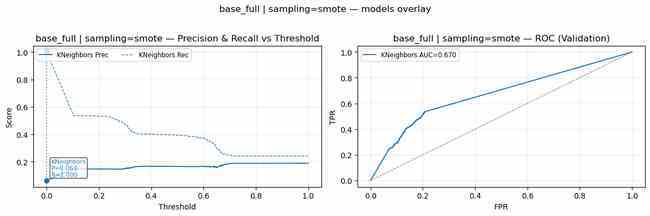


 Dataset: clean_full
Prepared dataset: Train=(55674, 20), Val=(7954, 20), Test=(15907, 20), Features=20, mode=numeric_only
  ◦ Sampling: smote
    KNeighbors: thr=0.000 ValRec₁=1.000 ValPrec₁=0.061 ValAUC₁=0.672


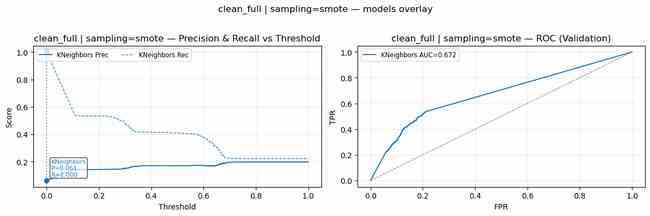


 Dataset: base_reduced
Prepared dataset: Train=(55896, 16), Val=(7986, 16), Test=(15971, 16), Features=16, mode=numeric_only
  ◦ Sampling: smote
    KNeighbors: thr=0.000 ValRec₁=1.000 ValPrec₁=0.063 ValAUC₁=0.666


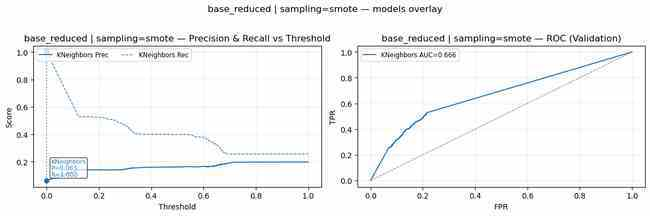


 Dataset: clean_reduced
Prepared dataset: Train=(55674, 16), Val=(7954, 16), Test=(15907, 16), Features=16, mode=numeric_only
  ◦ Sampling: smote
    KNeighbors: thr=0.000 ValRec₁=1.000 ValPrec₁=0.061 ValAUC₁=0.670


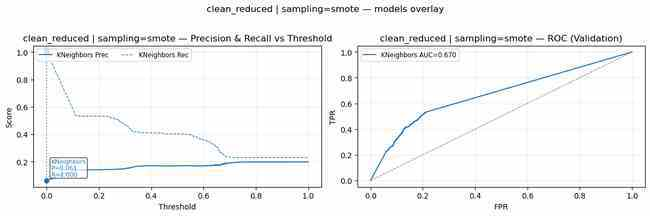


 Dataset: base_reduced_no_cat
Prepared dataset: Train=(55896, 10), Val=(7986, 10), Test=(15971, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    KNeighbors: thr=0.000 ValRec₁=1.000 ValPrec₁=0.063 ValAUC₁=0.676


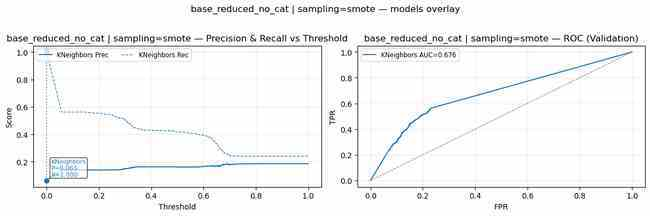


 Dataset: clean_reduced_no_cat
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    KNeighbors: thr=0.000 ValRec₁=1.000 ValPrec₁=0.061 ValAUC₁=0.684


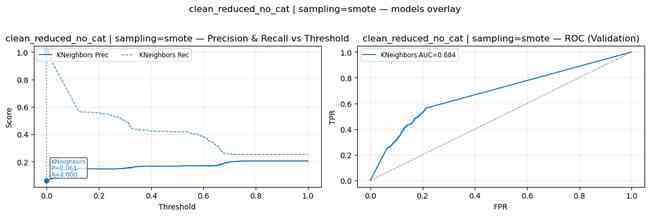


 Dataset: base_reduced_no_cat_raw
Prepared dataset: Train=(55896, 9), Val=(7986, 9), Test=(15971, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    KNeighbors: thr=0.000 ValRec₁=1.000 ValPrec₁=0.063 ValAUC₁=0.682


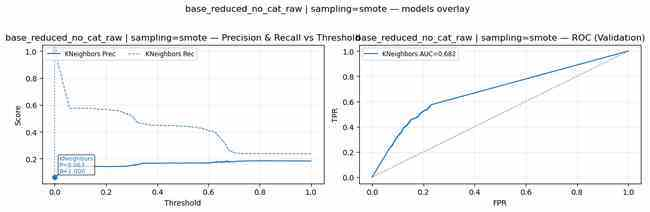


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    KNeighbors: thr=0.000 ValRec₁=1.000 ValPrec₁=0.061 ValAUC₁=0.692


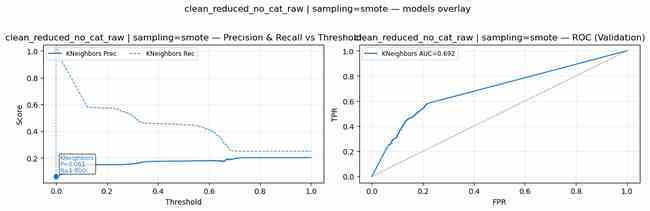


 Dataset: base_topcorr_only
Prepared dataset: Train=(55896, 4), Val=(7986, 4), Test=(15971, 4), Features=4, mode=numeric_only
  ◦ Sampling: smote
    KNeighbors: thr=0.000 ValRec₁=1.000 ValPrec₁=0.063 ValAUC₁=0.683


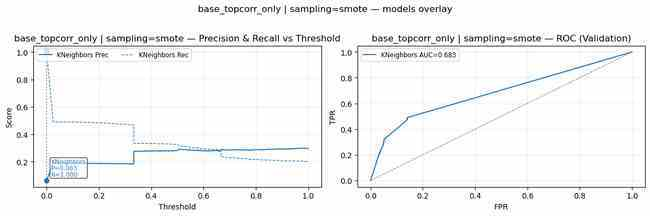


 Dataset: clean_topcorr_only
Prepared dataset: Train=(55674, 4), Val=(7954, 4), Test=(15907, 4), Features=4, mode=numeric_only
  ◦ Sampling: smote
    KNeighbors: thr=0.000 ValRec₁=1.000 ValPrec₁=0.061 ValAUC₁=0.687


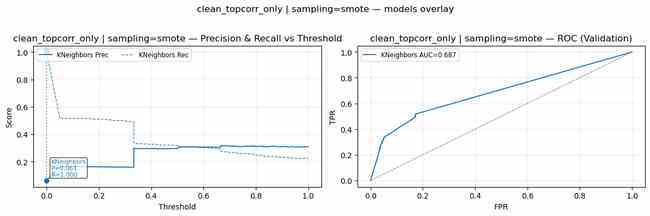


=== KNeighbors (recall=0.8) Summary ===


dataset       model sampling_method tuning_mode  \
0                 base_full  KNeighbors           smote      recall   
1                clean_full  KNeighbors           smote      recall   
2              base_reduced  KNeighbors           smote      recall   
3             clean_reduced  KNeighbors           smote      recall   
4       base_reduced_no_cat  KNeighbors           smote      recall   
5      clean_reduced_no_cat  KNeighbors           smote      recall   
6   base_reduced_no_cat_raw  KNeighbors           smote      recall   
7  clean_reduced_no_cat_raw  KNeighbors           smote      recall   
8         base_topcorr_only  KNeighbors           smote      recall   
9        clean_topcorr_only  KNeighbors           smote      recall   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8             0.0     0.0626       1.0    0.1178    0.6702   
1            0.8             0.0     0.0610       1.0    0.1149    0.6723   
2            0.8             0.0     0.0626       1.0    0.1178    0.6656   
3            0.8             0.0     0.0610       1.0    0.1149    0.6703   
4            0.8             0.0     0.0626       1.0    0.1178    0.6762   
5            0.8             0.0     0.0610       1.0    0.1149    0.6837   
6            0.8             0.0     0.0626       1.0    0.1178    0.6823   
7            0.8             0.0     0.0610       1.0    0.1149    0.6918   
8            0.8             0.0     0.0626       1.0    0.1178    0.6835   
9            0.8             0.0     0.0610       1.0    0.1149    0.6871   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.0626        1.0     0.1178     0.6948  
1      0.0610        1.0     0.1149     0.6805  
2      0.0626        1.0     0.1178     0.6926  
3      0.0610        1.0     0.1149     0.6872  
4      0.0626        1.0     0.1178     0.6977  
5      0.0610        1.0     0.1149     0.6884  
6      0.0626        1.0     0.1178     0.6976  
7      0.0610        1.0     0.1149     0.6901  
8      0.0626        1.0     0.1178     0.6829  
9      0.0610        1.0     0.1149     0.6863

In [124]:
df_knn, store_knn = run_knn_pipeline(datasets, sampling_method="smote", search_type="random", n_iter=16, show_plot=True)



 Dataset: base_full
Prepared dataset: Train=(55896, 20), Val=(7986, 20), Test=(15971, 20), Features=20, mode=numeric_only
  ◦ Sampling: smote
    RadiusNeighbors: thr=0.000 ValRec₁=1.000 ValPrec₁=0.063 ValAUC₁=0.450


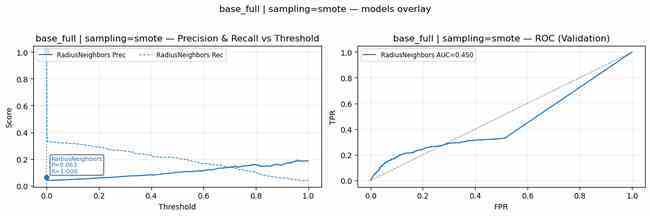


 Dataset: clean_full
Prepared dataset: Train=(55674, 20), Val=(7954, 20), Test=(15907, 20), Features=20, mode=numeric_only
  ◦ Sampling: smote
    RadiusNeighbors: thr=0.000 ValRec₁=1.000 ValPrec₁=0.061 ValAUC₁=0.432


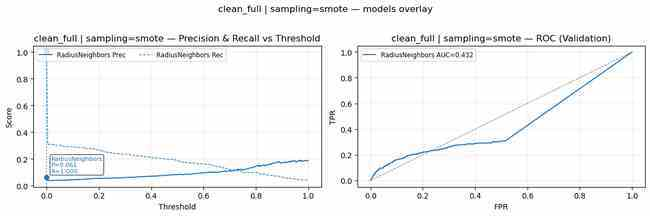


 Dataset: base_reduced
Prepared dataset: Train=(55896, 16), Val=(7986, 16), Test=(15971, 16), Features=16, mode=numeric_only
  ◦ Sampling: smote
    RadiusNeighbors: thr=0.000 ValRec₁=1.000 ValPrec₁=0.063 ValAUC₁=0.464


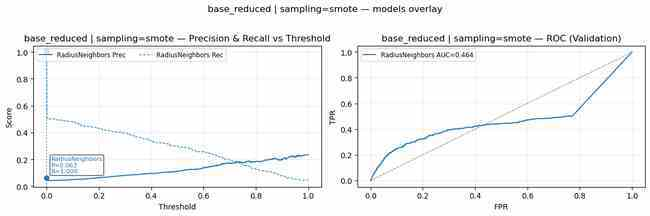


 Dataset: clean_reduced
Prepared dataset: Train=(55674, 16), Val=(7954, 16), Test=(15907, 16), Features=16, mode=numeric_only
  ◦ Sampling: smote
    RadiusNeighbors: thr=0.000 ValRec₁=1.000 ValPrec₁=0.061 ValAUC₁=0.462


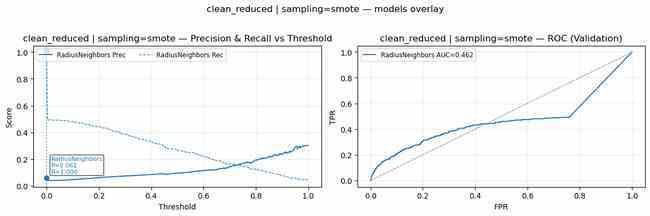


 Dataset: base_reduced_no_cat
Prepared dataset: Train=(55896, 10), Val=(7986, 10), Test=(15971, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    RadiusNeighbors: thr=0.000 ValRec₁=1.000 ValPrec₁=0.063 ValAUC₁=0.604


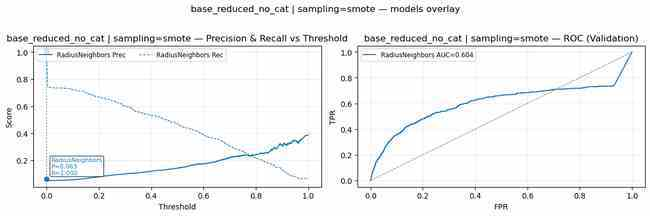


 Dataset: clean_reduced_no_cat
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    RadiusNeighbors: thr=0.000 ValRec₁=1.000 ValPrec₁=0.061 ValAUC₁=0.608


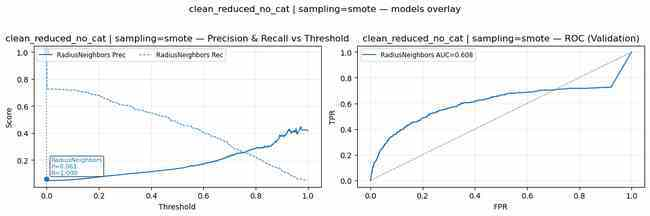


 Dataset: base_reduced_no_cat_raw
Prepared dataset: Train=(55896, 9), Val=(7986, 9), Test=(15971, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    RadiusNeighbors: thr=0.000 ValRec₁=1.000 ValPrec₁=0.063 ValAUC₁=0.641


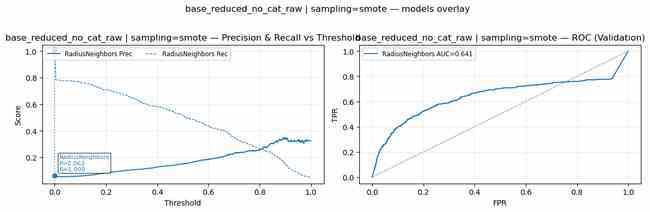


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    RadiusNeighbors: thr=0.000 ValRec₁=1.000 ValPrec₁=0.061 ValAUC₁=0.641


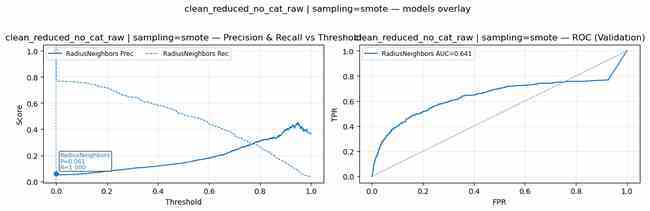


 Dataset: base_topcorr_only
Prepared dataset: Train=(55896, 4), Val=(7986, 4), Test=(15971, 4), Features=4, mode=numeric_only
  ◦ Sampling: smote
    RadiusNeighbors: thr=0.352 ValRec₁=0.804 ValPrec₁=0.131 ValAUC₁=0.797


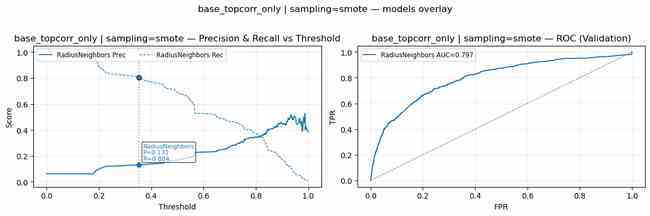


 Dataset: clean_topcorr_only
Prepared dataset: Train=(55674, 4), Val=(7954, 4), Test=(15907, 4), Features=4, mode=numeric_only
  ◦ Sampling: smote
    RadiusNeighbors: thr=0.410 ValRec₁=0.800 ValPrec₁=0.135 ValAUC₁=0.807


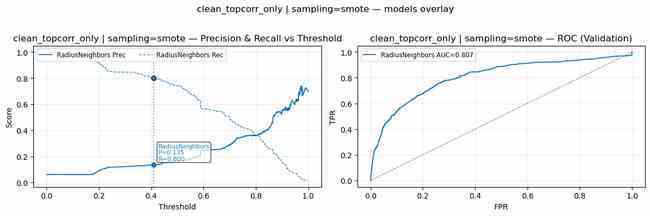


=== RadiusNeighbors (recall=0.8) Summary ===


dataset            model sampling_method tuning_mode  \
0                 base_full  RadiusNeighbors           smote      recall   
1                clean_full  RadiusNeighbors           smote      recall   
2              base_reduced  RadiusNeighbors           smote      recall   
3             clean_reduced  RadiusNeighbors           smote      recall   
4       base_reduced_no_cat  RadiusNeighbors           smote      recall   
5      clean_reduced_no_cat  RadiusNeighbors           smote      recall   
6   base_reduced_no_cat_raw  RadiusNeighbors           smote      recall   
7  clean_reduced_no_cat_raw  RadiusNeighbors           smote      recall   
8         base_topcorr_only  RadiusNeighbors           smote      recall   
9        clean_topcorr_only  RadiusNeighbors           smote      recall   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8          0.0000     0.0626     1.000    0.1178    0.4497   
1            0.8          0.0000     0.0610     1.000    0.1149    0.4320   
2            0.8          0.0000     0.0626     1.000    0.1178    0.4644   
3            0.8          0.0000     0.0610     1.000    0.1149    0.4618   
4            0.8          0.0000     0.0626     1.000    0.1178    0.6040   
5            0.8          0.0000     0.0610     1.000    0.1149    0.6080   
6            0.8          0.0000     0.0626     1.000    0.1178    0.6411   
7            0.8          0.0000     0.0610     1.000    0.1149    0.6413   
8            0.8          0.3518     0.1312     0.804    0.2255    0.7974   
9            0.8          0.4097     0.1350     0.800    0.2310    0.8069   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.0626     1.0000     0.1178     0.4330  
1      0.0610     1.0000     0.1149     0.4320  
2      0.0626     1.0000     0.1178     0.4696  
3      0.0610     1.0000     0.1149     0.4756  
4      0.0626     1.0000     0.1178     0.5960  
5      0.0610     1.0000     0.1149     0.6157  
6      0.0626     1.0000     0.1178     0.6447  
7      0.0610     1.0000     0.1149     0.6649  
8      0.1343     0.8250     0.2310     0.8106  
9      0.1368     0.7928     0.2334     0.8053

In [125]:
df_rad, store_rad = run_radius_neighbors_pipeline(datasets, sampling_method="smote", show_plot=True)



 Dataset: base_full
Prepared dataset: Train=(55896, 20), Val=(7986, 20), Test=(15971, 20), Features=20, mode=numeric_only
  ◦ Sampling: smote
    NearestCentroid: thr=0.414 ValRec₁=0.800 ValPrec₁=0.132 ValAUC₁=0.800


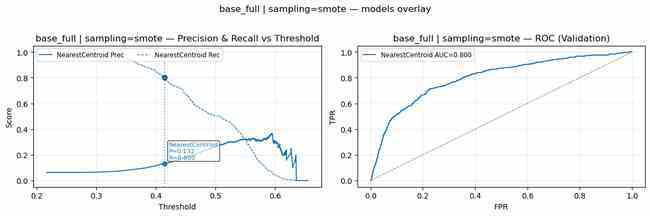


 Dataset: clean_full
Prepared dataset: Train=(55674, 20), Val=(7954, 20), Test=(15907, 20), Features=20, mode=numeric_only
  ◦ Sampling: smote
    NearestCentroid: thr=0.415 ValRec₁=0.800 ValPrec₁=0.132 ValAUC₁=0.805


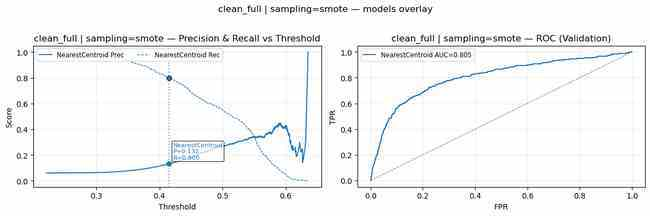


 Dataset: base_reduced
Prepared dataset: Train=(55896, 16), Val=(7986, 16), Test=(15971, 16), Features=16, mode=numeric_only
  ◦ Sampling: smote
    NearestCentroid: thr=0.419 ValRec₁=0.800 ValPrec₁=0.147 ValAUC₁=0.807


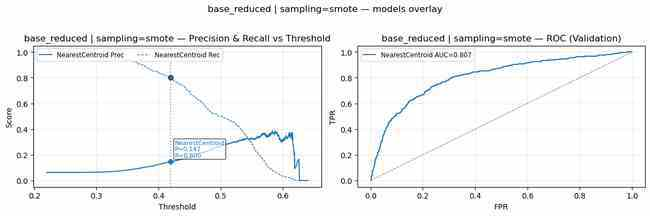


 Dataset: clean_reduced
Prepared dataset: Train=(55674, 16), Val=(7954, 16), Test=(15907, 16), Features=16, mode=numeric_only
  ◦ Sampling: smote
    NearestCentroid: thr=0.418 ValRec₁=0.800 ValPrec₁=0.143 ValAUC₁=0.811


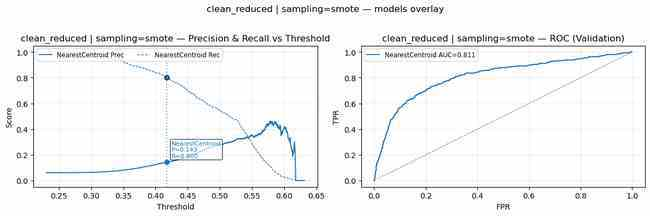


 Dataset: base_reduced_no_cat
Prepared dataset: Train=(55896, 10), Val=(7986, 10), Test=(15971, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    NearestCentroid: thr=0.406 ValRec₁=0.800 ValPrec₁=0.140 ValAUC₁=0.803


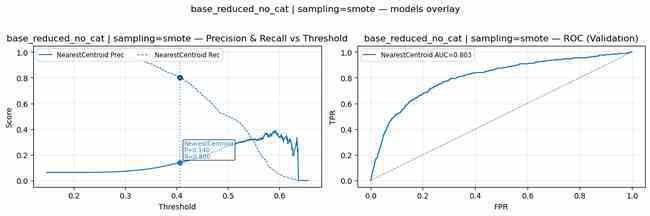


 Dataset: clean_reduced_no_cat
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    NearestCentroid: thr=0.407 ValRec₁=0.800 ValPrec₁=0.140 ValAUC₁=0.808


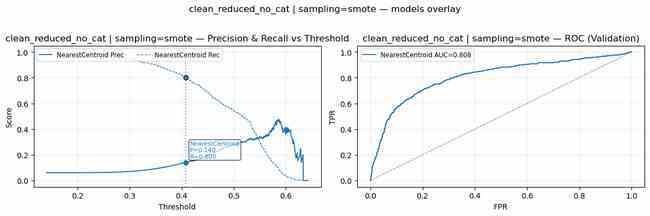


 Dataset: base_reduced_no_cat_raw
Prepared dataset: Train=(55896, 9), Val=(7986, 9), Test=(15971, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    NearestCentroid: thr=0.436 ValRec₁=0.800 ValPrec₁=0.152 ValAUC₁=0.808


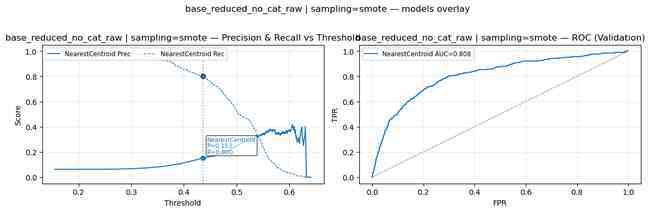


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    NearestCentroid: thr=0.438 ValRec₁=0.800 ValPrec₁=0.149 ValAUC₁=0.814


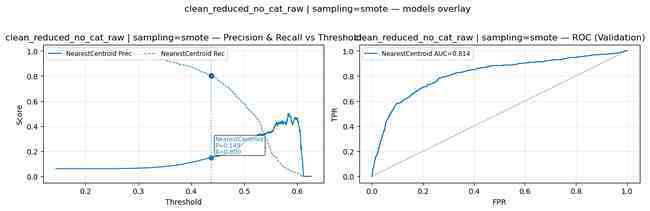


 Dataset: base_topcorr_only
Prepared dataset: Train=(55896, 4), Val=(7986, 4), Test=(15971, 4), Features=4, mode=numeric_only
  ◦ Sampling: smote
    NearestCentroid: thr=0.253 ValRec₁=0.800 ValPrec₁=0.136 ValAUC₁=0.776


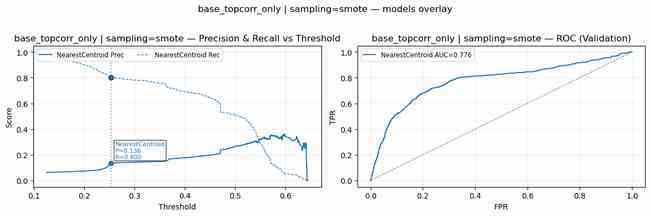


 Dataset: clean_topcorr_only
Prepared dataset: Train=(55674, 4), Val=(7954, 4), Test=(15907, 4), Features=4, mode=numeric_only
  ◦ Sampling: smote
    NearestCentroid: thr=0.337 ValRec₁=0.802 ValPrec₁=0.147 ValAUC₁=0.804


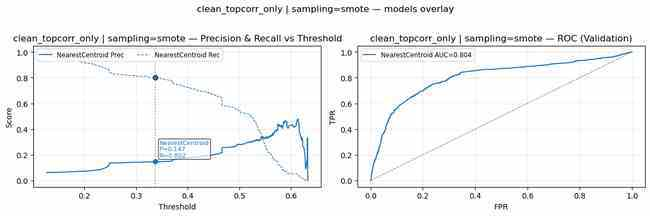


=== NearestCentroid (recall=0.8) Summary ===


dataset            model sampling_method tuning_mode  \
9        clean_topcorr_only  NearestCentroid           smote      recall   
0                 base_full  NearestCentroid           smote      recall   
1                clean_full  NearestCentroid           smote      recall   
2              base_reduced  NearestCentroid           smote      recall   
3             clean_reduced  NearestCentroid           smote      recall   
4       base_reduced_no_cat  NearestCentroid           smote      recall   
5      clean_reduced_no_cat  NearestCentroid           smote      recall   
6   base_reduced_no_cat_raw  NearestCentroid           smote      recall   
7  clean_reduced_no_cat_raw  NearestCentroid           smote      recall   
8         base_topcorr_only  NearestCentroid           smote      recall   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
9            0.8          0.3370     0.1466    0.8021    0.2478    0.8042   
0            0.8          0.4144     0.1316    0.8000    0.2260    0.7995   
1            0.8          0.4146     0.1315    0.8000    0.2259    0.8047   
2            0.8          0.4191     0.1473    0.8000    0.2488    0.8075   
3            0.8          0.4179     0.1430    0.8000    0.2427    0.8115   
4            0.8          0.4058     0.1402    0.8000    0.2386    0.8034   
5            0.8          0.4075     0.1404    0.8000    0.2389    0.8084   
6            0.8          0.4361     0.1521    0.8000    0.2557    0.8084   
7            0.8          0.4376     0.1489    0.8000    0.2511    0.8137   
8            0.8          0.2527     0.1361    0.8000    0.2326    0.7758   

   test_prec1  test_rec1  test_f1_1  test_roc1  
9      0.1481     0.7866     0.2493     0.7958  
0      0.1335     0.8130     0.2293     0.8045  
1      0.1325     0.7959     0.2272     0.8018  
2      0.1468     0.8010     0.2482     0.8157  
3      0.1446     0.7845     0.2442     0.8134  
4      0.1411     0.8090     0.2403     0.8113  
5      0.1428     0.7897     0.2419     0.8106  
6      0.1514     0.8010     0.2547     0.8177  
7      0.1513     0.7845     0.2537     0.8158  
8      0.1411     0.8340     0.2414     0.8025

In [126]:
df_nc, store_nc = run_nearest_centroid_pipeline(datasets, sampling_method="smote", show_plot=True)


### Tree-Based Classifier Pipeline (Decision Tree)

The following pipeline evaluates a **Decision Tree Classifier** under the same experimental framework used for the distance-based models. Decision Trees split the feature space into axis-aligned regions based on impurity reduction, allowing non-linear and interpretable decision boundaries. Because tree depth, minimum samples leaves, and splitting criteria strongly influence generalization, the pipeline supports optional **hyperparameter search** to tune the tree for better precision/recall performance.

This pipeline also integrates:
- **Class imbalance handling** (via the same unified resampling toolkit: random under/over sampling, SMOTE, ADASYN, etc.)
- **Validation-based threshold tuning** (`recall`, `precision`, or `max_f1`)
- **PR/ROC visualization** for operating-point transparency
- **Consistent train/val/test splits** for comparability across datasets

**Why this function exists:**  
To systematically measure how **interpretable, rule-based decision boundaries** perform relative to distance-based models on the same datasets, especially in terms of **minority-class recall vs. false-alert trade-offs**, after resampling and threshold adjustment.


In [215]:
# --------------------------
# Decision Tree pipeline (unified sampling_method)
# --------------------------
def run_decision_tree_pipeline_tuned(
    datasets,
    sampling_method="none",
    sampling_methods: list = None,
    tuning_mode="recall",
    tuning_target=0.8,
    val_size=0.1,
    test_size=0.2,
    search_type=None,
    param_grid=None,
    n_iter=24,
    cv=3,
    scoring="f1",
    show_plot=True,
    random_state=SEED
):
    """
    DecisionTree pipeline with unified sampling_method:
      - sampling_method == "builtin" -> class_weight='balanced' used
      - otherwise -> resample_train(...) when method != "none"
    """
    methods_to_run = _normalize_methods(sampling_method, sampling_methods)
    model_store_out = {}
    rows = []

    default_grid = {
        "criterion": ["gini", "entropy"],
        "max_depth": [None, 5, 10, 20],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    }
    grid = param_grid if param_grid is not None else default_grid

    for ds_name, df in datasets.items():
        print(f"\n Dataset: {ds_name}")
        try:
            prep = prepare_dataset_df(df, target=TARGET, test_size=test_size, val_size=val_size,
                                      random_state=random_state, scale_mode="numeric_only")
            X_train_df = prep["X_train_df"]; y_train = prep["y_train"]
            X_val_df   = prep["X_val_df"];   y_val   = prep["y_val"]
            X_test_df  = prep["X_test_df"];  y_test  = prep["y_test"]

            model_store_out[ds_name] = {}

            for method in methods_to_run:
                print(f"  ◦ Sampling: {method}")
                use_builtin = str(method).lower() in ("builtin", "class_weight", "balanced", "xgb_builtin")
                if use_builtin:
                    X_tr_use, y_tr_use = X_train_df.copy(), y_train.copy()
                elif str(method).lower() in ("none", "passthrough", "raw"):
                    X_tr_use, y_tr_use = X_train_df.copy(), y_train.copy()
                else:
                    X_tr_use, y_tr_use = resample_train(X_train_df, y_train, method=method, random_state=random_state)

                # instantiate and optionally search (class_weight balanced if builtin)
                class_w = "balanced" if use_builtin else None
                base = DecisionTreeClassifier(class_weight=class_w, random_state=random_state)
                best_est, search_obj = _fit_model_with_search(base, param_grid=grid, X=X_tr_use, y=y_tr_use,
                                                             search_type=search_type, n_iter=n_iter, cv=cv,
                                                             scoring=scoring, random_state=random_state, n_jobs=-1)

                # scores
                y_train_prob = safe_predict_scores(best_est, X_tr_use)
                y_val_prob   = safe_predict_scores(best_est, X_val_df)
                y_test_prob  = safe_predict_scores(best_est, X_test_df)

                # threshold choice
                if tuning_mode == "recall":
                    thr, thr_info = choose_threshold_for_recall_from_scores(y_val, y_val_prob, target_recall=tuning_target)
                elif tuning_mode == "precision":
                    thr, thr_info = choose_threshold_for_precision_from_scores(y_val, y_val_prob, target_precision=tuning_target)
                elif tuning_mode == "max_f1":
                    thr, thr_info = choose_threshold_max_f1_from_scores(y_val, y_val_prob)
                else:
                    thr, thr_info = 0.5, {"mode":"none"}

                m_train = compute_metrics_from_probs(y_tr_use, y_train_prob, threshold=thr)
                m_val   = compute_metrics_from_probs(y_val,    y_val_prob,   threshold=thr)
                m_test  = compute_metrics_from_probs(y_test,   y_test_prob,  threshold=thr)

                model_store_out[ds_name].setdefault(method, {})["DecisionTree"] = {
                    "model": best_est, "search": search_obj,
                    "scores": {"train": y_train_prob, "val": y_val_prob, "test": y_test_prob},
                    "threshold": float(thr), "threshold_info": thr_info,
                    "metrics": {"train": m_train, "val": m_val, "test": m_test},
                    "resampling": method, "use_builtin": use_builtin
                }

                rows.append({
                    "dataset": ds_name, "model": "DecisionTree", "sampling_method": method,
                    "tuning_mode": tuning_mode, "tuning_target": tuning_target,
                    "threshold_used": float(thr),
                    "val_prec1": m_val["precision_by_class"][1], "val_rec1": m_val["recall_by_class"][1],
                    "val_f1_1": m_val["f1_by_class"][1], "val_roc1": m_val["roc_auc_class1"],
                    "test_prec1": m_test["precision_by_class"][1], "test_rec1": m_test["recall_by_class"][1],
                    "test_f1_1": m_test["f1_by_class"][1], "test_roc1": m_test["roc_auc_class1"]
                })

                print(f"    DecisionTree: thr={thr:.3f} ValRec₁={m_val['recall_by_class'][1]:.3f} ValPrec₁={m_val['precision_by_class'][1]:.3f}")

                if show_plot:
                    try:
                        _plot_pr_roc_inline(y_val, {"DecisionTree": y_val_prob}, {"DecisionTree": thr}, dataset_name=f"{ds_name} | {method}", show=True)
                    except Exception as e_plot:
                        print(f"     plotting failed for {ds_name} (DecisionTree): {e_plot}")

        except Exception as e:
            print(f"   Error processing {ds_name}: {e}")

    df_summary = pd.DataFrame(rows)
    if not df_summary.empty:
        key = "val_prec1" if tuning_mode == "precision" else "val_rec1"
        df_summary = df_summary.round(4).sort_values(by=key, ascending=False)
        print(f"\n=== DecisionTree ({tuning_mode}={tuning_target}) Summary ===")
        display(df_summary)
    else:
        print("No results generated.")
    return df_summary, model_store_out

### Ensemble Tree-Based Classifier Pipeline (Random Forest)

This pipeline evaluates a **Random Forest Classifier**, which is an ensemble of decision trees trained with bootstrap sampling and feature randomness. Random Forests typically provide stronger generalization than a single decision tree by reducing variance and stabilizing predictions across different dataset variations.

The pipeline supports:
- **Class Imbalance Handling:** Uses the same unified resampling layer (e.g., random under/over sampling, SMOTE, ADASYN, ENN, VAE-based synthesis).
- **Hyperparameter Search (optional):** When enabled, `search_type="random"` or `"grid"` tunes parameters such as number of trees, max depth, and leaf size to improve recall/precision balance.
- **Threshold Tuning:** Adjusts the decision cutoff using validation scores to target a desired recall, precision, or maximum F1 operating point.
- **Consistent Evaluation:** Produces PR and ROC curves and reports per-split minority-class metrics for direct comparison across datasets.

**Why this function exists:**  
To benchmark how **ensemble-based non-linear decision boundaries** compare to single-tree models and distance-based models when combined with the same resampling and threshold tuning strategies. This highlights whether **variance reduction through ensembling** leads to more stable and reliable minority-class performance across datasets.


In [218]:
# --------------------------
# Random Forest pipeline (unified sampling_method)
# --------------------------
def run_random_forest_pipeline_tuned(
    datasets,
    sampling_method="none",
    sampling_methods: list = None,
    tuning_mode="recall",
    tuning_target=0.8,
    val_size=0.1,
    test_size=0.2,
    search_type=None,
    param_grid=None,
    n_iter=24,
    cv=3,
    scoring="f1",
    show_plot=True,
    random_state=SEED
):
    """
    RandomForest pipeline with unified sampling_method:
      - sampling_method == "builtin" -> class_weight='balanced'
      - otherwise -> resample_train(...) when method != "none"
    """
    methods_to_run = _normalize_methods(sampling_method, sampling_methods)
    model_store_out = {}
    rows = []

    default_grid = {
        "n_estimators": [100,200,400],
        "max_depth": [None, 6, 10],
        "min_samples_leaf": [1,2,4],
        "max_features": ["sqrt", "log2", None]
    }
    grid = param_grid if param_grid is not None else default_grid

    for ds_name, df in datasets.items():
        print(f"\n Dataset: {ds_name}")
        try:
            prep = prepare_dataset_df(df, target=TARGET, test_size=test_size, val_size=val_size,
                                      random_state=random_state, scale_mode="numeric_only")
            X_train_df = prep["X_train_df"]; y_train = prep["y_train"]
            X_val_df   = prep["X_val_df"];   y_val   = prep["y_val"]
            X_test_df  = prep["X_test_df"];  y_test  = prep["y_test"]

            model_store_out[ds_name] = {}

            for method in methods_to_run:
                print(f"  ◦ Sampling: {method}")
                use_builtin = str(method).lower() in ("builtin", "class_weight", "balanced", "xgb_builtin")
                if use_builtin:
                    X_tr_use, y_tr_use = X_train_df.copy(), y_train.copy()
                elif str(method).lower() in ("none", "passthrough", "raw"):
                    X_tr_use, y_tr_use = X_train_df.copy(), y_train.copy()
                else:
                    X_tr_use, y_tr_use = resample_train(X_train_df, y_train, method=method, random_state=random_state)

                class_w = "balanced" if use_builtin else None
                base = RandomForestClassifier(class_weight=class_w, n_jobs=-1, random_state=random_state)
                best_est, search_obj = _fit_model_with_search(base, param_grid=grid, X=X_tr_use, y=y_tr_use,
                                                             search_type=search_type, n_iter=n_iter, cv=cv,
                                                             scoring=scoring, random_state=random_state, n_jobs=-1)

                y_train_prob = safe_predict_scores(best_est, X_tr_use)
                y_val_prob   = safe_predict_scores(best_est, X_val_df)
                y_test_prob  = safe_predict_scores(best_est, X_test_df)

                if tuning_mode == "recall":
                    thr, thr_info = choose_threshold_for_recall_from_scores(y_val, y_val_prob, target_recall=tuning_target)
                elif tuning_mode == "precision":
                    thr, thr_info = choose_threshold_for_precision_from_scores(y_val, y_val_prob, target_precision=tuning_target)
                elif tuning_mode == "max_f1":
                    thr, thr_info = choose_threshold_max_f1_from_scores(y_val, y_val_prob)
                else:
                    thr, thr_info = 0.5, {"mode":"none"}

                m_train = compute_metrics_from_probs(y_tr_use, y_train_prob, threshold=thr)
                m_val   = compute_metrics_from_probs(y_val,    y_val_prob,   threshold=thr)
                m_test  = compute_metrics_from_probs(y_test,   y_test_prob,  threshold=thr)

                model_store_out[ds_name].setdefault(method, {})["RandomForest"] = {
                    "model": best_est, "search": search_obj,
                    "scores": {"train": y_train_prob, "val": y_val_prob, "test": y_test_prob},
                    "threshold": float(thr), "threshold_info": thr_info,
                    "metrics": {"train": m_train, "val": m_val, "test": m_test},
                    "resampling": method, "use_builtin": use_builtin
                }

                rows.append({
                    "dataset": ds_name, "model": "RandomForest", "sampling_method": method,
                    "tuning_mode": tuning_mode, "tuning_target": tuning_target,
                    "threshold_used": float(thr),
                    "val_prec1": m_val["precision_by_class"][1], "val_rec1": m_val["recall_by_class"][1],
                    "val_f1_1": m_val["f1_by_class"][1], "val_roc1": m_val["roc_auc_class1"],
                    "test_prec1": m_test["precision_by_class"][1], "test_rec1": m_test["recall_by_class"][1],
                    "test_f1_1": m_test["f1_by_class"][1], "test_roc1": m_test["roc_auc_class1"]
                })

                print(f"    RandomForest: thr={thr:.3f} ValRec₁={m_val['recall_by_class'][1]:.3f} ValPrec₁={m_val['precision_by_class'][1]:.3f}")

                if show_plot:
                    try:
                        _plot_pr_roc_inline(y_val, {"RandomForest": y_val_prob}, {"RandomForest": thr}, dataset_name=f"{ds_name} | {method}", show=True)
                    except Exception as e_plot:
                        print(f"     plotting failed for {ds_name} (RandomForest): {e_plot}")

        except Exception as e:
            print(f"   Error processing {ds_name}: {e}")

    df_summary = pd.DataFrame(rows)
    if not df_summary.empty:
        key = "val_prec1" if tuning_mode == "precision" else "val_rec1"
        df_summary = df_summary.round(4).sort_values(by=key, ascending=False)
        print(f"\n=== RandomForest ({tuning_mode}={tuning_target}) Summary ===")
        display(df_summary)
    else:
        print("No results generated.")
    return df_summary, model_store_out


 Dataset: base_full
Prepared dataset: Train=(55896, 20), Val=(7986, 20), Test=(15971, 20), Features=20, mode=numeric_only
  ◦ Sampling: none
    DecisionTree: thr=0.000 ValRec₁=1.000 ValPrec₁=0.063


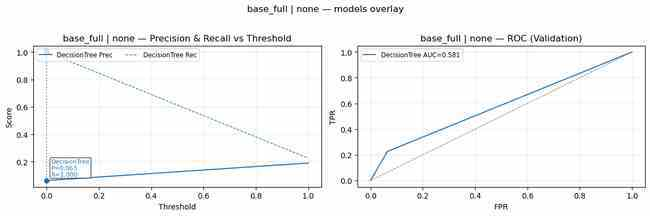


 Dataset: clean_full
Prepared dataset: Train=(55674, 20), Val=(7954, 20), Test=(15907, 20), Features=20, mode=numeric_only
  ◦ Sampling: none
    DecisionTree: thr=0.000 ValRec₁=1.000 ValPrec₁=0.061


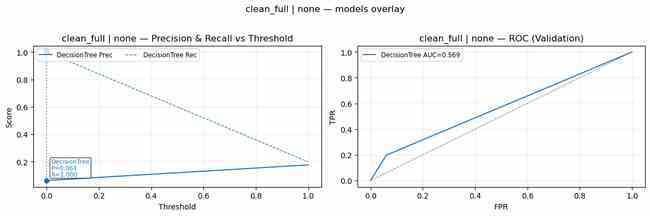


 Dataset: base_reduced
Prepared dataset: Train=(55896, 16), Val=(7986, 16), Test=(15971, 16), Features=16, mode=numeric_only
  ◦ Sampling: none
    DecisionTree: thr=0.000 ValRec₁=1.000 ValPrec₁=0.063


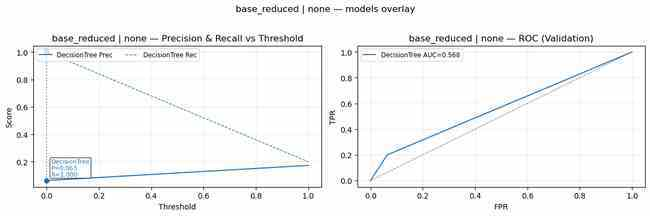


 Dataset: clean_reduced
Prepared dataset: Train=(55674, 16), Val=(7954, 16), Test=(15907, 16), Features=16, mode=numeric_only
  ◦ Sampling: none
    DecisionTree: thr=0.000 ValRec₁=1.000 ValPrec₁=0.061


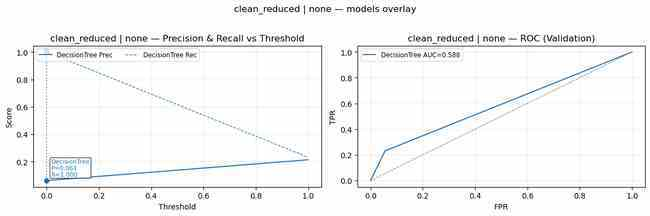


 Dataset: base_reduced_no_cat
Prepared dataset: Train=(55896, 10), Val=(7986, 10), Test=(15971, 10), Features=10, mode=numeric_only
  ◦ Sampling: none
    DecisionTree: thr=0.000 ValRec₁=1.000 ValPrec₁=0.063


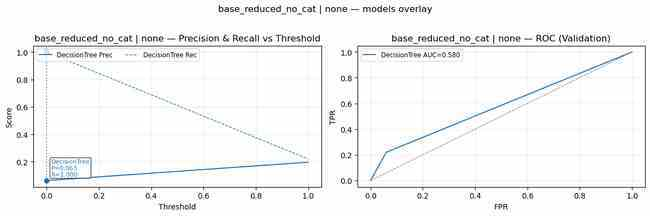


 Dataset: clean_reduced_no_cat
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: none
    DecisionTree: thr=0.000 ValRec₁=1.000 ValPrec₁=0.061


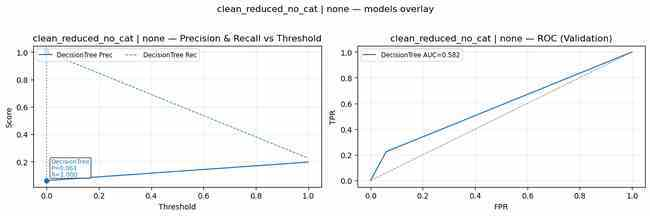


 Dataset: base_reduced_no_cat_raw
Prepared dataset: Train=(55896, 9), Val=(7986, 9), Test=(15971, 9), Features=9, mode=numeric_only
  ◦ Sampling: none
    DecisionTree: thr=0.000 ValRec₁=1.000 ValPrec₁=0.063


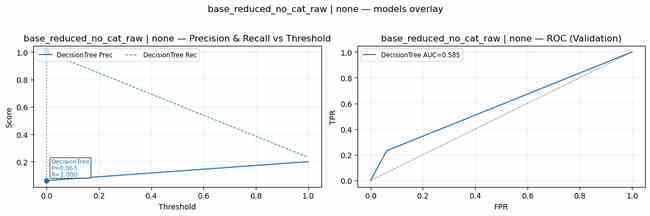


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: none
    DecisionTree: thr=0.000 ValRec₁=1.000 ValPrec₁=0.061


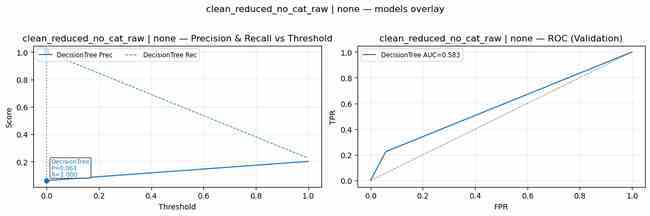


 Dataset: base_topcorr_only
Prepared dataset: Train=(55896, 4), Val=(7986, 4), Test=(15971, 4), Features=4, mode=numeric_only
  ◦ Sampling: none
    DecisionTree: thr=0.000 ValRec₁=1.000 ValPrec₁=0.063


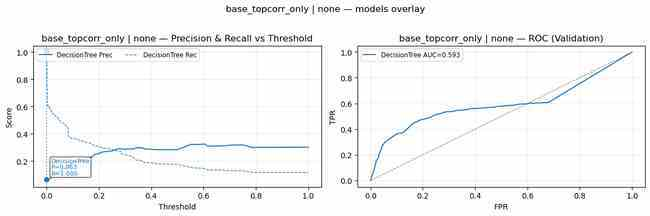


 Dataset: clean_topcorr_only
Prepared dataset: Train=(55674, 4), Val=(7954, 4), Test=(15907, 4), Features=4, mode=numeric_only
  ◦ Sampling: none
    DecisionTree: thr=0.000 ValRec₁=1.000 ValPrec₁=0.061


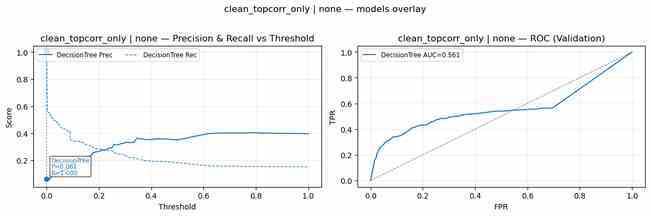


=== DecisionTree (recall=0.8) Summary ===


dataset         model sampling_method tuning_mode  \
0                 base_full  DecisionTree            none      recall   
1                clean_full  DecisionTree            none      recall   
2              base_reduced  DecisionTree            none      recall   
3             clean_reduced  DecisionTree            none      recall   
4       base_reduced_no_cat  DecisionTree            none      recall   
5      clean_reduced_no_cat  DecisionTree            none      recall   
6   base_reduced_no_cat_raw  DecisionTree            none      recall   
7  clean_reduced_no_cat_raw  DecisionTree            none      recall   
8         base_topcorr_only  DecisionTree            none      recall   
9        clean_topcorr_only  DecisionTree            none      recall   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8             0.0     0.0626       1.0    0.1178    0.5808   
1            0.8             0.0     0.0610       1.0    0.1149    0.5686   
2            0.8             0.0     0.0626       1.0    0.1178    0.5680   
3            0.8             0.0     0.0610       1.0    0.1149    0.5877   
4            0.8             0.0     0.0626       1.0    0.1178    0.5799   
5            0.8             0.0     0.0610       1.0    0.1149    0.5823   
6            0.8             0.0     0.0626       1.0    0.1178    0.5850   
7            0.8             0.0     0.0610       1.0    0.1149    0.5833   
8            0.8             0.0     0.0626       1.0    0.1178    0.5927   
9            0.8             0.0     0.0610       1.0    0.1149    0.5608   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.0626        1.0     0.1178     0.5944  
1      0.0610        1.0     0.1149     0.5809  
2      0.0626        1.0     0.1178     0.5823  
3      0.0610        1.0     0.1149     0.5925  
4      0.0626        1.0     0.1178     0.5847  
5      0.0610        1.0     0.1149     0.5786  
6      0.0626        1.0     0.1178     0.5832  
7      0.0610        1.0     0.1149     0.5886  
8      0.0626        1.0     0.1178     0.5871  
9      0.0610        1.0     0.1149     0.5896

In [131]:
# Decision Tree, no search, no resample
df_dt, store_dt = run_decision_tree_pipeline_tuned(datasets, sampling_method="none", search_type=None, show_plot=True)




 Dataset: base_full
Prepared dataset: Train=(55896, 20), Val=(7986, 20), Test=(15971, 20), Features=20, mode=numeric_only
  ◦ Sampling: smote


python(33618) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(33619) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(33620) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(33621) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(33622) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(33623) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(33624) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(33625) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(33626) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(33627) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


    RandomForest: thr=0.110 ValRec₁=0.808 ValPrec₁=0.127


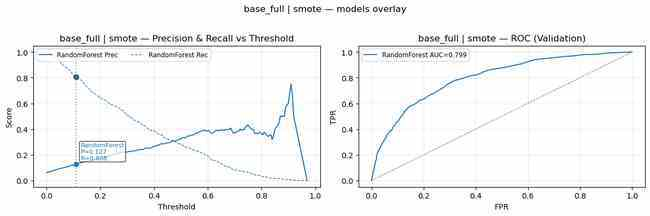


 Dataset: clean_full
Prepared dataset: Train=(55674, 20), Val=(7954, 20), Test=(15907, 20), Features=20, mode=numeric_only
  ◦ Sampling: smote
    RandomForest: thr=0.115 ValRec₁=0.804 ValPrec₁=0.127


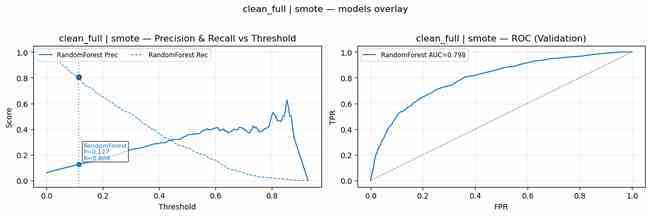


 Dataset: base_reduced
Prepared dataset: Train=(55896, 16), Val=(7986, 16), Test=(15971, 16), Features=16, mode=numeric_only
  ◦ Sampling: smote
    RandomForest: thr=0.115 ValRec₁=0.808 ValPrec₁=0.130


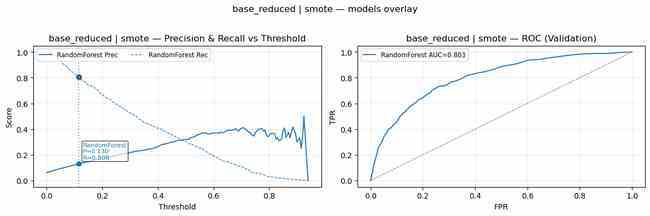


 Dataset: clean_reduced
Prepared dataset: Train=(55674, 16), Val=(7954, 16), Test=(15907, 16), Features=16, mode=numeric_only
  ◦ Sampling: smote
    RandomForest: thr=0.115 ValRec₁=0.812 ValPrec₁=0.124


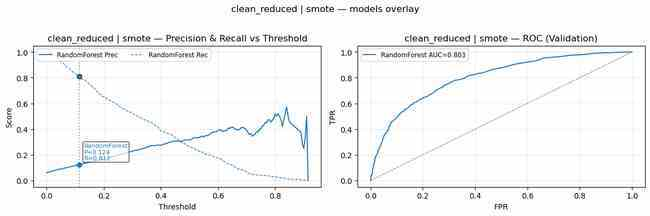


 Dataset: base_reduced_no_cat
Prepared dataset: Train=(55896, 10), Val=(7986, 10), Test=(15971, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    RandomForest: thr=0.115 ValRec₁=0.802 ValPrec₁=0.133


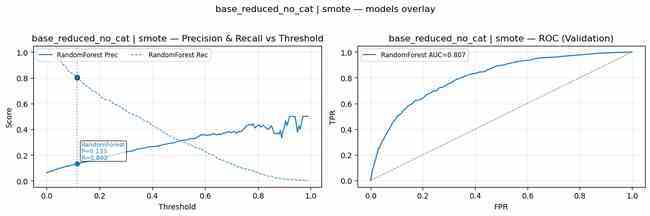


 Dataset: clean_reduced_no_cat
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    RandomForest: thr=0.105 ValRec₁=0.802 ValPrec₁=0.123


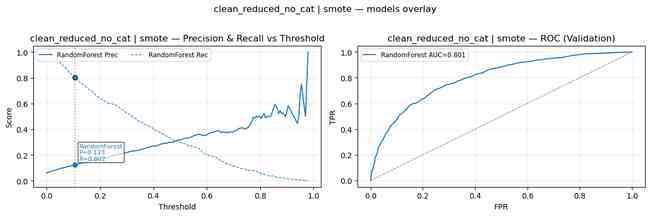


 Dataset: base_reduced_no_cat_raw
Prepared dataset: Train=(55896, 9), Val=(7986, 9), Test=(15971, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    RandomForest: thr=0.110 ValRec₁=0.800 ValPrec₁=0.130


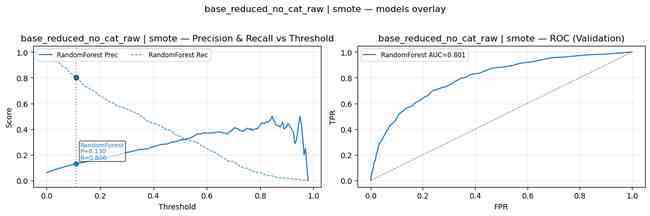


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    RandomForest: thr=0.110 ValRec₁=0.802 ValPrec₁=0.126


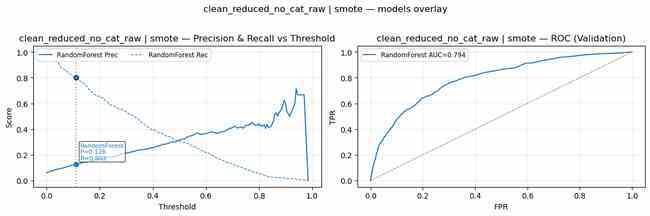


 Dataset: base_topcorr_only
Prepared dataset: Train=(55896, 4), Val=(7986, 4), Test=(15971, 4), Features=4, mode=numeric_only
  ◦ Sampling: smote
    RandomForest: thr=0.047 ValRec₁=0.806 ValPrec₁=0.089


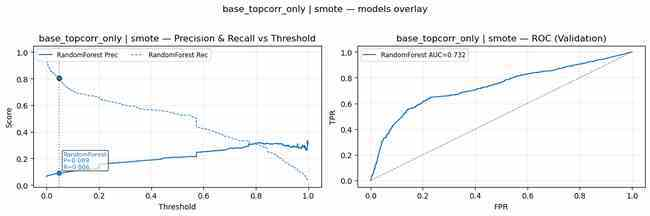


 Dataset: clean_topcorr_only
Prepared dataset: Train=(55674, 4), Val=(7954, 4), Test=(15907, 4), Features=4, mode=numeric_only
  ◦ Sampling: smote
    RandomForest: thr=0.052 ValRec₁=0.800 ValPrec₁=0.089


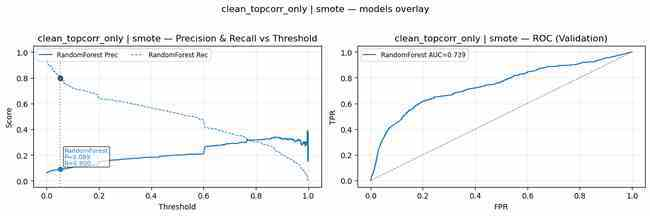


=== RandomForest (recall=0.8) Summary ===


dataset         model sampling_method tuning_mode  \
3             clean_reduced  RandomForest           smote      recall   
0                 base_full  RandomForest           smote      recall   
2              base_reduced  RandomForest           smote      recall   
8         base_topcorr_only  RandomForest           smote      recall   
1                clean_full  RandomForest           smote      recall   
5      clean_reduced_no_cat  RandomForest           smote      recall   
7  clean_reduced_no_cat_raw  RandomForest           smote      recall   
4       base_reduced_no_cat  RandomForest           smote      recall   
6   base_reduced_no_cat_raw  RandomForest           smote      recall   
9        clean_topcorr_only  RandomForest           smote      recall   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
3            0.8          0.1150     0.1245    0.8124    0.2159    0.8028   
0            0.8          0.1100     0.1273    0.8080    0.2200    0.7990   
2            0.8          0.1150     0.1301    0.8080    0.2241    0.8035   
8            0.8          0.0467     0.0894    0.8060    0.1609    0.7319   
1            0.8          0.1150     0.1268    0.8041    0.2191    0.7985   
5            0.8          0.1050     0.1228    0.8021    0.2130    0.8013   
7            0.8          0.1100     0.1264    0.8021    0.2184    0.7943   
4            0.8          0.1150     0.1330    0.8020    0.2282    0.8069   
6            0.8          0.1100     0.1303    0.8000    0.2241    0.8008   
9            0.8          0.0516     0.0888    0.8000    0.1598    0.7394   

   test_prec1  test_rec1  test_f1_1  test_roc1  
3      0.1243     0.8082     0.2155     0.8078  
0      0.1330     0.8210     0.2289     0.8177  
2      0.1339     0.8170     0.2301     0.8169  
8      0.0919     0.8200     0.1653     0.7490  
1      0.1260     0.8010     0.2177     0.8083  
5      0.1242     0.8093     0.2154     0.8011  
7      0.1264     0.8010     0.2183     0.8031  
4      0.1344     0.7920     0.2298     0.8063  
6      0.1322     0.8050     0.2271     0.8035  
9      0.0912     0.8082     0.1639     0.7457

In [132]:
# Random Forest, randomized search (short)
df_rf, store_rf = run_random_forest_pipeline_tuned(datasets, sampling_method="smote", search_type="random", n_iter=12, show_plot=True)


### Polynomial Logistic Regression Pipeline

This pipeline evaluates **Logistic Regression with polynomial feature expansion**, allowing the model to represent non-linear relationships while still maintaining a convex optimization framework. By expanding the input features to higher-order polynomial terms (e.g., degree 2 or 3), the model can approximate curved decision boundaries rather than the strictly linear boundaries of standard logistic regression.

The pipeline includes:
- **Degree Sweeps (`degrees=(1,2,3)`):** Allows comparison between purely linear decision boundaries (degree=1) and increasingly flexible non-linear models (degree ≥ 2).
- **Class Imbalance Handling:** Fully integrated with the unified resampling toolkit (random under/over-sampling, SMOTE, ADASYN, SMOTE-Tomek, ENN, VAE-based synthesis).
- **Hyperparameter Search (optional):** Can apply grid or randomized search to the logistic model parameters.
- **Threshold Tuning:** Supports recall-based tuning, precision-based tuning, or maximizing F1 to determine the operating point on validation data.
- **Safety Controls:** Includes `max_feature_expansion` to prevent memory blow-up when polynomial degree substantially increases feature count.

**Why this function exists:**  
To compare **linear vs. non-linear logistic models** under the same resampling and validation framework, and evaluate whether introducing controlled polynomial interactions improves minority-class recall and overall model stability across datasets—without jumping directly to more complex non-linear models like Random Forests or Boosting.


In [220]:
def run_logistic_poly_pipeline(
    datasets,
    degrees=(1,2,3),
    sampling_method="none",
    sampling_methods: list = None,
    tuning_mode="recall",      # "recall" | "precision" | "max_f1" | "none"
    tuning_target=0.6,
    val_size=0.1,
    test_size=0.2,
    search_type=None,             # "random" | "grid" | None
    param_grid=None,              # grid for LogisticRegression (applied to LR only)
    n_iter=24,
    cv=3,
    scoring="f1",
    show_plot=True,
    max_feature_expansion=200000,
    random_state=SEED,
    reuse_models_dict=None
):
    """
    LogisticRegression with PolynomialFeatures, unified sampling_method:
      - "none"        -> no resampling
      - "builtin"     -> use class_weight='balanced' (no resample)
      - other methods -> use resample_train(..., method=...)
    Returns: df_summary, model_store_out
    """
    methods_to_run = _normalize_methods(sampling_method, sampling_methods)
    model_store_out = {}
    rows = []

    default_grid = {"C": [0.01, 0.1, 1, 10], "penalty": ["l2"]}
    grid = param_grid if param_grid is not None else default_grid

    for ds_name, df in datasets.items():
        print(f"\n Dataset: {ds_name}")
        try:
            prep = prepare_dataset_df(df, target=TARGET, test_size=test_size, val_size=val_size,
                                      random_state=random_state, scale_mode="numeric_only")
            X_train_df = prep["X_train_df"]; y_train = prep["y_train"]
            X_val_df   = prep["X_val_df"];   y_val   = prep["y_val"]
            X_test_df  = prep["X_test_df"];  y_test  = prep["y_test"]

            model_store_out.setdefault(ds_name, {})

            for method in methods_to_run:
                print(f"  ◦ Sampling: {method}")
                use_builtin = str(method).lower() in ("builtin", "class_weight", "balanced", "xgb_builtin")
                if use_builtin:
                    # don't resample; use original train
                    X_tr_use, y_tr_use = X_train_df.copy(), y_train.copy()
                elif str(method).lower() in ("none", "passthrough", "raw"):
                    X_tr_use, y_tr_use = X_train_df.copy(), y_train.copy()
                else:
                    X_tr_use, y_tr_use = resample_train(X_train_df, y_train, method=method, random_state=random_state)

                model_store_out[ds_name].setdefault(method, {})

                if show_plot:
                    fig, (ax_pr, ax_roc) = plt.subplots(1,2, figsize=(12,4))
                    ax_pr.set_title(f"{ds_name} | sampling={method} — Precision & Recall vs Threshold")
                    ax_pr.set_xlabel("Threshold"); ax_pr.set_ylabel("Precision / Recall")
                    ax_roc.set_title(f"{ds_name} | sampling={method} — ROC (Validation)")
                    ax_roc.set_xlabel("FPR"); ax_roc.set_ylabel("TPR")

                for deg in degrees:
                    print(f"    ➤ Degree {deg}")
                    try:
                        poly = PolynomialFeatures(degree=deg, include_bias=False)
                        Xtr_poly = poly.fit_transform(X_tr_use)
                        Xval_poly = poly.transform(X_val_df)
                        Xte_poly = poly.transform(X_test_df)

                        if Xtr_poly.shape[1] > max_feature_expansion:
                            print(f"       skip degree {deg}: too many features ({Xtr_poly.shape[1]})")
                            continue

                        # class_weight applied here if builtin
                        class_w = "balanced" if use_builtin else None
                        base_lr = LogisticRegression(max_iter=2000, solver="lbfgs", random_state=random_state, class_weight=class_w)

                        best_est, search_obj = _fit_model_with_search(
                            base_lr,
                            param_grid=grid,
                            X=Xtr_poly, y=y_tr_use,
                            search_type=search_type, n_iter=n_iter, cv=cv, scoring=scoring,
                            random_state=random_state, n_jobs=-1
                        )

                        # get probs
                        try:
                            y_train_prob = best_est.predict_proba(Xtr_poly)[:,1]
                            y_val_prob   = best_est.predict_proba(Xval_poly)[:,1]
                            y_test_prob  = best_est.predict_proba(Xte_poly)[:,1]
                        except Exception:
                            # fallback to decision_function scaled
                            def _scale(a):
                                a = np.asarray(a, dtype=float)
                                mn, mx = np.nanmin(a), np.nanmax(a)
                                return (a - mn)/(mx - mn) if mx > mn else np.zeros_like(a)
                            y_train_prob = _scale(best_est.decision_function(Xtr_poly))
                            y_val_prob   = _scale(best_est.decision_function(Xval_poly))
                            y_test_prob  = _scale(best_est.decision_function(Xte_poly))

                        # threshold selection on val
                        if tuning_mode == "recall":
                            thr, thr_info = choose_threshold_for_recall_from_scores(y_val, y_val_prob, target_recall=tuning_target)
                        elif tuning_mode == "precision":
                            thr, thr_info = choose_threshold_for_precision_from_scores(y_val, y_val_prob, target_precision=tuning_target)
                        elif tuning_mode == "max_f1":
                            thr, thr_info = choose_threshold_max_f1_from_scores(y_val, y_val_prob)
                        else:
                            thr, thr_info = 0.5, {"mode":"none"}

                        m_train = compute_metrics_from_probs(y_tr_use, y_train_prob, threshold=thr)
                        m_val   = compute_metrics_from_probs(y_val,    y_val_prob,   threshold=thr)
                        m_test  = compute_metrics_from_probs(y_test,   y_test_prob,  threshold=thr)

                        key = f"LogReg_deg{deg}"
                        model_store_out[ds_name][method][key] = {
                            "model": best_est, "poly": poly, "search": search_obj,
                            "scores": {"train": y_train_prob, "val": y_val_prob, "test": y_test_prob},
                            "threshold": float(thr), "threshold_info": thr_info,
                            "metrics": {"train": m_train, "val": m_val, "test": m_test},
                            "resampling": method, "use_builtin": use_builtin
                        }

                        rows.append({
                            "dataset": ds_name, "model": "LogisticRegressionPoly", "sampling_method": method, "degree": deg,
                            "tuning_mode": tuning_mode, "tuning_target": tuning_target,
                            "threshold_used": float(thr),
                            "val_prec1": m_val["precision_by_class"][1], "val_rec1": m_val["recall_by_class"][1],
                            "val_f1_1": m_val["f1_by_class"][1], "val_roc1": m_val["roc_auc_class1"],
                            "test_prec1": m_test["precision_by_class"][1], "test_rec1": m_test["recall_by_class"][1],
                            "test_f1_1": m_test["f1_by_class"][1], "test_roc1": m_test["roc_auc_class1"]
                        })

                        # plot overlay for this degree
                        if show_plot:
                            try:
                                from sklearn.metrics import precision_recall_curve, roc_curve, auc
                                precs, recs, ths = precision_recall_curve(y_val, y_val_prob)
                                ax_pr.plot(ths, precs[:-1], label=f"deg{deg} Prec")
                                ax_pr.plot(ths, recs[:-1], linestyle="--", label=f"deg{deg} Rec")
                                ax_pr.axvline(thr, linestyle=":", alpha=0.6)
                                fpr, tpr, _ = roc_curve(y_val, y_val_prob)
                                ax_roc.plot(fpr, tpr, label=f"deg{deg} AUC={auc(fpr,tpr):.3f}")
                            except Exception as e_plot:
                                print(f"       plotting failed for deg{deg}: {e_plot}")

                        print(f"      deg={deg}: thr={thr:.3f}  ValRec₁={m_val['recall_by_class'][1]:.3f}  ValPrec₁={m_val['precision_by_class'][1]:.3f}")

                    except Exception as deg_e:
                        print(f"       degree {deg} error: {deg_e}")

                # finalize plot
                if show_plot:
                    try:
                        ax_pr.legend(fontsize="small"); ax_pr.grid(alpha=0.25)
                        ax_roc.plot([0,1],[0,1],"--", color="gray", linewidth=0.8)
                        ax_roc.legend(fontsize="small"); ax_roc.grid(alpha=0.25)
                        plt.suptitle(f"LogReg Poly — {ds_name} | sampling={method} | tuning={tuning_mode} target={tuning_target}")
                        plt.tight_layout(rect=[0,0,1,0.96])
                        plt.show()
                    except Exception as e_plot:
                        print(f"     finalize plot failed: {e_plot}")

        except Exception as e:
            print(f"   Error processing {ds_name}: {e}")

    df_summary = pd.DataFrame(rows)
    if not df_summary.empty:
        key = "val_prec1" if tuning_mode == "precision" else "val_rec1"
        df_summary = df_summary.round(4).sort_values(by=key, ascending=False)
        print(f"\n=== Logistic Regression Poly ({tuning_mode}={tuning_target}) Summary ===")
        display(df_summary)
    else:
        print("No results generated.")
    return df_summary, model_store_out



 Dataset: base_full
Prepared dataset: Train=(55896, 20), Val=(7986, 20), Test=(15971, 20), Features=20, mode=numeric_only
  ◦ Sampling: smote
    ➤ Degree 1
      deg=1: thr=0.588  ValRec₁=0.610  ValPrec₁=0.222
    ➤ Degree 2


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

      deg=2: thr=0.478  ValRec₁=0.600  ValPrec₁=0.205


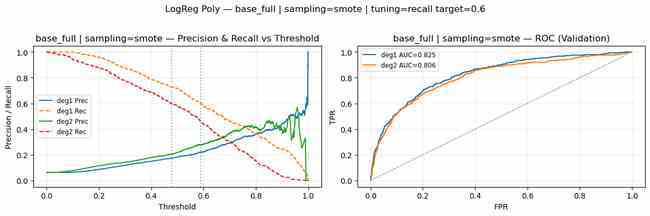


 Dataset: clean_full
Prepared dataset: Train=(55674, 20), Val=(7954, 20), Test=(15907, 20), Features=20, mode=numeric_only
  ◦ Sampling: smote
    ➤ Degree 1
      deg=1: thr=0.625  ValRec₁=0.600  ValPrec₁=0.239
    ➤ Degree 2


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

      deg=2: thr=0.486  ValRec₁=0.600  ValPrec₁=0.203


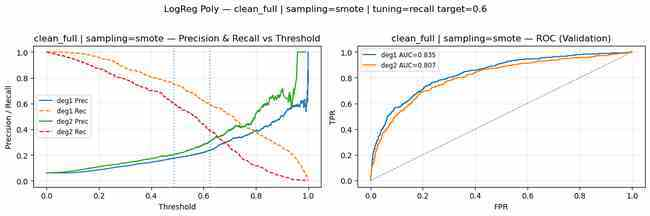


 Dataset: base_reduced
Prepared dataset: Train=(55896, 16), Val=(7986, 16), Test=(15971, 16), Features=16, mode=numeric_only
  ◦ Sampling: smote
    ➤ Degree 1
      deg=1: thr=0.586  ValRec₁=0.608  ValPrec₁=0.220
    ➤ Degree 2


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

      deg=2: thr=0.524  ValRec₁=0.604  ValPrec₁=0.204


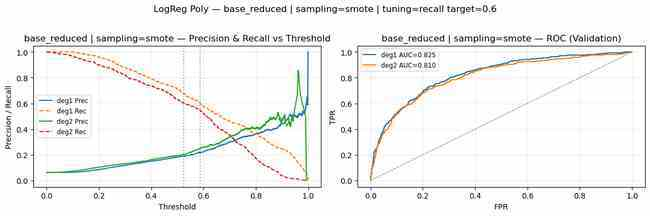


 Dataset: clean_reduced
Prepared dataset: Train=(55674, 16), Val=(7954, 16), Test=(15907, 16), Features=16, mode=numeric_only
  ◦ Sampling: smote
    ➤ Degree 1
      deg=1: thr=0.614  ValRec₁=0.600  ValPrec₁=0.232
    ➤ Degree 2


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

      deg=2: thr=0.553  ValRec₁=0.600  ValPrec₁=0.213


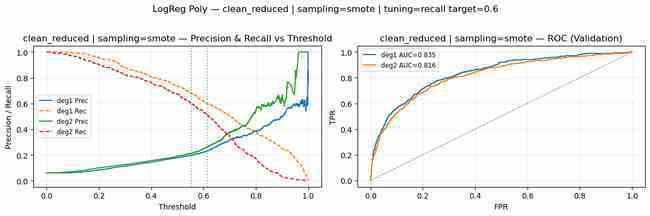


 Dataset: base_reduced_no_cat
Prepared dataset: Train=(55896, 10), Val=(7986, 10), Test=(15971, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    ➤ Degree 1
      deg=1: thr=0.588  ValRec₁=0.604  ValPrec₁=0.222
    ➤ Degree 2


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


      deg=2: thr=0.599  ValRec₁=0.600  ValPrec₁=0.227


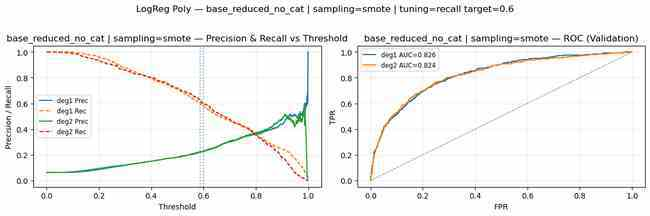


 Dataset: clean_reduced_no_cat
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    ➤ Degree 1
      deg=1: thr=0.609  ValRec₁=0.600  ValPrec₁=0.229
    ➤ Degree 2
      deg=2: thr=0.633  ValRec₁=0.600  ValPrec₁=0.248


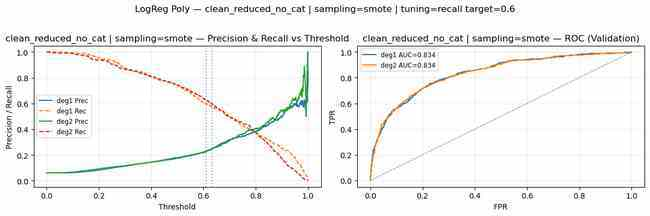


 Dataset: base_reduced_no_cat_raw
Prepared dataset: Train=(55896, 9), Val=(7986, 9), Test=(15971, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    ➤ Degree 1
      deg=1: thr=0.589  ValRec₁=0.602  ValPrec₁=0.221
    ➤ Degree 2
      deg=2: thr=0.616  ValRec₁=0.600  ValPrec₁=0.228


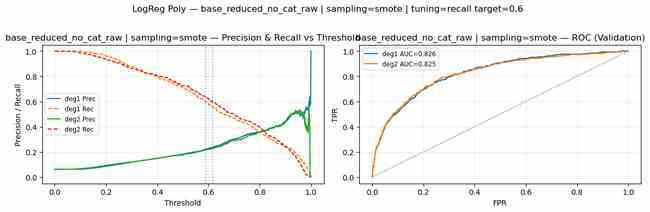


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    ➤ Degree 1
      deg=1: thr=0.608  ValRec₁=0.600  ValPrec₁=0.228
    ➤ Degree 2
      deg=2: thr=0.647  ValRec₁=0.600  ValPrec₁=0.244


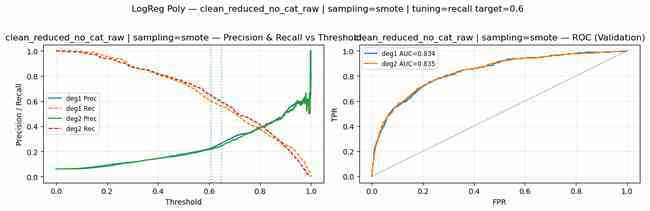


 Dataset: base_topcorr_only
Prepared dataset: Train=(55896, 4), Val=(7986, 4), Test=(15971, 4), Features=4, mode=numeric_only
  ◦ Sampling: smote
    ➤ Degree 1
      deg=1: thr=0.582  ValRec₁=0.604  ValPrec₁=0.211
    ➤ Degree 2
      deg=2: thr=0.606  ValRec₁=0.600  ValPrec₁=0.214


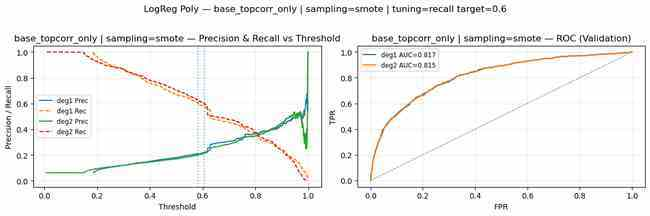


 Dataset: clean_topcorr_only
Prepared dataset: Train=(55674, 4), Val=(7954, 4), Test=(15907, 4), Features=4, mode=numeric_only
  ◦ Sampling: smote
    ➤ Degree 1
      deg=1: thr=0.621  ValRec₁=0.604  ValPrec₁=0.228
    ➤ Degree 2
      deg=2: thr=0.638  ValRec₁=0.610  ValPrec₁=0.229


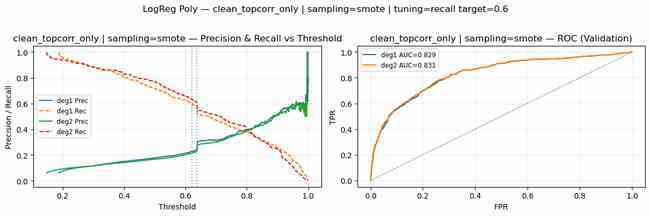


=== Logistic Regression Poly (recall=0.6) Summary ===


dataset                   model sampling_method  degree  \
19        clean_topcorr_only  LogisticRegressionPoly           smote       2   
0                  base_full  LogisticRegressionPoly           smote       1   
4               base_reduced  LogisticRegressionPoly           smote       1   
18        clean_topcorr_only  LogisticRegressionPoly           smote       1   
5               base_reduced  LogisticRegressionPoly           smote       2   
8        base_reduced_no_cat  LogisticRegressionPoly           smote       1   
16         base_topcorr_only  LogisticRegressionPoly           smote       1   
12   base_reduced_no_cat_raw  LogisticRegressionPoly           smote       1   
2                 clean_full  LogisticRegressionPoly           smote       1   
13   base_reduced_no_cat_raw  LogisticRegressionPoly           smote       2   
17         base_topcorr_only  LogisticRegressionPoly           smote       2   
15  clean_reduced_no_cat_raw  LogisticRegressionPoly           smote       2   
14  clean_reduced_no_cat_raw  LogisticRegressionPoly           smote       1   
11      clean_reduced_no_cat  LogisticRegressionPoly           smote       2   
3                 clean_full  LogisticRegressionPoly           smote       2   
1                  base_full  LogisticRegressionPoly           smote       2   
9        base_reduced_no_cat  LogisticRegressionPoly           smote       2   
7              clean_reduced  LogisticRegressionPoly           smote       2   
6              clean_reduced  LogisticRegressionPoly           smote       1   
10      clean_reduced_no_cat  LogisticRegressionPoly           smote       1   

   tuning_mode  tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  \
19      recall            0.6          0.6376     0.2289    0.6103    0.3330   
0       recall            0.6          0.5883     0.2225    0.6100    0.3260   
4       recall            0.6          0.5862     0.2197    0.6080    0.3227   
18      recall            0.6          0.6211     0.2280    0.6041    0.3311   
5       recall            0.6          0.5244     0.2038    0.6040    0.3047   
8       recall            0.6          0.5879     0.2224    0.6040    0.3251   
16      recall            0.6          0.5821     0.2107    0.6040    0.3125   
12      recall            0.6          0.5889     0.2215    0.6020    0.3238   
2       recall            0.6          0.6246     0.2393    0.6000    0.3422   
13      recall            0.6          0.6159     0.2285    0.6000    0.3309   
17      recall            0.6          0.6064     0.2137    0.6000    0.3151   
15      recall            0.6          0.6475     0.2443    0.6000    0.3473   
14      recall            0.6          0.6078     0.2275    0.6000    0.3299   
11      recall            0.6          0.6326     0.2479    0.6000    0.3508   
3       recall            0.6          0.4861     0.2029    0.6000    0.3033   
1       recall            0.6          0.4779     0.2052    0.6000    0.3058   
9       recall            0.6          0.5987     0.2271    0.6000    0.3295   
7       recall            0.6          0.5532     0.2130    0.6000    0.3144   
6       recall            0.6          0.6145     0.2315    0.6000    0.3341   
10      recall            0.6          0.6094     0.2293    0.6000    0.3318   

    val_roc1  test_prec1  test_rec1  test_f1_1  test_roc1  
19    0.8305      0.2386     0.5918     0.3400     0.8227  
0     0.8251      0.2287     0.6180     0.3339     0.8408  
4     0.8253      0.2287     0.6200     0.3341     0.8409  
18    0.8290      0.2379     0.5845     0.3382     0.8218  
5     0.8096      0.2148     0.6170     0.3187     0.8234  
8     0.8261      0.2329     0.6180     0.3383     0.8415  
16    0.8166      0.2227     0.6260     0.3285     0.8321  
12    0.8260      0.2328     0.6160     0.3379     0.8414  
2     0.8348      0.2420     0.5918     0.3435     0.8275  
13    0.8248      0.2414     0.6130     0.3464     0.8431  

In [135]:
param_grid = {"C":[0.01,0.1,1,10], "penalty":["l2"]}
df_logreg, logreg_store = run_logistic_poly_pipeline(
    datasets,
    tuning_mode="recall",
    degrees=(1,2),
    sampling_method="smote",
    search_type="random",
    param_grid=param_grid,
    n_iter=12,
    show_plot=True
)

### Gradient-Boosted Tree Ensemble Pipeline (XGBoost)

This pipeline evaluates **XGBoost**, a gradient-boosted decision tree ensemble that builds trees sequentially, each correcting the errors of the previous ones. XGBoost is capable of modeling complex, non-linear class boundaries and interactions, and is often more robust to noisy or high-dimensional feature spaces compared to single trees or Random Forests.

The pipeline supports:
- **Class Imbalance Handling:** Can apply the general resampling toolkit (`smote`, `adasyn`, `random_under`, `vae`, etc.) or use XGBoost's **built-in imbalance controls** (e.g., `scale_pos_weight`) when `sampling_method="builtin"`.
- **Hyperparameter Search (optional):** If `search_type="random"` or `"grid"`, the pipeline tunes key parameters such as learning rate, tree depth, number of estimators, and regularization strengths.
- **Threshold Tuning:** On the validation set, the decision threshold can be chosen to prioritize **recall**, **precision**, or **max-F1**, depending on the evaluation goal.
- **Visualization:** Produces PR and ROC curves to compare operating points and highlight the performance trade-off for the minority class.

**Why this function exists:**  
To benchmark a **strong non-linear boosting model** against simpler classifiers evaluated earlier (distance-based, single-tree, random forest, and polynomial logistic). This allows us to observe how **sequential boosting and feature interaction learning** affect minority-class performance under consistent resampling and thresholding conditions across datasets.


In [222]:
def run_xgb_pipeline_tuned(
    datasets,
    sampling_method="none",          # "none", "smote", "adasyn", "random_under", "vae", "builtin"
    sampling_methods: list = None,
    tuning_mode="recall",
    tuning_target=0.8,
    val_size=0.1,
    test_size=0.2,
    search_type=None,                # "random" | "grid" | None
    param_grid=None,
    n_iter=24,
    cv=3,
    scoring="f1",
    show_plot=True,
    random_state=SEED,
    reuse_models_dict=None,
    xgb_base_params: dict = None
):
    """
    Train XGBoost per dataset with unified sampling control.
    Supports:
      - Manual balancing (SMOTE, ADASYN, etc.)
      - Built-in imbalance correction (scale_pos_weight)
      - Normal unbalanced training ("none")

    Returns: df_summary, model_store_out
    """
    if XGBClassifier is None:
        raise RuntimeError("xgboost.XGBClassifier not available in this environment.")

    methods_to_run = sampling_methods if sampling_methods is not None else [sampling_method or "none"]
    model_store_out, rows = {}, []

    # Default parameter grid
    default_param_grid = {
        "n_estimators": [100, 200, 400],
        "max_depth": [4, 6, 8],
        "learning_rate": [0.01, 0.05, 0.1],
        "subsample": [0.6, 0.8, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0]
    }
    grid = param_grid if param_grid is not None else default_param_grid

    for ds_name, df in datasets.items():
        print(f"\n Dataset: {ds_name}")
        try:
            prep = prepare_dataset_df(df, target=TARGET, test_size=test_size, val_size=val_size,
                                      random_state=random_state, scale_mode="numeric_only")
            X_train_df, y_train = prep["X_train_df"], prep["y_train"]
            X_val_df,   y_val   = prep["X_val_df"],   prep["y_val"]
            X_test_df,  y_test  = prep["X_test_df"],  prep["y_test"]

            model_store_out[ds_name] = {}

            for method in methods_to_run:
                print(f"  ◦ Sampling: {method}")

                # ---  Handle sampling / imbalance mode ---
                X_tr_use, y_tr_use = X_train_df.copy(), y_train.copy()
                use_builtin_imbalance = False

                if method in (None, "none", "passthrough"):
                    pass  # raw training data
                elif method.lower() in ("builtin", "xgb_builtin"):
                    use_builtin_imbalance = True
                else:
                    X_tr_use, y_tr_use = resample_train(X_train_df, y_train, method=method, random_state=random_state)

                # ---  Compute scale_pos_weight if builtin imbalance used ---
                if use_builtin_imbalance:
                    n_pos = int((y_tr_use == 1).sum()); n_neg = int((y_tr_use == 0).sum())
                    scale_pos_weight = float(n_neg) / float(max(1, n_pos))
                else:
                    scale_pos_weight = 1.0

                # ---  Base model params ---
                base_params = dict(
                    n_estimators=200,
                    max_depth=6,
                    learning_rate=0.1,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    use_label_encoder=False,
                    eval_metric="logloss",
                    random_state=random_state,
                    n_jobs=-1,
                    verbosity=0,
                    scale_pos_weight=scale_pos_weight
                )
                if xgb_base_params:
                    base_params.update(xgb_base_params)

                base_est = XGBClassifier(**base_params)

                # ---  Fit (with optional search) ---
                best_est, search_obj = _fit_model_with_search(
                    base_est,
                    param_grid=grid,
                    X=X_tr_use,
                    y=y_tr_use,
                    search_type=search_type,
                    n_iter=n_iter,
                    cv=cv,
                    scoring=scoring,
                    random_state=random_state,
                    n_jobs=-1
                )

                # ---  Predict probabilities ---
                y_train_prob = safe_predict_scores(best_est, X_tr_use)
                y_val_prob   = safe_predict_scores(best_est, X_val_df)
                y_test_prob  = safe_predict_scores(best_est, X_test_df)

                # ---  Threshold tuning ---
                if tuning_mode == "recall":
                    thr, thr_info = choose_threshold_for_recall_from_scores(y_val, y_val_prob, target_recall=tuning_target)
                elif tuning_mode == "precision":
                    thr, thr_info = choose_threshold_for_precision_from_scores(y_val, y_val_prob, target_precision=tuning_target)
                elif tuning_mode == "max_f1":
                    thr, thr_info = choose_threshold_max_f1_from_scores(y_val, y_val_prob)
                else:
                    thr, thr_info = 0.5, {"mode": "none"}

                # --- Compute metrics ---
                m_train = compute_metrics_from_probs(y_tr_use, y_train_prob, threshold=thr)
                m_val   = compute_metrics_from_probs(y_val, y_val_prob, threshold=thr)
                m_test  = compute_metrics_from_probs(y_test, y_test_prob, threshold=thr)

                # ---  Save results ---
                model_store_out[ds_name].setdefault(method, {})["XGBoost"] = {
                    "model": best_est,
                    "search": search_obj,
                    "scores": {"train": y_train_prob, "val": y_val_prob, "test": y_test_prob},
                    "threshold": float(thr),
                    "threshold_info": thr_info,
                    "metrics": {"train": m_train, "val": m_val, "test": m_test},
                    "sampling_method": method,
                    "scale_pos_weight": scale_pos_weight,
                    "use_builtin_imbalance": use_builtin_imbalance
                }

                rows.append({
                    "dataset": ds_name,
                    "model": "XGBoost",
                    "sampling_method": method,
                    "tuning_mode": tuning_mode,
                    "tuning_target": tuning_target,
                    "threshold_used": float(thr),
                    "val_prec1": m_val["precision_by_class"][1],
                    "val_rec1": m_val["recall_by_class"][1],
                    "val_f1_1": m_val["f1_by_class"][1],
                    "val_roc1": m_val["roc_auc_class1"],
                    "test_prec1": m_test["precision_by_class"][1],
                    "test_rec1": m_test["recall_by_class"][1],
                    "test_f1_1": m_test["f1_by_class"][1],
                    "test_roc1": m_test["roc_auc_class1"]
                })

                print(f"     XGB: thr={thr:.3f}  ValPrec₁={m_val['precision_by_class'][1]:.3f}  ValRec₁={m_val['recall_by_class'][1]:.3f}  AUC={m_val['roc_auc_class1']:.3f}")

                # ---  Plot ---
                if show_plot:
                    _plot_pr_roc_inline(
                        y_val,
                        {"XGBoost": y_val_prob},
                        {"XGBoost": thr},
                        dataset_name=f"{ds_name} | {method}",
                        show=True
                    )

        except Exception as e:
            print(f"  Error processing {ds_name}: {e}")

    # --- Summary ---
    df_summary = pd.DataFrame(rows)
    if not df_summary.empty:
        key = "val_prec1" if tuning_mode == "precision" else "val_rec1"
        df_summary = df_summary.round(4).sort_values(by=key, ascending=False)
        print(f"\n=== XGBoost ({tuning_mode}={tuning_target}) Summary ===")
        display(df_summary)
    else:
        print("No results generated.")

    return df_summary, model_store_out



 Dataset: base_full
Prepared dataset: Train=(55896, 20), Val=(7986, 20), Test=(15971, 20), Features=20, mode=numeric_only
  ◦ Sampling: builtin
     XGB: thr=0.286  ValPrec₁=0.147  ValRec₁=0.800  AUC=0.818


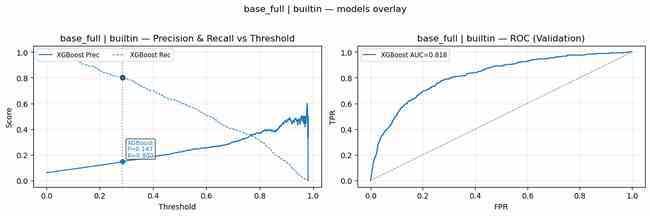


 Dataset: clean_full
Prepared dataset: Train=(55674, 20), Val=(7954, 20), Test=(15907, 20), Features=20, mode=numeric_only
  ◦ Sampling: builtin
     XGB: thr=0.270  ValPrec₁=0.136  ValRec₁=0.800  AUC=0.818


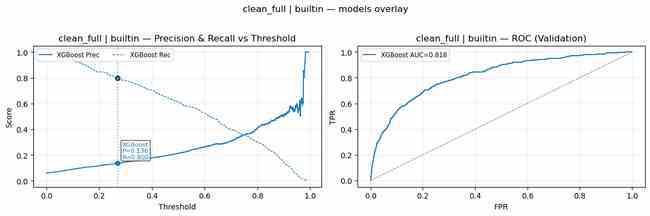


 Dataset: base_reduced
Prepared dataset: Train=(55896, 16), Val=(7986, 16), Test=(15971, 16), Features=16, mode=numeric_only
  ◦ Sampling: builtin
     XGB: thr=0.292  ValPrec₁=0.142  ValRec₁=0.802  AUC=0.816


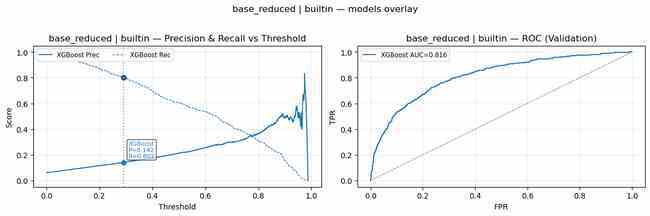


 Dataset: clean_reduced
Prepared dataset: Train=(55674, 16), Val=(7954, 16), Test=(15907, 16), Features=16, mode=numeric_only
  ◦ Sampling: builtin
     XGB: thr=0.298  ValPrec₁=0.142  ValRec₁=0.800  AUC=0.817


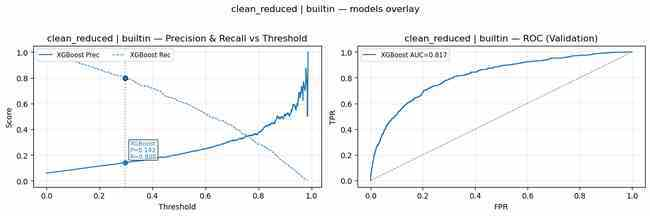


 Dataset: base_reduced_no_cat
Prepared dataset: Train=(55896, 10), Val=(7986, 10), Test=(15971, 10), Features=10, mode=numeric_only
  ◦ Sampling: builtin
     XGB: thr=0.296  ValPrec₁=0.144  ValRec₁=0.800  AUC=0.815


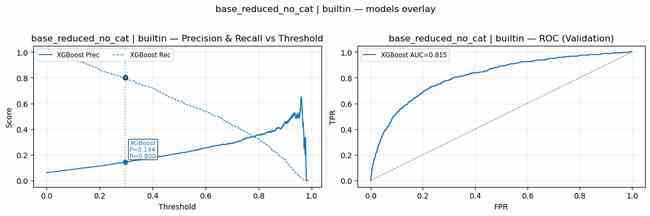


 Dataset: clean_reduced_no_cat
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: builtin
     XGB: thr=0.317  ValPrec₁=0.146  ValRec₁=0.800  AUC=0.820


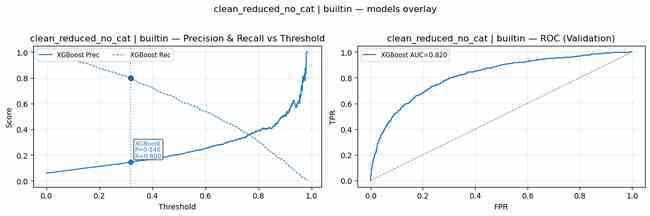


 Dataset: base_reduced_no_cat_raw
Prepared dataset: Train=(55896, 9), Val=(7986, 9), Test=(15971, 9), Features=9, mode=numeric_only
  ◦ Sampling: builtin
     XGB: thr=0.300  ValPrec₁=0.142  ValRec₁=0.800  AUC=0.815


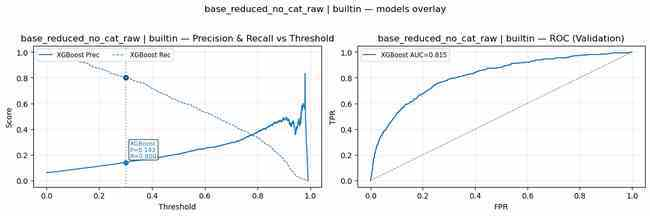


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: builtin
     XGB: thr=0.321  ValPrec₁=0.143  ValRec₁=0.802  AUC=0.824


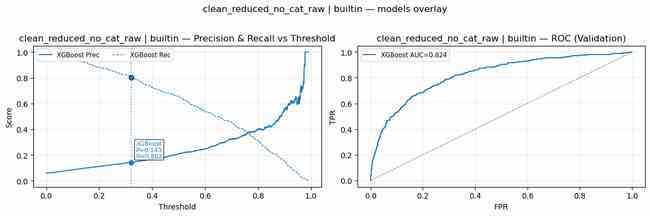


 Dataset: base_topcorr_only
Prepared dataset: Train=(55896, 4), Val=(7986, 4), Test=(15971, 4), Features=4, mode=numeric_only
  ◦ Sampling: builtin
     XGB: thr=0.361  ValPrec₁=0.133  ValRec₁=0.800  AUC=0.797


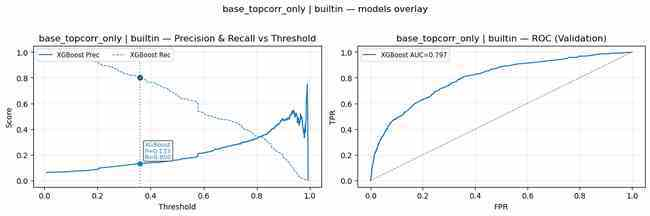


 Dataset: clean_topcorr_only
Prepared dataset: Train=(55674, 4), Val=(7954, 4), Test=(15907, 4), Features=4, mode=numeric_only
  ◦ Sampling: builtin
     XGB: thr=0.408  ValPrec₁=0.137  ValRec₁=0.806  AUC=0.818


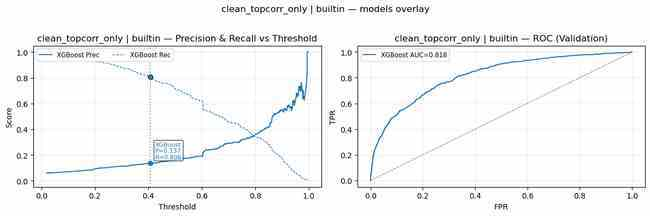


=== XGBoost (recall=0.8) Summary ===


dataset    model sampling_method tuning_mode  \
9        clean_topcorr_only  XGBoost         builtin      recall   
7  clean_reduced_no_cat_raw  XGBoost         builtin      recall   
2              base_reduced  XGBoost         builtin      recall   
0                 base_full  XGBoost         builtin      recall   
1                clean_full  XGBoost         builtin      recall   
3             clean_reduced  XGBoost         builtin      recall   
4       base_reduced_no_cat  XGBoost         builtin      recall   
5      clean_reduced_no_cat  XGBoost         builtin      recall   
6   base_reduced_no_cat_raw  XGBoost         builtin      recall   
8         base_topcorr_only  XGBoost         builtin      recall   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
9            0.8          0.4083     0.1370    0.8062    0.2342    0.8183   
7            0.8          0.3213     0.1434    0.8021    0.2434    0.8238   
2            0.8          0.2921     0.1415    0.8020    0.2406    0.8159   
0            0.8          0.2862     0.1473    0.8000    0.2488    0.8185   
1            0.8          0.2702     0.1362    0.8000    0.2328    0.8184   
3            0.8          0.2984     0.1417    0.8000    0.2407    0.8169   
4            0.8          0.2964     0.1443    0.8000    0.2445    0.8148   
5            0.8          0.3174     0.1456    0.8000    0.2464    0.8201   
6            0.8          0.2999     0.1416    0.8000    0.2406    0.8149   
8            0.8          0.3608     0.1327    0.8000    0.2276    0.7975   

   test_prec1  test_rec1  test_f1_1  test_roc1  
9      0.1378     0.7907     0.2347     0.8103  
7      0.1433     0.7784     0.2421     0.8146  
2      0.1456     0.8040     0.2466     0.8285  
0      0.1497     0.7970     0.2521     0.8260  
1      0.1379     0.8124     0.2358     0.8169  
3      0.1378     0.7876     0.2346     0.8150  
4      0.1476     0.8060     0.2495     0.8267  
5      0.1439     0.7845     0.2432     0.8174  
6      0.1470     0.8190     0.2493     0.8271  
8      0.1369     0.8360     0.2353     0.8235

In [138]:
df_xgb, xgb_store = run_xgb_pipeline_tuned(
    datasets,
    sampling_method="builtin"   #  internal scale_pos_weight
)

In [224]:
def _sanitize_param_grid_for_estimator(param_grid, estimator):
    """
    Keep only keys in param_grid that are valid for `estimator`.
    Supports dict-of-lists or list-of-dicts (sklearn style).
    Returns (sanitized_grid, dropped_keys_list).
    """
    if param_grid is None:
        return None, []

    valid = set(estimator.get_params().keys())
    dropped = set()

    # Normalize to list-of-dicts for easy processing
    grids = param_grid if isinstance(param_grid, list) else [param_grid]

    sanitized = []
    for g in grids:
        g_clean = {}
        for k, v in g.items():
            # Accept nested names like "estimator__C" only if estimator supports it
            if k in valid:
                g_clean[k] = v
            else:
                # try to handle a common mistake where user provided kernel params for linear SVC
                dropped.add(k)
        if g_clean:
            sanitized.append(g_clean)

    if len(sanitized) == 0:
        # nothing left -> return None (so caller can use default grid)
        return None, sorted(dropped)
    # if original was a single dict, return single dict, else list
    if isinstance(param_grid, dict):
        return sanitized[0], sorted(dropped)
    return sanitized, sorted(dropped)


### Support Vector Machine (SVM) Pipeline

This pipeline evaluates **Support Vector Machine** classifiers, which construct decision boundaries by maximizing the margin between classes. SVMs can model both linear and non-linear relationships depending on the kernel used. Because SVM training cost scales with dataset size, the pipeline includes a safeguard to use **LinearSVC** for large datasets and optionally switch to **kernel SVC** (e.g., RBF kernel) only when the training set is sufficiently small.

The pipeline supports:
- **Class Imbalance Handling:** Integrates with the same resampling strategies (e.g., SMOTE, ADASYN, random under/over sampling, VAE-based synthesis) to rebalance the minority class before fitting.
- **Hyperparameter Search (optional):** Can perform grid/random search over kernel type, regularization (`C`), gamma (for RBF), and other SVM-specific parameters.
- **Threshold Tuning:** On the validation set, the decision threshold can be optimized to target a desired **recall**, **precision**, or **max-F1** operating point.
- **Scalability Controls:**  
  - `use_kernel_if_small=True` allows SVC with non-linear kernel only if dataset size < `sample_threshold`.  
  - Otherwise falls back to `LinearSVC` for efficient training.

**Why this function exists:**  
To compare **margin-based decision boundaries** (linear and kernelized) against tree-based, ensemble, and boosting models under the **same resampling and threshold-tuning framework**. This helps determine whether a **maximum-margin classifier** captures the structure of the minority class more effectively across datasets, without overfitting or excessive computation.


In [227]:

def run_svm_pipeline_tuned(
    datasets,
    sampling_method="none",
    sampling_methods: list = None,
    tuning_mode="recall",           # "recall" | "precision" | "max_f1" | "none"
    tuning_target=0.8,
    val_size=0.1,
    test_size=0.2,
    # search params
    search_type=None,               # "grid" | "random" | None
    param_grid=None,
    n_iter=20,
    cv=3,
    scoring="f1",
    # kernel decision params
    use_kernel_if_small=False,      # allow kernel SVC only for small datasets
    sample_threshold=10000,         # threshold for n_train below which kernel SVC is allowed
    # LinearSVC params (fast default)
    linear_max_iter=10000,
    # SVC kernel default (if allowed)
    kernel_default="rbf",
    random_state=SEED,
    show_plot=True,
    reuse_models_dict=None
):
    """
    Robust SVM pipeline with param_grid sanitization:
      - Search runs on base estimator (LinearSVC or SVC)
      - Sanitizes param_grid to parameters valid for the base estimator
      - Wraps the selected base estimator in CalibratedClassifierCV for probabilities
    Returns: df_summary, model_store_out
    """
    methods_to_run = sampling_methods if sampling_methods is not None else [sampling_method or "none"]
    model_store_out = {}
    rows = []
    rng = check_random_state(random_state)

    # sensible default grids (apply to base estimator)
    default_linear_grid = {"C": [0.01, 0.1, 1, 10]}
    default_kernel_grid = {"C": [0.1, 1.0, 10.0], "gamma": ["scale"], "kernel": [kernel_default]}

    for ds_name, df in datasets.items():
        print(f"\n Dataset: {ds_name}")
        try:
            # 1) prepare splits
            prep = prepare_dataset_df(df, target=TARGET, test_size=test_size, val_size=val_size,
                                      random_state=random_state, scale_mode="numeric_only")
            X_train_df = prep["X_train_df"]; y_train = prep["y_train"]
            X_val_df   = prep["X_val_df"];   y_val   = prep["y_val"]
            X_test_df  = prep["X_test_df"];  y_test  = prep["y_test"]

            n_train = int(X_train_df.shape[0])
            allow_kernel = use_kernel_if_small and (n_train <= sample_threshold)

            model_store_out.setdefault(ds_name, {})

            for method in methods_to_run:
                print(f"  ◦ Sampling: {method}")
                mm = str(method).lower()
                use_builtin = mm in ("builtin", "class_weight", "balanced", "xgb_builtin")

                # resample only TRAIN unless builtin
                if use_builtin or mm in ("none", "passthrough", "raw"):
                    X_tr_use, y_tr_use = X_train_df.copy(), y_train.copy()
                else:
                    X_tr_use, y_tr_use = resample_train(X_train_df, y_train, method=method, random_state=random_state)

                # decide base estimator
                if allow_kernel:
                    candidate_base = SVC(kernel=kernel_default, probability=False, random_state=random_state)
                    default_grid = default_kernel_grid
                else:
                    candidate_base = LinearSVC(max_iter=linear_max_iter, random_state=random_state)
                    default_grid = default_linear_grid

                # merge user param_grid with default: user param_grid preferred if provided
                user_grid = deepcopy(param_grid) if param_grid is not None else None
                chosen_grid = user_grid if user_grid is not None else default_grid

                # sanitize param grid for candidate_base
                sanitized_grid, dropped = _sanitize_param_grid_for_estimator(chosen_grid, candidate_base)
                if dropped:
                    print(f"    Dropped invalid grid keys for {type(candidate_base).__name__}: {dropped}")
                if sanitized_grid is None:
                    # nothing valid left -> fallback to default grid appropriate for base
                    sanitized_grid = default_kernel_grid if allow_kernel else default_linear_grid
                    print(f"    ℹ️ Using fallback default grid for {type(candidate_base).__name__}: {sanitized_grid}")

                best_base_estimator = None
                search_obj = None

                # 2) optional hyperparameter search on BASE estimator (not on calibrated wrapper)
                if search_type is not None:
                    try:
                        best_search_out = _fit_model_with_search(
                            candidate_base,
                            param_grid=sanitized_grid,
                            X=X_tr_use,
                            y=y_tr_use,
                            search_type=search_type,
                            n_iter=n_iter,
                            cv=cv,
                            scoring=scoring,
                            random_state=random_state,
                            n_jobs=-1
                        )
                        # handle possible return formats
                        if isinstance(best_search_out, tuple) and len(best_search_out) >= 1:
                            best_base_estimator = best_search_out[0]
                            search_obj = best_search_out[1] if len(best_search_out) > 1 else None
                        else:
                            search_obj = best_search_out
                            if hasattr(search_obj, "best_estimator_"):
                                best_base_estimator = search_obj.best_estimator_
                            else:
                                best_base_estimator = search_obj
                    except Exception as e_search:
                        print(f"    _fit_model_with_search failed ({e_search}); falling back to direct base fit.")
                        best_base_estimator = None
                        search_obj = None

                # If search not used or failed, ensure we at least have a fitted base estimator or candidate_base
                if best_base_estimator is None:
                    best_base_estimator = candidate_base
                    try:
                        best_base_estimator.fit(X_tr_use, y_tr_use)
                    except Exception:
                        # Some base estimators may be fit as part of calibration; ignore fit failures here
                        pass

                # 3) calibration
                try:
                    calibrated = CalibratedClassifierCV(best_base_estimator, cv=3)
                    calibrated.fit(X_tr_use, y_tr_use)
                    best_est = calibrated
                except Exception as e_cal:
                    print(f"    Calibration failed: {e_cal}. Falling back to base estimator (will use decision_function).")
                    best_est = best_base_estimator
                    try:
                        best_est.fit(X_tr_use, y_tr_use)
                    except Exception as e_fit:
                        raise RuntimeError(f"Failed to fit base estimator after calibration error: {e_fit}")

                # 4) robust scoring
                try:
                    y_train_prob = safe_predict_scores(best_est, X_tr_use)
                    y_val_prob   = safe_predict_scores(best_est, X_val_df)
                    y_test_prob  = safe_predict_scores(best_est, X_test_df)
                except Exception:
                    try:
                        y_train_prob = best_est.predict_proba(X_tr_use)[:,1]
                        y_val_prob   = best_est.predict_proba(X_val_df)[:,1]
                        y_test_prob  = best_est.predict_proba(X_test_df)[:,1]
                    except Exception:
                        try:
                            y_train_prob = best_est.decision_function(X_tr_use)
                            y_val_prob   = best_est.decision_function(X_val_df)
                            y_test_prob  = best_est.decision_function(X_test_df)
                            def _scale(a):
                                a = np.asarray(a, dtype=float)
                                mn, mx = np.nanmin(a), np.nanmax(a)
                                return (a - mn) / (mx - mn) if mx > mn else np.zeros_like(a)
                            y_train_prob = _scale(y_train_prob)
                            y_val_prob   = _scale(y_val_prob)
                            y_test_prob  = _scale(y_test_prob)
                        except Exception:
                            y_train_prob = best_est.predict(X_tr_use).astype(float)
                            y_val_prob   = best_est.predict(X_val_df).astype(float)
                            y_test_prob  = best_est.predict(X_test_df).astype(float)

                # 5) choose threshold on validation
                if X_val_df is None or y_val is None:
                    thr, thr_info = 0.5, {"mode":"no_val_fallback"}
                else:
                    if tuning_mode == "recall":
                        thr, thr_info = choose_threshold_for_recall_from_scores(y_val, y_val_prob, target_recall=tuning_target)
                    elif tuning_mode == "precision":
                        thr, thr_info = choose_threshold_for_precision_from_scores(y_val, y_val_prob, target_precision=tuning_target)
                    elif tuning_mode == "max_f1":
                        thr, thr_info = choose_threshold_max_f1_from_scores(y_val, y_val_prob)
                    else:
                        thr, thr_info = 0.5, {"mode":"none"}

                # 6) compute metrics
                m_train = compute_metrics_from_probs(y_tr_use, y_train_prob, threshold=thr)
                m_val   = compute_metrics_from_probs(y_val,    y_val_prob,   threshold=thr)
                m_test  = compute_metrics_from_probs(y_test,   y_test_prob,  threshold=thr)

                # 7) store
                model_store_out[ds_name].setdefault(method, {})["SVM"] = {
                    "model": best_est,
                    "search": search_obj,
                    "base_estimator": best_base_estimator,
                    "scores": {"train": y_train_prob, "val": y_val_prob, "test": y_test_prob},
                    "threshold": float(thr),
                    "threshold_info": thr_info,
                    "metrics": {"train": m_train, "val": m_val, "test": m_test},
                    "resampling": method,
                    "allow_kernel": allow_kernel
                }

                # 8) summary row
                rows.append({
                    "dataset": ds_name,
                    "model": "SVM",
                    "sampling_method": method,
                    "tuning_mode": tuning_mode,
                    "tuning_target": tuning_target,
                    "threshold_used": float(thr),
                    "val_prec1": m_val["precision_by_class"][1],
                    "val_rec1": m_val["recall_by_class"][1],
                    "val_f1_1": m_val["f1_by_class"][1],
                    "val_roc1": m_val["roc_auc_class1"],
                    "test_prec1": m_test["precision_by_class"][1],
                    "test_rec1": m_test["recall_by_class"][1],
                    "test_f1_1": m_test["f1_by_class"][1],
                    "test_roc1": m_test["roc_auc_class1"]
                })

                # 9) console
                print(f"    SVM: thr={thr:.3f}  ValRec₁={m_val['recall_by_class'][1]:.3f}  ValPrec₁={m_val['precision_by_class'][1]:.3f}  ValROC₁={m_val['roc_auc_class1']:.3f}")

                # 10) plotting
                if show_plot:
                    try:
                        _plot_pr_roc_inline(y_val, {"SVM": y_val_prob}, {"SVM": thr}, dataset_name=f"{ds_name} | {method}", show=True)
                    except Exception as e_plot:
                        print(f"    plotting failed for {ds_name} (SVM): {e_plot}")

        except Exception as e:
            print(f"  Error processing {ds_name}: {e}")

    # final summary
    df_summary = pd.DataFrame(rows)
    if not df_summary.empty:
        key = "val_prec1" if tuning_mode == "precision" else "val_rec1"
        df_summary = df_summary.round(4).sort_values(by=key, ascending=False)
        print(f"\n=== SVM ({tuning_mode}={tuning_target}) Summary ===")
        display(df_summary)
    else:
        print("No results generated.")

    return df_summary, model_store_out


 Dataset: base_full
Prepared dataset: Train=(55896, 20), Val=(7986, 20), Test=(15971, 20), Features=20, mode=numeric_only
  ◦ Sampling: builtin


python(35082) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35083) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35084) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35085) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35086) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35087) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35088) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35089) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


    SVM: thr=0.045  ValRec₁=0.800  ValPrec₁=0.144  ValROC₁=0.826


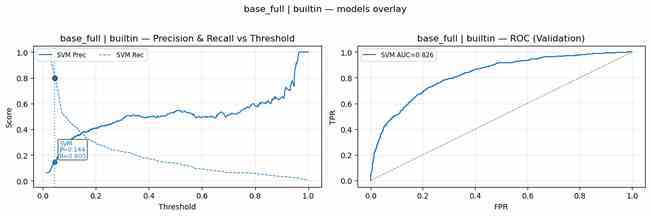


 Dataset: clean_full
Prepared dataset: Train=(55674, 20), Val=(7954, 20), Test=(15907, 20), Features=20, mode=numeric_only
  ◦ Sampling: builtin
    SVM: thr=0.047  ValRec₁=0.800  ValPrec₁=0.160  ValROC₁=0.838


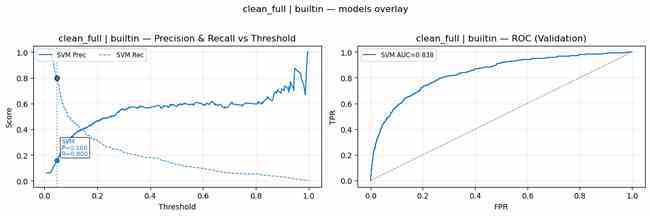


 Dataset: base_reduced
Prepared dataset: Train=(55896, 16), Val=(7986, 16), Test=(15971, 16), Features=16, mode=numeric_only
  ◦ Sampling: builtin
    SVM: thr=0.045  ValRec₁=0.802  ValPrec₁=0.143  ValROC₁=0.826


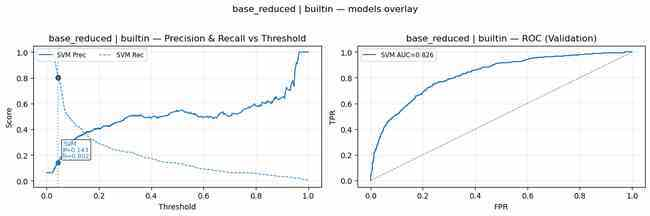


 Dataset: clean_reduced
Prepared dataset: Train=(55674, 16), Val=(7954, 16), Test=(15907, 16), Features=16, mode=numeric_only
  ◦ Sampling: builtin
    SVM: thr=0.047  ValRec₁=0.800  ValPrec₁=0.159  ValROC₁=0.838


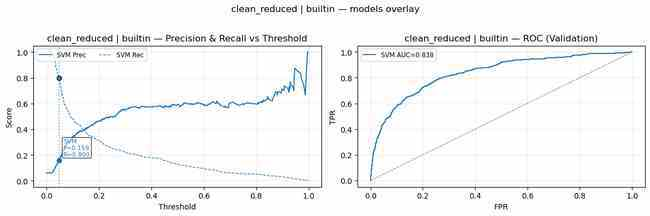


 Dataset: base_reduced_no_cat
Prepared dataset: Train=(55896, 10), Val=(7986, 10), Test=(15971, 10), Features=10, mode=numeric_only
  ◦ Sampling: builtin
    SVM: thr=0.045  ValRec₁=0.800  ValPrec₁=0.145  ValROC₁=0.826


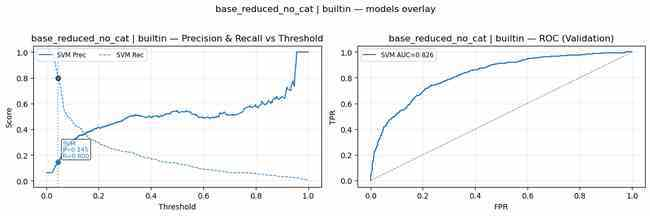


 Dataset: clean_reduced_no_cat
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: builtin
    SVM: thr=0.047  ValRec₁=0.800  ValPrec₁=0.160  ValROC₁=0.838


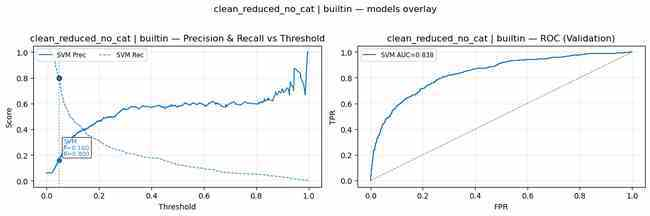


 Dataset: base_reduced_no_cat_raw
Prepared dataset: Train=(55896, 9), Val=(7986, 9), Test=(15971, 9), Features=9, mode=numeric_only
  ◦ Sampling: builtin
    SVM: thr=0.045  ValRec₁=0.800  ValPrec₁=0.148  ValROC₁=0.826


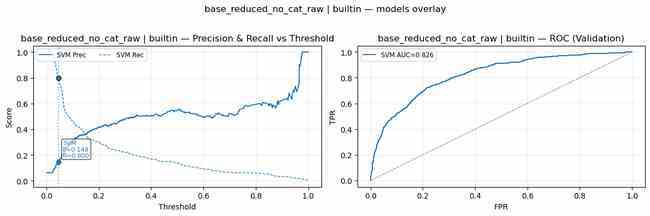


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: builtin
    SVM: thr=0.048  ValRec₁=0.802  ValPrec₁=0.160  ValROC₁=0.837


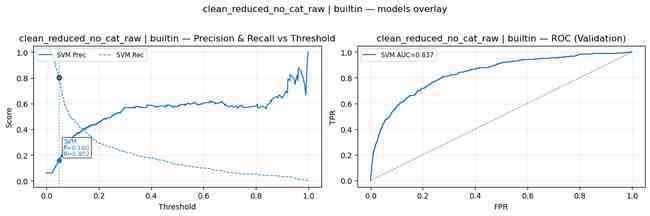


 Dataset: base_topcorr_only
Prepared dataset: Train=(55896, 4), Val=(7986, 4), Test=(15971, 4), Features=4, mode=numeric_only
  ◦ Sampling: builtin
    SVM: thr=0.043  ValRec₁=0.800  ValPrec₁=0.138  ValROC₁=0.817


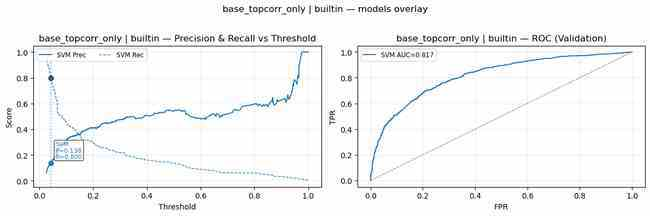


 Dataset: clean_topcorr_only
Prepared dataset: Train=(55674, 4), Val=(7954, 4), Test=(15907, 4), Features=4, mode=numeric_only
  ◦ Sampling: builtin
    SVM: thr=0.046  ValRec₁=0.800  ValPrec₁=0.154  ValROC₁=0.831


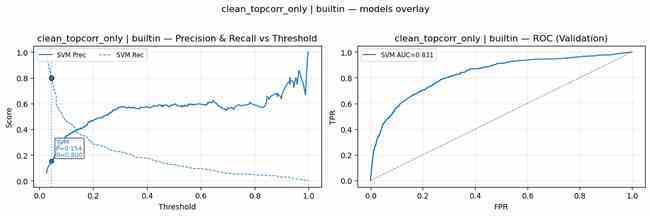


=== SVM (recall=0.8) Summary ===


dataset model sampling_method tuning_mode  tuning_target  \
7  clean_reduced_no_cat_raw   SVM         builtin      recall            0.8   
2              base_reduced   SVM         builtin      recall            0.8   
0                 base_full   SVM         builtin      recall            0.8   
1                clean_full   SVM         builtin      recall            0.8   
3             clean_reduced   SVM         builtin      recall            0.8   
4       base_reduced_no_cat   SVM         builtin      recall            0.8   
5      clean_reduced_no_cat   SVM         builtin      recall            0.8   
6   base_reduced_no_cat_raw   SVM         builtin      recall            0.8   
8         base_topcorr_only   SVM         builtin      recall            0.8   
9        clean_topcorr_only   SVM         builtin      recall            0.8   

   threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  test_prec1  \
7          0.0476     0.1599    0.8021    0.2666    0.8374      0.1606   
2          0.0446     0.1433    0.8020    0.2431    0.8263      0.1488   
0          0.0448     0.1441    0.8000    0.2443    0.8261      0.1511   
1          0.0474     0.1596    0.8000    0.2661    0.8383      0.1590   
3          0.0472     0.1587    0.8000    0.2648    0.8379      0.1590   
4          0.0450     0.1451    0.8000    0.2456    0.8264      0.1510   
5          0.0473     0.1595    0.8000    0.2660    0.8376      0.1597   
6          0.0454     0.1475    0.8000    0.2491    0.8260      0.1530   
8          0.0432     0.1382    0.8000    0.2357    0.8170      0.1429   
9          0.0457     0.1543    0.8000    0.2588    0.8312      0.1541   

   test_rec1  test_f1_1  test_roc1  
7     0.7866     0.2667     0.8317  
2     0.8400     0.2527     0.8430  
0     0.8420     0.2562     0.8433  
1     0.7825     0.2642     0.8314  
3     0.7887     0.2647     0.8320  
4     0.8400     0.2560     0.8438  
5     0.7835     0.2654     0.8321  
6     0.8390     0.2588     0.8430  
8     0.8350     0.2441     0.8339  
9     0.7784     0.2573     0.8232

In [142]:
df_svm, svm_store = run_svm_pipeline_tuned(
    datasets,
    sampling_method="builtin",
    tuning_mode="recall",
    tuning_target=0.8,
    search_type="grid",   # optional
    use_kernel_if_small=False,  # recommended for your large datasets
    show_plot=True
)

In [143]:
# df_svm, svm_store = run_svm_pipeline_tuned(
#     datasets,
#     sampling_method="none",
#     tuning_mode="recall",
#     tuning_target=0.8,
#     search_type="grid",
#     use_kernel_if_small=True,        #  allow kernel SVC
#     sample_threshold=999999,         #  force all datasets to use kernel SVC
#     param_grid={
#         "C": [0.1, 1, 10],
#         "gamma": ["scale", "auto"],
#         "kernel": ["rbf", "poly"],
#         "degree": [2, 3]             # only affects 'poly'
#     },
#     show_plot=True
# )

### Neural Network Pipeline (Keras MLP)

This pipeline trains and evaluates a **feed-forward Multilayer Perceptron (MLP)** using TensorFlow/Keras on the prepared, tabular feature matrix. It supports configurable depth/width, activation, dropout, and L2 regularization to capture non-linear relationships while controlling overfitting.

The pipeline includes:
- **Integrated Imbalance Handling:** Works with the same resampling options (`none`, `smote`, `adasyn`, `random_under`, `vae`, etc.) or built-in class weighting (`sampling_method="builtin"`).
- **Validation-Driven Threshold Tuning:** Chooses the decision threshold to target **recall**, **precision**, or **max-F1** on the validation set.
- **Learning Utilities:** Early stopping and ReduceLROnPlateau callbacks for stable convergence; configurable optimizer and learning rate.
- **Comparable Reporting:** Produces PR/ROC visuals, per-split metrics (train/val/test), and a summary table aligned with other model pipelines.

**Why this function exists:**  
To benchmark a **parametric, non-linear neural model** against distance-based, tree-based, ensemble, and boosting approaches under the **same resampling, tuning, and evaluation protocol**, and to assess whether an MLP improves minority-class capture and overall stability across datasets without heavy feature engineering.


In [229]:
def build_keras_mlp(input_dim, hidden_units=(256,128,64,32,16), activation="relu",
                    dropout=0.0, l2=1e-4, output_activation="sigmoid"):
    """
    Small helper to build a Keras sequential MLP.
    """
    try:
        import tensorflow as tf
        from tensorflow.keras import layers, models, regularizers
    except Exception as e:
        raise RuntimeError("TensorFlow/Keras not found. Install tensorflow to use this function.") from e

    inputs = layers.Input(shape=(input_dim,))
    x = inputs
    for i, h in enumerate(hidden_units):
        x = layers.Dense(h, activation=activation,
                         kernel_regularizer=regularizers.l2(l2))(x)
        if dropout and dropout > 0.0:
            x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1, activation=output_activation)(x)
    model = models.Model(inputs, outputs)
    return model

In [231]:
def run_nn_pipeline_keras(
    datasets,
    sampling_method="none",
    sampling_methods: list = None,
    tuning_mode="recall",           # "recall" | "precision" | "max_f1" | "none"
    tuning_target=0.8,
    val_size=0.1,
    test_size=0.2,
    # Model architecture / training
    hidden_units=(256,128,64,32,16),
    activation="relu",
    dropout=0.0,
    l2=1e-4,
    optimizer="adam",
    lr=1e-3,
    batch_size=1024,
    epochs=100,
    loss="binary_crossentropy",
    metrics=None,
    early_stopping_patience=8,
    reduce_lr_patience=4,
    reduce_lr_factor=0.5,
    random_state=SEED,
    show_plot=True,
    reuse_models_dict=None,
    verbose=0
):
    """
    Train & evaluate a Keras MLP across datasets using your pipeline conventions.
    Returns: df_summary, model_store_out

    Requirements:
      - TensorFlow (tf.keras) must be installed in the environment.
      - Relies on helpers: prepare_dataset_df, resample_train, safe_predict_scores,
        choose_threshold_for_recall_from_scores, choose_threshold_for_precision_from_scores,
        choose_threshold_max_f1_from_scores, compute_metrics_from_probs, _plot_pr_roc_inline.
    """
    try:
        import tensorflow as tf
        from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    except Exception as e:
        raise RuntimeError("TensorFlow not installed. Please install tensorflow to run Keras pipeline.") from e

    methods_to_run = sampling_methods if sampling_methods is not None else [sampling_method or "none"]
    model_store_out = {}
    rows = []

    if metrics is None:
        metrics = []

    for ds_name, df in datasets.items():
        print(f"\n Dataset: {ds_name}")
        try:
            # 1) prepare splits (encoder fit on train)
            prep = prepare_dataset_df(df, target=TARGET, test_size=test_size, val_size=val_size,
                                      random_state=random_state, scale_mode="numeric_only")
            X_train_df = prep["X_train_df"]; y_train = prep["y_train"]
            X_val_df   = prep["X_val_df"];   y_val   = prep["y_val"]
            X_test_df  = prep["X_test_df"];  y_test  = prep["y_test"]

            model_store_out.setdefault(ds_name, {})

            for method in methods_to_run:
                print(f"  ◦ Sampling: {method}")
                mm = str(method).lower()
                use_builtin = mm in ("builtin", "class_weight", "balanced", "xgb_builtin")

                # resample only TRAIN unless builtin
                if use_builtin or mm in ("none", "passthrough", "raw"):
                    X_tr_use, y_tr_use = X_train_df.copy(), y_train.copy()
                else:
                    X_tr_use, y_tr_use = resample_train(X_train_df, y_train, method=method, random_state=random_state)

                # Build model
                input_dim = X_tr_use.shape[1]
                model = build_keras_mlp(input_dim=input_dim, hidden_units=hidden_units,
                                        activation=activation, dropout=dropout, l2=l2,
                                        output_activation="sigmoid")

                # Compile
                opt = optimizer
                if isinstance(optimizer, str):
                    if optimizer.lower() == "adam":
                        opt = tf.keras.optimizers.Adam(learning_rate=lr)
                    elif optimizer.lower() == "sgd":
                        opt = tf.keras.optimizers.SGD(learning_rate=lr)
                    else:
                        # other string -> use as-is via keras
                        opt = optimizer

                model.compile(optimizer=opt, loss=loss, metrics=metrics)

                # Callbacks
                callbacks = [
                    EarlyStopping(monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True, verbose=0),
                    ReduceLROnPlateau(monitor="val_loss", patience=reduce_lr_patience, factor=reduce_lr_factor, verbose=0)
                ]

                # class_weight vs sample_weight handling
                fit_kwargs = {"batch_size": batch_size, "epochs": epochs, "callbacks": callbacks, "verbose": verbose}
                class_weight = None
                sample_weight = None
                if use_builtin:
                    # compute class weights (dict) for Keras fit
                    from sklearn.utils.class_weight import compute_class_weight
                    classes = np.unique(y_tr_use)
                    try:
                        cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_tr_use.to_numpy())
                        class_weight = {int(c): float(w) for c, w in zip(classes, cw)}
                    except Exception:
                        class_weight = None
                    if class_weight:
                        fit_kwargs["class_weight"] = class_weight
                else:
                    # try sample_weight if resampling wasn't used but user provided such method
                    # (in practice sample_weight is only when use_builtin True)
                    pass

                # Fit model (wrapped in try/except to show errors)
                try:
                    history = model.fit(X_tr_use, y_tr_use, validation_data=(X_val_df, y_val), **fit_kwargs)
                except TypeError as te:
                    # Some TF versions expect numpy arrays; ensure conversion
                    history = model.fit(X_tr_use.values if hasattr(X_tr_use, "values") else X_tr_use,
                                        y_tr_use.values if hasattr(y_tr_use, "values") else y_tr_use,
                                        validation_data=(X_val_df.values if hasattr(X_val_df, "values") else X_val_df,
                                                         y_val.values if hasattr(y_val, "values") else y_val),
                                        **fit_kwargs)
                except Exception as e_fit:
                    raise RuntimeError(f"Keras fit failed for dataset {ds_name} method {method}: {e_fit}")

                # Predict continuous scores via model.predict (returns [N,1])
                try:
                    y_train_prob = model.predict(X_tr_use, batch_size=batch_size).reshape(-1)
                    y_val_prob   = model.predict(X_val_df, batch_size=batch_size).reshape(-1)
                    y_test_prob  = model.predict(X_test_df, batch_size=batch_size).reshape(-1)
                except Exception:
                    # fallback converting to numpy if DataFrames
                    y_train_prob = model.predict(X_tr_use.values).reshape(-1)
                    y_val_prob   = model.predict(X_val_df.values).reshape(-1)
                    y_test_prob  = model.predict(X_test_df.values).reshape(-1)

                # choose threshold on validation
                if X_val_df is None or y_val is None:
                    thr, thr_info = 0.5, {"mode":"no_val_fallback"}
                else:
                    if tuning_mode == "recall":
                        thr, thr_info = choose_threshold_for_recall_from_scores(y_val, y_val_prob, target_recall=tuning_target)
                    elif tuning_mode == "precision":
                        thr, thr_info = choose_threshold_for_precision_from_scores(y_val, y_val_prob, target_precision=tuning_target)
                    elif tuning_mode == "max_f1":
                        thr, thr_info = choose_threshold_max_f1_from_scores(y_val, y_val_prob)
                    else:
                        thr, thr_info = 0.5, {"mode":"none"}

                # compute metrics
                m_train = compute_metrics_from_probs(y_tr_use, y_train_prob, threshold=thr)
                m_val   = compute_metrics_from_probs(y_val,    y_val_prob,   threshold=thr)
                m_test  = compute_metrics_from_probs(y_test,   y_test_prob,  threshold=thr)

                # store artifacts
                model_store_out[ds_name].setdefault(method, {})["KerasMLP"] = {
                    "model": model,
                    "history": history,
                    "scores": {"train": y_train_prob, "val": y_val_prob, "test": y_test_prob},
                    "threshold": float(thr),
                    "threshold_info": thr_info,
                    "metrics": {"train": m_train, "val": m_val, "test": m_test},
                    "resampling": method,
                    "class_weight": class_weight
                }

                # append summary row
                rows.append({
                    "dataset": ds_name,
                    "model": "KerasMLP",
                    "sampling_method": method,
                    "tuning_mode": tuning_mode,
                    "tuning_target": tuning_target,
                    "threshold_used": float(thr),
                    "val_prec1": m_val["precision_by_class"][1],
                    "val_rec1": m_val["recall_by_class"][1],
                    "val_f1_1": m_val["f1_by_class"][1],
                    "val_roc1": m_val["roc_auc_class1"],
                    "test_prec1": m_test["precision_by_class"][1],
                    "test_rec1": m_test["recall_by_class"][1],
                    "test_f1_1": m_test["f1_by_class"][1],
                    "test_roc1": m_test["roc_auc_class1"]
                })

                print(f"    KerasMLP: thr={thr:.3f}  ValRec₁={m_val['recall_by_class'][1]:.3f}  ValPrec₁={m_val['precision_by_class'][1]:.3f}  ValROC₁={m_val['roc_auc_class1']:.3f}")

                # plotting
                if show_plot:
                    try:
                        _plot_pr_roc_inline(y_val, {"KerasMLP": y_val_prob}, {"KerasMLP": thr}, dataset_name=f"{ds_name} | {method}", show=True)
                    except Exception as e_plot:
                        print(f"     plotting failed for {ds_name} (KerasMLP): {e_plot}")

        except Exception as e:
            print(f"   Error processing {ds_name}: {e}")

    # summary df
    df_summary = pd.DataFrame(rows)
    if not df_summary.empty:
        key = "val_prec1" if tuning_mode == "precision" else "val_rec1"
        df_summary = df_summary.round(4).sort_values(by=key, ascending=False)
        print(f"\n=== Keras MLP ({tuning_mode}={tuning_target}) Summary ===")
        display(df_summary)
    else:
        print("No results generated.")

    return df_summary, model_store_out


 Dataset: base_full
Prepared dataset: Train=(55896, 20), Val=(7986, 20), Test=(15971, 20), Features=20, mode=numeric_only
  ◦ Sampling: builtin
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
    KerasMLP: thr=0.405  ValRec₁=0.802  ValPrec₁=0.151  ValROC₁=0.826


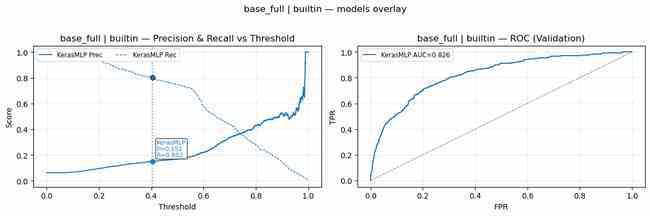


 Dataset: clean_full
Prepared dataset: Train=(55674, 20), Val=(7954, 20), Test=(15907, 20), Features=20, mode=numeric_only
  ◦ Sampling: builtin
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
    KerasMLP: thr=0.436  ValRec₁=0.800  ValPrec₁=0.159  ValROC₁=0.842


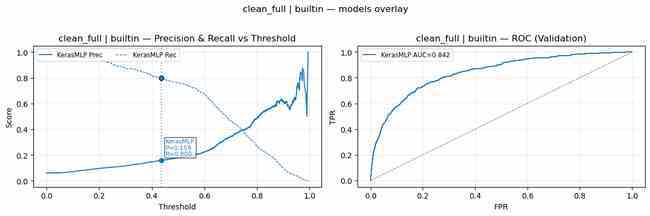


 Dataset: base_reduced
Prepared dataset: Train=(55896, 16), Val=(7986, 16), Test=(15971, 16), Features=16, mode=numeric_only
  ◦ Sampling: builtin
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
    KerasMLP: thr=0.384  ValRec₁=0.802  ValPrec₁=0.153  ValROC₁=0.829


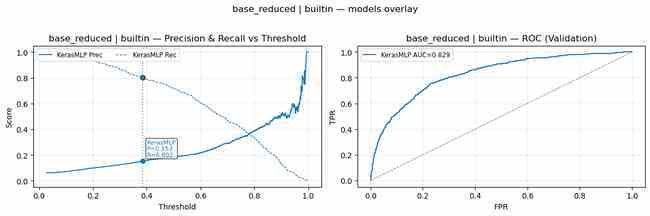


 Dataset: clean_reduced
Prepared dataset: Train=(55674, 16), Val=(7954, 16), Test=(15907, 16), Features=16, mode=numeric_only
  ◦ Sampling: builtin
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
    KerasMLP: thr=0.463  ValRec₁=0.800  ValPrec₁=0.153  ValROC₁=0.837


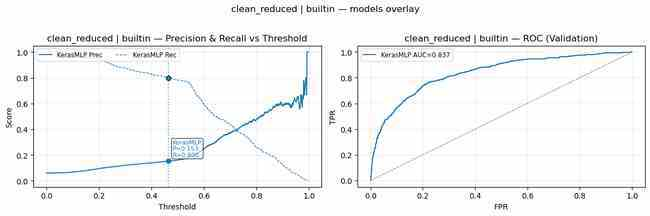


 Dataset: base_reduced_no_cat
Prepared dataset: Train=(55896, 10), Val=(7986, 10), Test=(15971, 10), Features=10, mode=numeric_only
  ◦ Sampling: builtin
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
    KerasMLP: thr=0.443  ValRec₁=0.800  ValPrec₁=0.156  ValROC₁=0.830


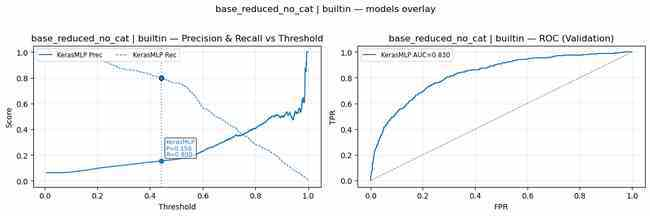


 Dataset: clean_reduced_no_cat
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: builtin
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
    KerasMLP: thr=0.448  ValRec₁=0.800  ValPrec₁=0.156  ValROC₁=0.840


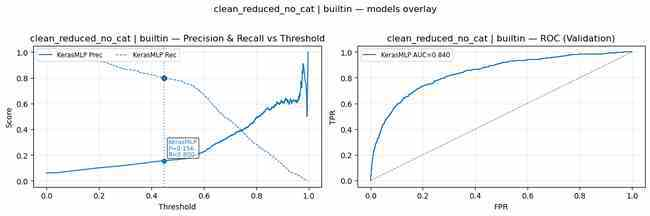


 Dataset: base_reduced_no_cat_raw
Prepared dataset: Train=(55896, 9), Val=(7986, 9), Test=(15971, 9), Features=9, mode=numeric_only
  ◦ Sampling: builtin
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step
    KerasMLP: thr=0.402  ValRec₁=0.800  ValPrec₁=0.150  ValROC₁=0.831


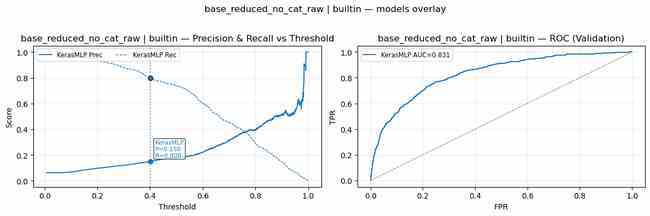


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: builtin
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step
    KerasMLP: thr=0.431  ValRec₁=0.800  ValPrec₁=0.154  ValROC₁=0.839


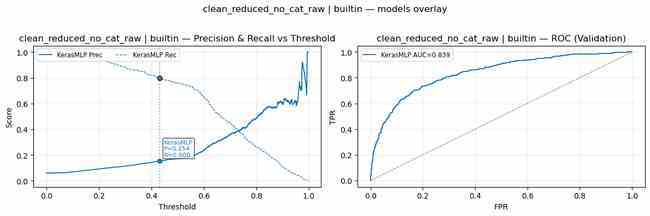


 Dataset: base_topcorr_only
Prepared dataset: Train=(55896, 4), Val=(7986, 4), Test=(15971, 4), Features=4, mode=numeric_only
  ◦ Sampling: builtin
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
    KerasMLP: thr=0.392  ValRec₁=0.800  ValPrec₁=0.138  ValROC₁=0.816


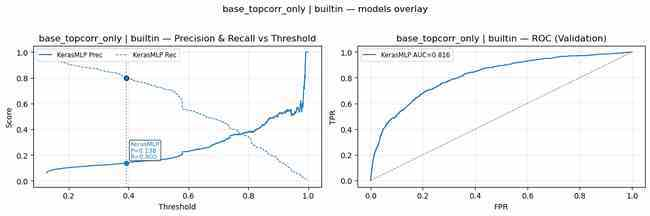


 Dataset: clean_topcorr_only
Prepared dataset: Train=(55674, 4), Val=(7954, 4), Test=(15907, 4), Features=4, mode=numeric_only
  ◦ Sampling: builtin
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
    KerasMLP: thr=0.453  ValRec₁=0.802  ValPrec₁=0.155  ValROC₁=0.831


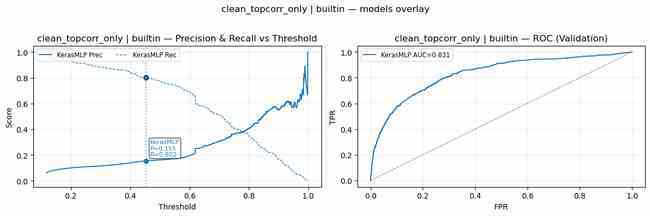


=== Keras MLP (recall=0.8) Summary ===


dataset     model sampling_method tuning_mode  \
9        clean_topcorr_only  KerasMLP         builtin      recall   
0                 base_full  KerasMLP         builtin      recall   
2              base_reduced  KerasMLP         builtin      recall   
1                clean_full  KerasMLP         builtin      recall   
3             clean_reduced  KerasMLP         builtin      recall   
4       base_reduced_no_cat  KerasMLP         builtin      recall   
5      clean_reduced_no_cat  KerasMLP         builtin      recall   
6   base_reduced_no_cat_raw  KerasMLP         builtin      recall   
7  clean_reduced_no_cat_raw  KerasMLP         builtin      recall   
8         base_topcorr_only  KerasMLP         builtin      recall   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
9            0.8          0.4528     0.1550    0.8021    0.2599    0.8315   
0            0.8          0.4045     0.1510    0.8020    0.2541    0.8259   
2            0.8          0.3842     0.1526    0.8020    0.2565    0.8295   
1            0.8          0.4361     0.1594    0.8000    0.2658    0.8415   
3            0.8          0.4634     0.1526    0.8000    0.2564    0.8369   
4            0.8          0.4434     0.1559    0.8000    0.2609    0.8296   
5            0.8          0.4477     0.1559    0.8000    0.2610    0.8404   
6            0.8          0.4016     0.1503    0.8000    0.2531    0.8310   
7            0.8          0.4306     0.1537    0.8000    0.2579    0.8393   
8            0.8          0.3919     0.1385    0.8000    0.2361    0.8164   

   test_prec1  test_rec1  test_f1_1  test_roc1  
9      0.1540     0.7784     0.2571     0.8229  
0      0.1559     0.8310     0.2626     0.8453  
2      0.1548     0.8120     0.2600     0.8464  
1      0.1607     0.7876     0.2669     0.8346  
3      0.1547     0.7959     0.2590     0.8296  
4      0.1602     0.8240     0.2682     0.8467  
5      0.1557     0.7876     0.2600     0.8341  
6      0.1555     0.8300     0.2619     0.8483  
7      0.1552     0.7928     0.2595     0.8337  
8      0.1440     0.8390     0.2459     0.8331

In [147]:
df_keras, keras_store = run_nn_pipeline_keras(
    datasets,
    sampling_method="builtin",   # or "smote"
    tuning_mode="recall",
    tuning_target=0.8,
    hidden_units=(256,128,64,32,16),
    dropout=0.2,
    lr=5e-4,
    batch_size=1024,
    epochs=50,
    show_plot=True,
    verbose=0
)


In [233]:
def _fit_keras_mlp_return_probs(
    X_train, y_train,
    X_val, y_val,
    X_test, y_test,                          # <-- IMPORTANT: include y_test here
    hidden_units=(256,128,64,32,16),
    activation="relu", dropout=0.0, l2=1e-4,
    optimizer="adam", lr=1e-3, batch_size=1024, epochs=50,
    early_stopping_patience=8, reduce_lr_patience=4, verbose=0
):
    """
    Builds, fits and returns (model, y_train_prob, y_val_prob, y_test_prob)
    Expects signature: (X_train, y_train, X_val, y_val, X_test, y_test, **kwargs)
    """
    import tensorflow as tf
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

    # ensure builder exists
    if "build_keras_mlp_5layer" not in globals():
        raise RuntimeError("build_keras_mlp_5layer not found. Define it or replace with another builder.")

    # get numeric arrays (keras prefers numpy arrays)
    def _to_np(x):
        if hasattr(x, "values"):
            return x.values.astype(np.float32)
        return np.asarray(x, dtype=np.float32)

    Xtr = _to_np(X_train)
    ytr = _to_np(y_train).reshape(-1)
    Xv = _to_np(X_val)
    yv = _to_np(y_val).reshape(-1)
    Xt = _to_np(X_test)
    yt = _to_np(y_test).reshape(-1)

    # build model
    model = build_keras_mlp_5layer(Xtr.shape[1], hidden_units=hidden_units, activation=activation, dropout=dropout, l2=l2)

    # optimizer
    if isinstance(optimizer, str) and optimizer.lower() == "adam":
        opt = tf.keras.optimizers.Adam(learning_rate=lr)
    else:
        opt = optimizer

    model.compile(optimizer=opt, loss="binary_crossentropy")

    callbacks = [
        EarlyStopping(monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True, verbose=0),
        ReduceLROnPlateau(monitor="val_loss", patience=reduce_lr_patience, factor=0.5, verbose=0)
    ]

    try:
        model.fit(Xtr, ytr, validation_data=(Xv, yv), epochs=epochs, batch_size=batch_size, callbacks=callbacks, verbose=verbose)
    except Exception:
        # second attempt if some inputs were pandas objects (already converted, but keep fallback)
        model.fit(Xtr, ytr, validation_data=(Xv, yv), epochs=epochs, batch_size=batch_size, callbacks=callbacks, verbose=verbose)

    # predict probs and flatten
    y_train_prob = model.predict(Xtr).reshape(-1)
    y_val_prob = model.predict(Xv).reshape(-1)
    y_test_prob = model.predict(Xt).reshape(-1)

    return model, y_train_prob, y_val_prob, y_test_prob


### Ensemble Pipeline (Voting & Stacking)

This pipeline builds an **ensemble** over a set of base learners (e.g., SVC, XGBoost, Logistic Regression, MLP) and evaluates different combination rules to improve robustness and minority-class performance across datasets.

**What it supports**
- **Base models**: controlled via `base_models=("svc","xgb","logreg","mlp")`
  - Optional Keras MLP config via `mlp_config`
  - `use_kernel_svc` to allow kernel SVC where appropriate
- **Resampling**: integrates the same imbalance strategies as other pipelines (`sampling_method` / `sampling_methods`)
- **Threshold tuning**: validation-driven (`tuning_mode`: `recall`, `precision`, or `max_f1`) with `tuning_target`
- **Split control**: `val_size`, `test_size`, consistent with your global conventions

**Ensemble strategies (select via `voting_method`)**
- `soft` (probability averaging): averages class-1 probabilities from all base models.  
  - Assumes calibrated or reasonably monotonic probabilities; tends to be stable.
- `weighted` (weighted soft voting): like `soft`, but applies model-specific weights (e.g., based on validation AUC/AP).  
  - Useful when some base learners consistently outperform others.
- `hard` (majority vote): uses class labels from each model and takes the majority class.  
  - Simple and robust when probability calibration is poor.
- `stack` (stacking): trains a **meta-learner** (`meta_learner`) on base-model validation predictions.  
  - Can learn non-linear combinations of base learners; strongest but requires careful CV to avoid leakage.

**Why this function exists**
To test whether **combining complementary inductive biases** (margin-based SVMs, boosted trees, linear/logistic baselines, and n


In [236]:
def run_ensemble_pipeline_voting(
    datasets,
    base_models=("svc","xgb","logreg","mlp"),
    mlp_config=None,
    use_kernel_svc=False,
    sampling_method="none",
    sampling_methods: list = None,
    tuning_mode="recall",
    tuning_target=0.8,
    ensemble_strategy="soft",   # kept for compatibility ("soft"|"stack")
    voting_method="soft",       # NEW: "soft"|"weighted"|"hard"|"stack"
    meta_learner=None,
    val_size=0.1,
    test_size=0.2,
    resample_random_state=SEED,
    show_plot=True
):
    """
    Ensemble runner that supports different voting methods:
      - soft: simple average of probs
      - weighted: average weighted by each base model's val ROC
      - hard: majority vote using per-model chosen thresholds
      - stack: stacking with meta-learner (as before)
    Returns: df_summary, ensemble_store
    """
    # reuse previous ensemble helper pieces (mlp builder & keras helper)
    mlp_config = mlp_config or {}
    methods_to_run = sampling_methods if sampling_methods is not None else [sampling_method or "none"]
    ensemble_store = {}
    rows = []
    if meta_learner is None:
        meta_learner = LogisticRegression(max_iter=2000)

    for ds_name, df in datasets.items():
        print(f"\n Dataset: {ds_name}")
        try:
            prep = prepare_dataset_df(df, target=TARGET, test_size=test_size, val_size=val_size,
                                      random_state=SEED, scale_mode="numeric_only")
            X_train = prep["X_train_df"]; y_train = prep["y_train"]
            X_val = prep["X_val_df"]; y_val = prep["y_val"]
            X_test = prep["X_test_df"]; y_test = prep["y_test"]

            ensemble_store.setdefault(ds_name, {})

            for method in methods_to_run:
                print(f"  ◦ Sampling: {method}")
                if method in (None, "none", "passthrough", "raw"):
                    X_tr_use, y_tr_use = X_train.copy(), y_train.copy()
                else:
                    X_tr_use, y_tr_use = resample_train(X_train, y_train, method=method, random_state=resample_random_state)

                # Train all requested base models and collect their probs + per-model thresholds + val ROC
                base_names = []
                val_probs_by_model = {}
                train_probs_by_model = {}
                test_probs_by_model = {}
                per_model_thr = {}
                per_model_valroc = {}
                artifacts = {}

                # Helper to train/score a model object and get per-split probs + threshold
                def _fit_and_score_model(name, model_obj):
                    # fit (already calibrated if necessary when created)
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        model_obj.fit(X_tr_use, y_tr_use)
                    # scores robustly
                    y_tr_prob = safe_predict_scores(model_obj, X_tr_use)
                    y_val_prob = safe_predict_scores(model_obj, X_val)
                    y_te_prob = safe_predict_scores(model_obj, X_test)
                    # choose a threshold on val per tuning_mode
                    if tuning_mode == "recall":
                        thr, thr_info = choose_threshold_for_recall_from_scores(y_val, y_val_prob, target_recall=tuning_target)
                    elif tuning_mode == "precision":
                        thr, thr_info = choose_threshold_for_precision_from_scores(y_val, y_val_prob, target_precision=tuning_target)
                    elif tuning_mode == "max_f1":
                        thr, thr_info = choose_threshold_max_f1_from_scores(y_val, y_val_prob)
                    else:
                        thr, thr_info = 0.5, {"mode":"none"}
                    # compute val ROC for weighting
                    try:
                        roc1 = roc_auc_score(y_val, y_val_prob)
                    except Exception:
                        roc1 = 0.5
                    return y_tr_prob, y_val_prob, y_te_prob, float(thr), thr_info, float(roc1)

                # --- Build base models in order and collect ---
                # SVC / LinearSVC
                if "svc" in base_models:
                    try:
                        if use_kernel_svc:
                            from sklearn.svm import SVC
                            base = SVC(kernel="rbf", probability=False, random_state=SEED)
                            calib = CalibratedClassifierCV(base, cv=3)
                            # train+calibrate inside helper
                            y_tr_prob, y_val_prob, y_te_prob, thr, thr_info, roc1 = _fit_and_score_model("SVC", calib)
                            model_obj = calib
                        else:
                            from sklearn.svm import LinearSVC
                            base = LinearSVC(max_iter=10000, random_state=SEED)
                            calib = CalibratedClassifierCV(base, cv=3)
                            y_tr_prob, y_val_prob, y_te_prob, thr, thr_info, roc1 = _fit_and_score_model("LinearSVC", calib)
                            model_obj = calib
                        name = "SVC_kernel" if use_kernel_svc else "LinearSVC_calib"
                        base_names.append(name)
                        train_probs_by_model[name] = y_tr_prob
                        val_probs_by_model[name] = y_val_prob
                        test_probs_by_model[name] = y_te_prob
                        per_model_thr[name] = thr
                        per_model_valroc[name] = roc1
                        artifacts[name] = {"model": model_obj}
                        print(f"    Trained {name}: thr={thr:.3f} val_roc={roc1:.3f}")
                    except Exception as e:
                        print(f"    SVC failed: {e}")

                # XGBoost
                if "xgb" in base_models:
                    try:
                        from xgboost import XGBClassifier
                        n_pos = int((y_tr_use == 1).sum()); n_neg = int((y_tr_use == 0).sum())
                        scale_pos_weight = float(n_neg) / float(max(1, n_pos))
                        xgb = XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1,
                                            use_label_encoder=False, eval_metric="logloss",
                                            scale_pos_weight=scale_pos_weight, random_state=SEED, n_jobs=-1, verbosity=0)
                        y_tr_prob, y_val_prob, y_te_prob, thr, thr_info, roc1 = _fit_and_score_model("XGBoost", xgb)
                        name = "XGBoost"
                        base_names.append(name)
                        train_probs_by_model[name] = y_tr_prob
                        val_probs_by_model[name] = y_val_prob
                        test_probs_by_model[name] = y_te_prob
                        per_model_thr[name] = thr
                        per_model_valroc[name] = roc1
                        artifacts[name] = {"model": xgb}
                        print(f"    Trained {name}: thr={thr:.3f} val_roc={roc1:.3f}")
                    except Exception as e:
                        print(f"    XGBoost failed: {e}")

                # Logistic Regression
                if "logreg" in base_models:
                    try:
                        from sklearn.linear_model import LogisticRegression as SkLogReg
                        lr = SkLogReg(max_iter=2000)
                        y_tr_prob, y_val_prob, y_te_prob, thr, thr_info, roc1 = _fit_and_score_model("LogReg", lr)
                        name = "LogisticRegression"
                        base_names.append(name)
                        train_probs_by_model[name] = y_tr_prob
                        val_probs_by_model[name] = y_val_prob
                        test_probs_by_model[name] = y_te_prob
                        per_model_thr[name] = thr
                        per_model_valroc[name] = roc1
                        artifacts[name] = {"model": lr}
                        print(f"    Trained {name}: thr={thr:.3f} val_roc={roc1:.3f}")
                    except Exception as e:
                        print(f"    LogReg failed: {e}")

                # Keras MLP
                if "mlp" in base_models:
                    try:
                        # use your _fit_keras_mlp_return_probs helper; it fits on (train,val) and returns probs
                        mlp_conf = {
                            "hidden_units": (256,128,64,32,16),
                            "activation": "relu",
                            "dropout": 0.0,
                            "l2": 1e-4,
                            "optimizer": "adam",
                            "lr": 1e-3,
                            "batch_size": 1024,
                            "epochs": 50,
                            "early_stopping_patience": 8,
                            "reduce_lr_patience": 4,
                            "verbose": 0
                        }
                        mlp_conf.update(mlp_config or {})
                        mlp_model, y_tr_prob, y_val_prob, y_te_prob = _fit_keras_mlp_return_probs(
                            X_tr_use, y_tr_use, X_val,y_val, X_test,y_test,
                            hidden_units=mlp_conf["hidden_units"],
                            activation=mlp_conf["activation"],
                            dropout=mlp_conf["dropout"],
                            l2=mlp_conf["l2"],
                            optimizer=mlp_conf["optimizer"],
                            lr=mlp_conf["lr"],
                            batch_size=mlp_conf["batch_size"],
                            epochs=mlp_conf["epochs"],
                            early_stopping_patience=mlp_conf["early_stopping_patience"],
                            reduce_lr_patience=mlp_conf["reduce_lr_patience"],
                            verbose=mlp_conf["verbose"]
                        )
                        name = "KerasMLP"
                        roc1 = roc_auc_score(y_val, y_val_prob) if len(np.unique(y_val))>1 else 0.5
                        # choose threshold
                        if tuning_mode == "recall":
                            thr, thr_info = choose_threshold_for_recall_from_scores(y_val, y_val_prob, target_recall=tuning_target)
                        elif tuning_mode == "precision":
                            thr, thr_info = choose_threshold_for_precision_from_scores(y_val, y_val_prob, target_precision=tuning_target)
                        elif tuning_mode == "max_f1":
                            thr, thr_info = choose_threshold_max_f1_from_scores(y_val, y_val_prob)
                        else:
                            thr, thr_info = 0.5, {"mode":"none"}
                        base_names.append(name)
                        train_probs_by_model[name] = y_tr_prob
                        val_probs_by_model[name] = y_val_prob
                        test_probs_by_model[name] = y_te_prob
                        per_model_thr[name] = thr
                        per_model_valroc[name] = roc1
                        artifacts[name] = {"model": mlp_model}
                        print(f"    Trained {name}: thr={thr:.3f} val_roc={roc1:.3f}")
                    except Exception as e:
                        print(f"    MLP failed: {e}")

                # If nothing trained, skip
                if len(base_names) == 0:
                    print("    No models trained; skipping ensemble for this dataset+method.")
                    continue

                # --- Create ensemble predictions according to voting_method ---
                val_stack = np.vstack([val_probs_by_model[n] for n in base_names]).T
                train_stack = np.vstack([train_probs_by_model[n] for n in base_names]).T
                test_stack = np.vstack([test_probs_by_model[n] for n in base_names]).T

                if voting_method == "soft":
                    ens_val_prob = np.nanmean(val_stack, axis=1)
                    ens_train_prob = np.nanmean(train_stack, axis=1)
                    ens_test_prob = np.nanmean(test_stack, axis=1)

                elif voting_method == "weighted":
                    # weights = val ROC
                    weights = np.array([per_model_valroc[n] for n in base_names], dtype=float)
                    if weights.sum() <= 0:
                        weights = np.ones_like(weights)
                    weights = weights / weights.sum()
                    ens_val_prob = (val_stack * weights[None,:]).sum(axis=1)
                    ens_train_prob = (train_stack * weights[None,:]).sum(axis=1)
                    ens_test_prob = (test_stack * weights[None,:]).sum(axis=1)

                elif voting_method == "hard":
                    # compute per-model binary preds on val/test using those per-model thresholds
                    val_bin = np.vstack([(val_probs_by_model[n] >= per_model_thr[n]).astype(int) for n in base_names]).T
                    train_bin = np.vstack([(train_probs_by_model[n] >= per_model_thr[n]).astype(int) for n in base_names]).T
                    test_bin = np.vstack([(test_probs_by_model[n] >= per_model_thr[n]).astype(int) for n in base_names]).T
                    # majority vote -> produce binary predictions. For consistent interface, create "prob" as mean of votes
                    ens_val_bin = (val_bin.sum(axis=1) >= (len(base_names)/2)).astype(int)
                    ens_train_bin = (train_bin.sum(axis=1) >= (len(base_names)/2)).astype(int)
                    ens_test_bin = (test_bin.sum(axis=1) >= (len(base_names)/2)).astype(int)
                    # convert to pseudo-prob (mean of votes)
                    ens_val_prob = ens_val_bin.astype(float)
                    ens_train_prob = ens_train_bin.astype(float)
                    ens_test_prob = ens_test_bin.astype(float)

                else:  # "stack"
                    try:
                        # train meta on val_stack -> predict probs
                        meta = meta_learner
                        # meta expects 2D features; fit on val predictions to map base->label
                        meta.fit(val_stack, y_val)
                        # meta predict proba for train/val/test stacks
                        if hasattr(meta, "predict_proba"):
                            ens_train_prob = meta.predict_proba(train_stack)[:,1]
                            ens_val_prob = meta.predict_proba(val_stack)[:,1]
                            ens_test_prob = meta.predict_proba(test_stack)[:,1]
                        else:
                            ens_train_prob = meta.decision_function(train_stack)
                            ens_val_prob = meta.decision_function(val_stack)
                            ens_test_prob = meta.decision_function(test_stack)
                            # scale decision outputs to [0,1]
                            def _scale(a):
                                a = np.asarray(a, dtype=float)
                                mn, mx = np.nanmin(a), np.nanmax(a)
                                return (a - mn) / (mx - mn) if mx > mn else np.zeros_like(a)
                            ens_train_prob = _scale(ens_train_prob)
                            ens_val_prob = _scale(ens_val_prob)
                            ens_test_prob = _scale(ens_test_prob)
                    except Exception as e:
                        print(f"    stacking failed; falling back to soft avg: {e}")
                        ens_val_prob = np.nanmean(val_stack, axis=1)
                        ens_train_prob = np.nanmean(train_stack, axis=1)
                        ens_test_prob = np.nanmean(test_stack, axis=1)

                # choose threshold on ensemble val probs
                if X_val is None or y_val is None:
                    thr, thr_info = 0.5, {"mode":"no_val_fallback"}
                else:
                    if tuning_mode == "recall":
                        thr, thr_info = choose_threshold_for_recall_from_scores(y_val, ens_val_prob, target_recall=tuning_target)
                    elif tuning_mode == "precision":
                        thr, thr_info = choose_threshold_for_precision_from_scores(y_val, ens_val_prob, target_precision=tuning_target)
                    elif tuning_mode == "max_f1":
                        thr, thr_info = choose_threshold_max_f1_from_scores(y_val, ens_val_prob)
                    else:
                        thr, thr_info = 0.5, {"mode":"none"}

                # compute final standardized metrics
                m_train = compute_metrics_from_probs(y_tr_use, ens_train_prob, threshold=thr)
                m_val = compute_metrics_from_probs(y_val, ens_val_prob, threshold=thr)
                m_test = compute_metrics_from_probs(y_test, ens_test_prob, threshold=thr)

                # store artifacts
                ensemble_name = f"ensemble_{voting_method}"
                ensemble_store[ds_name].setdefault(method, {})[ensemble_name] = {
                    "artifacts": artifacts,
                    "base_names": base_names,
                    "per_model_thr": per_model_thr,
                    "per_model_valroc": per_model_valroc,
                    "scores": {"train": ens_train_prob, "val": ens_val_prob, "test": ens_test_prob},
                    "threshold": float(thr),
                    "threshold_info": thr_info,
                    "metrics": {"train": m_train, "val": m_val, "test": m_test}
                }

                rows.append({
                    "dataset": ds_name,
                    "model": f"Ensemble[{voting_method}]",
                    "sampling_method": method,
                    "tuning_mode": tuning_mode,
                    "tuning_target": tuning_target,
                    "threshold_used": float(thr),
                    "val_prec1": m_val["precision_by_class"][1],
                    "val_rec1": m_val["recall_by_class"][1],
                    "val_f1_1": m_val["f1_by_class"][1],
                    "val_roc1": m_val["roc_auc_class1"],
                    "test_prec1": m_test["precision_by_class"][1],
                    "test_rec1": m_test["recall_by_class"][1],
                    "test_f1_1": m_test["f1_by_class"][1],
                    "test_roc1": m_test["roc_auc_class1"]
                })

                print(f"    Ensemble({voting_method}): thr={thr:.3f}  ValRec₁={m_val['recall_by_class'][1]:.3f}  ValPrec₁={m_val['precision_by_class'][1]:.3f}  ValROC₁={m_val['roc_auc_class1']:.3f}")

                # plotting
                if show_plot:
                    try:
                        label_to_probs = {**val_probs_by_model, "ENSEMBLE": ens_val_prob}
                        _plot_pr_roc_inline(y_val, label_to_probs, {"ENSEMBLE": thr}, dataset_name=f"{ds_name} | {method}", show=True)
                    except Exception as e:
                        print(f"    plotting failed: {e}")

        except Exception as e:
            print(f"  Error processing {ds_name}: {e}")

    df_summary = pd.DataFrame(rows)
    if not df_summary.empty:
        key = "val_prec1" if tuning_mode == "precision" else "val_rec1"
        df_summary = df_summary.round(4).sort_values(by=key, ascending=False)
        print(f"\n=== Ensemble ({voting_method}) Summary ===")
        display(df_summary)
    else:
        print("No results generated.")

    return df_summary, ensemble_store

### Serial/Cascading Ensemble Pipeline

This pipeline implements a **cascade (serial) ensemble**: models are trained in a fixed order (e.g., `svc → xgb → logreg → mlp`). At each stage, the model predicts on the current pool, a **validation-driven threshold** is chosen (recall/precision/max-F1), and **positives are “claimed” and removed** from the pool passed to the next stage. The final prediction is the **union of positives across all stages**—prioritizing early-stage models for cases they handle best and delegating the remaining harder cases downstream.

**Why this is included**
- To test whether **divide-and-conquer** sequencing improves **minority-class recall** while controlling false alarms.
- To compare against voting/stacking by enforcing **specialization**: each subsequent model focuses on **residual** (still-negative) samples.
- To keep evaluation aligned with the rest of the project: same **resampling**, **threshold tuning**, **PR/ROC** visualization, and **train/val/test** protocol.

**Key characteristics**
- **Stage-wise thresholding:** Each model selects its own operating point on VAL (recall/precision/max-F1).
- **Residual focusing:** Later models see only samples not flagged earlier.
- **Final union decision:** A sample is positive if any stage marks it positive.
- **Compatible with resampling:** Uses the same `resample_train(...)` options as other pipelines.


In [239]:
# ---------------------------------------------------------------------
# Serial / Cascading ensemble pipeline
# ---------------------------------------------------------------------
def run_ensemble_serial_pipeline(
    datasets,
    base_order=("svc","xgb","logreg"),
    mlp_config=None,
    use_kernel_svc=False,
    sampling_method="none",
    sampling_methods: list = None,
    tuning_mode="recall",
    tuning_target=0.8,
    val_size=0.1,
    test_size=0.2,
    resample_random_state=SEED,
    show_plot=True
):
    """
    Serial/cascade ensemble:
      - train base models in order (list)
      - for each model obtain per-sample probs, choose threshold on VAL
      - mark positives at that stage; remove them from the pool given to subsequent models
      - final prediction = union of positives from all stages
    Returns: df_summary, serial_store
    """
    mlp_config = mlp_config or {}
    methods_to_run = sampling_methods if sampling_methods is not None else [sampling_method or "none"]
    serial_store = {}
    rows = []

    for ds_name, df in datasets.items():
        print(f"\n Dataset: {ds_name}")
        try:
            prep = prepare_dataset_df(df, target=TARGET, test_size=test_size, val_size=val_size,
                                      random_state=SEED, scale_mode="numeric_only")
            X_train = prep["X_train_df"]; y_train = prep["y_train"]
            X_val = prep["X_val_df"]; y_val = prep["y_val"]
            X_test = prep["X_test_df"]; y_test = prep["y_test"]

            serial_store.setdefault(ds_name, {})

            for method in methods_to_run:
                print(f"  ◦ Sampling: {method}")
                if method in (None, "none", "passthrough", "raw"):
                    X_tr_use, y_tr_use = X_train.copy(), y_train.copy()
                else:
                    X_tr_use, y_tr_use = resample_train(X_train, y_train, method=method, random_state=resample_random_state)

                n_train = X_tr_use.shape[0]
                # keep track of which indices remain (train,val,test)
                # for val/test we need masks to remove already predicted positives
                val_mask_remaining = np.ones(len(y_val), dtype=bool)
                test_mask_remaining = np.ones(len(y_test), dtype=bool)
                train_mask_remaining = np.ones(len(y_tr_use), dtype=bool)

                # accumulators for final predicted positives
                final_train_pos = np.zeros(len(y_tr_use), dtype=int)
                final_val_pos = np.zeros(len(y_val), dtype=int)
                final_test_pos = np.zeros(len(y_test), dtype=int)

                model_artifacts = {}
                stage = 0

                for model_key in base_order:
                    stage += 1
                    name = model_key
                    print(f"    ➤ Stage {stage}: {model_key}")

                    # Build model instance (mirrors run_ensemble_pipeline behavior)
                    try:
                        if model_key == "svc":
                            if use_kernel_svc:
                                from sklearn.svm import SVC
                                base = SVC(kernel="rbf", probability=False, random_state=SEED)
                                model_inst = CalibratedClassifierCV(base, cv=3)
                            else:
                                from sklearn.svm import LinearSVC
                                base = LinearSVC(max_iter=10000, random_state=SEED)
                                model_inst = CalibratedClassifierCV(base, cv=3)
                        elif model_key == "xgb":
                            from xgboost import XGBClassifier
                            n_pos = int((y_tr_use == 1).sum()); n_neg = int((y_tr_use == 0).sum())
                            scale_pos_weight = float(n_neg) / float(max(1, n_pos))
                            model_inst = XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1,
                                                       use_label_encoder=False, eval_metric="logloss",
                                                       scale_pos_weight=scale_pos_weight, random_state=SEED, n_jobs=-1, verbosity=0)
                        elif model_key == "logreg":
                            from sklearn.linear_model import LogisticRegression as SkLogReg
                            model_inst = SkLogReg(max_iter=2000)
                        elif model_key == "mlp":
                            # train keras MLP on the whole sample (we reuse _fit_keras_mlp_return_probs)
                            model_inst = None  # handled below
                        else:
                            print(f"      Unknown model key: {model_key}; skipping")
                            continue
                    except Exception as e:
                        print(f"      Could not create model for {model_key}: {e}")
                        continue

                    # Fit model on current remaining TRAIN pool
                    try:
                        if model_key == "mlp":
                            # Keras MLP expects dense arrays; train on remaining indices
                            Xtr_stage = X_tr_use[train_mask_remaining].reset_index(drop=True)
                            ytr_stage = y_tr_use[train_mask_remaining].reset_index(drop=True)
                            if len(ytr_stage) < 20:
                                print("      Too few remaining train rows for MLP; skipping MLP stage.")
                                continue
                            mlp_conf = {
                                "hidden_units": (256,128,64,32,16),
                                "activation": "relu",
                                "dropout": 0.0,
                                "l2": 1e-4,
                                "optimizer": "adam",
                                "lr": 1e-3,
                                "batch_size": 1024,
                                "epochs": 50,
                                "early_stopping_patience": 8,
                                "reduce_lr_patience": 4,
                                "verbose": 0
                            }
                            mlp_conf.update(mlp_config or {})
                            mlp_model, y_tr_prob_stage, y_val_prob_stage, y_test_prob_stage = _fit_keras_mlp_return_probs(
                                Xtr_stage, ytr_stage,
                                X_val[val_mask_remaining], y_val[val_mask_remaining] if np.any(val_mask_remaining) else X_val,
                                X_test[test_mask_remaining], y_test[test_mask_remaining] if np.any(test_mask_remaining) else X_test,
                                hidden_units=mlp_conf["hidden_units"],
                                activation=mlp_conf["activation"],
                                dropout=mlp_conf["dropout"],
                                l2=mlp_conf["l2"],
                                optimizer=mlp_conf["optimizer"],
                                lr=mlp_conf["lr"],
                                batch_size=mlp_conf["batch_size"],
                                epochs=mlp_conf["epochs"],
                                early_stopping_patience=mlp_conf["early_stopping_patience"],
                                reduce_lr_patience=mlp_conf["reduce_lr_patience"],
                                verbose=mlp_conf["verbose"]
                            )
                            model_artifacts[model_key] = {"model": mlp_model}
                            # Need to map stage train probs back into full-train indexing
                            # create arrays of length full train and fill only remaining indices
                            y_tr_prob_full = np.zeros(len(y_tr_use), dtype=float)
                            y_tr_prob_full[train_mask_remaining] = y_tr_prob_stage
                            y_val_prob_full = np.zeros(len(y_val), dtype=float)
                            y_val_prob_full[val_mask_remaining] = y_val_prob_stage
                            y_test_prob_full = np.zeros(len(y_test), dtype=float)
                            y_test_prob_full[test_mask_remaining] = y_test_prob_stage
                        else:
                            # standard sklearn model
                            Xtr_stage = X_tr_use[train_mask_remaining].reset_index(drop=True)
                            ytr_stage = y_tr_use[train_mask_remaining].reset_index(drop=True)
                            with warnings.catch_warnings():
                                warnings.simplefilter("ignore")
                                model_inst.fit(Xtr_stage, ytr_stage)
                            model_artifacts[model_key] = {"model": model_inst}
                            # compute scores on full val/test/train but we only use remaining masks for threshold tuning
                            # predict probs for entire sets (so we can apply thresholds to full arrays)
                            y_tr_prob_full = safe_predict_scores(model_inst, X_tr_use)
                            y_val_prob_full = safe_predict_scores(model_inst, X_val)
                            y_test_prob_full = safe_predict_scores(model_inst, X_test)
                    except Exception as e:
                        print(f"      Fit failed for stage {model_key}: {e}")
                        continue

                    # Choose threshold based on validation remaining mask (only consider remaining val rows)
                    if np.any(val_mask_remaining):
                        y_val_for_thr = y_val[val_mask_remaining]
                        val_probs_for_thr = y_val_prob_full[val_mask_remaining]
                    else:
                        y_val_for_thr = y_val
                        val_probs_for_thr = y_val_prob_full

                    if len(y_val_for_thr) == 0 or len(np.unique(y_val_for_thr)) == 1:
                        thr, thr_info = 0.5, {"mode":"no_val"}
                    else:
                        if tuning_mode == "recall":
                            thr, thr_info = choose_threshold_for_recall_from_scores(y_val_for_thr, val_probs_for_thr, target_recall=tuning_target)
                        elif tuning_mode == "precision":
                            thr, thr_info = choose_threshold_for_precision_from_scores(y_val_for_thr, val_probs_for_thr, target_precision=tuning_target)
                        elif tuning_mode == "max_f1":
                            thr, thr_info = choose_threshold_max_f1_from_scores(y_val_for_thr, val_probs_for_thr)
                        else:
                            thr, thr_info = 0.5, {"mode":"none"}

                    # Apply threshold to full arrays to get binary positives at this stage
                    stage_train_pos = (y_tr_prob_full >= thr).astype(int)
                    stage_val_pos = (y_val_prob_full >= thr).astype(int)
                    stage_test_pos = (y_test_prob_full >= thr).astype(int)

                    # Union positives into final prediction
                    final_train_pos = np.logical_or(final_train_pos, stage_train_pos).astype(int)
                    final_val_pos = np.logical_or(final_val_pos, stage_val_pos).astype(int)
                    final_test_pos = np.logical_or(final_test_pos, stage_test_pos).astype(int)

                    # Remove those indices from remaining masks so next stage sees only negatives
                    train_mask_remaining = np.logical_and(train_mask_remaining, np.logical_not(stage_train_pos))
                    val_mask_remaining = np.logical_and(val_mask_remaining, np.logical_not(stage_val_pos))
                    test_mask_remaining = np.logical_and(test_mask_remaining, np.logical_not(stage_test_pos))

                    # store stage artifact
                    serial_store[ds_name].setdefault(method, {})[f"stage_{stage}_{model_key}"] = {
                        "model": model_artifacts.get(model_key),
                        "threshold": float(thr),
                        "threshold_info": thr_info,
                        "stage_pos_counts": {"train": int(stage_train_pos.sum()), "val": int(stage_val_pos.sum()), "test": int(stage_test_pos.sum())}
                    }

                    print(f"      Stage {stage} {model_key}: thr={thr:.3f}  new_pos_val={int(stage_val_pos.sum())}  remaining_val={int(val_mask_remaining.sum())}")

                    # early stop: if no remaining negatives in val and test, stop cascade
                    if (val_mask_remaining.sum() == 0) and (test_mask_remaining.sum() == 0):
                        print("      ⏹ No remaining negatives in val/test — stopping cascade early.")
                        break

                # After cascade, construct final ensemble probabilities as max of stage probs (proxy) or use union binary preds -> we'll create prob_proxy as mean of positives across stages
                # Simple proxy: ensemble_prob = mean of per-stage indicator of being positive (so value in [0,1])
                # To compute this we need per-stage binary arrays — but we tracked final union only. Simpler: for reporting convert final binary to float pseudo-prob
                ens_train_prob = final_train_pos.astype(float)
                ens_val_prob = final_val_pos.astype(float)
                ens_test_prob = final_test_pos.astype(float)

                # metrics
                # compute metrics via compute_metrics_from_probs (expects continuous probs + threshold)
                # we will pick threshold 0.5 (since binary) and also compute support
                thr_final = 0.5
                m_train = compute_metrics_from_probs(y_tr_use, ens_train_prob, threshold=thr_final)
                m_val = compute_metrics_from_probs(y_val, ens_val_prob, threshold=thr_final)
                m_test = compute_metrics_from_probs(y_test, ens_test_prob, threshold=thr_final)

                # store final
                serial_store[ds_name].setdefault(method, {})["cascade_union"] = {
                    "stages": list(serial_store[ds_name].get(method, {}).keys()),
                    "scores": {"train": ens_train_prob, "val": ens_val_prob, "test": ens_test_prob},
                    "threshold": thr_final,
                    "metrics": {"train": m_train, "val": m_val, "test": m_test}
                }

                # record
                rows.append({
                    "dataset": ds_name,
                    "model": "SerialEnsemble",
                    "sampling_method": method,
                    "tuning_mode": tuning_mode,
                    "tuning_target": tuning_target,
                    "threshold_used": thr_final,
                    "val_prec1": m_val["precision_by_class"][1],
                    "val_rec1": m_val["recall_by_class"][1],
                    "val_f1_1": m_val["f1_by_class"][1],
                    "val_roc1": m_val["roc_auc_class1"],
                    "test_prec1": m_test["precision_by_class"][1],
                    "test_rec1": m_test["recall_by_class"][1],
                    "test_f1_1": m_test["f1_by_class"][1],
                    "test_roc1": m_test["roc_auc_class1"]
                })

                print(f"    Serial ensemble final: ValRec₁={m_val['recall_by_class'][1]:.3f} ValPrec₁={m_val['precision_by_class'][1]:.3f} ValROC₁={m_val['roc_auc_class1']:.3f}")

                # plot final (plot base val probs + final ensemble)
                if show_plot:
                    try:
                        # pick a subset of base val probs for plotting (those trained)
                        label_to_probs = {}
                        for key in serial_store[ds_name][method].keys():
                            # include stage-level val probs? we didn't store them all explicitly; skip heavy plotting here
                            pass
                        # plot only final ensemble vs true val
                        _plot_pr_roc_inline(y_val, {"SerialEnsemble": ens_val_prob}, {"SerialEnsemble": thr_final}, dataset_name=f"{ds_name} | {method}", show=True)
                    except Exception as e:
                        print(f"    serial plotting failed: {e}")

        except Exception as e:
            print(f"  Error processing {ds_name}: {e}")

    # summary
    df_summary = pd.DataFrame(rows)
    if not df_summary.empty:
        key = "val_prec1" if tuning_mode == "precision" else "val_rec1"
        df_summary = df_summary.round(4).sort_values(by=key, ascending=False)
        print("\n=== Serial Ensemble Summary ===")
        display(df_summary)
    else:
        print("No results generated.")

    return df_summary, serial_store

## Try al modesl against all datasets to find which dataset is giving better reprediction

### Recall Tuning


 Dataset: base_full
Prepared dataset: Train=(55896, 20), Val=(7986, 20), Test=(15971, 20), Features=20, mode=numeric_only
  ◦ Sampling: smote
    ➤ Stage 1: xgb
      Stage 1 xgb: thr=0.071  new_pos_val=3550  remaining_val=4436
    ➤ Stage 2: svc
      Stage 2 svc: thr=0.008  new_pos_val=6931  remaining_val=906
    ➤ Stage 3: logreg
      Stage 3 logreg: thr=0.001  new_pos_val=7843  remaining_val=85
    Serial ensemble final: ValRec₁=1.000 ValPrec₁=0.063 ValROC₁=0.506


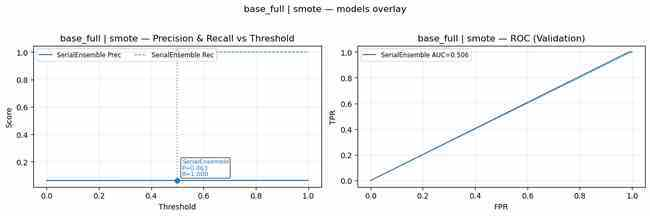


 Dataset: clean_full
Prepared dataset: Train=(55674, 20), Val=(7954, 20), Test=(15907, 20), Features=20, mode=numeric_only
  ◦ Sampling: smote
    ➤ Stage 1: xgb
      Stage 1 xgb: thr=0.065  new_pos_val=3738  remaining_val=4216
    ➤ Stage 2: svc
      Stage 2 svc: thr=0.001  new_pos_val=7844  remaining_val=1
    ➤ Stage 3: logreg
      Fit failed for stage logreg: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0
    Serial ensemble final: ValRec₁=1.000 ValPrec₁=0.061 ValROC₁=0.500


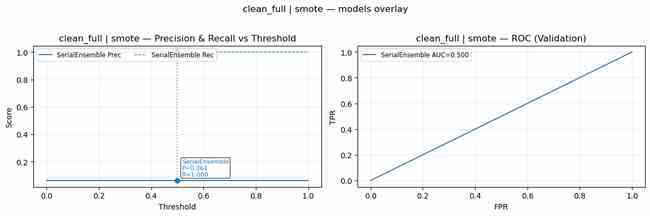


 Dataset: base_reduced
Prepared dataset: Train=(55896, 16), Val=(7986, 16), Test=(15971, 16), Features=16, mode=numeric_only
  ◦ Sampling: smote
    ➤ Stage 1: xgb
      Stage 1 xgb: thr=0.070  new_pos_val=3471  remaining_val=4515
    ➤ Stage 2: svc
      Stage 2 svc: thr=0.008  new_pos_val=6510  remaining_val=1123
    ➤ Stage 3: logreg
      Stage 3 logreg: thr=0.003  new_pos_val=6482  remaining_val=166
    Serial ensemble final: ValRec₁=0.998 ValPrec₁=0.064 ValROC₁=0.510


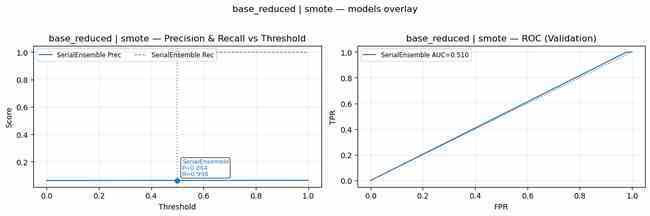


 Dataset: clean_reduced
Prepared dataset: Train=(55674, 16), Val=(7954, 16), Test=(15907, 16), Features=16, mode=numeric_only
  ◦ Sampling: smote
    ➤ Stage 1: xgb
      Stage 1 xgb: thr=0.066  new_pos_val=3702  remaining_val=4252
    ➤ Stage 2: svc
      Stage 2 svc: thr=0.006  new_pos_val=6433  remaining_val=800
    ➤ Stage 3: logreg
      Stage 3 logreg: thr=0.001  new_pos_val=7558  remaining_val=94
    Serial ensemble final: ValRec₁=1.000 ValPrec₁=0.062 ValROC₁=0.506


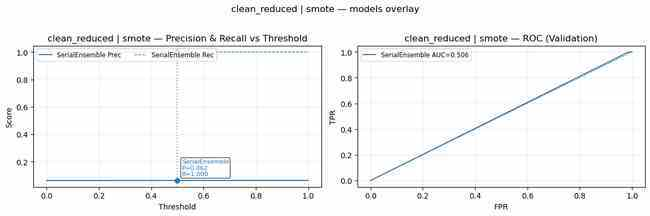


 Dataset: base_reduced_no_cat
Prepared dataset: Train=(55896, 10), Val=(7986, 10), Test=(15971, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    ➤ Stage 1: xgb
      Stage 1 xgb: thr=0.086  new_pos_val=3422  remaining_val=4564
    ➤ Stage 2: svc
      Stage 2 svc: thr=0.009  new_pos_val=5536  remaining_val=1163
    ➤ Stage 3: logreg
      Stage 3 logreg: thr=0.001  new_pos_val=7750  remaining_val=4
    Serial ensemble final: ValRec₁=1.000 ValPrec₁=0.063 ValROC₁=0.500


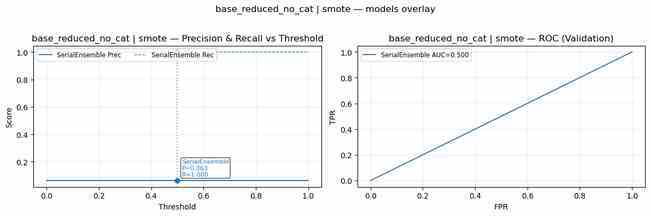


 Dataset: clean_reduced_no_cat
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    ➤ Stage 1: xgb
      Stage 1 xgb: thr=0.084  new_pos_val=3503  remaining_val=4451
    ➤ Stage 2: svc
      Stage 2 svc: thr=0.007  new_pos_val=7363  remaining_val=157
    ➤ Stage 3: logreg
      Fit failed for stage logreg: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0
    Serial ensemble final: ValRec₁=1.000 ValPrec₁=0.062 ValROC₁=0.511


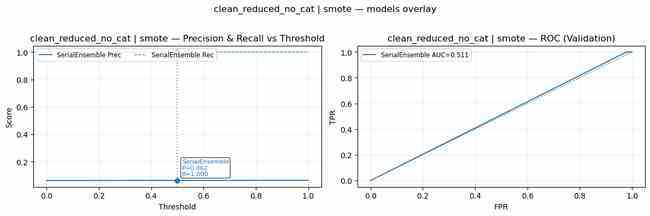


 Dataset: base_reduced_no_cat_raw
Prepared dataset: Train=(55896, 9), Val=(7986, 9), Test=(15971, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    ➤ Stage 1: xgb
      Stage 1 xgb: thr=0.092  new_pos_val=3282  remaining_val=4704
    ➤ Stage 2: svc
      Stage 2 svc: thr=0.008  new_pos_val=6306  remaining_val=870
    ➤ Stage 3: logreg
      Stage 3 logreg: thr=0.001  new_pos_val=7585  remaining_val=13
    Serial ensemble final: ValRec₁=1.000 ValPrec₁=0.063 ValROC₁=0.501


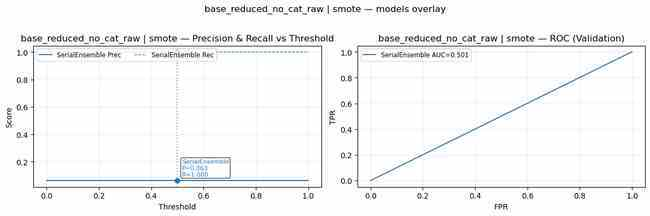


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    ➤ Stage 1: xgb
      Stage 1 xgb: thr=0.083  new_pos_val=3457  remaining_val=4497
    ➤ Stage 2: svc
      Stage 2 svc: thr=0.000  new_pos_val=7954  remaining_val=0
      ⏹ No remaining negatives in val/test — stopping cascade early.
    Serial ensemble final: ValRec₁=1.000 ValPrec₁=0.061 ValROC₁=0.500


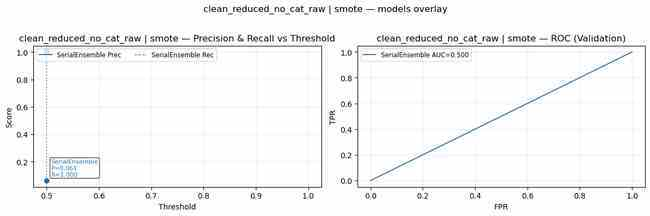


 Dataset: base_topcorr_only
Prepared dataset: Train=(55896, 4), Val=(7986, 4), Test=(15971, 4), Features=4, mode=numeric_only
  ◦ Sampling: smote
    ➤ Stage 1: xgb
      Stage 1 xgb: thr=0.280  new_pos_val=3687  remaining_val=4299
    ➤ Stage 2: svc
      Stage 2 svc: thr=0.136  new_pos_val=6172  remaining_val=950
    ➤ Stage 3: logreg
      Stage 3 logreg: thr=0.000  new_pos_val=7986  remaining_val=0
      ⏹ No remaining negatives in val/test — stopping cascade early.
    Serial ensemble final: ValRec₁=1.000 ValPrec₁=0.063 ValROC₁=0.500


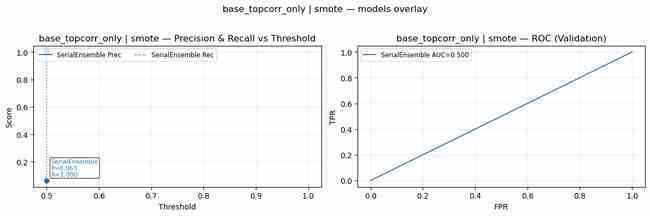


 Dataset: clean_topcorr_only
Prepared dataset: Train=(55674, 4), Val=(7954, 4), Test=(15907, 4), Features=4, mode=numeric_only
  ◦ Sampling: smote
    ➤ Stage 1: xgb
      Stage 1 xgb: thr=0.360  new_pos_val=3343  remaining_val=4611
    ➤ Stage 2: svc
      Stage 2 svc: thr=0.000  new_pos_val=7954  remaining_val=0
      ⏹ No remaining negatives in val/test — stopping cascade early.
    Serial ensemble final: ValRec₁=1.000 ValPrec₁=0.061 ValROC₁=0.500


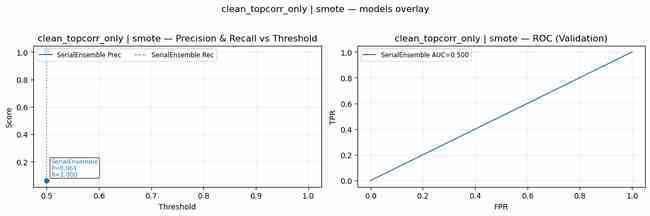


=== Serial Ensemble Summary ===


dataset           model sampling_method tuning_mode  \
0                 base_full  SerialEnsemble           smote      recall   
1                clean_full  SerialEnsemble           smote      recall   
3             clean_reduced  SerialEnsemble           smote      recall   
4       base_reduced_no_cat  SerialEnsemble           smote      recall   
5      clean_reduced_no_cat  SerialEnsemble           smote      recall   
6   base_reduced_no_cat_raw  SerialEnsemble           smote      recall   
7  clean_reduced_no_cat_raw  SerialEnsemble           smote      recall   
8         base_topcorr_only  SerialEnsemble           smote      recall   
9        clean_topcorr_only  SerialEnsemble           smote      recall   
2              base_reduced  SerialEnsemble           smote      recall   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0           0.85             0.5     0.0633     1.000    0.1190    0.5057   
1           0.85             0.5     0.0610     1.000    0.1150    0.5001   
3           0.85             0.5     0.0617     1.000    0.1162    0.5063   
4           0.85             0.5     0.0626     1.000    0.1179    0.5003   
5           0.85             0.5     0.0622     1.000    0.1171    0.5105   
6           0.85             0.5     0.0627     1.000    0.1180    0.5009   
7           0.85             0.5     0.0610     1.000    0.1149    0.5000   
8           0.85             0.5     0.0626     1.000    0.1178    0.5000   
9           0.85             0.5     0.0610     1.000    0.1149    0.5000   
2           0.85             0.5     0.0638     0.998    0.1200    0.5100   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.0633     0.9970     0.1190     0.5054  
1      0.0610     1.0000     0.1149     0.5000  
3      0.0611     0.9918     0.1151     0.5012  
4      0.0626     1.0000     0.1179     0.5003  
5      0.0616     0.9928     0.1160     0.5055  
6      0.0625     0.9950     0.1175     0.4986  
7      0.0610     1.0000     0.1149     0.5000  
8      0.0626     1.0000     0.1178     0.5000  
9      0.0610     1.0000     0.1149     0.5000  
2      0.0639     0.9940     0.1201     0.5108

In [153]:
df_serial, store_serial = run_ensemble_serial_pipeline(
    datasets,
    base_order=("xgb", "svc", "logreg"),  # order of model execution
    tuning_mode="recall",     # tune recall thresholds at each stage
    tuning_target=0.85,
    val_size=0.1,
    test_size=0.2,
    sampling_method="smote",  # optional rebalancing for each stage
    show_plot=True
)


 Dataset: base_full
Prepared dataset: Train=(55896, 20), Val=(7986, 20), Test=(15971, 20), Features=20, mode=numeric_only
  ◦ Sampling: smote
    Trained LinearSVC_calib: thr=0.391 val_roc=0.823
    Trained XGBoost: thr=0.092 val_roc=0.814
    Trained LogisticRegression: thr=0.387 val_roc=0.825
    MLP failed: build_keras_mlp_5layer not found. Define it or replace with another builder.
    Ensemble(soft): thr=0.294  ValRec₁=0.800  ValPrec₁=0.147  ValROC₁=0.828


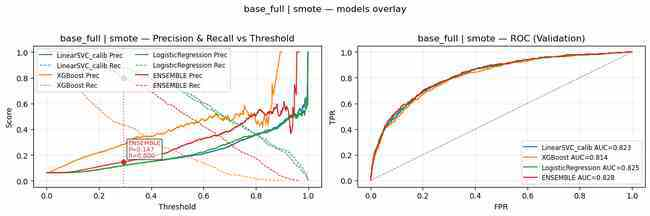


 Dataset: clean_full
Prepared dataset: Train=(55674, 20), Val=(7954, 20), Test=(15907, 20), Features=20, mode=numeric_only
  ◦ Sampling: smote
    Trained LinearSVC_calib: thr=0.415 val_roc=0.832
    Trained XGBoost: thr=0.087 val_roc=0.813
    Trained LogisticRegression: thr=0.415 val_roc=0.835
    MLP failed: build_keras_mlp_5layer not found. Define it or replace with another builder.
    Ensemble(soft): thr=0.307  ValRec₁=0.800  ValPrec₁=0.144  ValROC₁=0.836


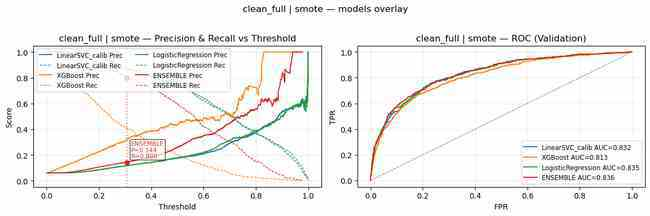


 Dataset: base_reduced
Prepared dataset: Train=(55896, 16), Val=(7986, 16), Test=(15971, 16), Features=16, mode=numeric_only
  ◦ Sampling: smote
    Trained LinearSVC_calib: thr=0.399 val_roc=0.823
    Trained XGBoost: thr=0.084 val_roc=0.815
    Trained LogisticRegression: thr=0.394 val_roc=0.825
    MLP failed: build_keras_mlp_5layer not found. Define it or replace with another builder.
    Ensemble(soft): thr=0.296  ValRec₁=0.800  ValPrec₁=0.147  ValROC₁=0.828


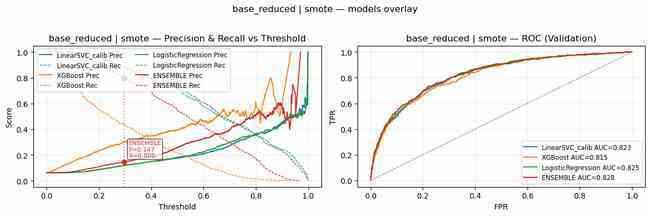


 Dataset: clean_reduced
Prepared dataset: Train=(55674, 16), Val=(7954, 16), Test=(15907, 16), Features=16, mode=numeric_only
  ◦ Sampling: smote
    Trained LinearSVC_calib: thr=0.414 val_roc=0.832
    Trained XGBoost: thr=0.087 val_roc=0.812
    Trained LogisticRegression: thr=0.410 val_roc=0.835
    MLP failed: build_keras_mlp_5layer not found. Define it or replace with another builder.
    Ensemble(soft): thr=0.311  ValRec₁=0.800  ValPrec₁=0.147  ValROC₁=0.835


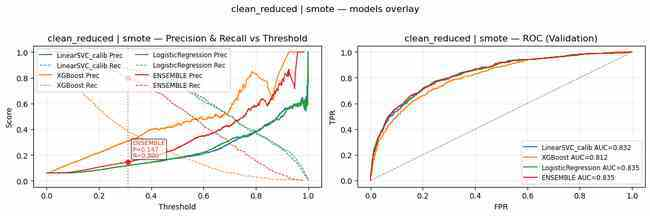


 Dataset: base_reduced_no_cat
Prepared dataset: Train=(55896, 10), Val=(7986, 10), Test=(15971, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    Trained LinearSVC_calib: thr=0.399 val_roc=0.824
    Trained XGBoost: thr=0.110 val_roc=0.817
    Trained LogisticRegression: thr=0.395 val_roc=0.826
    MLP failed: build_keras_mlp_5layer not found. Define it or replace with another builder.
    Ensemble(soft): thr=0.304  ValRec₁=0.800  ValPrec₁=0.147  ValROC₁=0.830


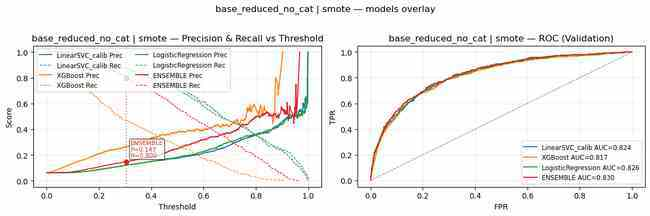


 Dataset: clean_reduced_no_cat
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    Trained LinearSVC_calib: thr=0.414 val_roc=0.832
    Trained XGBoost: thr=0.107 val_roc=0.811
    Trained LogisticRegression: thr=0.414 val_roc=0.834
    MLP failed: build_keras_mlp_5layer not found. Define it or replace with another builder.
    Ensemble(soft): thr=0.324  ValRec₁=0.800  ValPrec₁=0.150  ValROC₁=0.834


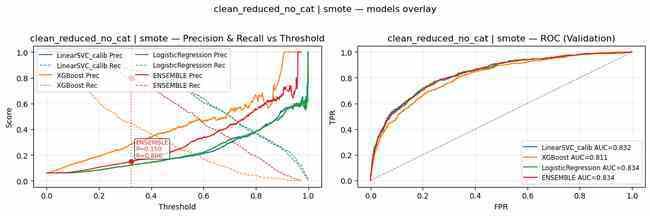


 Dataset: base_reduced_no_cat_raw
Prepared dataset: Train=(55896, 9), Val=(7986, 9), Test=(15971, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    Trained LinearSVC_calib: thr=0.400 val_roc=0.824
    Trained XGBoost: thr=0.119 val_roc=0.817
    Trained LogisticRegression: thr=0.393 val_roc=0.826
    MLP failed: build_keras_mlp_5layer not found. Define it or replace with another builder.
    Ensemble(soft): thr=0.310  ValRec₁=0.800  ValPrec₁=0.151  ValROC₁=0.829


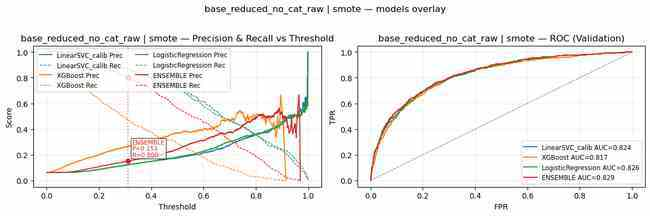


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    Trained LinearSVC_calib: thr=0.410 val_roc=0.832
    Trained XGBoost: thr=0.102 val_roc=0.812
    Trained LogisticRegression: thr=0.412 val_roc=0.834
    MLP failed: build_keras_mlp_5layer not found. Define it or replace with another builder.
    Ensemble(soft): thr=0.318  ValRec₁=0.802  ValPrec₁=0.147  ValROC₁=0.834


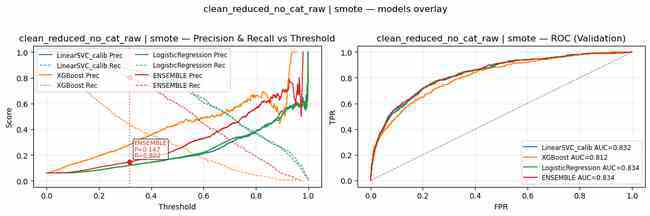


 Dataset: base_topcorr_only
Prepared dataset: Train=(55896, 4), Val=(7986, 4), Test=(15971, 4), Features=4, mode=numeric_only
  ◦ Sampling: smote
    Trained LinearSVC_calib: thr=0.374 val_roc=0.815
    Trained XGBoost: thr=0.352 val_roc=0.801
    Trained LogisticRegression: thr=0.367 val_roc=0.817
    MLP failed: build_keras_mlp_5layer not found. Define it or replace with another builder.
    Ensemble(soft): thr=0.363  ValRec₁=0.800  ValPrec₁=0.138  ValROC₁=0.815


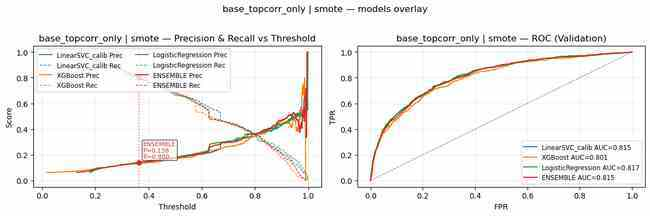


 Dataset: clean_topcorr_only
Prepared dataset: Train=(55674, 4), Val=(7954, 4), Test=(15907, 4), Features=4, mode=numeric_only
  ◦ Sampling: smote
    Trained LinearSVC_calib: thr=0.408 val_roc=0.826
    Trained XGBoost: thr=0.404 val_roc=0.816
    Trained LogisticRegression: thr=0.408 val_roc=0.829
    MLP failed: build_keras_mlp_5layer not found. Define it or replace with another builder.
    Ensemble(soft): thr=0.432  ValRec₁=0.800  ValPrec₁=0.153  ValROC₁=0.829


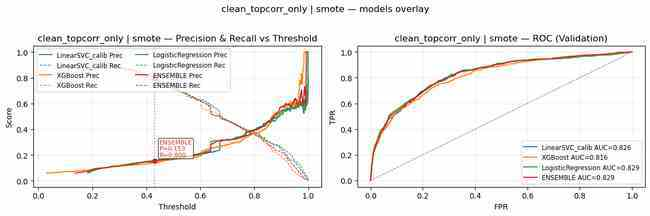


=== Ensemble (soft) Summary ===


dataset           model sampling_method tuning_mode  \
7  clean_reduced_no_cat_raw  Ensemble[soft]           smote      recall   
0                 base_full  Ensemble[soft]           smote      recall   
1                clean_full  Ensemble[soft]           smote      recall   
2              base_reduced  Ensemble[soft]           smote      recall   
3             clean_reduced  Ensemble[soft]           smote      recall   
4       base_reduced_no_cat  Ensemble[soft]           smote      recall   
5      clean_reduced_no_cat  Ensemble[soft]           smote      recall   
6   base_reduced_no_cat_raw  Ensemble[soft]           smote      recall   
8         base_topcorr_only  Ensemble[soft]           smote      recall   
9        clean_topcorr_only  Ensemble[soft]           smote      recall   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
7            0.8          0.3181     0.1473    0.8021    0.2489    0.8341   
0            0.8          0.2944     0.1469    0.8000    0.2482    0.8279   
1            0.8          0.3066     0.1436    0.8000    0.2435    0.8360   
2            0.8          0.2964     0.1473    0.8000    0.2488    0.8277   
3            0.8          0.3112     0.1469    0.8000    0.2482    0.8346   
4            0.8          0.3041     0.1473    0.8000    0.2488    0.8298   
5            0.8          0.3236     0.1503    0.8000    0.2530    0.8337   
6            0.8          0.3103     0.1508    0.8000    0.2537    0.8290   
8            0.8          0.3634     0.1379    0.8000    0.2352    0.8148   
9            0.8          0.4320     0.1530    0.8000    0.2569    0.8289   

   test_prec1  test_rec1  test_f1_1  test_roc1  
7      0.1492     0.7938     0.2511     0.8313  
0      0.1526     0.8380     0.2581     0.8426  
1      0.1475     0.8000     0.2491     0.8304  
2      0.1537     0.8410     0.2598     0.8420  
3      0.1483     0.7959     0.2500     0.8314  
4      0.1537     0.8360     0.2597     0.8431  
5      0.1514     0.7897     0.2540     0.8328  
6      0.1557     0.8270     0.2620     0.8417  
8      0.1444     0.8540     0.2470     0.8321  
9      0.1524     0.7711     0.2546     0.8212

In [154]:
df_voting, store_voting = run_ensemble_pipeline_voting(
    datasets,
    base_models=("svc", "xgb", "logreg", "mlp"),  # choose your base models
    voting_method="soft",      # or "weighted", "hard", "stack"
    tuning_mode="recall",      # tune for recall, precision, or F1
    tuning_target=0.8,         # target metric value on validation
    val_size=0.1,
    test_size=0.2,
    sampling_method="smote",   # rebalances only training split
    show_plot=True             # show PR/ROC curves
)



==== Running ensemble with sampling=random_under ====

 Dataset: clean_topcorr_only
Prepared dataset: Train=(55674, 4), Val=(7954, 4), Test=(15907, 4), Features=4, mode=numeric_only
  ◦ Sampling: random_under
    Trained LinearSVC_calib: thr=0.408 val_roc=0.825
    Trained XGBoost: thr=0.417 val_roc=0.822
    Trained LogisticRegression: thr=0.402 val_roc=0.829
    MLP failed: build_keras_mlp_5layer not found. Define it or replace with another builder.
    Ensemble(soft): thr=0.442  ValRec₁=0.800  ValPrec₁=0.153  ValROC₁=0.831


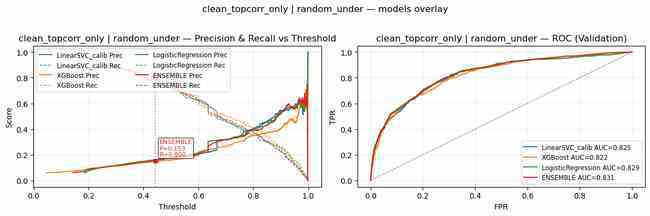


=== Ensemble (soft) Summary ===


dataset           model sampling_method tuning_mode  \
0  clean_topcorr_only  Ensemble[soft]    random_under      recall   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8          0.4422     0.1533       0.8    0.2573    0.8308   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.1529     0.7732     0.2554     0.8217


==== Running ensemble with sampling=random_over ====

 Dataset: clean_topcorr_only
Prepared dataset: Train=(55674, 4), Val=(7954, 4), Test=(15907, 4), Features=4, mode=numeric_only
  ◦ Sampling: random_over
    Trained LinearSVC_calib: thr=0.407 val_roc=0.826
    Trained XGBoost: thr=0.398 val_roc=0.813
    Trained LogisticRegression: thr=0.408 val_roc=0.829
    MLP failed: build_keras_mlp_5layer not found. Define it or replace with another builder.
    Ensemble(soft): thr=0.408  ValRec₁=0.800  ValPrec₁=0.148  ValROC₁=0.829


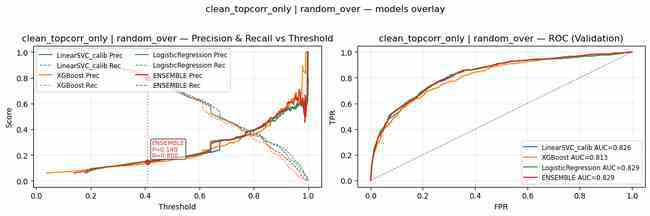


=== Ensemble (soft) Summary ===


dataset           model sampling_method tuning_mode  \
0  clean_topcorr_only  Ensemble[soft]     random_over      recall   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8          0.4085     0.1478       0.8    0.2495    0.8289   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.1482     0.7814     0.2491     0.8203


==== Running ensemble with sampling=smote ====

 Dataset: clean_topcorr_only
Prepared dataset: Train=(55674, 4), Val=(7954, 4), Test=(15907, 4), Features=4, mode=numeric_only
  ◦ Sampling: smote
    Trained LinearSVC_calib: thr=0.408 val_roc=0.826
    Trained XGBoost: thr=0.404 val_roc=0.816
    Trained LogisticRegression: thr=0.408 val_roc=0.829
    MLP failed: build_keras_mlp_5layer not found. Define it or replace with another builder.
    Ensemble(soft): thr=0.432  ValRec₁=0.800  ValPrec₁=0.153  ValROC₁=0.829


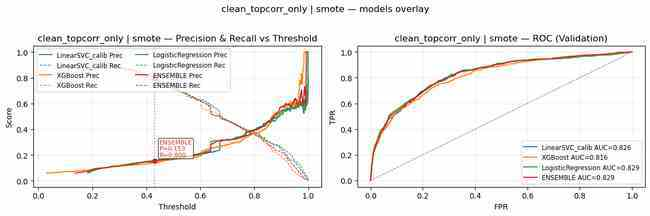


=== Ensemble (soft) Summary ===


dataset           model sampling_method tuning_mode  \
0  clean_topcorr_only  Ensemble[soft]           smote      recall   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8           0.432      0.153       0.8    0.2569    0.8289   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.1524     0.7711     0.2546     0.8212


==== Running ensemble with sampling=adasyn ====

 Dataset: clean_topcorr_only
Prepared dataset: Train=(55674, 4), Val=(7954, 4), Test=(15907, 4), Features=4, mode=numeric_only
  ◦ Sampling: adasyn
    Trained LinearSVC_calib: thr=0.435 val_roc=0.824
    Trained XGBoost: thr=0.441 val_roc=0.813
    Trained LogisticRegression: thr=0.435 val_roc=0.828
    MLP failed: build_keras_mlp_5layer not found. Define it or replace with another builder.
    Ensemble(soft): thr=0.465  ValRec₁=0.800  ValPrec₁=0.151  ValROC₁=0.828


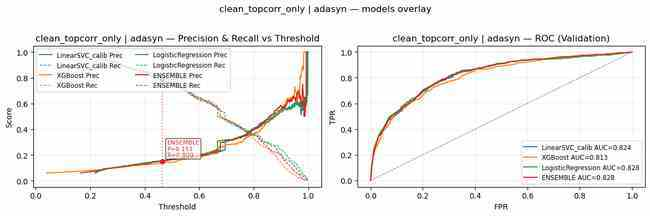


=== Ensemble (soft) Summary ===


dataset           model sampling_method tuning_mode  \
0  clean_topcorr_only  Ensemble[soft]          adasyn      recall   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8           0.465     0.1513       0.8    0.2544    0.8283   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.1514     0.7784     0.2535     0.8214


==== Running ensemble with sampling=smote_tomek ====

 Dataset: clean_topcorr_only
Prepared dataset: Train=(55674, 4), Val=(7954, 4), Test=(15907, 4), Features=4, mode=numeric_only
  ◦ Sampling: smote_tomek
    Trained LinearSVC_calib: thr=0.409 val_roc=0.828
    Trained XGBoost: thr=0.400 val_roc=0.816
    Trained LogisticRegression: thr=0.416 val_roc=0.830
    MLP failed: build_keras_mlp_5layer not found. Define it or replace with another builder.
    Ensemble(soft): thr=0.427  ValRec₁=0.800  ValPrec₁=0.152  ValROC₁=0.830


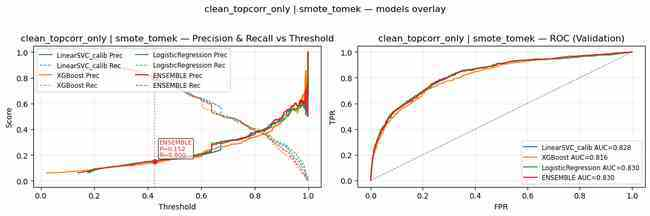


=== Ensemble (soft) Summary ===


dataset           model sampling_method tuning_mode  \
0  clean_topcorr_only  Ensemble[soft]     smote_tomek      recall   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8          0.4271     0.1516       0.8    0.2549    0.8296   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.1504     0.7742     0.2519     0.8221


==== Running ensemble with sampling=tomek ====

 Dataset: clean_topcorr_only
Prepared dataset: Train=(55674, 4), Val=(7954, 4), Test=(15907, 4), Features=4, mode=numeric_only
  ◦ Sampling: tomek
    Trained LinearSVC_calib: thr=0.045 val_roc=0.830
    Trained XGBoost: thr=0.407 val_roc=0.820
    Trained LogisticRegression: thr=0.044 val_roc=0.828
    MLP failed: build_keras_mlp_5layer not found. Define it or replace with another builder.
    Ensemble(soft): thr=0.174  ValRec₁=0.800  ValPrec₁=0.148  ValROC₁=0.828


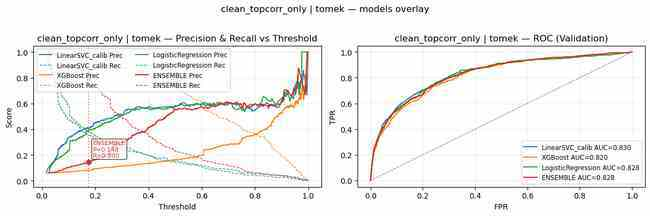


=== Ensemble (soft) Summary ===


dataset           model sampling_method tuning_mode  \
0  clean_topcorr_only  Ensemble[soft]           tomek      recall   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8          0.1744     0.1479       0.8    0.2497    0.8283   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.1482     0.7784     0.2491     0.8183


==== Running ensemble with sampling=enn ====

 Dataset: clean_topcorr_only
Prepared dataset: Train=(55674, 4), Val=(7954, 4), Test=(15907, 4), Features=4, mode=numeric_only
  ◦ Sampling: enn
    Trained LinearSVC_calib: thr=0.048 val_roc=0.830
    Trained XGBoost: thr=0.403 val_roc=0.818
    Trained LogisticRegression: thr=0.051 val_roc=0.831
    MLP failed: build_keras_mlp_5layer not found. Define it or replace with another builder.
    Ensemble(soft): thr=0.182  ValRec₁=0.800  ValPrec₁=0.144  ValROC₁=0.828


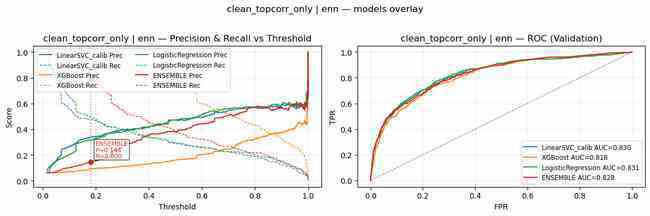


=== Ensemble (soft) Summary ===


dataset           model sampling_method tuning_mode  \
0  clean_topcorr_only  Ensemble[soft]             enn      recall   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8          0.1818     0.1438       0.8    0.2438    0.8279   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.1458     0.7897     0.2462     0.8181

In [155]:
methods = ["random_under", "random_over", "smote", "adasyn", "smote_tomek", "tomek", "enn"]
all_results = []

for m in methods:
    print(f"\n==== Running ensemble with sampling={m} ====")
    df_voting, store_voting = run_ensemble_pipeline_voting(
        {"clean_topcorr_only": clean_topcorr_only},
        base_models=("svc", "xgb", "logreg", "mlp"),
        voting_method="soft",
        tuning_mode="recall",
        tuning_target=0.8,
        val_size=0.1,
        test_size=0.2,
        sampling_method=m,
        show_plot=True
    )
    all_results.append((m, df_voting))

 ### Precision Tuning


 Dataset: base_full
Prepared dataset: Train=(55896, 20), Val=(7986, 20), Test=(15971, 20), Features=20, mode=numeric_only
  ◦ Sampling: smote
    Trained LinearSVC_calib: thr=0.998 val_roc=0.823
    Trained XGBoost: thr=0.894 val_roc=0.814
    Trained LogisticRegression: thr=0.999 val_roc=0.825
    MLP failed: build_keras_mlp_5layer not found. Define it or replace with another builder.
    Ensemble(soft): thr=0.957  ValRec₁=0.004  ValPrec₁=1.000  ValROC₁=0.828


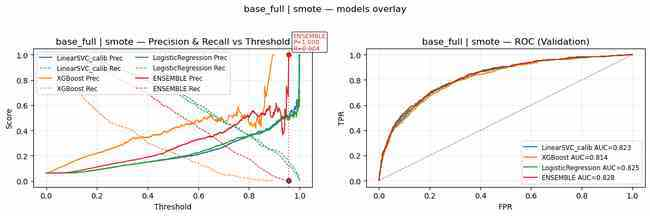


 Dataset: clean_full
Prepared dataset: Train=(55674, 20), Val=(7954, 20), Test=(15907, 20), Features=20, mode=numeric_only
  ◦ Sampling: smote
    Trained LinearSVC_calib: thr=0.999 val_roc=0.832
    Trained XGBoost: thr=0.831 val_roc=0.813
    Trained LogisticRegression: thr=0.999 val_roc=0.835
    MLP failed: build_keras_mlp_5layer not found. Define it or replace with another builder.
    Ensemble(soft): thr=0.900  ValRec₁=0.045  ValPrec₁=0.815  ValROC₁=0.836


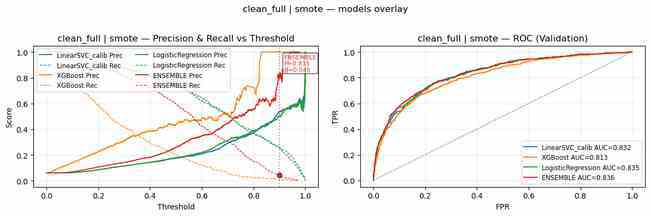


 Dataset: base_reduced
Prepared dataset: Train=(55896, 16), Val=(7986, 16), Test=(15971, 16), Features=16, mode=numeric_only
  ◦ Sampling: smote
    Trained LinearSVC_calib: thr=0.998 val_roc=0.823
    Trained XGBoost: thr=0.856 val_roc=0.815
    Trained LogisticRegression: thr=0.999 val_roc=0.825
    MLP failed: build_keras_mlp_5layer not found. Define it or replace with another builder.
    Ensemble(soft): thr=0.971  ValRec₁=0.002  ValPrec₁=1.000  ValROC₁=0.828


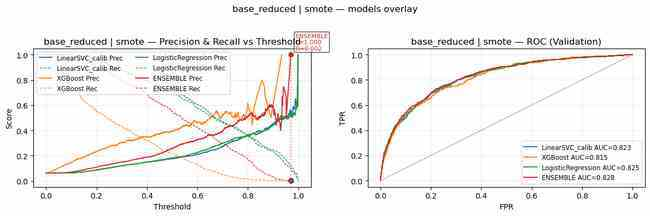


 Dataset: clean_reduced
Prepared dataset: Train=(55674, 16), Val=(7954, 16), Test=(15907, 16), Features=16, mode=numeric_only
  ◦ Sampling: smote
    Trained LinearSVC_calib: thr=0.999 val_roc=0.832
    Trained XGBoost: thr=0.780 val_roc=0.812
    Trained LogisticRegression: thr=0.999 val_roc=0.835
    MLP failed: build_keras_mlp_5layer not found. Define it or replace with another builder.
    Ensemble(soft): thr=0.912  ValRec₁=0.041  ValPrec₁=0.833  ValROC₁=0.835


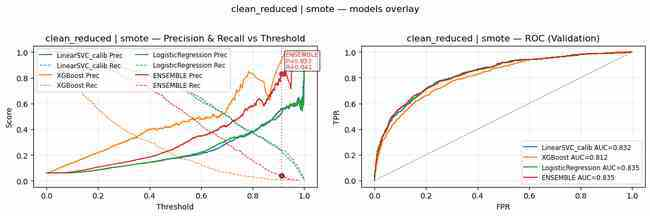


 Dataset: base_reduced_no_cat
Prepared dataset: Train=(55896, 10), Val=(7986, 10), Test=(15971, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    Trained LinearSVC_calib: thr=0.998 val_roc=0.824
    Trained XGBoost: thr=0.876 val_roc=0.817
    Trained LogisticRegression: thr=0.999 val_roc=0.826
    MLP failed: build_keras_mlp_5layer not found. Define it or replace with another builder.
    Ensemble(soft): thr=0.968  ValRec₁=0.002  ValPrec₁=1.000  ValROC₁=0.830


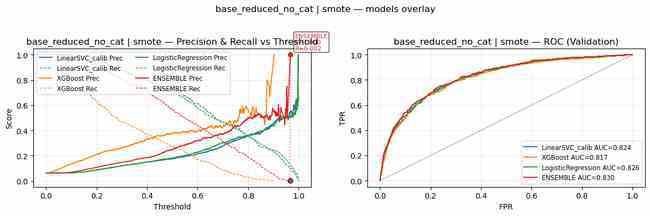


 Dataset: clean_reduced_no_cat
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    Trained LinearSVC_calib: thr=0.999 val_roc=0.832
    Trained XGBoost: thr=0.907 val_roc=0.811
    Trained LogisticRegression: thr=0.999 val_roc=0.834
    MLP failed: build_keras_mlp_5layer not found. Define it or replace with another builder.
    Ensemble(soft): thr=0.955  ValRec₁=0.016  ValPrec₁=0.800  ValROC₁=0.834


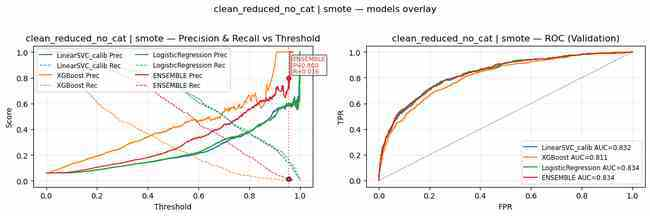


 Dataset: base_reduced_no_cat_raw
Prepared dataset: Train=(55896, 9), Val=(7986, 9), Test=(15971, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    Trained LinearSVC_calib: thr=0.998 val_roc=0.824
    Trained XGBoost: thr=0.364 val_roc=0.817
    Trained LogisticRegression: thr=0.999 val_roc=0.826
    MLP failed: build_keras_mlp_5layer not found. Define it or replace with another builder.
    Ensemble(soft): thr=0.618  ValRec₁=0.442  ValPrec₁=0.331  ValROC₁=0.829


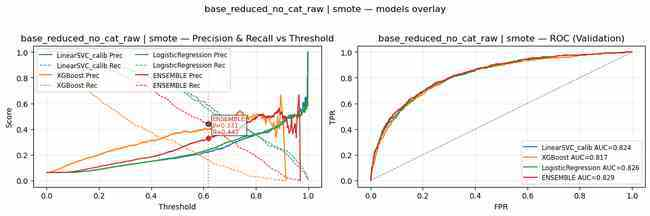


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    Trained LinearSVC_calib: thr=0.999 val_roc=0.832
    Trained XGBoost: thr=0.937 val_roc=0.812
    Trained LogisticRegression: thr=0.999 val_roc=0.834
    MLP failed: build_keras_mlp_5layer not found. Define it or replace with another builder.
    Ensemble(soft): thr=0.965  ValRec₁=0.008  ValPrec₁=0.800  ValROC₁=0.834


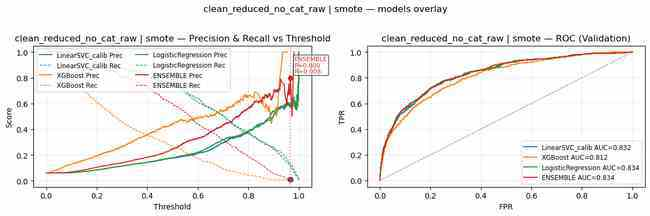


 Dataset: base_topcorr_only
Prepared dataset: Train=(55896, 4), Val=(7986, 4), Test=(15971, 4), Features=4, mode=numeric_only
  ◦ Sampling: smote
    Trained LinearSVC_calib: thr=0.998 val_roc=0.815
    Trained XGBoost: thr=0.987 val_roc=0.801
    Trained LogisticRegression: thr=0.999 val_roc=0.817
    MLP failed: build_keras_mlp_5layer not found. Define it or replace with another builder.
    Ensemble(soft): thr=0.996  ValRec₁=0.002  ValPrec₁=1.000  ValROC₁=0.815


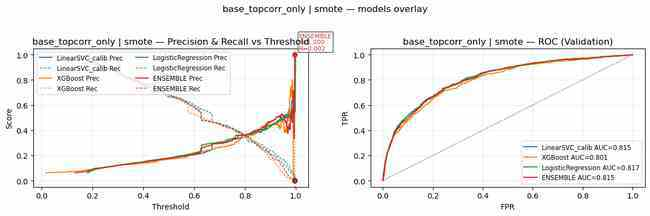


 Dataset: clean_topcorr_only
Prepared dataset: Train=(55674, 4), Val=(7954, 4), Test=(15907, 4), Features=4, mode=numeric_only
  ◦ Sampling: smote
    Trained LinearSVC_calib: thr=0.999 val_roc=0.826
    Trained XGBoost: thr=0.974 val_roc=0.816
    Trained LogisticRegression: thr=1.000 val_roc=0.829
    MLP failed: build_keras_mlp_5layer not found. Define it or replace with another builder.
    Ensemble(soft): thr=0.993  ValRec₁=0.006  ValPrec₁=1.000  ValROC₁=0.829


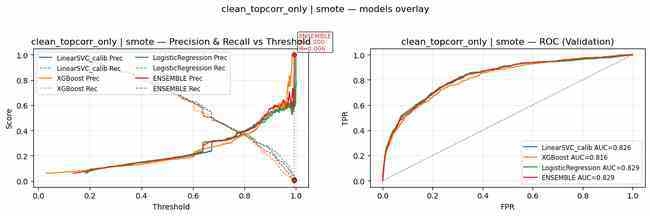


=== Ensemble (soft) Summary ===


dataset           model sampling_method tuning_mode  \
0                 base_full  Ensemble[soft]           smote   precision   
2              base_reduced  Ensemble[soft]           smote   precision   
4       base_reduced_no_cat  Ensemble[soft]           smote   precision   
8         base_topcorr_only  Ensemble[soft]           smote   precision   
9        clean_topcorr_only  Ensemble[soft]           smote   precision   
3             clean_reduced  Ensemble[soft]           smote   precision   
1                clean_full  Ensemble[soft]           smote   precision   
5      clean_reduced_no_cat  Ensemble[soft]           smote   precision   
7  clean_reduced_no_cat_raw  Ensemble[soft]           smote   precision   
6   base_reduced_no_cat_raw  Ensemble[soft]           smote   precision   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8          0.9569     1.0000    0.0040    0.0080    0.8279   
2            0.8          0.9710     1.0000    0.0020    0.0040    0.8277   
4            0.8          0.9681     1.0000    0.0020    0.0040    0.8298   
8            0.8          0.9957     1.0000    0.0020    0.0040    0.8148   
9            0.8          0.9932     1.0000    0.0062    0.0123    0.8289   
3            0.8          0.9116     0.8333    0.0412    0.0786    0.8346   
1            0.8          0.9004     0.8148    0.0454    0.0859    0.8360   
5            0.8          0.9547     0.8000    0.0165    0.0323    0.8337   
7            0.8          0.9654     0.8000    0.0082    0.0163    0.8341   
6            0.8          0.6183     0.3313    0.4420    0.3787    0.8290   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      1.0000     0.0020     0.0040     0.8426  
2      1.0000     0.0010     0.0020     0.8420  
4      0.0000     0.0000     0.0000     0.8431  
8      0.0000     0.0000     0.0000     0.8321  
9      0.7692     0.0103     0.0203     0.8212  
3      0.6444     0.0299     0.0571     0.8314  
1      0.6471     0.0340     0.0646     0.8304  
5      0.8571     0.0124     0.0244     0.8328  
7      0.8750     0.0072     0.0143     0.8313  
6      0.3405     0.4300     0.3800     0.8417

In [157]:
df_voting, store_voting = run_ensemble_pipeline_voting(
    datasets,
    base_models=("svc", "xgb", "logreg", "mlp"),  # choose your base models
    voting_method="soft",      # or "weighted", "hard", "stack"
    tuning_mode="precision",      # tune for recall, precision, or F1
    tuning_target=0.8,         # target metric value on validation
    val_size=0.1,
    test_size=0.2,
    sampling_method="smote",   # rebalances only training split
    show_plot=True             # show PR/ROC curves
)




 Dataset: base_full
Prepared dataset: Train=(55896, 20), Val=(7986, 20), Test=(15971, 20), Features=20, mode=numeric_only
  ◦ Sampling: smote
    ➤ Stage 1: xgb
      Stage 1 xgb: thr=0.894  new_pos_val=2  remaining_val=7984
    ➤ Stage 2: svc
      Stage 2 svc: thr=0.806  new_pos_val=10  remaining_val=7975
    ➤ Stage 3: logreg
      Stage 3 logreg: thr=0.364  new_pos_val=484  remaining_val=7502
    Serial ensemble final: ValRec₁=0.350 ValPrec₁=0.362 ValROC₁=0.654


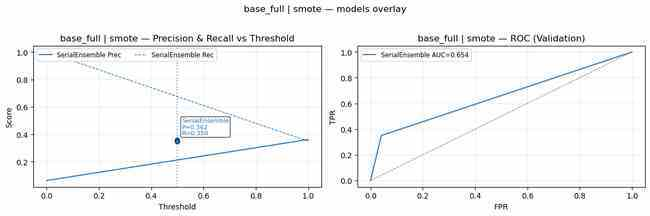


 Dataset: clean_full
Prepared dataset: Train=(55674, 20), Val=(7954, 20), Test=(15907, 20), Features=20, mode=numeric_only
  ◦ Sampling: smote
    ➤ Stage 1: xgb
      Stage 1 xgb: thr=0.831  new_pos_val=10  remaining_val=7944
    ➤ Stage 2: svc
      Stage 2 svc: thr=0.920  new_pos_val=1  remaining_val=7943
    ➤ Stage 3: logreg
      Stage 3 logreg: thr=0.300  new_pos_val=467  remaining_val=7486
    Serial ensemble final: ValRec₁=0.365 ValPrec₁=0.378 ValROC₁=0.663


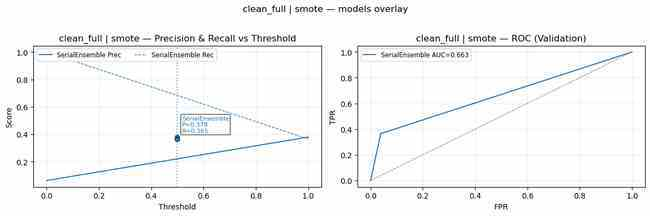


 Dataset: base_reduced
Prepared dataset: Train=(55896, 16), Val=(7986, 16), Test=(15971, 16), Features=16, mode=numeric_only
  ◦ Sampling: smote
    ➤ Stage 1: xgb
      Stage 1 xgb: thr=0.935  new_pos_val=1  remaining_val=7985
    ➤ Stage 2: svc
      Stage 2 svc: thr=0.850  new_pos_val=11  remaining_val=7974
    ➤ Stage 3: logreg
      Stage 3 logreg: thr=0.927  new_pos_val=7  remaining_val=7973
    Serial ensemble final: ValRec₁=0.024 ValPrec₁=0.923 ValROC₁=0.512


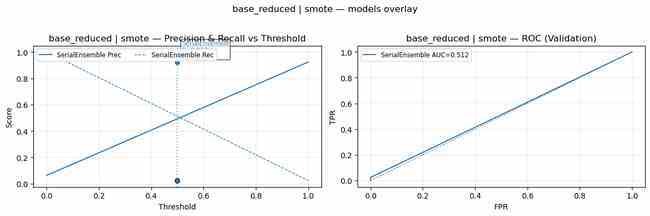


 Dataset: clean_reduced
Prepared dataset: Train=(55674, 16), Val=(7954, 16), Test=(15907, 16), Features=16, mode=numeric_only
  ◦ Sampling: smote
    ➤ Stage 1: xgb
      Stage 1 xgb: thr=0.784  new_pos_val=20  remaining_val=7934
    ➤ Stage 2: svc
      Stage 2 svc: thr=0.193  new_pos_val=788  remaining_val=7164
    ➤ Stage 3: logreg
      Stage 3 logreg: thr=0.389  new_pos_val=466  remaining_val=7163
    Serial ensemble final: ValRec₁=0.509 ValPrec₁=0.312 ValROC₁=0.718


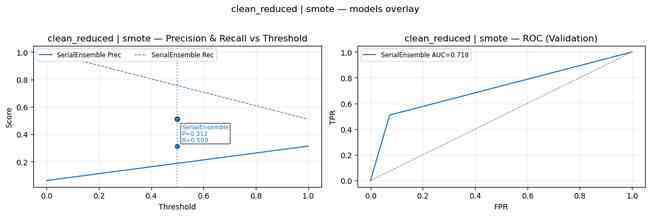


 Dataset: base_reduced_no_cat
Prepared dataset: Train=(55896, 10), Val=(7986, 10), Test=(15971, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    ➤ Stage 1: xgb
      Stage 1 xgb: thr=0.903  new_pos_val=2  remaining_val=7984
    ➤ Stage 2: svc
      Stage 2 svc: thr=0.919  new_pos_val=13  remaining_val=7972
    ➤ Stage 3: logreg
      Stage 3 logreg: thr=0.941  new_pos_val=12  remaining_val=7971
    Serial ensemble final: ValRec₁=0.028 ValPrec₁=0.933 ValROC₁=0.514


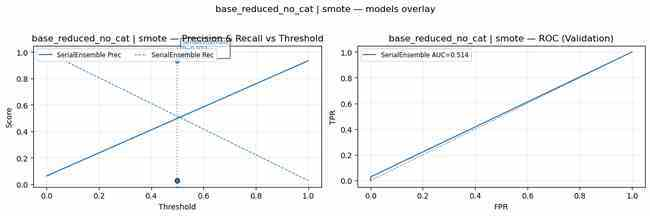


 Dataset: clean_reduced_no_cat
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    ➤ Stage 1: xgb
      Stage 1 xgb: thr=0.907  new_pos_val=7  remaining_val=7947
    ➤ Stage 2: svc
      Stage 2 svc: thr=0.949  new_pos_val=3  remaining_val=7945
    ➤ Stage 3: logreg
      Stage 3 logreg: thr=0.442  new_pos_val=462  remaining_val=7492
    Serial ensemble final: ValRec₁=0.367 ValPrec₁=0.385 ValROC₁=0.664


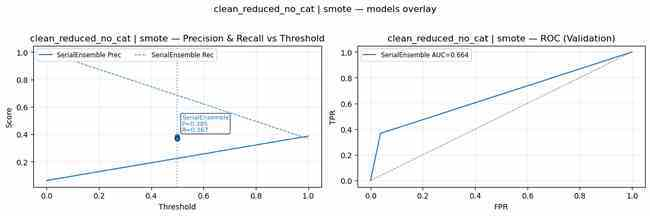


 Dataset: base_reduced_no_cat_raw
Prepared dataset: Train=(55896, 9), Val=(7986, 9), Test=(15971, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    ➤ Stage 1: xgb
      Stage 1 xgb: thr=0.364  new_pos_val=705  remaining_val=7281
    ➤ Stage 2: svc
      Stage 2 svc: thr=0.079  new_pos_val=1570  remaining_val=6329
    ➤ Stage 3: logreg
      Stage 3 logreg: thr=0.082  new_pos_val=2072  remaining_val=5887
    Serial ensemble final: ValRec₁=0.736 ValPrec₁=0.175 ValROC₁=0.752


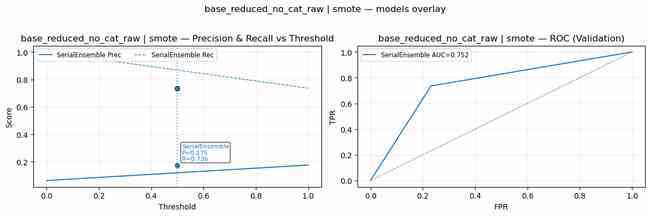


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    ➤ Stage 1: xgb
      Stage 1 xgb: thr=0.937  new_pos_val=3  remaining_val=7951
    ➤ Stage 2: svc
      Stage 2 svc: thr=0.974  new_pos_val=2  remaining_val=7949
    ➤ Stage 3: logreg
      Stage 3 logreg: thr=0.944  new_pos_val=4  remaining_val=7947
    Serial ensemble final: ValRec₁=0.014 ValPrec₁=1.000 ValROC₁=0.507


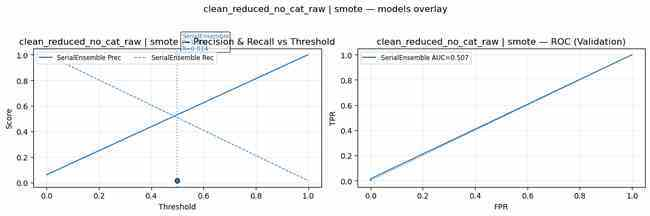


 Dataset: base_topcorr_only
Prepared dataset: Train=(55896, 4), Val=(7986, 4), Test=(15971, 4), Features=4, mode=numeric_only
  ◦ Sampling: smote
    ➤ Stage 1: xgb
      Stage 1 xgb: thr=0.803  new_pos_val=518  remaining_val=7468
    ➤ Stage 2: svc
      Stage 2 svc: thr=0.558  new_pos_val=1506  remaining_val=6454
    ➤ Stage 3: logreg
      Stage 3 logreg: thr=0.961  new_pos_val=372  remaining_val=6453
    Serial ensemble final: ValRec₁=0.620 ValPrec₁=0.202 ValROC₁=0.728


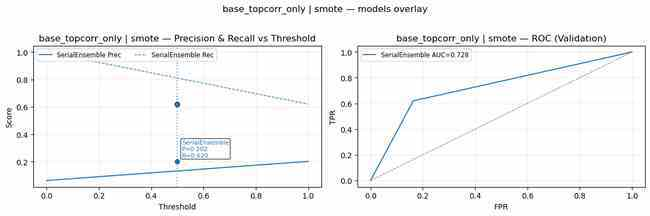


 Dataset: clean_topcorr_only
Prepared dataset: Train=(55674, 4), Val=(7954, 4), Test=(15907, 4), Features=4, mode=numeric_only
  ◦ Sampling: smote
    ➤ Stage 1: xgb
      Stage 1 xgb: thr=0.985  new_pos_val=9  remaining_val=7945
    ➤ Stage 2: svc
      Stage 2 svc: thr=0.999  new_pos_val=4  remaining_val=7942
    ➤ Stage 3: logreg
      Stage 3 logreg: thr=0.678  new_pos_val=763  remaining_val=7191
    Serial ensemble final: ValRec₁=0.501 ValPrec₁=0.318 ValROC₁=0.716


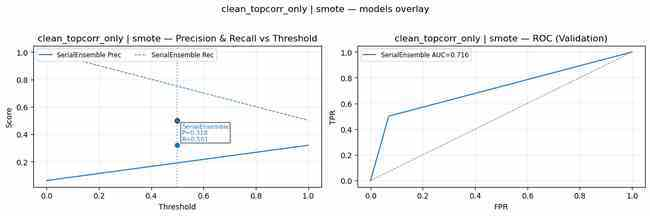


=== Serial Ensemble Summary ===


dataset           model sampling_method tuning_mode  \
7  clean_reduced_no_cat_raw  SerialEnsemble           smote   precision   
4       base_reduced_no_cat  SerialEnsemble           smote   precision   
2              base_reduced  SerialEnsemble           smote   precision   
5      clean_reduced_no_cat  SerialEnsemble           smote   precision   
1                clean_full  SerialEnsemble           smote   precision   
0                 base_full  SerialEnsemble           smote   precision   
9        clean_topcorr_only  SerialEnsemble           smote   precision   
3             clean_reduced  SerialEnsemble           smote   precision   
8         base_topcorr_only  SerialEnsemble           smote   precision   
6   base_reduced_no_cat_raw  SerialEnsemble           smote   precision   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
7           0.85             0.5     1.0000    0.0144    0.0285    0.5072   
4           0.85             0.5     0.9333    0.0280    0.0544    0.5139   
2           0.85             0.5     0.9231    0.0240    0.0468    0.5119   
5           0.85             0.5     0.3853    0.3670    0.3759    0.6645   
1           0.85             0.5     0.3782    0.3649    0.3715    0.6630   
0           0.85             0.5     0.3616    0.3500    0.3557    0.6544   
9           0.85             0.5     0.3185    0.5010    0.3894    0.7157   
3           0.85             0.5     0.3123    0.5093    0.3871    0.7182   
8           0.85             0.5     0.2022    0.6200    0.3050    0.7283   
6           0.85             0.5     0.1753    0.7360    0.2832    0.7524   

   test_prec1  test_rec1  test_f1_1  test_roc1  
7      0.8235     0.0144     0.0284     0.5071  
4      0.7083     0.0170     0.0332     0.5083  
2      0.6522     0.0150     0.0293     0.5072  
5      0.3732     0.3505     0.3615     0.6561  
1      0.3507     0.3536     0.3522     0.6555  
0      0.3797     0.3440     0.3610     0.6532  
9      0.3153     0.4742     0.3788     0.7037  
3      0.3016     0.4866     0.3724     0.7067  
8      0.2125     0.6350     0.3185     0.7389  
6      0.1797     0.7480     0.2898     0.7599

In [158]:
df_serial, store_serial = run_ensemble_serial_pipeline(
    datasets,
    base_order=("xgb", "svc", "logreg"),  # order of model execution
    tuning_mode="precision",     # tune recall thresholds at each stage
    tuning_target=0.85,
    val_size=0.1,
    test_size=0.2,
    sampling_method="smote",  # optional rebalancing for each stage
    show_plot=True
)



 Dataset: base_full
Prepared dataset: Train=(55896, 20), Val=(7986, 20), Test=(15971, 20), Features=20, mode=numeric_only
  ◦ Sampling: builtin
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
    KerasMLP: thr=0.986  ValRec₁=0.024  ValPrec₁=0.857  ValROC₁=0.830


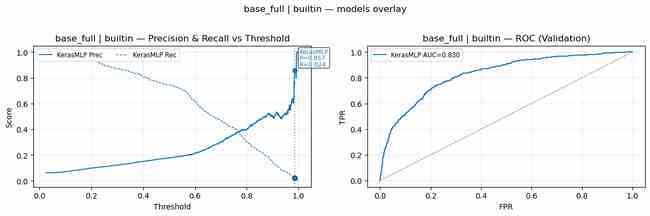


 Dataset: clean_full
Prepared dataset: Train=(55674, 20), Val=(7954, 20), Test=(15907, 20), Features=20, mode=numeric_only
  ◦ Sampling: builtin
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
    KerasMLP: thr=0.983  ValRec₁=0.025  ValPrec₁=0.857  ValROC₁=0.841


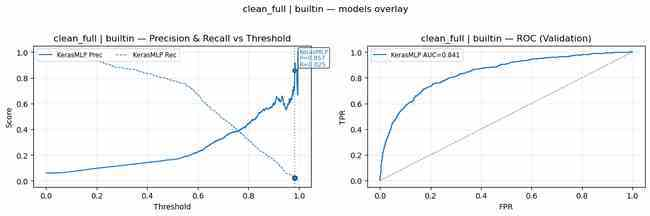


 Dataset: base_reduced
Prepared dataset: Train=(55896, 16), Val=(7986, 16), Test=(15971, 16), Features=16, mode=numeric_only
  ◦ Sampling: builtin
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
    KerasMLP: thr=0.972  ValRec₁=0.022  ValPrec₁=0.846  ValROC₁=0.830


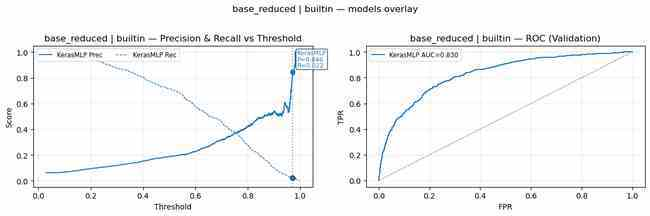


 Dataset: clean_reduced
Prepared dataset: Train=(55674, 16), Val=(7954, 16), Test=(15907, 16), Features=16, mode=numeric_only
  ◦ Sampling: builtin
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step
    KerasMLP: thr=0.986  ValRec₁=0.021  ValPrec₁=0.833  ValROC₁=0.838


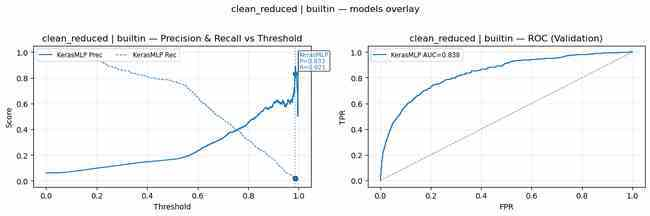


 Dataset: base_reduced_no_cat
Prepared dataset: Train=(55896, 10), Val=(7986, 10), Test=(15971, 10), Features=10, mode=numeric_only
  ◦ Sampling: builtin
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
    KerasMLP: thr=0.990  ValRec₁=0.024  ValPrec₁=0.857  ValROC₁=0.829


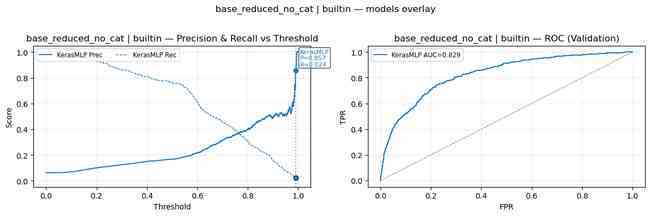


 Dataset: clean_reduced_no_cat
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: builtin
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
    KerasMLP: thr=0.950  ValRec₁=0.033  ValPrec₁=0.800  ValROC₁=0.841


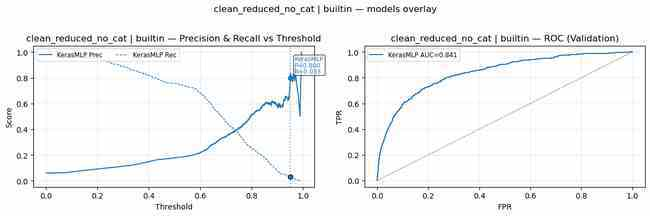


 Dataset: base_reduced_no_cat_raw
Prepared dataset: Train=(55896, 9), Val=(7986, 9), Test=(15971, 9), Features=9, mode=numeric_only
  ◦ Sampling: builtin
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step
    KerasMLP: thr=0.991  ValRec₁=0.026  ValPrec₁=0.867  ValROC₁=0.830


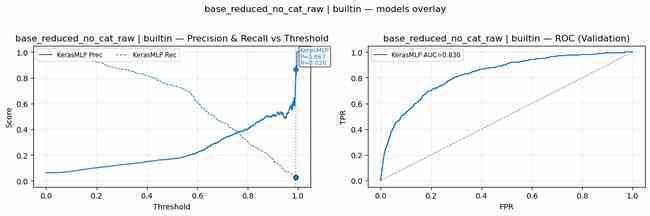


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: builtin
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step
    KerasMLP: thr=0.972  ValRec₁=0.027  ValPrec₁=0.867  ValROC₁=0.840


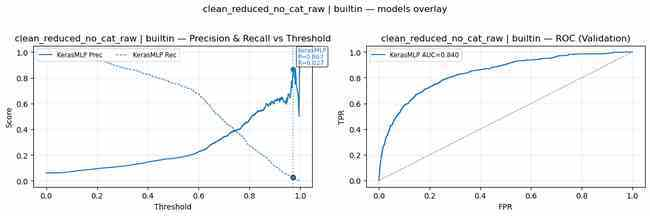


 Dataset: base_topcorr_only
Prepared dataset: Train=(55896, 4), Val=(7986, 4), Test=(15971, 4), Features=4, mode=numeric_only
  ◦ Sampling: builtin
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
    KerasMLP: thr=0.982  ValRec₁=0.024  ValPrec₁=0.800  ValROC₁=0.817


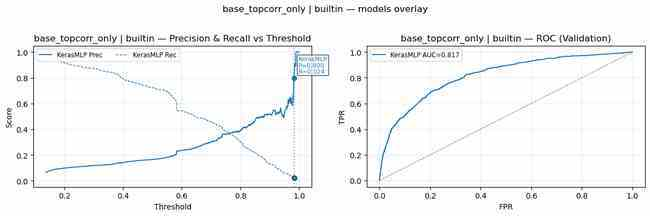


 Dataset: clean_topcorr_only
Prepared dataset: Train=(55674, 4), Val=(7954, 4), Test=(15907, 4), Features=4, mode=numeric_only
  ◦ Sampling: builtin
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step
    KerasMLP: thr=0.980  ValRec₁=0.021  ValPrec₁=0.833  ValROC₁=0.831


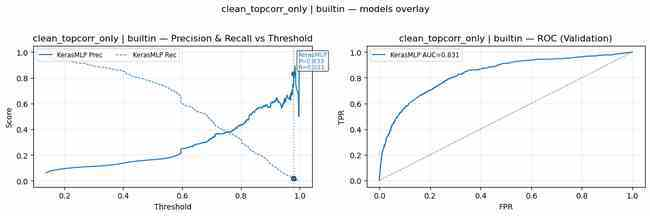


=== Keras MLP (precision=0.8) Summary ===


dataset     model sampling_method tuning_mode  \
6   base_reduced_no_cat_raw  KerasMLP         builtin   precision   
7  clean_reduced_no_cat_raw  KerasMLP         builtin   precision   
0                 base_full  KerasMLP         builtin   precision   
1                clean_full  KerasMLP         builtin   precision   
4       base_reduced_no_cat  KerasMLP         builtin   precision   
2              base_reduced  KerasMLP         builtin   precision   
3             clean_reduced  KerasMLP         builtin   precision   
9        clean_topcorr_only  KerasMLP         builtin   precision   
5      clean_reduced_no_cat  KerasMLP         builtin   precision   
8         base_topcorr_only  KerasMLP         builtin   precision   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
6            0.8          0.9914     0.8667    0.0260    0.0505    0.8295   
7            0.8          0.9715     0.8667    0.0268    0.0520    0.8396   
0            0.8          0.9861     0.8571    0.0240    0.0467    0.8296   
1            0.8          0.9829     0.8571    0.0247    0.0481    0.8406   
4            0.8          0.9899     0.8571    0.0240    0.0467    0.8291   
2            0.8          0.9721     0.8462    0.0220    0.0429    0.8295   
3            0.8          0.9857     0.8333    0.0206    0.0402    0.8381   
9            0.8          0.9796     0.8333    0.0206    0.0402    0.8313   
5            0.8          0.9503     0.8000    0.0330    0.0634    0.8407   
8            0.8          0.9820     0.8000    0.0240    0.0466    0.8169   

   test_prec1  test_rec1  test_f1_1  test_roc1  
6      0.7600     0.0190     0.0371     0.8463  
7      0.6829     0.0289     0.0554     0.8345  
0      0.6800     0.0170     0.0332     0.8468  
1      0.7105     0.0278     0.0536     0.8339  
4      0.6897     0.0200     0.0389     0.8473  
2      0.6250     0.0150     0.0293     0.8465  
3      0.7500     0.0247     0.0479     0.8317  
9      0.7647     0.0268     0.0518     0.8228  
5      0.6739     0.0320     0.0610     0.8348  
8      0.7407     0.0200     0.0389     0.8341

In [159]:
df_keras, keras_store = run_nn_pipeline_keras(
    datasets,
    sampling_method="builtin",   # or "smote"
    tuning_mode="precision",
    tuning_target=0.8,
    hidden_units=(256,128,64,32,16),
    dropout=0.2,
    lr=5e-4,
    batch_size=1024,
    epochs=50,
    show_plot=True,
    verbose=0
)



 Dataset: base_full
Prepared dataset: Train=(55896, 20), Val=(7986, 20), Test=(15971, 20), Features=20, mode=numeric_only
  ◦ Sampling: builtin


python(37891) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(37892) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(37893) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(37894) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(37895) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(37896) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(37897) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(37898) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(37899) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(37900) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


    SVM: thr=0.955  ValRec₁=0.022  ValPrec₁=0.917  ValROC₁=0.826


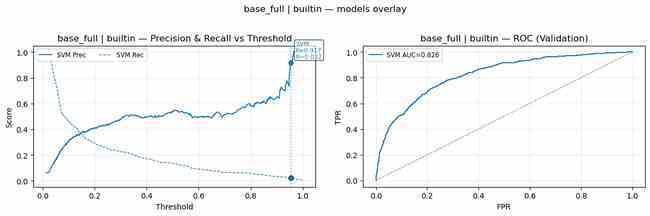


 Dataset: clean_full
Prepared dataset: Train=(55674, 20), Val=(7954, 20), Test=(15907, 20), Features=20, mode=numeric_only
  ◦ Sampling: builtin
    SVM: thr=0.948  ValRec₁=0.014  ValPrec₁=0.875  ValROC₁=0.838


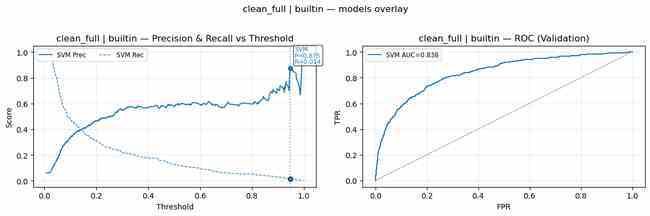


 Dataset: base_reduced
Prepared dataset: Train=(55896, 16), Val=(7986, 16), Test=(15971, 16), Features=16, mode=numeric_only
  ◦ Sampling: builtin
    SVM: thr=0.955  ValRec₁=0.022  ValPrec₁=0.917  ValROC₁=0.826


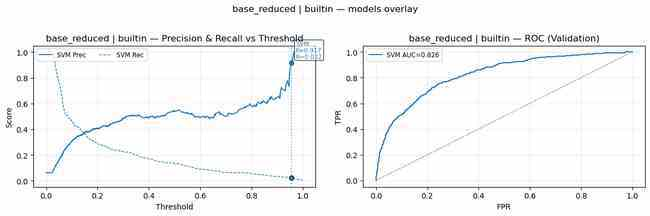


 Dataset: clean_reduced
Prepared dataset: Train=(55674, 16), Val=(7954, 16), Test=(15907, 16), Features=16, mode=numeric_only
  ◦ Sampling: builtin
    SVM: thr=0.948  ValRec₁=0.014  ValPrec₁=0.875  ValROC₁=0.838


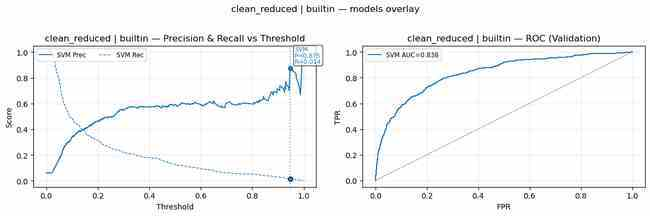


 Dataset: base_reduced_no_cat
Prepared dataset: Train=(55896, 10), Val=(7986, 10), Test=(15971, 10), Features=10, mode=numeric_only
  ◦ Sampling: builtin
    SVM: thr=0.956  ValRec₁=0.022  ValPrec₁=1.000  ValROC₁=0.826


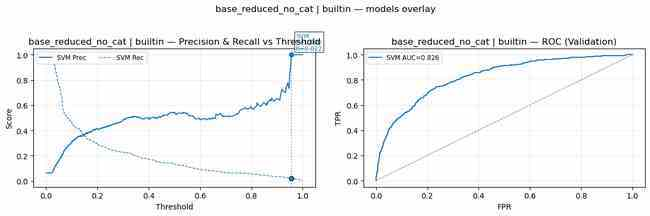


 Dataset: clean_reduced_no_cat
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: builtin
    SVM: thr=0.945  ValRec₁=0.014  ValPrec₁=0.875  ValROC₁=0.838


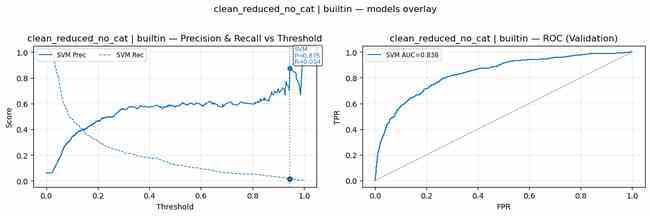


 Dataset: base_reduced_no_cat_raw
Prepared dataset: Train=(55896, 9), Val=(7986, 9), Test=(15971, 9), Features=9, mode=numeric_only
  ◦ Sampling: builtin
    SVM: thr=0.966  ValRec₁=0.018  ValPrec₁=0.900  ValROC₁=0.826


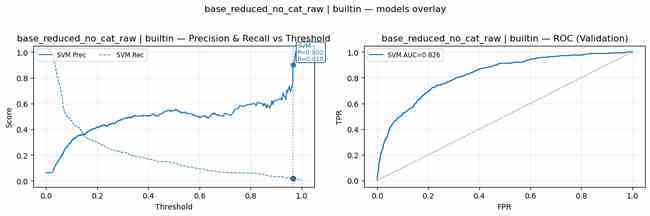


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: builtin


python(38002) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(38003) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(38004) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(38005) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(38006) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(38007) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(38008) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(38009) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(38010) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


    SVM: thr=0.930  ValRec₁=0.029  ValPrec₁=0.824  ValROC₁=0.837


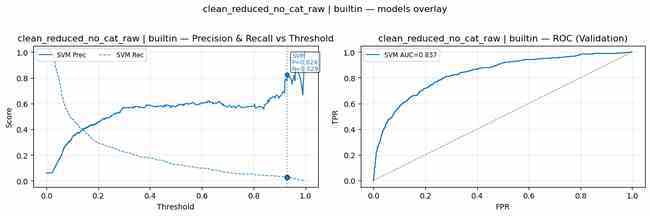


 Dataset: base_topcorr_only
Prepared dataset: Train=(55896, 4), Val=(7986, 4), Test=(15971, 4), Features=4, mode=numeric_only
  ◦ Sampling: builtin
    SVM: thr=0.962  ValRec₁=0.018  ValPrec₁=0.818  ValROC₁=0.817


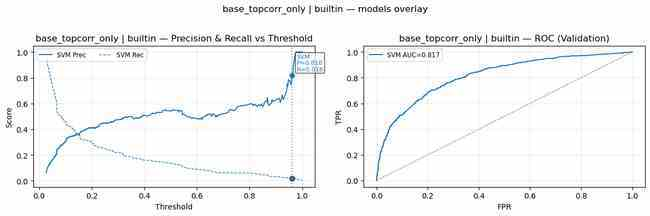


 Dataset: clean_topcorr_only
Prepared dataset: Train=(55674, 4), Val=(7954, 4), Test=(15907, 4), Features=4, mode=numeric_only
  ◦ Sampling: builtin
    SVM: thr=0.931  ValRec₁=0.025  ValPrec₁=0.800  ValROC₁=0.831


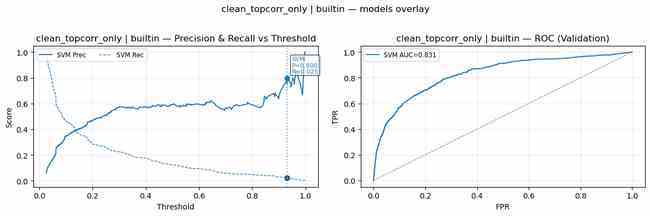


=== SVM (precision=0.8) Summary ===


dataset model sampling_method tuning_mode  tuning_target  \
4       base_reduced_no_cat   SVM         builtin   precision            0.8   
0                 base_full   SVM         builtin   precision            0.8   
2              base_reduced   SVM         builtin   precision            0.8   
6   base_reduced_no_cat_raw   SVM         builtin   precision            0.8   
1                clean_full   SVM         builtin   precision            0.8   
3             clean_reduced   SVM         builtin   precision            0.8   
5      clean_reduced_no_cat   SVM         builtin   precision            0.8   
7  clean_reduced_no_cat_raw   SVM         builtin   precision            0.8   
8         base_topcorr_only   SVM         builtin   precision            0.8   
9        clean_topcorr_only   SVM         builtin   precision            0.8   

   threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  test_prec1  \
4          0.9560     1.0000    0.0220    0.0431    0.8264      0.7727   
0          0.9554     0.9167    0.0220    0.0430    0.8261      0.7727   
2          0.9550     0.9167    0.0220    0.0430    0.8263      0.7727   
6          0.9660     0.9000    0.0180    0.0353    0.8260      0.8000   
1          0.9481     0.8750    0.0144    0.0284    0.8383      0.7667   
3          0.9476     0.8750    0.0144    0.0284    0.8379      0.7667   
5          0.9451     0.8750    0.0144    0.0284    0.8376      0.7667   
7          0.9300     0.8235    0.0289    0.0558    0.8374      0.6585   
8          0.9619     0.8182    0.0180    0.0352    0.8170      0.8095   
9          0.9315     0.8000    0.0247    0.0480    0.8312      0.6667   

   test_rec1  test_f1_1  test_roc1  
4     0.0170     0.0333     0.8438  
0     0.0170     0.0333     0.8433  
2     0.0170     0.0333     0.8430  
6     0.0160     0.0314     0.8430  
1     0.0237     0.0460     0.8314  
3     0.0237     0.0460     0.8320  
5     0.0237     0.0460     0.8321  
7     0.0278     0.0534     0.8317  
8     0.0170     0.0333     0.8339  
9     0.0268     0.0515     0.8232

In [160]:
df_svm, svm_store = run_svm_pipeline_tuned(
    datasets,
    sampling_method="builtin",
    tuning_mode="precision",
    tuning_target=0.8,
    search_type="grid",   # optional
    use_kernel_if_small=False,  # recommended for your large datasets
    show_plot=True
)


 Dataset: base_full
Prepared dataset: Train=(55896, 20), Val=(7986, 20), Test=(15971, 20), Features=20, mode=numeric_only
  ◦ Sampling: builtin
     XGB: thr=0.766  ValPrec₁=0.353  ValRec₁=0.356  AUC=0.818


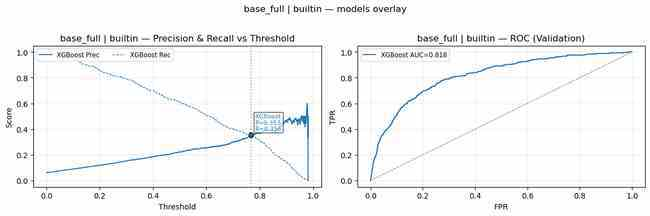


 Dataset: clean_full
Prepared dataset: Train=(55674, 20), Val=(7954, 20), Test=(15907, 20), Features=20, mode=numeric_only
  ◦ Sampling: builtin
     XGB: thr=0.975  ValPrec₁=0.857  ValRec₁=0.012  AUC=0.818


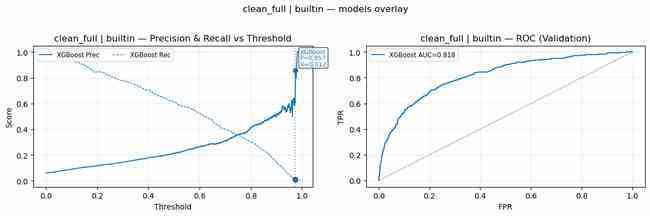


 Dataset: base_reduced
Prepared dataset: Train=(55896, 16), Val=(7986, 16), Test=(15971, 16), Features=16, mode=numeric_only
  ◦ Sampling: builtin
     XGB: thr=0.974  ValPrec₁=0.833  ValRec₁=0.010  AUC=0.816


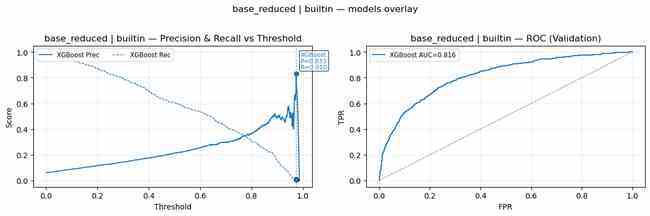


 Dataset: clean_reduced
Prepared dataset: Train=(55674, 16), Val=(7954, 16), Test=(15907, 16), Features=16, mode=numeric_only
  ◦ Sampling: builtin
     XGB: thr=0.979  ValPrec₁=0.875  ValRec₁=0.014  AUC=0.817


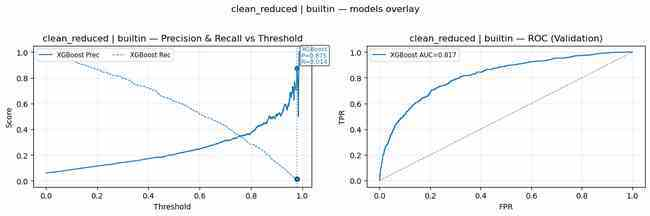


 Dataset: base_reduced_no_cat
Prepared dataset: Train=(55896, 10), Val=(7986, 10), Test=(15971, 10), Features=10, mode=numeric_only
  ◦ Sampling: builtin
     XGB: thr=0.666  ValPrec₁=0.282  ValRec₁=0.480  AUC=0.815


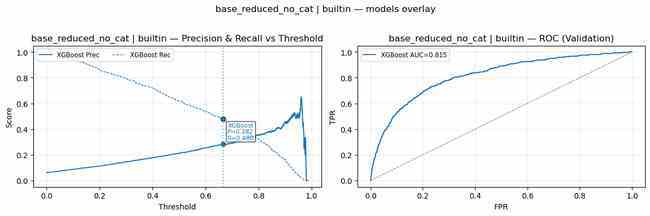


 Dataset: clean_reduced_no_cat
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: builtin
     XGB: thr=0.968  ValPrec₁=0.812  ValRec₁=0.027  AUC=0.820


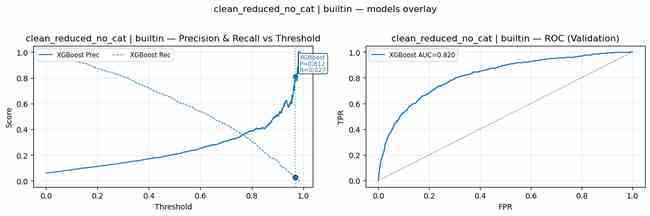


 Dataset: base_reduced_no_cat_raw
Prepared dataset: Train=(55896, 9), Val=(7986, 9), Test=(15971, 9), Features=9, mode=numeric_only
  ◦ Sampling: builtin
     XGB: thr=0.980  ValPrec₁=0.833  ValRec₁=0.010  AUC=0.815


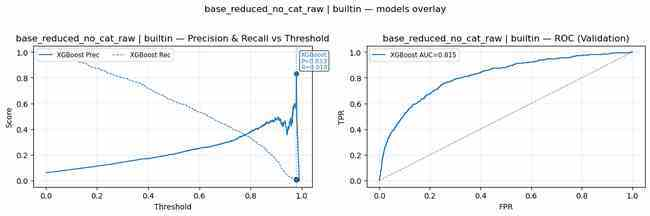


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: builtin
     XGB: thr=0.975  ValPrec₁=0.900  ValRec₁=0.019  AUC=0.824


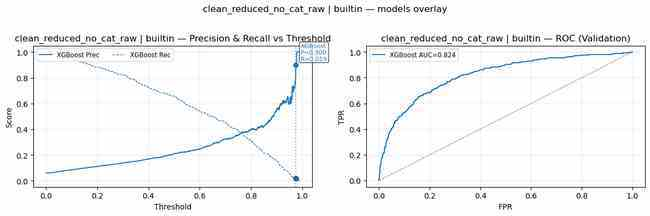


 Dataset: base_topcorr_only
Prepared dataset: Train=(55896, 4), Val=(7986, 4), Test=(15971, 4), Features=4, mode=numeric_only
  ◦ Sampling: builtin
     XGB: thr=0.743  ValPrec₁=0.297  ValRec₁=0.422  AUC=0.797


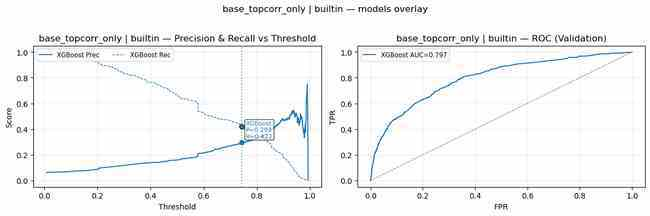


 Dataset: clean_topcorr_only
Prepared dataset: Train=(55674, 4), Val=(7954, 4), Test=(15907, 4), Features=4, mode=numeric_only
  ◦ Sampling: builtin
     XGB: thr=0.994  ValPrec₁=1.000  ValRec₁=0.010  AUC=0.818


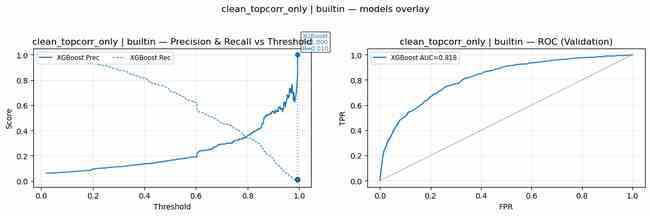


=== XGBoost (precision=0.8) Summary ===


dataset    model sampling_method tuning_mode  \
9        clean_topcorr_only  XGBoost         builtin   precision   
7  clean_reduced_no_cat_raw  XGBoost         builtin   precision   
3             clean_reduced  XGBoost         builtin   precision   
1                clean_full  XGBoost         builtin   precision   
2              base_reduced  XGBoost         builtin   precision   
6   base_reduced_no_cat_raw  XGBoost         builtin   precision   
5      clean_reduced_no_cat  XGBoost         builtin   precision   
0                 base_full  XGBoost         builtin   precision   
8         base_topcorr_only  XGBoost         builtin   precision   
4       base_reduced_no_cat  XGBoost         builtin   precision   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
9            0.8          0.9940     1.0000    0.0103    0.0204    0.8183   
7            0.8          0.9754     0.9000    0.0186    0.0364    0.8238   
3            0.8          0.9793     0.8750    0.0144    0.0284    0.8169   
1            0.8          0.9745     0.8571    0.0124    0.0244    0.8184   
2            0.8          0.9744     0.8333    0.0100    0.0198    0.8159   
6            0.8          0.9797     0.8333    0.0100    0.0198    0.8149   
5            0.8          0.9680     0.8125    0.0268    0.0519    0.8201   
0            0.8          0.7662     0.3532    0.3560    0.3546    0.8185   
8            0.8          0.7426     0.2972    0.4220    0.3488    0.7975   
4            0.8          0.6658     0.2824    0.4800    0.3556    0.8148   

   test_prec1  test_rec1  test_f1_1  test_roc1  
9      0.8750     0.0072     0.0143     0.8103  
7      0.7333     0.0113     0.0223     0.8146  
3      0.8125     0.0134     0.0264     0.8150  
1      0.8571     0.0124     0.0244     0.8169  
2      0.7647     0.0130     0.0256     0.8285  
6      0.6667     0.0060     0.0119     0.8271  
5      0.7586     0.0227     0.0440     0.8174  
0      0.3645     0.3660     0.3653     0.8260  
8      0.3129     0.4380     0.3650     0.8235  
4      0.3023     0.4800     0.3709     0.8267

In [161]:

df_xgb, xgb_store = run_xgb_pipeline_tuned(
    datasets,
    sampling_method="builtin"   #  internal scale_pos_weight
    , tuning_mode="precision"
)




 Dataset: base_full
Prepared dataset: Train=(55896, 20), Val=(7986, 20), Test=(15971, 20), Features=20, mode=numeric_only
  ◦ Sampling: smote
    ➤ Degree 1


python(38228) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(38230) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(38231) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(38233) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(38234) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(38235) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(38236) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(38237) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(38238) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


      deg=1: thr=0.993  ValRec₁=0.062  ValPrec₁=0.608
    ➤ Degree 2


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

      deg=2: thr=0.574  ValRec₁=0.496  ValPrec₁=0.274


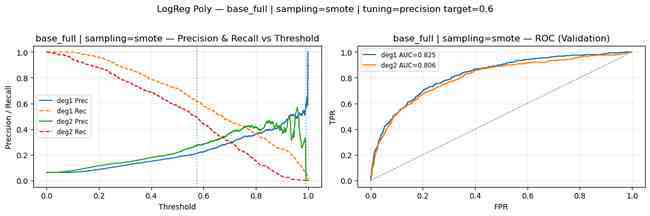


 Dataset: clean_full
Prepared dataset: Train=(55674, 20), Val=(7954, 20), Test=(15907, 20), Features=20, mode=numeric_only
  ◦ Sampling: smote
    ➤ Degree 1
      deg=1: thr=0.972  ValRec₁=0.126  ValPrec₁=0.604
    ➤ Degree 2


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

      deg=2: thr=0.835  ValRec₁=0.093  ValPrec₁=0.600


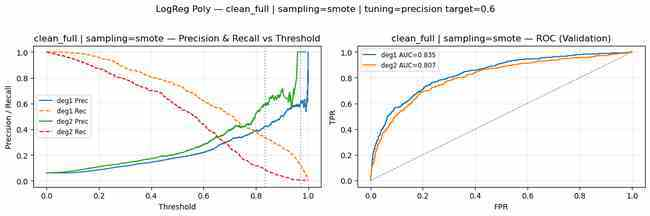


 Dataset: base_reduced
Prepared dataset: Train=(55896, 16), Val=(7986, 16), Test=(15971, 16), Features=16, mode=numeric_only
  ◦ Sampling: smote
    ➤ Degree 1


python(38489) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(38490) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(38491) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(38492) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


      deg=1: thr=0.994  ValRec₁=0.062  ValPrec₁=0.608
    ➤ Degree 2


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

      deg=2: thr=0.962  ValRec₁=0.012  ValPrec₁=0.857


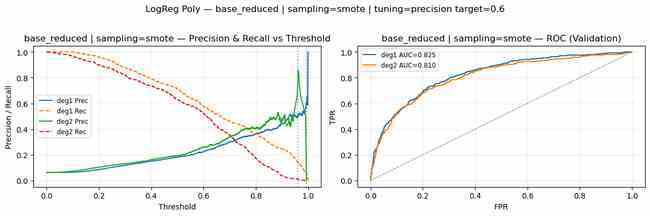


 Dataset: clean_reduced
Prepared dataset: Train=(55674, 16), Val=(7954, 16), Test=(15907, 16), Features=16, mode=numeric_only
  ◦ Sampling: smote
    ➤ Degree 1
      deg=1: thr=0.956  ValRec₁=0.167  ValPrec₁=0.600
    ➤ Degree 2


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

      deg=2: thr=0.849  ValRec₁=0.087  ValPrec₁=0.609


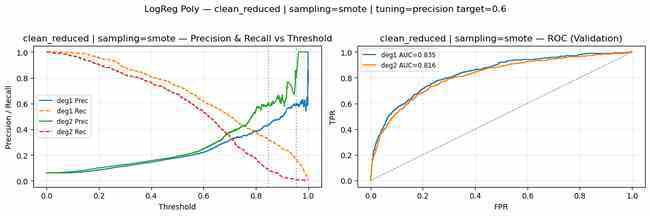


 Dataset: base_reduced_no_cat
Prepared dataset: Train=(55896, 10), Val=(7986, 10), Test=(15971, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    ➤ Degree 1
      deg=1: thr=0.993  ValRec₁=0.062  ValPrec₁=0.608
    ➤ Degree 2


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


      deg=2: thr=0.986  ValRec₁=0.012  ValPrec₁=0.600


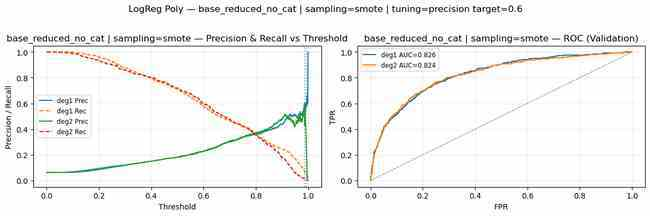


 Dataset: clean_reduced_no_cat
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    ➤ Degree 1


python(38915) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(38916) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(38917) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(38918) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(38919) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(38920) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(38921) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(38922) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(38923) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


      deg=1: thr=0.947  ValRec₁=0.186  ValPrec₁=0.600
    ➤ Degree 2
      deg=2: thr=0.936  ValRec₁=0.101  ValPrec₁=0.605


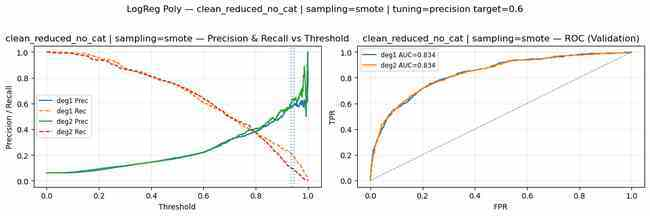


 Dataset: base_reduced_no_cat_raw
Prepared dataset: Train=(55896, 9), Val=(7986, 9), Test=(15971, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    ➤ Degree 1
      deg=1: thr=0.994  ValRec₁=0.060  ValPrec₁=0.612
    ➤ Degree 2
      deg=2: thr=0.762  ValRec₁=0.442  ValPrec₁=0.334


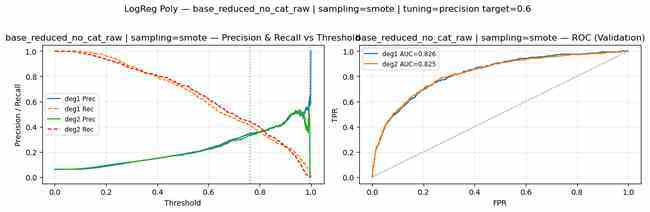


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    ➤ Degree 1
      deg=1: thr=0.948  ValRec₁=0.186  ValPrec₁=0.600
    ➤ Degree 2
      deg=2: thr=0.945  ValRec₁=0.142  ValPrec₁=0.600


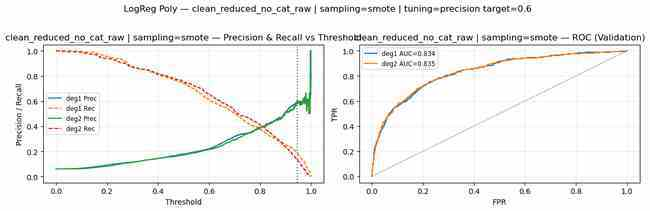


 Dataset: base_topcorr_only
Prepared dataset: Train=(55896, 4), Val=(7986, 4), Test=(15971, 4), Features=4, mode=numeric_only
  ◦ Sampling: smote
    ➤ Degree 1
      deg=1: thr=0.990  ValRec₁=0.066  ValPrec₁=0.600
    ➤ Degree 2
      deg=2: thr=0.999  ValRec₁=0.002  ValPrec₁=1.000


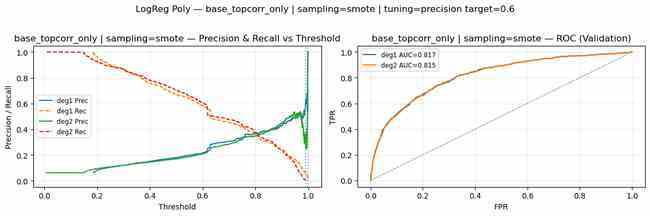


 Dataset: clean_topcorr_only
Prepared dataset: Train=(55674, 4), Val=(7954, 4), Test=(15907, 4), Features=4, mode=numeric_only
  ◦ Sampling: smote
    ➤ Degree 1
      deg=1: thr=0.963  ValRec₁=0.142  ValPrec₁=0.600
    ➤ Degree 2
      deg=2: thr=0.961  ValRec₁=0.078  ValPrec₁=0.613


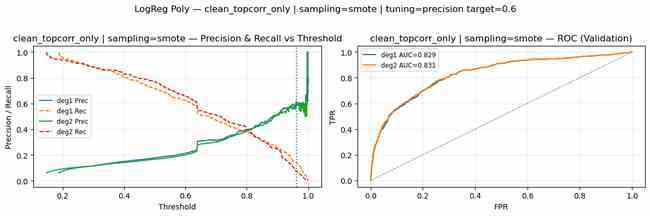


=== Logistic Regression Poly (precision=0.6) Summary ===


dataset                   model sampling_method  degree  \
17         base_topcorr_only  LogisticRegressionPoly           smote       2   
5               base_reduced  LogisticRegressionPoly           smote       2   
19        clean_topcorr_only  LogisticRegressionPoly           smote       2   
12   base_reduced_no_cat_raw  LogisticRegressionPoly           smote       1   
7              clean_reduced  LogisticRegressionPoly           smote       2   
8        base_reduced_no_cat  LogisticRegressionPoly           smote       1   
0                  base_full  LogisticRegressionPoly           smote       1   
4               base_reduced  LogisticRegressionPoly           smote       1   
11      clean_reduced_no_cat  LogisticRegressionPoly           smote       2   
2                 clean_full  LogisticRegressionPoly           smote       1   
6              clean_reduced  LogisticRegressionPoly           smote       1   
9        base_reduced_no_cat  LogisticRegressionPoly           smote       2   
3                 clean_full  LogisticRegressionPoly           smote       2   
14  clean_reduced_no_cat_raw  LogisticRegressionPoly           smote       1   
15  clean_reduced_no_cat_raw  LogisticRegressionPoly           smote       2   
16         base_topcorr_only  LogisticRegressionPoly           smote       1   
18        clean_topcorr_only  LogisticRegressionPoly           smote       1   
10      clean_reduced_no_cat  LogisticRegressionPoly           smote       1   
13   base_reduced_no_cat_raw  LogisticRegressionPoly           smote       2   
1                  base_full  LogisticRegressionPoly           smote       2   

   tuning_mode  tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  \
17   precision            0.6          0.9986     1.0000    0.0020    0.0040   
5    precision            0.6          0.9617     0.8571    0.0120    0.0237   
19   precision            0.6          0.9607     0.6129    0.0784    0.1389   
12   precision            0.6          0.9941     0.6122    0.0600    0.1093   
7    precision            0.6          0.8488     0.6087    0.0866    0.1516   
8    precision            0.6          0.9932     0.6078    0.0620    0.1125   
0    precision            0.6          0.9935     0.6078    0.0620    0.1125   
4    precision            0.6          0.9937     0.6078    0.0620    0.1125   
11   precision            0.6          0.9365     0.6049    0.1010    0.1731   
2    precision            0.6          0.9716     0.6040    0.1258    0.2082   
6    precision            0.6          0.9556     0.6000    0.1670    0.2613   
9    precision            0.6          0.9858     0.6000    0.0120    0.0235   
3    precision            0.6          0.8349     0.6000    0.0928    0.1607   
14   precision            0.6          0.9477     0.6000    0.1856    0.2835   
15   precision            0.6          0.9450     0.6000    0.1423    0.2300   
16   precision            0.6          0.9903     0.6000    0.0660    0.1189   
18   precision            0.6          0.9628     0.6000    0.1423    0.2300   
10   precision            0.6          0.9469     0.6000    0.1856    0.2835   
13   precision            0.6          0.7623     0.3343    0.4420    0.3807   
1    precision            0.6          0.5737     0.2737    0.4960    0.3528   

    val_roc1  test_prec1  test_rec1  test_f1_1  test_roc1  
17    0.8151      1.0000     0.0010     0.0020     0.8342  
5     0.8096      0.7500     0.0090     0.0178     0.8234  
19    0.8305      0.5385     0.0722     0.1273     0.8227  
12    0.8260      0.6517     0.0580     0.1065     0.8414  
7     0.8161      0.5130     0.0814     0.1406     0.8102  
8     0.8261      0.6598     0.0640     0.1167     0.8415  
0     0.8251      0.6667     0.0600     0.1101     0.8408  
4     0.8253      0.6593     0.0600     0.1100     0.8409  
11    0.8337      0.5597     0.0918     0.1577     0.8276  
2     0.8348      0.5550     0.1144     0.1897     0.8275  

In [162]:
param_grid = {"C":[0.01,0.1,1,10], "penalty":["l2"]}
df_logreg, logreg_store = run_logistic_poly_pipeline(
    datasets,
    degrees=(1,2),
    sampling_method="smote",
    search_type="random",
    param_grid=param_grid,
    n_iter=12,
    tuning_mode="precision",
    show_plot=True
)



 Dataset: base_full
Prepared dataset: Train=(55896, 20), Val=(7986, 20), Test=(15971, 20), Features=20, mode=numeric_only
  ◦ Sampling: smote


python(39059) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(39067) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(39069) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


    RandomForest: thr=0.425 ValRec₁=0.356 ValPrec₁=0.285


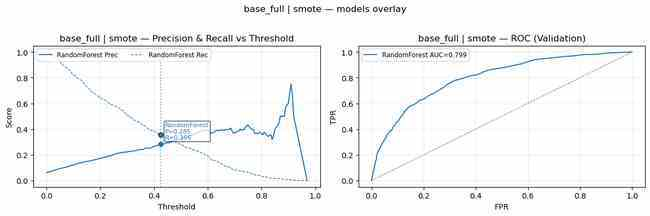


 Dataset: clean_full
Prepared dataset: Train=(55674, 20), Val=(7954, 20), Test=(15907, 20), Features=20, mode=numeric_only
  ◦ Sampling: smote
    RandomForest: thr=0.380 ValRec₁=0.400 ValPrec₁=0.284


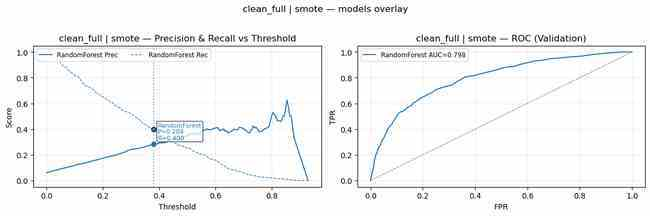


 Dataset: base_reduced
Prepared dataset: Train=(55896, 16), Val=(7986, 16), Test=(15971, 16), Features=16, mode=numeric_only
  ◦ Sampling: smote
    RandomForest: thr=0.415 ValRec₁=0.398 ValPrec₁=0.279


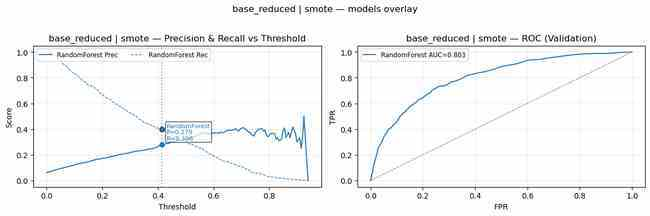


 Dataset: clean_reduced
Prepared dataset: Train=(55674, 16), Val=(7954, 16), Test=(15907, 16), Features=16, mode=numeric_only
  ◦ Sampling: smote
    RandomForest: thr=0.365 ValRec₁=0.454 ValPrec₁=0.270


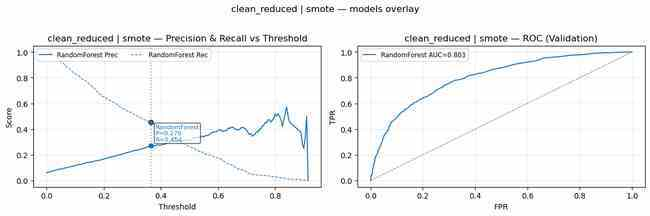


 Dataset: base_reduced_no_cat
Prepared dataset: Train=(55896, 10), Val=(7986, 10), Test=(15971, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    RandomForest: thr=0.385 ValRec₁=0.458 ValPrec₁=0.264


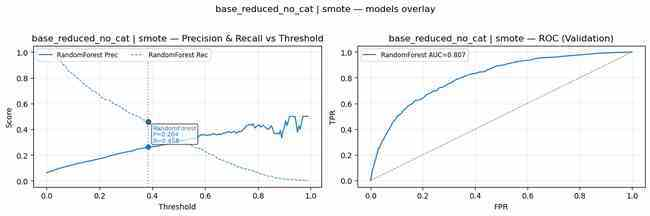


 Dataset: clean_reduced_no_cat
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    RandomForest: thr=0.980 ValRec₁=0.002 ValPrec₁=1.000


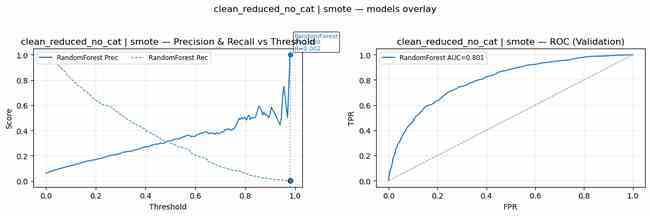


 Dataset: base_reduced_no_cat_raw
Prepared dataset: Train=(55896, 9), Val=(7986, 9), Test=(15971, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    RandomForest: thr=0.425 ValRec₁=0.426 ValPrec₁=0.278


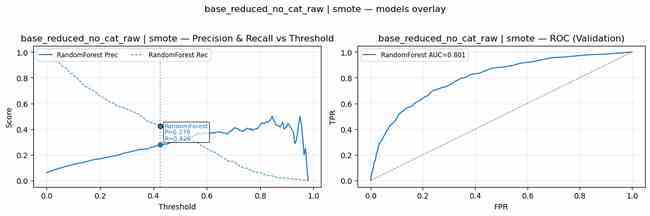


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    RandomForest: thr=0.465 ValRec₁=0.340 ValPrec₁=0.298


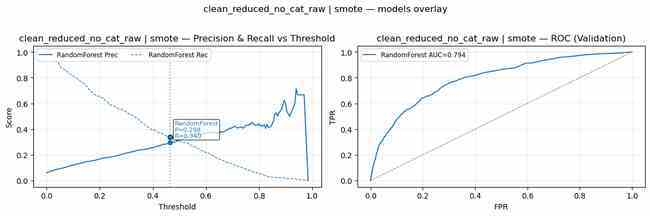


 Dataset: base_topcorr_only
Prepared dataset: Train=(55896, 4), Val=(7986, 4), Test=(15971, 4), Features=4, mode=numeric_only
  ◦ Sampling: smote
    RandomForest: thr=0.641 ValRec₁=0.406 ValPrec₁=0.259


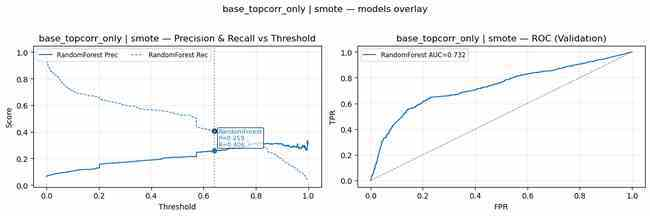


 Dataset: clean_topcorr_only
Prepared dataset: Train=(55674, 4), Val=(7954, 4), Test=(15907, 4), Features=4, mode=numeric_only
  ◦ Sampling: smote
    RandomForest: thr=0.648 ValRec₁=0.402 ValPrec₁=0.276


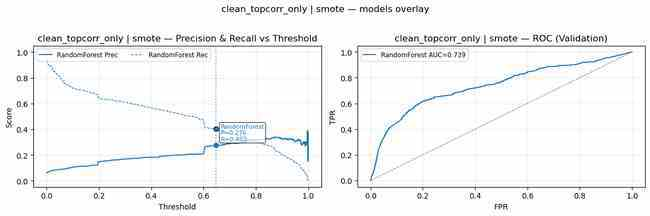


=== RandomForest (precision=0.8) Summary ===


dataset         model sampling_method tuning_mode  \
5      clean_reduced_no_cat  RandomForest           smote   precision   
7  clean_reduced_no_cat_raw  RandomForest           smote   precision   
0                 base_full  RandomForest           smote   precision   
1                clean_full  RandomForest           smote   precision   
2              base_reduced  RandomForest           smote   precision   
6   base_reduced_no_cat_raw  RandomForest           smote   precision   
9        clean_topcorr_only  RandomForest           smote   precision   
3             clean_reduced  RandomForest           smote   precision   
4       base_reduced_no_cat  RandomForest           smote   precision   
8         base_topcorr_only  RandomForest           smote   precision   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
5            0.8          0.9800     1.0000    0.0021    0.0041    0.8013   
7            0.8          0.4650     0.2978    0.3402    0.3176    0.7943   
0            0.8          0.4250     0.2853    0.3560    0.3167    0.7990   
1            0.8          0.3800     0.2836    0.4000    0.3319    0.7985   
2            0.8          0.4150     0.2795    0.3980    0.3284    0.8035   
6            0.8          0.4250     0.2781    0.4260    0.3365    0.8008   
9            0.8          0.6481     0.2758    0.4021    0.3272    0.7394   
3            0.8          0.3650     0.2699    0.4536    0.3385    0.8028   
4            0.8          0.3850     0.2641    0.4580    0.3350    0.8069   
8            0.8          0.6407     0.2593    0.4060    0.3164    0.7319   

   test_prec1  test_rec1  test_f1_1  test_roc1  
5      0.0000     0.0000     0.0000     0.8011  
7      0.2916     0.3412     0.3145     0.8031  
0      0.3273     0.3970     0.3588     0.8177  
1      0.2781     0.4206     0.3348     0.8083  
2      0.3058     0.4190     0.3536     0.8169  
6      0.2884     0.4240     0.3433     0.8035  
9      0.2648     0.3876     0.3146     0.7457  
3      0.2690     0.4567     0.3386     0.8078  
4      0.2741     0.4670     0.3454     0.8063  
8      0.2784     0.4050     0.3299     0.7490

In [163]:
df_rf, store_rf = run_random_forest_pipeline_tuned(datasets, sampling_method="smote", search_type="random",tuning_mode="precision", n_iter=12, show_plot=True)


 Dataset: base_full
Prepared dataset: Train=(55896, 20), Val=(7986, 20), Test=(15971, 20), Features=20, mode=numeric_only
  ◦ Sampling: none
    DecisionTree: thr=1.000 ValRec₁=0.226 ValPrec₁=0.190


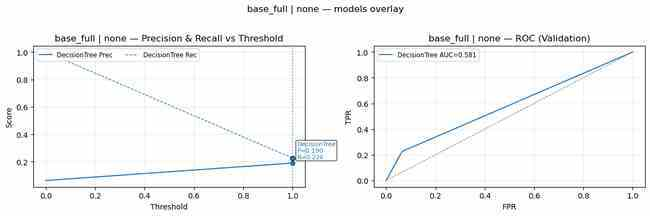


 Dataset: clean_full
Prepared dataset: Train=(55674, 20), Val=(7954, 20), Test=(15907, 20), Features=20, mode=numeric_only
  ◦ Sampling: none
    DecisionTree: thr=1.000 ValRec₁=0.198 ValPrec₁=0.175


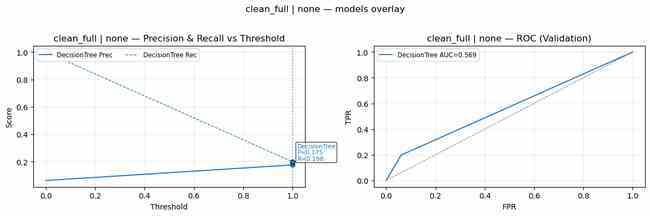


 Dataset: base_reduced
Prepared dataset: Train=(55896, 16), Val=(7986, 16), Test=(15971, 16), Features=16, mode=numeric_only
  ◦ Sampling: none
    DecisionTree: thr=1.000 ValRec₁=0.200 ValPrec₁=0.173


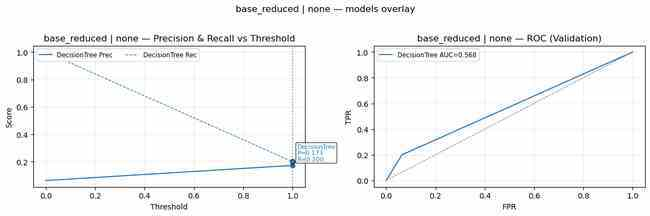


 Dataset: clean_reduced
Prepared dataset: Train=(55674, 16), Val=(7954, 16), Test=(15907, 16), Features=16, mode=numeric_only
  ◦ Sampling: none
    DecisionTree: thr=1.000 ValRec₁=0.231 ValPrec₁=0.213


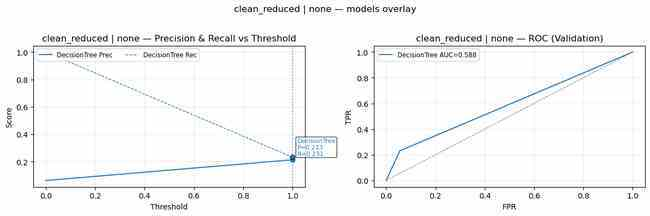


 Dataset: base_reduced_no_cat
Prepared dataset: Train=(55896, 10), Val=(7986, 10), Test=(15971, 10), Features=10, mode=numeric_only
  ◦ Sampling: none
    DecisionTree: thr=1.000 ValRec₁=0.220 ValPrec₁=0.196


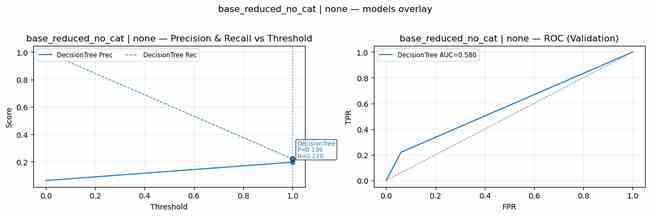


 Dataset: clean_reduced_no_cat
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: none
    DecisionTree: thr=1.000 ValRec₁=0.225 ValPrec₁=0.195


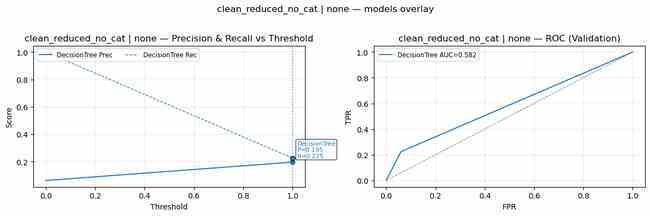


 Dataset: base_reduced_no_cat_raw
Prepared dataset: Train=(55896, 9), Val=(7986, 9), Test=(15971, 9), Features=9, mode=numeric_only
  ◦ Sampling: none
    DecisionTree: thr=1.000 ValRec₁=0.232 ValPrec₁=0.200


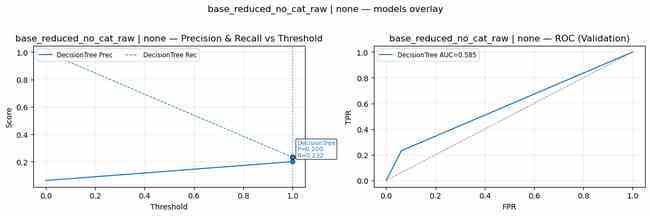


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: none
    DecisionTree: thr=1.000 ValRec₁=0.225 ValPrec₁=0.201


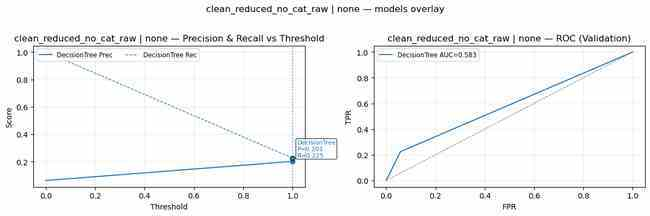


 Dataset: base_topcorr_only
Prepared dataset: Train=(55896, 4), Val=(7986, 4), Test=(15971, 4), Features=4, mode=numeric_only
  ◦ Sampling: none
    DecisionTree: thr=0.282 ValRec₁=0.274 ValPrec₁=0.290


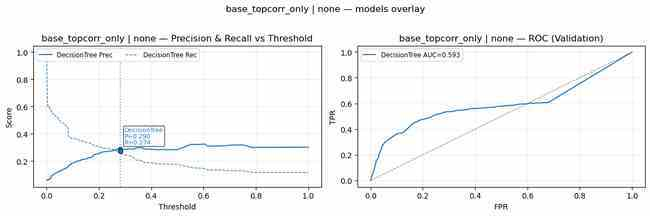


 Dataset: clean_topcorr_only
Prepared dataset: Train=(55674, 4), Val=(7954, 4), Test=(15907, 4), Features=4, mode=numeric_only
  ◦ Sampling: none
    DecisionTree: thr=0.256 ValRec₁=0.256 ValPrec₁=0.316


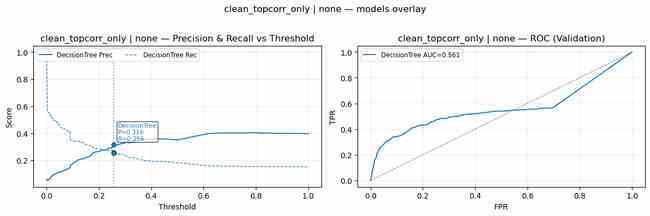


=== DecisionTree (precision=0.8) Summary ===


dataset         model sampling_method tuning_mode  \
9        clean_topcorr_only  DecisionTree            none   precision   
8         base_topcorr_only  DecisionTree            none   precision   
3             clean_reduced  DecisionTree            none   precision   
7  clean_reduced_no_cat_raw  DecisionTree            none   precision   
6   base_reduced_no_cat_raw  DecisionTree            none   precision   
4       base_reduced_no_cat  DecisionTree            none   precision   
5      clean_reduced_no_cat  DecisionTree            none   precision   
0                 base_full  DecisionTree            none   precision   
1                clean_full  DecisionTree            none   precision   
2              base_reduced  DecisionTree            none   precision   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
9            0.8          0.2564     0.3163    0.2557    0.2828    0.5608   
8            0.8          0.2815     0.2896    0.2740    0.2816    0.5927   
3            0.8          1.0000     0.2125    0.2309    0.2213    0.5877   
7            0.8          1.0000     0.2007    0.2247    0.2121    0.5833   
6            0.8          1.0000     0.2000    0.2320    0.2148    0.5850   
4            0.8          1.0000     0.1961    0.2200    0.2074    0.5799   
5            0.8          1.0000     0.1953    0.2247    0.2090    0.5823   
0            0.8          1.0000     0.1899    0.2260    0.2064    0.5808   
1            0.8          1.0000     0.1749    0.1979    0.1857    0.5686   
2            0.8          1.0000     0.1727    0.2000    0.1854    0.5680   

   test_prec1  test_rec1  test_f1_1  test_roc1  
9      0.3119     0.2649     0.2865     0.5896  
8      0.3143     0.2700     0.2905     0.5871  
3      0.2069     0.2464     0.2249     0.5925  
7      0.2067     0.2361     0.2204     0.5886  
6      0.1948     0.2300     0.2109     0.5832  
4      0.2025     0.2300     0.2154     0.5847  
5      0.1937     0.2155     0.2040     0.5786  
0      0.2105     0.2520     0.2294     0.5944  
1      0.1920     0.2227     0.2062     0.5809  
2      0.2013     0.2240     0.2120     0.5823

In [164]:
df_dt, store_dt = run_decision_tree_pipeline_tuned(datasets, sampling_method="none",tuning_mode="precision", search_type=None, show_plot=True)



 Dataset: base_full
Prepared dataset: Train=(55896, 20), Val=(7986, 20), Test=(15971, 20), Features=20, mode=numeric_only
  ◦ Sampling: smote
    NearestCentroid: thr=0.522 ValRec₁=0.460 ValPrec₁=0.300 ValAUC₁=0.800


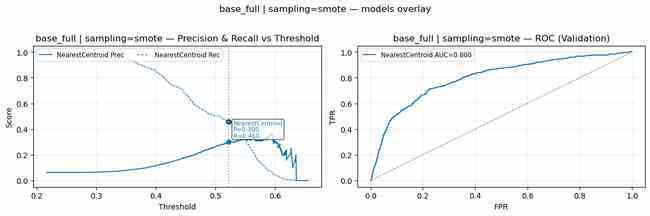


 Dataset: clean_full
Prepared dataset: Train=(55674, 20), Val=(7954, 20), Test=(15907, 20), Features=20, mode=numeric_only
  ◦ Sampling: smote
    NearestCentroid: thr=0.636 ValRec₁=0.002 ValPrec₁=1.000 ValAUC₁=0.805


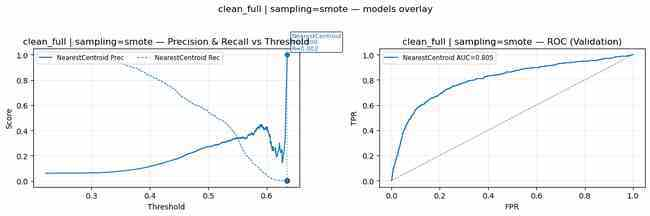


 Dataset: base_reduced
Prepared dataset: Train=(55896, 16), Val=(7986, 16), Test=(15971, 16), Features=16, mode=numeric_only
  ◦ Sampling: smote
    NearestCentroid: thr=0.522 ValRec₁=0.454 ValPrec₁=0.301 ValAUC₁=0.807


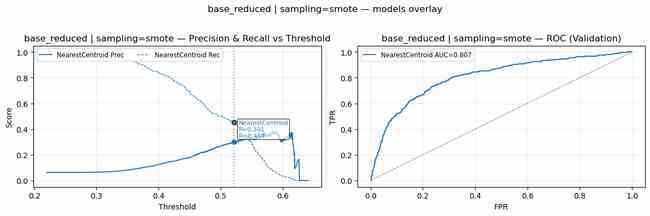


 Dataset: clean_reduced
Prepared dataset: Train=(55674, 16), Val=(7954, 16), Test=(15907, 16), Features=16, mode=numeric_only
  ◦ Sampling: smote
    NearestCentroid: thr=0.529 ValRec₁=0.464 ValPrec₁=0.328 ValAUC₁=0.811


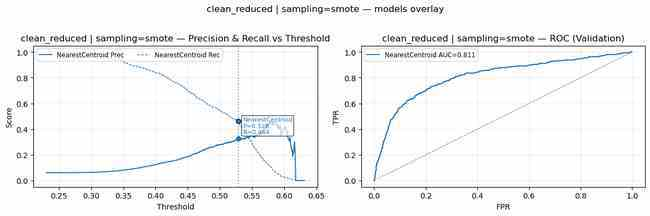


 Dataset: base_reduced_no_cat
Prepared dataset: Train=(55896, 10), Val=(7986, 10), Test=(15971, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    NearestCentroid: thr=0.522 ValRec₁=0.454 ValPrec₁=0.299 ValAUC₁=0.803


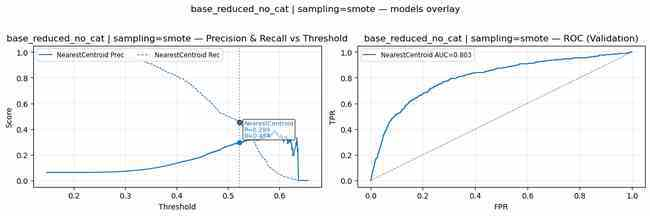


 Dataset: clean_reduced_no_cat
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    NearestCentroid: thr=0.527 ValRec₁=0.472 ValPrec₁=0.318 ValAUC₁=0.808


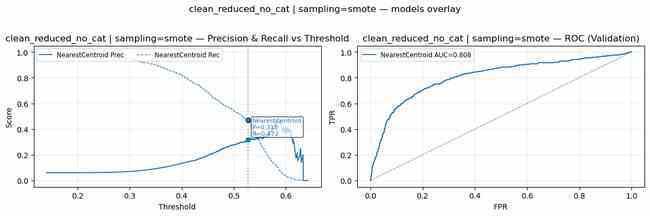


 Dataset: base_reduced_no_cat_raw
Prepared dataset: Train=(55896, 9), Val=(7986, 9), Test=(15971, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    NearestCentroid: thr=0.523 ValRec₁=0.458 ValPrec₁=0.304 ValAUC₁=0.808


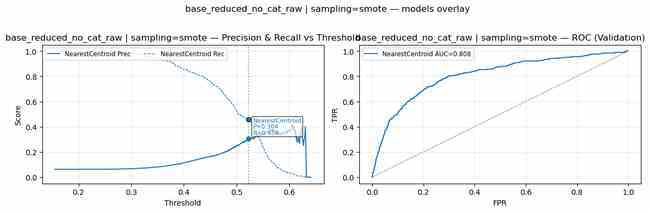


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    NearestCentroid: thr=0.527 ValRec₁=0.454 ValPrec₁=0.333 ValAUC₁=0.814


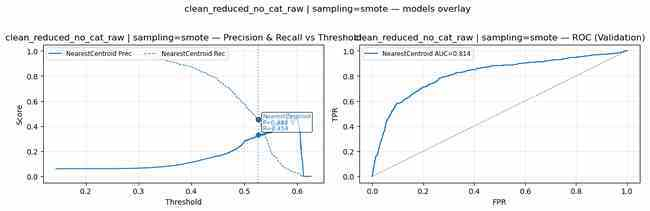


 Dataset: base_topcorr_only
Prepared dataset: Train=(55896, 4), Val=(7986, 4), Test=(15971, 4), Features=4, mode=numeric_only
  ◦ Sampling: smote
    NearestCentroid: thr=0.522 ValRec₁=0.478 ValPrec₁=0.285 ValAUC₁=0.776


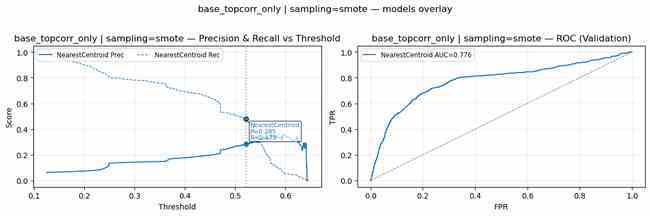


 Dataset: clean_topcorr_only
Prepared dataset: Train=(55674, 4), Val=(7954, 4), Test=(15907, 4), Features=4, mode=numeric_only
  ◦ Sampling: smote
    NearestCentroid: thr=0.520 ValRec₁=0.518 ValPrec₁=0.301 ValAUC₁=0.804


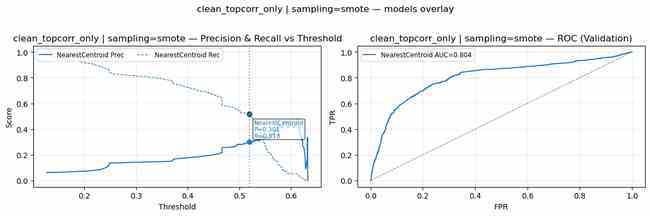


=== NearestCentroid (precision=0.8) Summary ===


dataset            model sampling_method tuning_mode  \
1                clean_full  NearestCentroid           smote   precision   
7  clean_reduced_no_cat_raw  NearestCentroid           smote   precision   
3             clean_reduced  NearestCentroid           smote   precision   
5      clean_reduced_no_cat  NearestCentroid           smote   precision   
6   base_reduced_no_cat_raw  NearestCentroid           smote   precision   
2              base_reduced  NearestCentroid           smote   precision   
9        clean_topcorr_only  NearestCentroid           smote   precision   
0                 base_full  NearestCentroid           smote   precision   
4       base_reduced_no_cat  NearestCentroid           smote   precision   
8         base_topcorr_only  NearestCentroid           smote   precision   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
1            0.8          0.6355     1.0000    0.0021    0.0041    0.8047   
7            0.8          0.5270     0.3328    0.4536    0.3839    0.8137   
3            0.8          0.5289     0.3280    0.4639    0.3843    0.8115   
5            0.8          0.5273     0.3181    0.4722    0.3801    0.8084   
6            0.8          0.5227     0.3037    0.4580    0.3652    0.8084   
2            0.8          0.5218     0.3015    0.4540    0.3623    0.8075   
9            0.8          0.5197     0.3013    0.5175    0.3809    0.8042   
0            0.8          0.5222     0.2999    0.4600    0.3631    0.7995   
4            0.8          0.5225     0.2987    0.4540    0.3603    0.8034   
8            0.8          0.5215     0.2849    0.4780    0.3570    0.7758   

   test_prec1  test_rec1  test_f1_1  test_roc1  
1      0.2857     0.0021     0.0041     0.8018  
7      0.3147     0.4247     0.3616     0.8158  
3      0.3096     0.4299     0.3599     0.8134  
5      0.3056     0.4433     0.3618     0.8106  
6      0.3093     0.4590     0.3696     0.8177  
2      0.3098     0.4530     0.3680     0.8157  
9      0.3001     0.4928     0.3730     0.7958  
0      0.3061     0.4610     0.3679     0.8045  
4      0.3092     0.4570     0.3688     0.8113  
8      0.2975     0.4900     0.3702     0.8025

In [165]:
df_nc, store_nc = run_nearest_centroid_pipeline(datasets, sampling_method="smote",tuning_mode="precision", show_plot=True)



 Dataset: base_full
Prepared dataset: Train=(55896, 20), Val=(7986, 20), Test=(15971, 20), Features=20, mode=numeric_only
  ◦ Sampling: smote
    RadiusNeighbors: thr=0.667 ValRec₁=0.156 ValPrec₁=0.133 ValAUC₁=0.450


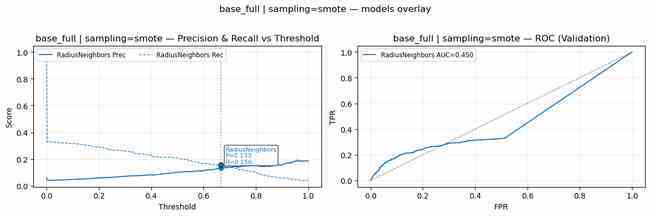


 Dataset: clean_full
Prepared dataset: Train=(55674, 20), Val=(7954, 20), Test=(15907, 20), Features=20, mode=numeric_only
  ◦ Sampling: smote
    RadiusNeighbors: thr=0.627 ValRec₁=0.159 ValPrec₁=0.102 ValAUC₁=0.432


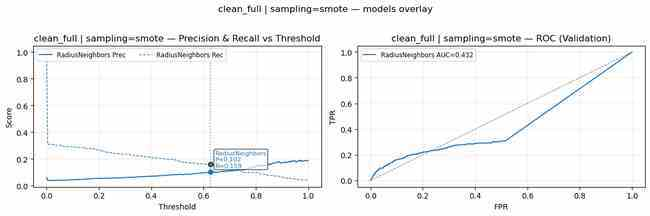


 Dataset: base_reduced
Prepared dataset: Train=(55896, 16), Val=(7986, 16), Test=(15971, 16), Features=16, mode=numeric_only
  ◦ Sampling: smote
    RadiusNeighbors: thr=0.667 ValRec₁=0.216 ValPrec₁=0.165 ValAUC₁=0.464


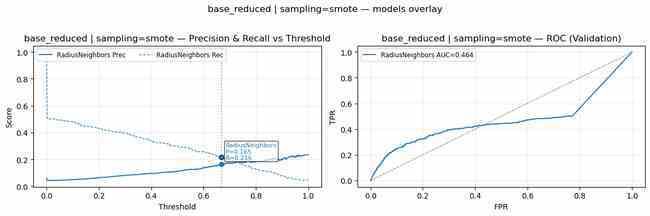


 Dataset: clean_reduced
Prepared dataset: Train=(55674, 16), Val=(7954, 16), Test=(15907, 16), Features=16, mode=numeric_only
  ◦ Sampling: smote
    RadiusNeighbors: thr=0.765 ValRec₁=0.144 ValPrec₁=0.175 ValAUC₁=0.462


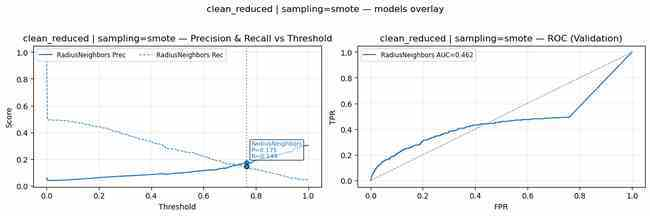


 Dataset: base_reduced_no_cat
Prepared dataset: Train=(55896, 10), Val=(7986, 10), Test=(15971, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    RadiusNeighbors: thr=0.708 ValRec₁=0.302 ValPrec₁=0.227 ValAUC₁=0.604


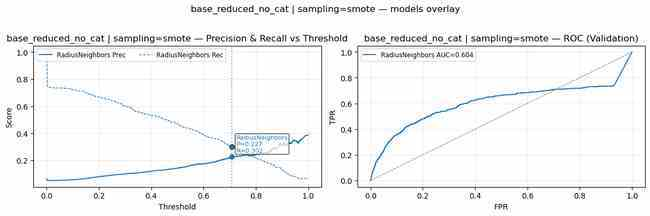


 Dataset: clean_reduced_no_cat
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    RadiusNeighbors: thr=0.690 ValRec₁=0.336 ValPrec₁=0.226 ValAUC₁=0.608


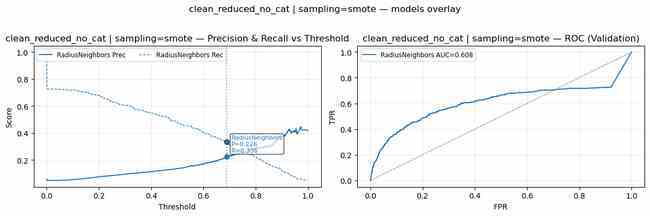


 Dataset: base_reduced_no_cat_raw
Prepared dataset: Train=(55896, 9), Val=(7986, 9), Test=(15971, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    RadiusNeighbors: thr=0.706 ValRec₁=0.346 ValPrec₁=0.236 ValAUC₁=0.641


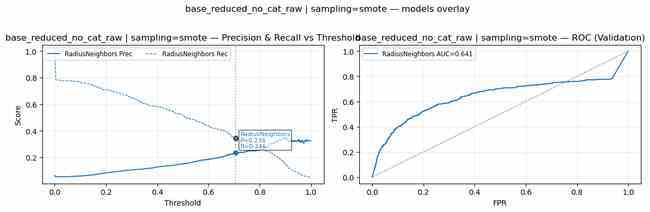


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    RadiusNeighbors: thr=0.784 ValRec₁=0.285 ValPrec₁=0.303 ValAUC₁=0.641


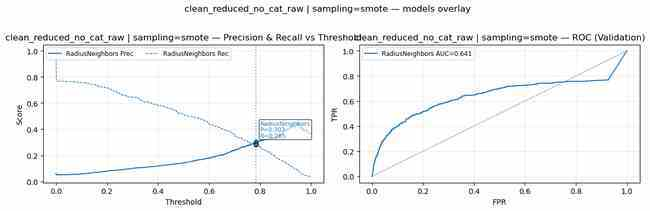


 Dataset: base_topcorr_only
Prepared dataset: Train=(55896, 4), Val=(7986, 4), Test=(15971, 4), Features=4, mode=numeric_only
  ◦ Sampling: smote
    RadiusNeighbors: thr=0.778 ValRec₁=0.404 ValPrec₁=0.342 ValAUC₁=0.797


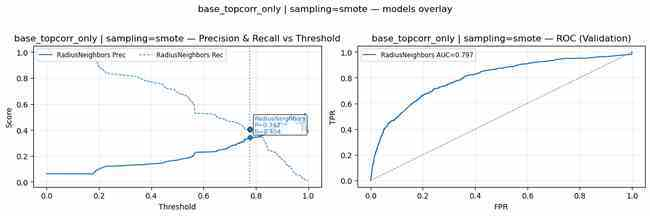


 Dataset: clean_topcorr_only
Prepared dataset: Train=(55674, 4), Val=(7954, 4), Test=(15907, 4), Features=4, mode=numeric_only
  ◦ Sampling: smote
    RadiusNeighbors: thr=0.731 ValRec₁=0.443 ValPrec₁=0.341 ValAUC₁=0.807


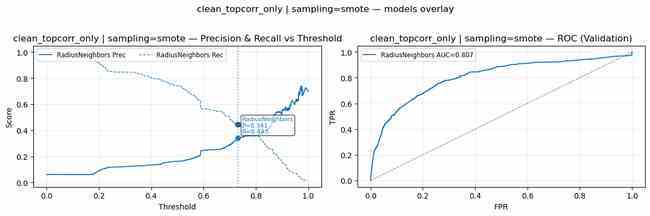


=== RadiusNeighbors (precision=0.8) Summary ===


dataset            model sampling_method tuning_mode  \
8         base_topcorr_only  RadiusNeighbors           smote   precision   
9        clean_topcorr_only  RadiusNeighbors           smote   precision   
7  clean_reduced_no_cat_raw  RadiusNeighbors           smote   precision   
6   base_reduced_no_cat_raw  RadiusNeighbors           smote   precision   
4       base_reduced_no_cat  RadiusNeighbors           smote   precision   
5      clean_reduced_no_cat  RadiusNeighbors           smote   precision   
3             clean_reduced  RadiusNeighbors           smote   precision   
2              base_reduced  RadiusNeighbors           smote   precision   
0                 base_full  RadiusNeighbors           smote   precision   
1                clean_full  RadiusNeighbors           smote   precision   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
8            0.8          0.7778     0.3424    0.4040    0.3706    0.7974   
9            0.8          0.7309     0.3413    0.4433    0.3857    0.8069   
7            0.8          0.7841     0.3033    0.2845    0.2936    0.6413   
6            0.8          0.7059     0.2360    0.3460    0.2806    0.6411   
4            0.8          0.7084     0.2274    0.3020    0.2595    0.6040   
5            0.8          0.6897     0.2261    0.3361    0.2703    0.6080   
3            0.8          0.7647     0.1754    0.1443    0.1584    0.4618   
2            0.8          0.6674     0.1654    0.2160    0.1873    0.4644   
0            0.8          0.6667     0.1331    0.1560    0.1436    0.4497   
1            0.8          0.6271     0.1016    0.1588    0.1239    0.4320   

   test_prec1  test_rec1  test_f1_1  test_roc1  
8      0.3466     0.4090     0.3752     0.8106  
9      0.3266     0.4186     0.3669     0.8053  
7      0.2767     0.2887     0.2825     0.6649  
6      0.2298     0.3250     0.2693     0.6447  
4      0.2183     0.2790     0.2450     0.5960  
5      0.2055     0.3227     0.2511     0.6157  
3      0.1880     0.1619     0.1740     0.4756  
2      0.1542     0.1920     0.1710     0.4696  
0      0.1158     0.1380     0.1259     0.4330  
1      0.1104     0.1619     0.1313     0.4320

In [241]:
df_rad, store_rad = run_radius_neighbors_pipeline(datasets, sampling_method="smote",tuning_mode="precision", show_plot=True)



 Dataset: base_full
Prepared dataset: Train=(55896, 20), Val=(7986, 20), Test=(15971, 20), Features=20, mode=numeric_only
  ◦ Sampling: smote


python(41170) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41171) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41172) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41173) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41174) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41175) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41176) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41177) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41178) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41179) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41180) Malloc

    KNeighbors: thr=0.396 ValRec₁=0.402 ValPrec₁=0.167 ValAUC₁=0.670


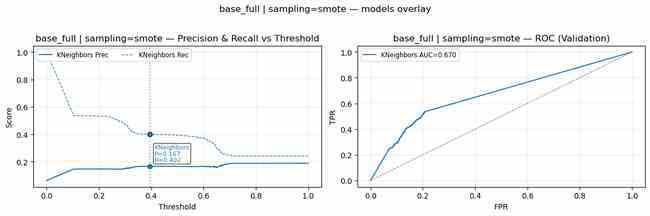


 Dataset: clean_full
Prepared dataset: Train=(55674, 20), Val=(7954, 20), Test=(15907, 20), Features=20, mode=numeric_only
  ◦ Sampling: smote
    KNeighbors: thr=0.407 ValRec₁=0.414 ValPrec₁=0.170 ValAUC₁=0.672


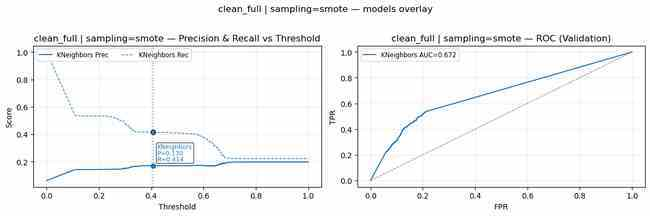


 Dataset: base_reduced
Prepared dataset: Train=(55896, 16), Val=(7986, 16), Test=(15971, 16), Features=16, mode=numeric_only
  ◦ Sampling: smote
    KNeighbors: thr=0.544 ValRec₁=0.398 ValPrec₁=0.165 ValAUC₁=0.666


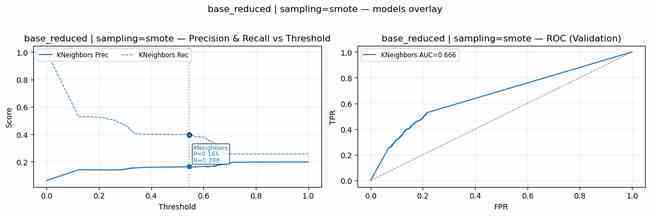


 Dataset: clean_reduced
Prepared dataset: Train=(55674, 16), Val=(7954, 16), Test=(15907, 16), Features=16, mode=numeric_only
  ◦ Sampling: smote
    KNeighbors: thr=0.391 ValRec₁=0.410 ValPrec₁=0.169 ValAUC₁=0.670


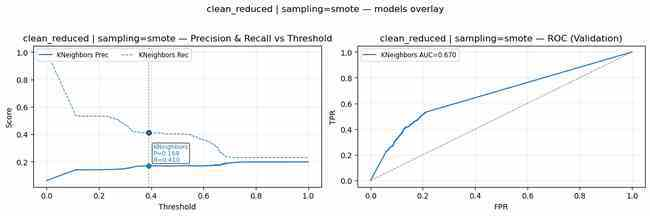


 Dataset: base_reduced_no_cat
Prepared dataset: Train=(55896, 10), Val=(7986, 10), Test=(15971, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    KNeighbors: thr=0.348 ValRec₁=0.442 ValPrec₁=0.163 ValAUC₁=0.676


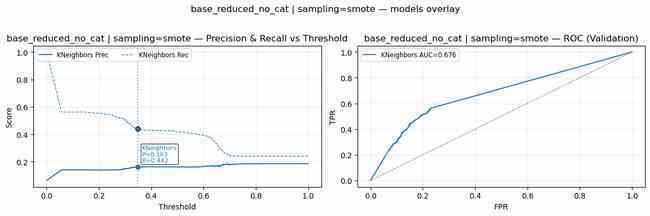


 Dataset: clean_reduced_no_cat
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    KNeighbors: thr=0.533 ValRec₁=0.416 ValPrec₁=0.170 ValAUC₁=0.684


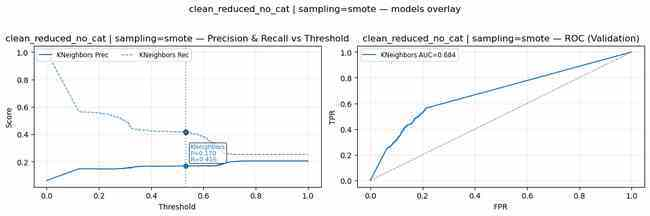


 Dataset: base_reduced_no_cat_raw
Prepared dataset: Train=(55896, 9), Val=(7986, 9), Test=(15971, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    KNeighbors: thr=0.348 ValRec₁=0.460 ValPrec₁=0.167 ValAUC₁=0.682


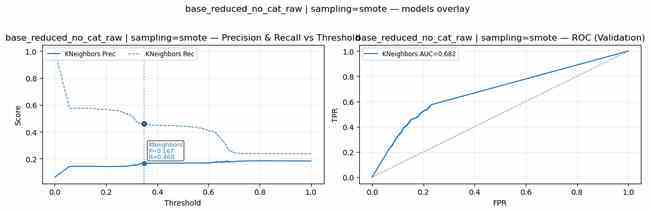


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    KNeighbors: thr=0.561 ValRec₁=0.439 ValPrec₁=0.179 ValAUC₁=0.692


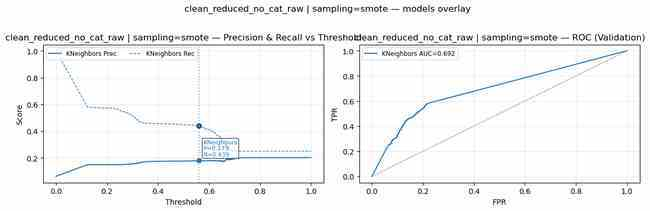


 Dataset: base_topcorr_only
Prepared dataset: Train=(55896, 4), Val=(7986, 4), Test=(15971, 4), Features=4, mode=numeric_only
  ◦ Sampling: smote
    KNeighbors: thr=0.380 ValRec₁=0.334 ValPrec₁=0.278 ValAUC₁=0.683


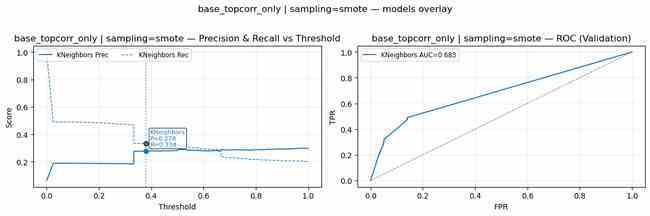


 Dataset: clean_topcorr_only
Prepared dataset: Train=(55674, 4), Val=(7954, 4), Test=(15907, 4), Features=4, mode=numeric_only
  ◦ Sampling: smote
    KNeighbors: thr=0.333 ValRec₁=0.336 ValPrec₁=0.298 ValAUC₁=0.687


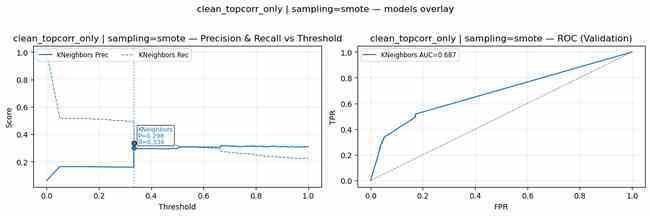


=== KNeighbors (precision=0.8) Summary ===


dataset       model sampling_method tuning_mode  \
9        clean_topcorr_only  KNeighbors           smote   precision   
8         base_topcorr_only  KNeighbors           smote   precision   
7  clean_reduced_no_cat_raw  KNeighbors           smote   precision   
1                clean_full  KNeighbors           smote   precision   
5      clean_reduced_no_cat  KNeighbors           smote   precision   
3             clean_reduced  KNeighbors           smote   precision   
6   base_reduced_no_cat_raw  KNeighbors           smote   precision   
0                 base_full  KNeighbors           smote   precision   
2              base_reduced  KNeighbors           smote   precision   
4       base_reduced_no_cat  KNeighbors           smote   precision   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
9            0.8          0.3333     0.2980    0.3361    0.3159    0.6871   
8            0.8          0.3796     0.2783    0.3340    0.3036    0.6835   
7            0.8          0.5608     0.1787    0.4392    0.2540    0.6918   
1            0.8          0.4070     0.1701    0.4144    0.2412    0.6723   
5            0.8          0.5333     0.1696    0.4165    0.2411    0.6837   
3            0.8          0.3909     0.1685    0.4103    0.2389    0.6703   
6            0.8          0.3483     0.1672    0.4600    0.2452    0.6823   
0            0.8          0.3955     0.1668    0.4020    0.2358    0.6702   
2            0.8          0.5441     0.1646    0.3980    0.2329    0.6656   
4            0.8          0.3483     0.1630    0.4420    0.2381    0.6762   

   test_prec1  test_rec1  test_f1_1  test_roc1  
9      0.2948     0.3340     0.3132     0.6863  
8      0.3034     0.3380     0.3198     0.6829  
7      0.1725     0.4340     0.2469     0.6901  
1      0.1761     0.4351     0.2507     0.6805  
5      0.1696     0.4320     0.2436     0.6884  
3      0.1719     0.4423     0.2476     0.6872  
6      0.1772     0.4650     0.2566     0.6976  
0      0.1799     0.4350     0.2545     0.6948  
2      0.1898     0.4390     0.2650     0.6926  
4      0.1765     0.4650     0.2558     0.6977

In [242]:
df_knn, store_knn = run_knn_pipeline(datasets, sampling_method="smote", search_type="random", n_iter=16,tuning_mode="precision", show_plot=True)

### F1 Tuning


 Dataset: base_full
Prepared dataset: Train=(55896, 20), Val=(7986, 20), Test=(15971, 20), Features=20, mode=numeric_only
  ◦ Sampling: smote
    Trained LinearSVC_calib: thr=0.744 val_roc=0.823
    Trained XGBoost: thr=0.343 val_roc=0.814
    Trained LogisticRegression: thr=0.757 val_roc=0.825
    MLP failed: build_keras_mlp_5layer not found. Define it or replace with another builder.
    Ensemble(soft): thr=0.575  ValRec₁=0.466  ValPrec₁=0.316  ValROC₁=0.828


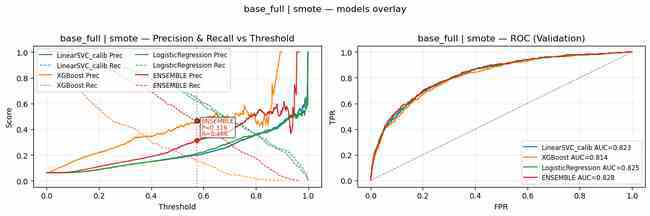


 Dataset: clean_full
Prepared dataset: Train=(55674, 20), Val=(7954, 20), Test=(15907, 20), Features=20, mode=numeric_only
  ◦ Sampling: smote
    Trained LinearSVC_calib: thr=0.723 val_roc=0.832
    Trained XGBoost: thr=0.335 val_roc=0.813
    Trained LogisticRegression: thr=0.715 val_roc=0.835
    MLP failed: build_keras_mlp_5layer not found. Define it or replace with another builder.
    Ensemble(soft): thr=0.556  ValRec₁=0.518  ValPrec₁=0.325  ValROC₁=0.836


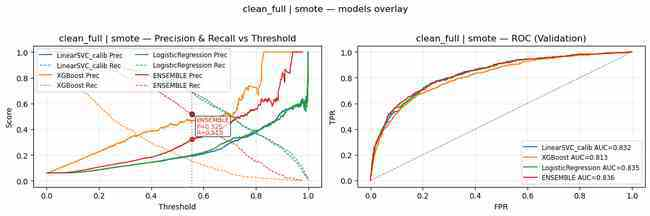


 Dataset: base_reduced
Prepared dataset: Train=(55896, 16), Val=(7986, 16), Test=(15971, 16), Features=16, mode=numeric_only
  ◦ Sampling: smote
    Trained LinearSVC_calib: thr=0.781 val_roc=0.823
    Trained XGBoost: thr=0.320 val_roc=0.815
    Trained LogisticRegression: thr=0.754 val_roc=0.825
    MLP failed: build_keras_mlp_5layer not found. Define it or replace with another builder.
    Ensemble(soft): thr=0.603  ValRec₁=0.426  ValPrec₁=0.330  ValROC₁=0.828


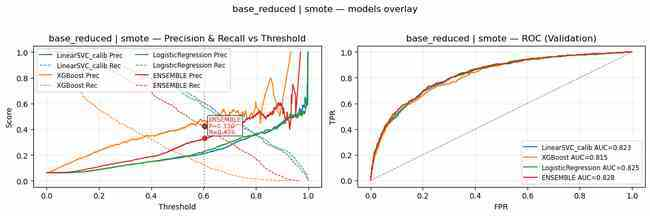


 Dataset: clean_reduced
Prepared dataset: Train=(55674, 16), Val=(7954, 16), Test=(15907, 16), Features=16, mode=numeric_only
  ◦ Sampling: smote
    Trained LinearSVC_calib: thr=0.732 val_roc=0.832
    Trained XGBoost: thr=0.396 val_roc=0.812
    Trained LogisticRegression: thr=0.713 val_roc=0.835
    MLP failed: build_keras_mlp_5layer not found. Define it or replace with another builder.
    Ensemble(soft): thr=0.586  ValRec₁=0.460  ValPrec₁=0.347  ValROC₁=0.835


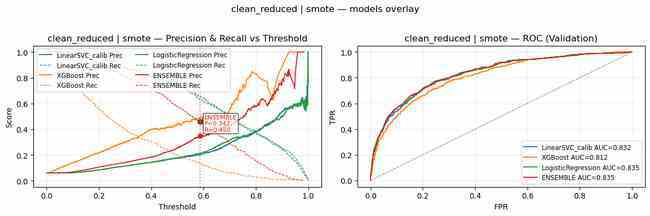


 Dataset: base_reduced_no_cat
Prepared dataset: Train=(55896, 10), Val=(7986, 10), Test=(15971, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    Trained LinearSVC_calib: thr=0.762 val_roc=0.824
    Trained XGBoost: thr=0.373 val_roc=0.817
    Trained LogisticRegression: thr=0.764 val_roc=0.826
    MLP failed: build_keras_mlp_5layer not found. Define it or replace with another builder.
    Ensemble(soft): thr=0.619  ValRec₁=0.422  ValPrec₁=0.336  ValROC₁=0.830


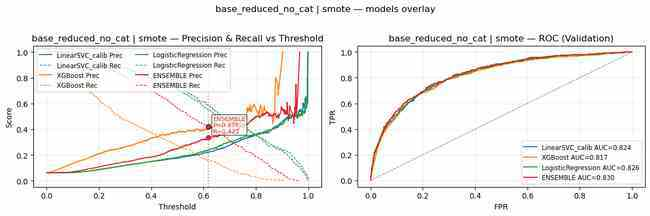


 Dataset: clean_reduced_no_cat
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    Trained LinearSVC_calib: thr=0.726 val_roc=0.832
    Trained XGBoost: thr=0.393 val_roc=0.811
    Trained LogisticRegression: thr=0.710 val_roc=0.834
    MLP failed: build_keras_mlp_5layer not found. Define it or replace with another builder.
    Ensemble(soft): thr=0.583  ValRec₁=0.482  ValPrec₁=0.330  ValROC₁=0.834


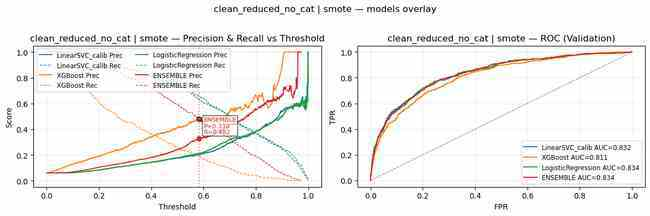


 Dataset: base_reduced_no_cat_raw
Prepared dataset: Train=(55896, 9), Val=(7986, 9), Test=(15971, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    Trained LinearSVC_calib: thr=0.762 val_roc=0.824
    Trained XGBoost: thr=0.364 val_roc=0.817
    Trained LogisticRegression: thr=0.758 val_roc=0.826
    MLP failed: build_keras_mlp_5layer not found. Define it or replace with another builder.
    Ensemble(soft): thr=0.618  ValRec₁=0.442  ValPrec₁=0.331  ValROC₁=0.829


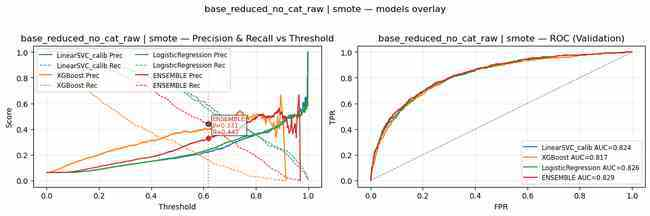


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    Trained LinearSVC_calib: thr=0.727 val_roc=0.832
    Trained XGBoost: thr=0.414 val_roc=0.812
    Trained LogisticRegression: thr=0.723 val_roc=0.834
    MLP failed: build_keras_mlp_5layer not found. Define it or replace with another builder.
    Ensemble(soft): thr=0.568  ValRec₁=0.507  ValPrec₁=0.315  ValROC₁=0.834


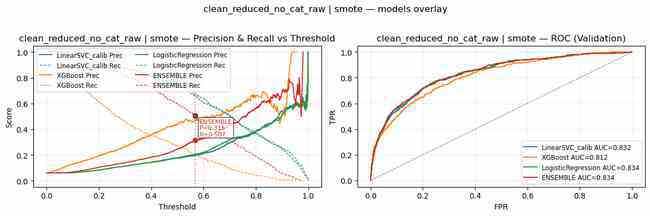


 Dataset: base_topcorr_only
Prepared dataset: Train=(55896, 4), Val=(7986, 4), Test=(15971, 4), Features=4, mode=numeric_only
  ◦ Sampling: smote
    Trained LinearSVC_calib: thr=0.723 val_roc=0.815
    Trained XGBoost: thr=0.803 val_roc=0.801
    Trained LogisticRegression: thr=0.763 val_roc=0.817
    MLP failed: build_keras_mlp_5layer not found. Define it or replace with another builder.
    Ensemble(soft): thr=0.772  ValRec₁=0.384  ValPrec₁=0.356  ValROC₁=0.815


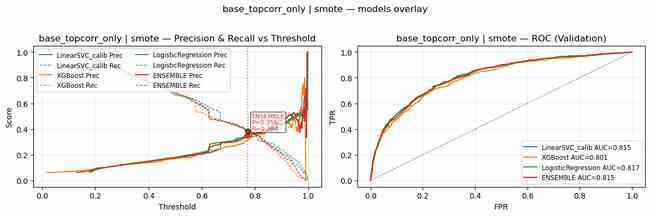


 Dataset: clean_topcorr_only
Prepared dataset: Train=(55674, 4), Val=(7954, 4), Test=(15907, 4), Features=4, mode=numeric_only
  ◦ Sampling: smote
    Trained LinearSVC_calib: thr=0.820 val_roc=0.826
    Trained XGBoost: thr=0.801 val_roc=0.816
    Trained LogisticRegression: thr=0.790 val_roc=0.829
    MLP failed: build_keras_mlp_5layer not found. Define it or replace with another builder.
    Ensemble(soft): thr=0.669  ValRec₁=0.505  ValPrec₁=0.311  ValROC₁=0.829


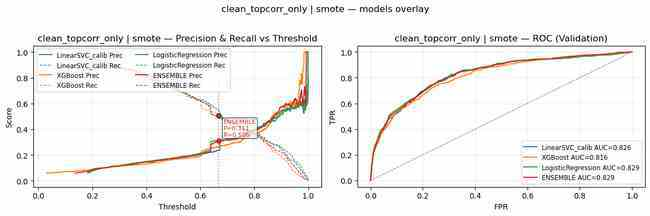


=== Ensemble (soft) Summary ===


dataset           model sampling_method tuning_mode  \
1                clean_full  Ensemble[soft]           smote      max_f1   
7  clean_reduced_no_cat_raw  Ensemble[soft]           smote      max_f1   
9        clean_topcorr_only  Ensemble[soft]           smote      max_f1   
5      clean_reduced_no_cat  Ensemble[soft]           smote      max_f1   
0                 base_full  Ensemble[soft]           smote      max_f1   
3             clean_reduced  Ensemble[soft]           smote      max_f1   
6   base_reduced_no_cat_raw  Ensemble[soft]           smote      max_f1   
2              base_reduced  Ensemble[soft]           smote      max_f1   
4       base_reduced_no_cat  Ensemble[soft]           smote      max_f1   
8         base_topcorr_only  Ensemble[soft]           smote      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
1            0.8          0.5560     0.3247    0.5175    0.3990    0.8360   
7            0.8          0.5678     0.3146    0.5072    0.3883    0.8341   
9            0.8          0.6692     0.3109    0.5052    0.3849    0.8289   
5            0.8          0.5833     0.3296    0.4825    0.3916    0.8337   
0            0.8          0.5746     0.3161    0.4660    0.3767    0.8279   
3            0.8          0.5860     0.3474    0.4598    0.3957    0.8346   
6            0.8          0.6183     0.3313    0.4420    0.3787    0.8290   
2            0.8          0.6026     0.3302    0.4260    0.3721    0.8277   
4            0.8          0.6189     0.3360    0.4220    0.3741    0.8298   
8            0.8          0.7719     0.3556    0.3840    0.3692    0.8148   

   test_prec1  test_rec1  test_f1_1  test_roc1  
1      0.3171     0.5041     0.3893     0.8304  
7      0.3098     0.4928     0.3804     0.8313  
9      0.3083     0.4814     0.3759     0.8212  
5      0.3282     0.4814     0.3903     0.8328  
0      0.3293     0.4590     0.3835     0.8426  
3      0.3346     0.4464     0.3825     0.8314  
6      0.3405     0.4300     0.3800     0.8417  
2      0.3431     0.4220     0.3785     0.8420  
4      0.3481     0.4250     0.3827     0.8431  
8      0.3672     0.3900     0.3783     0.8321

In [247]:
df_voting, store_voting = run_ensemble_pipeline_voting(
    datasets,
    base_models=("svc", "xgb", "logreg", "mlp"),  # choose your base models
    voting_method="soft",      # or "weighted", "hard", "stack"
    tuning_mode="max_f1",      # tune for recall, precision, or F1
    tuning_target=0.8,         # target metric value on validation
    val_size=0.1,
    test_size=0.2,
    sampling_method="smote",   # rebalances only training split
    show_plot=True             # show PR/ROC curves
)


 Dataset: base_full
Prepared dataset: Train=(55896, 20), Val=(7986, 20), Test=(15971, 20), Features=20, mode=numeric_only
  ◦ Sampling: smote
    ➤ Stage 1: xgb
      Stage 1 xgb: thr=0.343  new_pos_val=589  remaining_val=7397
    ➤ Stage 2: svc
      Stage 2 svc: thr=0.076  new_pos_val=1030  remaining_val=6797
    ➤ Stage 3: logreg
      Stage 3 logreg: thr=0.068  new_pos_val=2119  remaining_val=5835
    Serial ensemble final: ValRec₁=0.738 ValPrec₁=0.172 ValROC₁=0.750


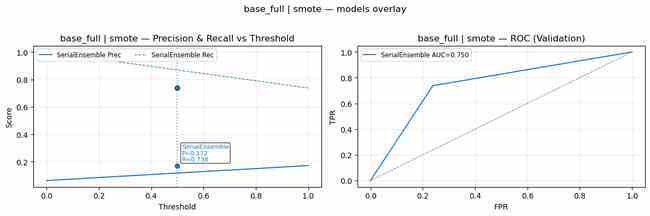


 Dataset: clean_full
Prepared dataset: Train=(55674, 20), Val=(7954, 20), Test=(15907, 20), Features=20, mode=numeric_only
  ◦ Sampling: smote
    ➤ Stage 1: xgb
      Stage 1 xgb: thr=0.335  new_pos_val=530  remaining_val=7424
    ➤ Stage 2: svc
      Stage 2 svc: thr=0.094  new_pos_val=699  remaining_val=7028
    ➤ Stage 3: logreg
      Stage 3 logreg: thr=0.070  new_pos_val=1964  remaining_val=5927
    Serial ensemble final: ValRec₁=0.736 ValPrec₁=0.176 ValROC₁=0.756


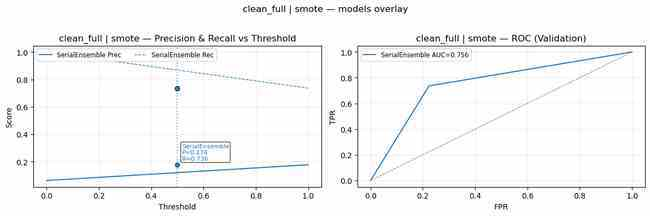


 Dataset: base_reduced
Prepared dataset: Train=(55896, 16), Val=(7986, 16), Test=(15971, 16), Features=16, mode=numeric_only
  ◦ Sampling: smote
    ➤ Stage 1: xgb
      Stage 1 xgb: thr=0.320  new_pos_val=651  remaining_val=7335
    ➤ Stage 2: svc
      Stage 2 svc: thr=0.071  new_pos_val=1366  remaining_val=6514
    ➤ Stage 3: logreg
      Stage 3 logreg: thr=0.075  new_pos_val=2044  remaining_val=5903
    Serial ensemble final: ValRec₁=0.736 ValPrec₁=0.177 ValROC₁=0.753


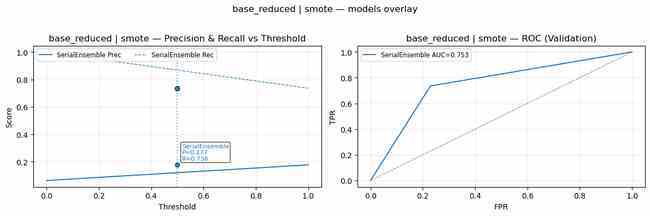


 Dataset: clean_reduced
Prepared dataset: Train=(55674, 16), Val=(7954, 16), Test=(15907, 16), Features=16, mode=numeric_only
  ◦ Sampling: smote
    ➤ Stage 1: xgb
      Stage 1 xgb: thr=0.396  new_pos_val=377  remaining_val=7577
    ➤ Stage 2: svc
      Stage 2 svc: thr=0.118  new_pos_val=712  remaining_val=7111
    ➤ Stage 3: logreg
      Stage 3 logreg: thr=0.101  new_pos_val=1641  remaining_val=6283
    Serial ensemble final: ValRec₁=0.685 ValPrec₁=0.199 ValROC₁=0.753


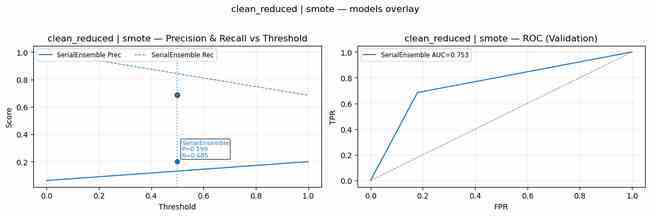


 Dataset: base_reduced_no_cat
Prepared dataset: Train=(55896, 10), Val=(7986, 10), Test=(15971, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    ➤ Stage 1: xgb
      Stage 1 xgb: thr=0.373  new_pos_val=649  remaining_val=7337
    ➤ Stage 2: svc
      Stage 2 svc: thr=0.082  new_pos_val=1063  remaining_val=6763
    ➤ Stage 3: logreg
      Stage 3 logreg: thr=0.082  new_pos_val=1755  remaining_val=6189
    Serial ensemble final: ValRec₁=0.698 ValPrec₁=0.194 ValROC₁=0.752


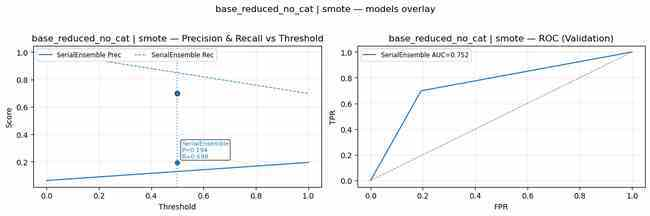


 Dataset: clean_reduced_no_cat
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    ➤ Stage 1: xgb
      Stage 1 xgb: thr=0.393  new_pos_val=539  remaining_val=7415
    ➤ Stage 2: svc
      Stage 2 svc: thr=0.090  new_pos_val=1360  remaining_val=6516
    ➤ Stage 3: logreg
      Stage 3 logreg: thr=0.101  new_pos_val=1750  remaining_val=6170
    Serial ensemble final: ValRec₁=0.713 ValPrec₁=0.194 ValROC₁=0.760


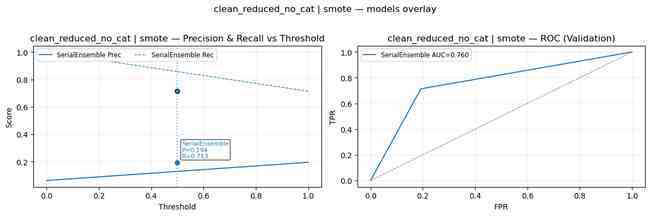


 Dataset: base_reduced_no_cat_raw
Prepared dataset: Train=(55896, 9), Val=(7986, 9), Test=(15971, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    ➤ Stage 1: xgb
      Stage 1 xgb: thr=0.364  new_pos_val=705  remaining_val=7281
    ➤ Stage 2: svc
      Stage 2 svc: thr=0.079  new_pos_val=1570  remaining_val=6329
    ➤ Stage 3: logreg
      Stage 3 logreg: thr=0.082  new_pos_val=2072  remaining_val=5887
    Serial ensemble final: ValRec₁=0.736 ValPrec₁=0.175 ValROC₁=0.752


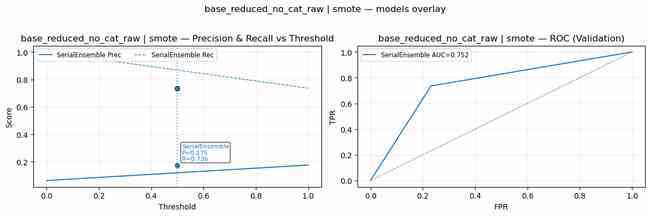


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    ➤ Stage 1: xgb
      Stage 1 xgb: thr=0.414  new_pos_val=450  remaining_val=7504
    ➤ Stage 2: svc
      Stage 2 svc: thr=0.094  new_pos_val=1625  remaining_val=6301
    ➤ Stage 3: logreg
      Stage 3 logreg: thr=0.122  new_pos_val=1650  remaining_val=6163
    Serial ensemble final: ValRec₁=0.713 ValPrec₁=0.193 ValROC₁=0.760


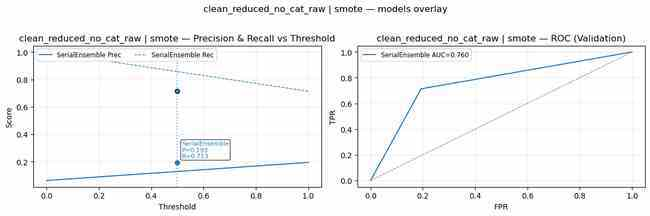


 Dataset: base_topcorr_only
Prepared dataset: Train=(55896, 4), Val=(7986, 4), Test=(15971, 4), Features=4, mode=numeric_only
  ◦ Sampling: smote
    ➤ Stage 1: xgb
      Stage 1 xgb: thr=0.803  new_pos_val=518  remaining_val=7468
    ➤ Stage 2: svc
      Stage 2 svc: thr=0.558  new_pos_val=1506  remaining_val=6454
    ➤ Stage 3: logreg
      Stage 3 logreg: thr=0.449  new_pos_val=2396  remaining_val=5590
    Serial ensemble final: ValRec₁=0.758 ValPrec₁=0.158 ValROC₁=0.744


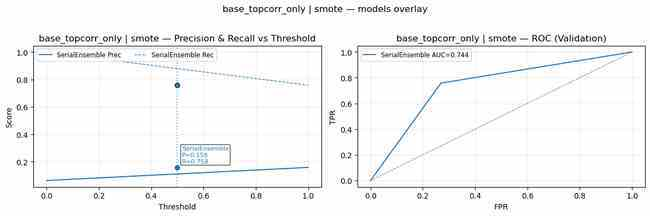


 Dataset: clean_topcorr_only
Prepared dataset: Train=(55674, 4), Val=(7954, 4), Test=(15907, 4), Features=4, mode=numeric_only
  ◦ Sampling: smote
    ➤ Stage 1: xgb
      Stage 1 xgb: thr=0.801  new_pos_val=471  remaining_val=7483
    ➤ Stage 2: svc
      Stage 2 svc: thr=0.674  new_pos_val=719  remaining_val=7192
    ➤ Stage 3: logreg
      Stage 3 logreg: thr=0.503  new_pos_val=2082  remaining_val=5872
    Serial ensemble final: ValRec₁=0.748 ValPrec₁=0.174 ValROC₁=0.759


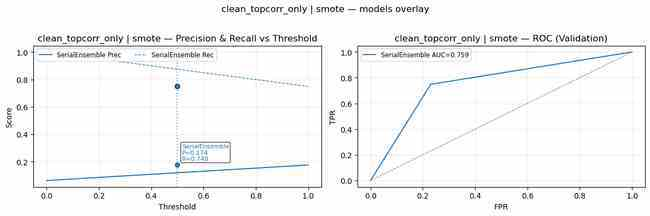


=== Serial Ensemble Summary ===


dataset           model sampling_method tuning_mode  \
8         base_topcorr_only  SerialEnsemble           smote      max_f1   
9        clean_topcorr_only  SerialEnsemble           smote      max_f1   
0                 base_full  SerialEnsemble           smote      max_f1   
1                clean_full  SerialEnsemble           smote      max_f1   
2              base_reduced  SerialEnsemble           smote      max_f1   
6   base_reduced_no_cat_raw  SerialEnsemble           smote      max_f1   
5      clean_reduced_no_cat  SerialEnsemble           smote      max_f1   
7  clean_reduced_no_cat_raw  SerialEnsemble           smote      max_f1   
4       base_reduced_no_cat  SerialEnsemble           smote      max_f1   
3             clean_reduced  SerialEnsemble           smote      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
8           0.85             0.5     0.1582    0.7580    0.2617    0.7443   
9           0.85             0.5     0.1744    0.7485    0.2828    0.7592   
0           0.85             0.5     0.1715    0.7380    0.2784    0.7500   
1           0.85             0.5     0.1761    0.7361    0.2842    0.7562   
2           0.85             0.5     0.1767    0.7360    0.2849    0.7535   
6           0.85             0.5     0.1753    0.7360    0.2832    0.7524   
5           0.85             0.5     0.1939    0.7134    0.3050    0.7604   
7           0.85             0.5     0.1932    0.7134    0.3040    0.7600   
4           0.85             0.5     0.1942    0.6980    0.3039    0.7523   
3           0.85             0.5     0.1987    0.6845    0.3080    0.7526   

   test_prec1  test_rec1  test_f1_1  test_roc1  
8      0.1628     0.7890     0.2699     0.7590  
9      0.1768     0.7289     0.2846     0.7543  
0      0.1773     0.7550     0.2872     0.7605  
1      0.1738     0.7103     0.2792     0.7455  
2      0.1809     0.7430     0.2909     0.7591  
6      0.1797     0.7480     0.2898     0.7599  
5      0.1964     0.7010     0.3068     0.7574  
7      0.1961     0.7021     0.3065     0.7576  
4      0.2014     0.7070     0.3135     0.7599  
3      0.2007     0.6784     0.3097     0.7514

In [248]:
df_serial, store_serial = run_ensemble_serial_pipeline(
    datasets,
    base_order=("xgb", "svc", "logreg"),  # order of model execution
    tuning_mode="max_f1",     # tune recall thresholds at each stage
    tuning_target=0.85,
    val_size=0.1,
    test_size=0.2,
    sampling_method="smote",  # optional rebalancing for each stage
    show_plot=True
)


 Dataset: base_full
Prepared dataset: Train=(55896, 20), Val=(7986, 20), Test=(15971, 20), Features=20, mode=numeric_only
  ◦ Sampling: builtin
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
    KerasMLP: thr=0.714  ValRec₁=0.436  ValPrec₁=0.352  ValROC₁=0.830


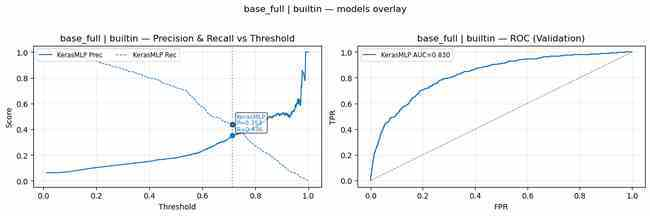


 Dataset: clean_full
Prepared dataset: Train=(55674, 20), Val=(7954, 20), Test=(15907, 20), Features=20, mode=numeric_only
  ◦ Sampling: builtin
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
    KerasMLP: thr=0.726  ValRec₁=0.427  ValPrec₁=0.387  ValROC₁=0.840


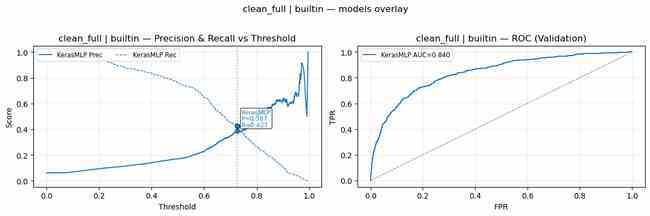


 Dataset: base_reduced
Prepared dataset: Train=(55896, 16), Val=(7986, 16), Test=(15971, 16), Features=16, mode=numeric_only
  ◦ Sampling: builtin
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step
    KerasMLP: thr=0.730  ValRec₁=0.434  ValPrec₁=0.340  ValROC₁=0.830


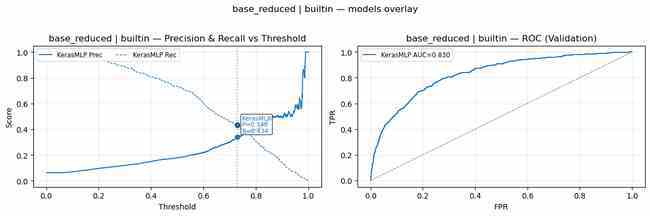


 Dataset: clean_reduced
Prepared dataset: Train=(55674, 16), Val=(7954, 16), Test=(15907, 16), Features=16, mode=numeric_only
  ◦ Sampling: builtin
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
    KerasMLP: thr=0.738  ValRec₁=0.427  ValPrec₁=0.388  ValROC₁=0.839


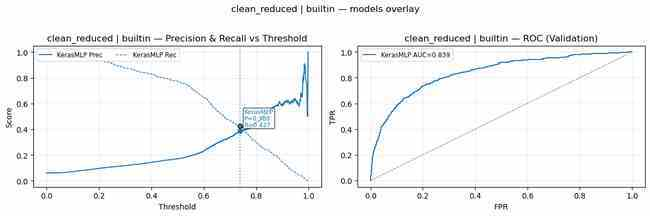


 Dataset: base_reduced_no_cat
Prepared dataset: Train=(55896, 10), Val=(7986, 10), Test=(15971, 10), Features=10, mode=numeric_only
  ◦ Sampling: builtin
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step
    KerasMLP: thr=0.745  ValRec₁=0.404  ValPrec₁=0.367  ValROC₁=0.831


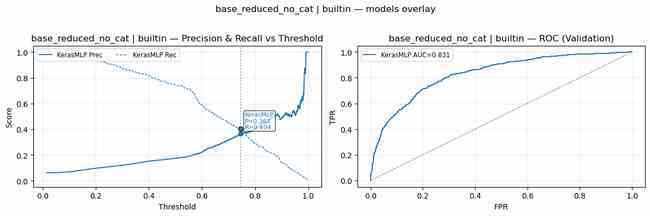


 Dataset: clean_reduced_no_cat
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: builtin
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step
    KerasMLP: thr=0.678  ValRec₁=0.482  ValPrec₁=0.341  ValROC₁=0.840


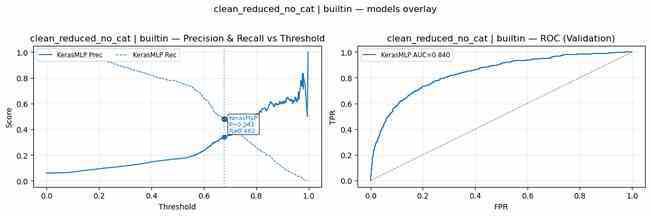


 Dataset: base_reduced_no_cat_raw
Prepared dataset: Train=(55896, 9), Val=(7986, 9), Test=(15971, 9), Features=9, mode=numeric_only
  ◦ Sampling: builtin
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
    KerasMLP: thr=0.704  ValRec₁=0.440  ValPrec₁=0.342  ValROC₁=0.829


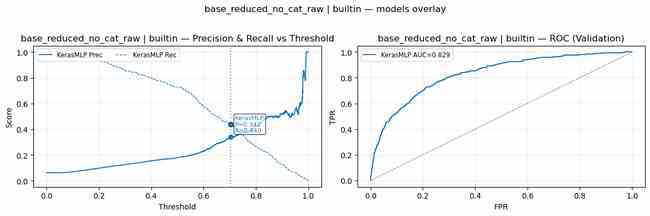


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: builtin
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
    KerasMLP: thr=0.580  ValRec₁=0.449  ValPrec₁=0.356  ValROC₁=0.833


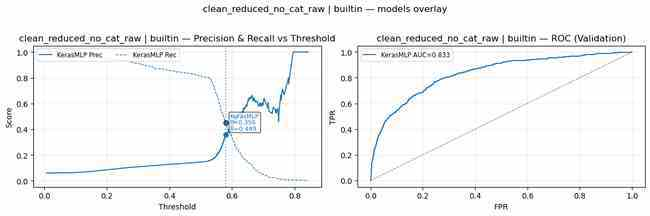


 Dataset: base_topcorr_only
Prepared dataset: Train=(55896, 4), Val=(7986, 4), Test=(15971, 4), Features=4, mode=numeric_only
  ◦ Sampling: builtin
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
    KerasMLP: thr=0.723  ValRec₁=0.412  ValPrec₁=0.350  ValROC₁=0.817


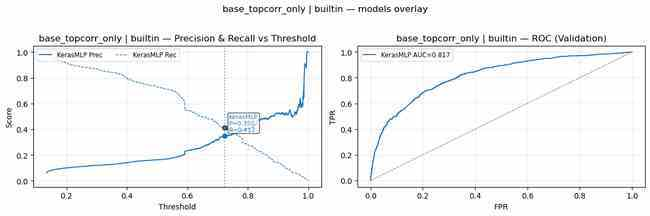


 Dataset: clean_topcorr_only
Prepared dataset: Train=(55674, 4), Val=(7954, 4), Test=(15907, 4), Features=4, mode=numeric_only
  ◦ Sampling: builtin
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
    KerasMLP: thr=0.704  ValRec₁=0.445  ValPrec₁=0.358  ValROC₁=0.831


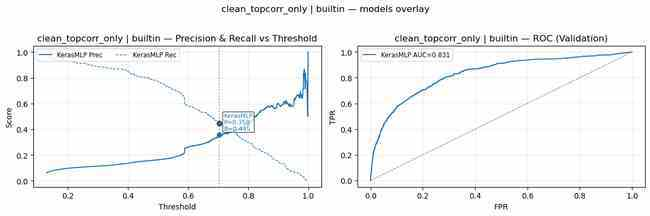


=== Keras MLP (max_f1=0.8) Summary ===


dataset     model sampling_method tuning_mode  \
5      clean_reduced_no_cat  KerasMLP         builtin      max_f1   
7  clean_reduced_no_cat_raw  KerasMLP         builtin      max_f1   
9        clean_topcorr_only  KerasMLP         builtin      max_f1   
6   base_reduced_no_cat_raw  KerasMLP         builtin      max_f1   
0                 base_full  KerasMLP         builtin      max_f1   
2              base_reduced  KerasMLP         builtin      max_f1   
1                clean_full  KerasMLP         builtin      max_f1   
3             clean_reduced  KerasMLP         builtin      max_f1   
8         base_topcorr_only  KerasMLP         builtin      max_f1   
4       base_reduced_no_cat  KerasMLP         builtin      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
5            0.8          0.6785     0.3411    0.4825    0.3997    0.8396   
7            0.8          0.5799     0.3562    0.4495    0.3974    0.8327   
9            0.8          0.7044     0.3582    0.4454    0.3971    0.8312   
6            0.8          0.7039     0.3416    0.4400    0.3846    0.8292   
0            0.8          0.7137     0.3522    0.4360    0.3896    0.8302   
2            0.8          0.7303     0.3401    0.4340    0.3814    0.8301   
1            0.8          0.7256     0.3869    0.4268    0.4059    0.8395   
3            0.8          0.7379     0.3876    0.4268    0.4063    0.8389   
8            0.8          0.7234     0.3497    0.4120    0.3783    0.8171   
4            0.8          0.7452     0.3673    0.4040    0.3848    0.8307   

   test_prec1  test_rec1  test_f1_1  test_roc1  
5      0.3280     0.4629     0.3839     0.8348  
7      0.3353     0.4072     0.3678     0.8295  
9      0.3428     0.4216     0.3782     0.8231  
6      0.3462     0.4380     0.3868     0.8453  
0      0.3536     0.4250     0.3860     0.8460  
2      0.3491     0.4360     0.3877     0.8455  
1      0.3620     0.3948     0.3777     0.8347  
3      0.3608     0.3928     0.3761     0.8341  
8      0.3578     0.4150     0.3843     0.8341  
4      0.3757     0.4020     0.3884     0.8474

In [249]:
df_keras, keras_store = run_nn_pipeline_keras(
    datasets,
    sampling_method="builtin",   # or "smote"
    tuning_mode="max_f1",
    tuning_target=0.8,
    hidden_units=(256,128,64,32,16),
    dropout=0.2,
    lr=5e-4,
    batch_size=1024,
    epochs=50,
    show_plot=True,
    verbose=0
)


 Dataset: base_full
Prepared dataset: Train=(55896, 20), Val=(7986, 20), Test=(15971, 20), Features=20, mode=numeric_only
  ◦ Sampling: builtin


python(41939) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41940) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41941) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41942) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41943) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41944) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41945) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41946) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41947) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(41948) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


    SVM: thr=0.121  ValRec₁=0.424  ValPrec₁=0.345  ValROC₁=0.826


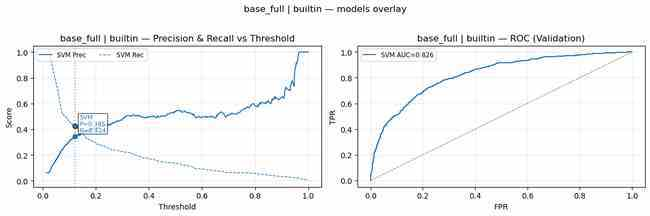


 Dataset: clean_full
Prepared dataset: Train=(55674, 20), Val=(7954, 20), Test=(15907, 20), Features=20, mode=numeric_only
  ◦ Sampling: builtin
    SVM: thr=0.126  ValRec₁=0.433  ValPrec₁=0.384  ValROC₁=0.838


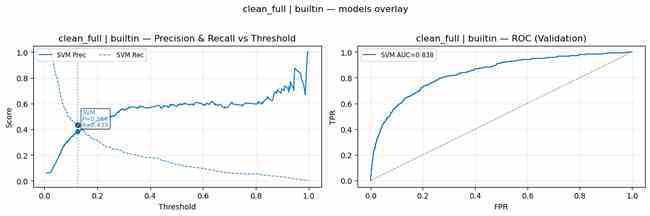


 Dataset: base_reduced
Prepared dataset: Train=(55896, 16), Val=(7986, 16), Test=(15971, 16), Features=16, mode=numeric_only
  ◦ Sampling: builtin
    SVM: thr=0.122  ValRec₁=0.420  ValPrec₁=0.347  ValROC₁=0.826


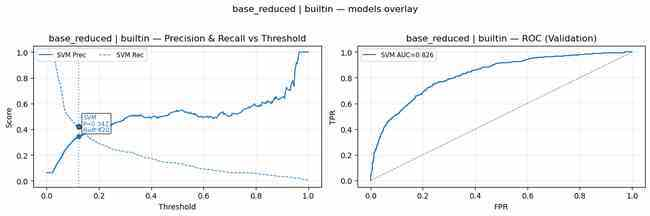


 Dataset: clean_reduced
Prepared dataset: Train=(55674, 16), Val=(7954, 16), Test=(15907, 16), Features=16, mode=numeric_only
  ◦ Sampling: builtin
    SVM: thr=0.128  ValRec₁=0.433  ValPrec₁=0.388  ValROC₁=0.838


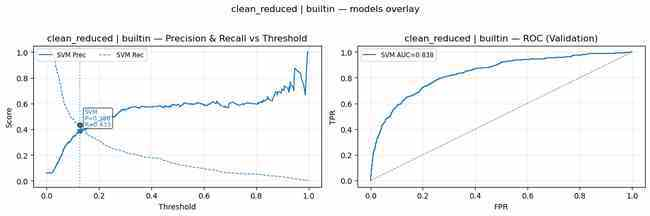


 Dataset: base_reduced_no_cat
Prepared dataset: Train=(55896, 10), Val=(7986, 10), Test=(15971, 10), Features=10, mode=numeric_only
  ◦ Sampling: builtin
    SVM: thr=0.127  ValRec₁=0.416  ValPrec₁=0.353  ValROC₁=0.826


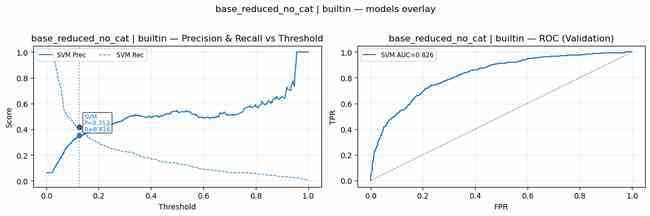


 Dataset: clean_reduced_no_cat
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: builtin
    SVM: thr=0.125  ValRec₁=0.435  ValPrec₁=0.383  ValROC₁=0.838


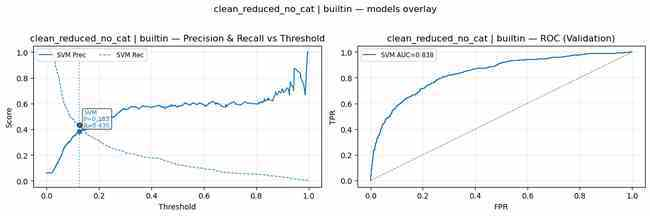


 Dataset: base_reduced_no_cat_raw
Prepared dataset: Train=(55896, 9), Val=(7986, 9), Test=(15971, 9), Features=9, mode=numeric_only
  ◦ Sampling: builtin
    SVM: thr=0.131  ValRec₁=0.410  ValPrec₁=0.357  ValROC₁=0.826


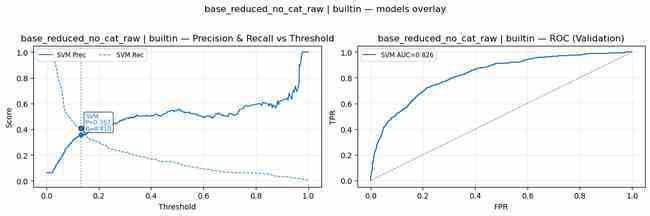


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: builtin
    SVM: thr=0.117  ValRec₁=0.449  ValPrec₁=0.369  ValROC₁=0.837


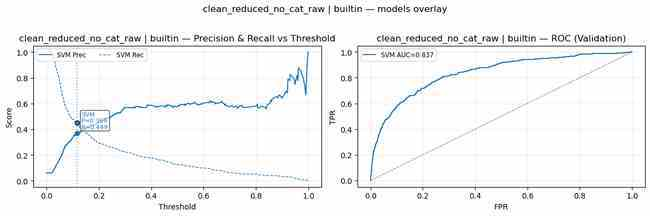


 Dataset: base_topcorr_only
Prepared dataset: Train=(55896, 4), Val=(7986, 4), Test=(15971, 4), Features=4, mode=numeric_only
  ◦ Sampling: builtin
    SVM: thr=0.113  ValRec₁=0.428  ValPrec₁=0.340  ValROC₁=0.817


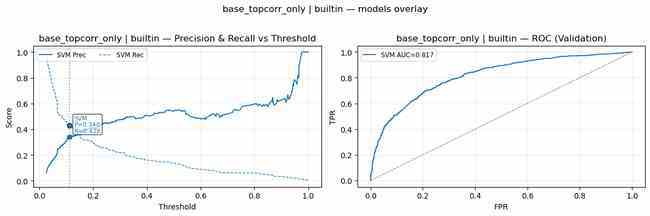


 Dataset: clean_topcorr_only
Prepared dataset: Train=(55674, 4), Val=(7954, 4), Test=(15907, 4), Features=4, mode=numeric_only
  ◦ Sampling: builtin
    SVM: thr=0.122  ValRec₁=0.433  ValPrec₁=0.378  ValROC₁=0.831


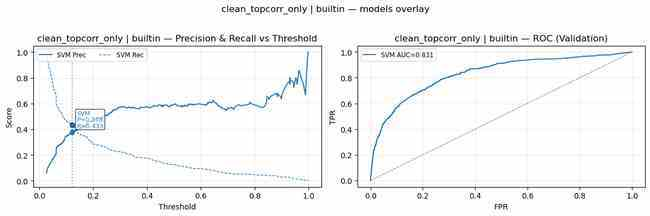


=== SVM (max_f1=0.8) Summary ===


dataset model sampling_method tuning_mode  tuning_target  \
7  clean_reduced_no_cat_raw   SVM         builtin      max_f1            0.8   
5      clean_reduced_no_cat   SVM         builtin      max_f1            0.8   
1                clean_full   SVM         builtin      max_f1            0.8   
3             clean_reduced   SVM         builtin      max_f1            0.8   
9        clean_topcorr_only   SVM         builtin      max_f1            0.8   
8         base_topcorr_only   SVM         builtin      max_f1            0.8   
0                 base_full   SVM         builtin      max_f1            0.8   
2              base_reduced   SVM         builtin      max_f1            0.8   
4       base_reduced_no_cat   SVM         builtin      max_f1            0.8   
6   base_reduced_no_cat_raw   SVM         builtin      max_f1            0.8   

   threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  test_prec1  \
7          0.1167     0.3695    0.4495    0.4056    0.8374      0.3483   
5          0.1249     0.3829    0.4351    0.4073    0.8376      0.3560   
1          0.1255     0.3839    0.4330    0.4070    0.8383      0.3580   
3          0.1277     0.3882    0.4330    0.4094    0.8379      0.3613   
9          0.1224     0.3784    0.4330    0.4038    0.8312      0.3534   
8          0.1126     0.3402    0.4280    0.3791    0.8170      0.3467   
0          0.1212     0.3453    0.4240    0.3806    0.8261      0.3551   
2          0.1221     0.3465    0.4200    0.3797    0.8263      0.3587   
4          0.1267     0.3531    0.4160    0.3820    0.8264      0.3623   
6          0.1309     0.3565    0.4100    0.3814    0.8260      0.3686   

   test_rec1  test_f1_1  test_roc1  
7     0.4237     0.3823     0.8317  
5     0.4041     0.3786     0.8321  
1     0.4041     0.3797     0.8314  
3     0.3990     0.3792     0.8320  
9     0.4062     0.3779     0.8232  
8     0.4320     0.3847     0.8339  
0     0.4240     0.3865     0.8433  
2     0.4240     0.3886     0.8430  
4     0.4170     0.3877     0.8438  
6     0.4150     0.3904     0.8430

In [250]:
df_svm, svm_store = run_svm_pipeline_tuned(
    datasets,
    sampling_method="builtin",
    tuning_mode="max_f1",
    tuning_target=0.8,
    search_type="grid",   # optional
    use_kernel_if_small=False,  # recommended for your large datasets
    show_plot=True
)


 Dataset: base_full
Prepared dataset: Train=(55896, 20), Val=(7986, 20), Test=(15971, 20), Features=20, mode=numeric_only
  ◦ Sampling: builtin
     XGB: thr=0.766  ValPrec₁=0.353  ValRec₁=0.356  AUC=0.818


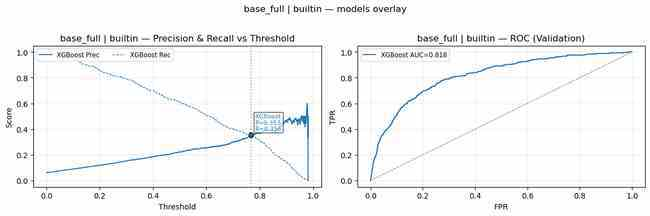


 Dataset: clean_full
Prepared dataset: Train=(55674, 20), Val=(7954, 20), Test=(15907, 20), Features=20, mode=numeric_only
  ◦ Sampling: builtin
     XGB: thr=0.647  ValPrec₁=0.289  ValRec₁=0.478  AUC=0.818


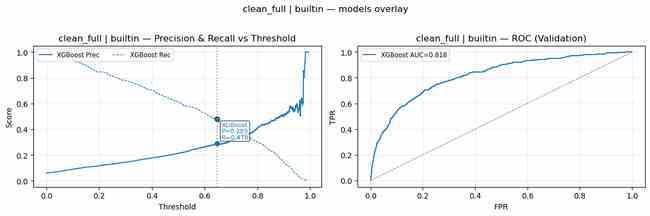


 Dataset: base_reduced
Prepared dataset: Train=(55896, 16), Val=(7986, 16), Test=(15971, 16), Features=16, mode=numeric_only
  ◦ Sampling: builtin
     XGB: thr=0.639  ValPrec₁=0.278  ValRec₁=0.504  AUC=0.816


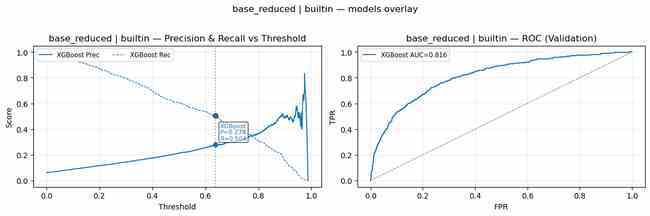


 Dataset: clean_reduced
Prepared dataset: Train=(55674, 16), Val=(7954, 16), Test=(15907, 16), Features=16, mode=numeric_only
  ◦ Sampling: builtin
     XGB: thr=0.698  ValPrec₁=0.312  ValRec₁=0.433  AUC=0.817


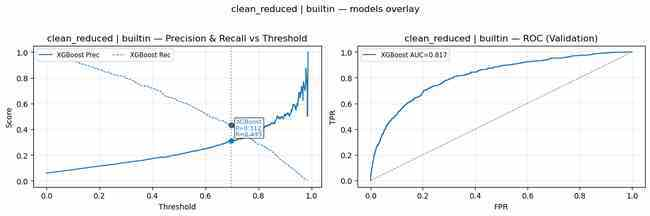


 Dataset: base_reduced_no_cat
Prepared dataset: Train=(55896, 10), Val=(7986, 10), Test=(15971, 10), Features=10, mode=numeric_only
  ◦ Sampling: builtin
     XGB: thr=0.666  ValPrec₁=0.282  ValRec₁=0.480  AUC=0.815


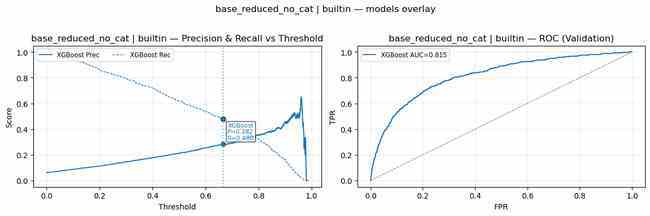


 Dataset: clean_reduced_no_cat
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: builtin
     XGB: thr=0.717  ValPrec₁=0.321  ValRec₁=0.421  AUC=0.820


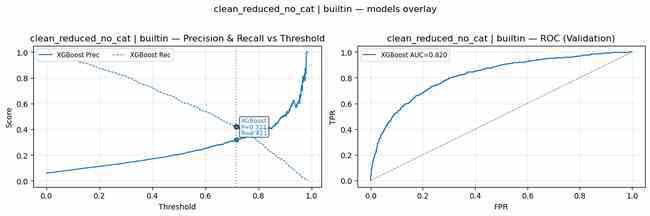


 Dataset: base_reduced_no_cat_raw
Prepared dataset: Train=(55896, 9), Val=(7986, 9), Test=(15971, 9), Features=9, mode=numeric_only
  ◦ Sampling: builtin
     XGB: thr=0.760  ValPrec₁=0.342  ValRec₁=0.378  AUC=0.815


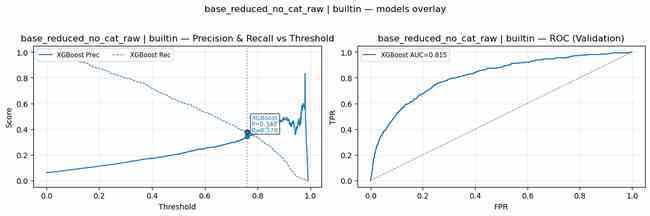


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: builtin
     XGB: thr=0.693  ValPrec₁=0.322  ValRec₁=0.464  AUC=0.824


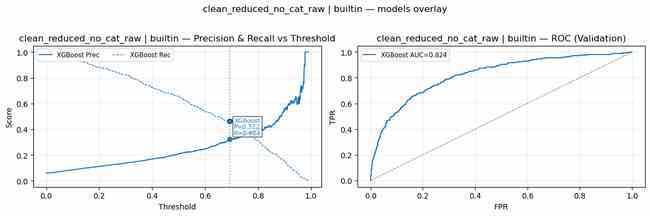


 Dataset: base_topcorr_only
Prepared dataset: Train=(55896, 4), Val=(7986, 4), Test=(15971, 4), Features=4, mode=numeric_only
  ◦ Sampling: builtin
     XGB: thr=0.743  ValPrec₁=0.297  ValRec₁=0.422  AUC=0.797


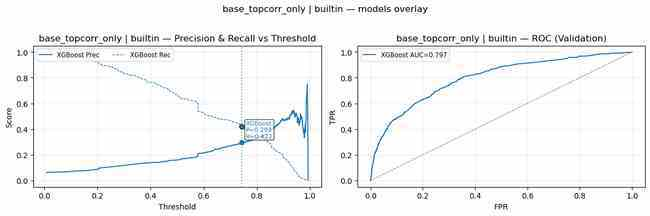


 Dataset: clean_topcorr_only
Prepared dataset: Train=(55674, 4), Val=(7954, 4), Test=(15907, 4), Features=4, mode=numeric_only
  ◦ Sampling: builtin
     XGB: thr=0.759  ValPrec₁=0.325  ValRec₁=0.410  AUC=0.818


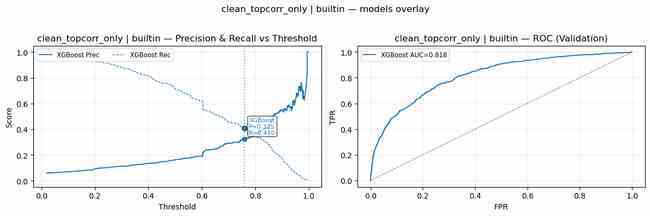


=== XGBoost (max_f1=0.8) Summary ===


dataset    model sampling_method tuning_mode  \
2              base_reduced  XGBoost         builtin      max_f1   
4       base_reduced_no_cat  XGBoost         builtin      max_f1   
1                clean_full  XGBoost         builtin      max_f1   
7  clean_reduced_no_cat_raw  XGBoost         builtin      max_f1   
3             clean_reduced  XGBoost         builtin      max_f1   
8         base_topcorr_only  XGBoost         builtin      max_f1   
5      clean_reduced_no_cat  XGBoost         builtin      max_f1   
9        clean_topcorr_only  XGBoost         builtin      max_f1   
6   base_reduced_no_cat_raw  XGBoost         builtin      max_f1   
0                 base_full  XGBoost         builtin      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
2            0.8          0.6387     0.2781    0.5040    0.3585    0.8159   
4            0.8          0.6658     0.2824    0.4800    0.3556    0.8148   
1            0.8          0.6469     0.2886    0.4784    0.3600    0.8184   
7            0.8          0.6927     0.3223    0.4639    0.3804    0.8238   
3            0.8          0.6977     0.3120    0.4330    0.3627    0.8169   
8            0.8          0.7426     0.2972    0.4220    0.3488    0.7975   
5            0.8          0.7166     0.3208    0.4206    0.3640    0.8201   
9            0.8          0.7592     0.3252    0.4103    0.3628    0.8183   
6            0.8          0.7604     0.3424    0.3780    0.3593    0.8149   
0            0.8          0.7662     0.3532    0.3560    0.3546    0.8185   

   test_prec1  test_rec1  test_f1_1  test_roc1  
2      0.2892     0.4920     0.3643     0.8285  
4      0.3023     0.4800     0.3709     0.8267  
1      0.2834     0.4680     0.3530     0.8169  
7      0.3072     0.4443     0.3633     0.8146  
3      0.3064     0.4258     0.3563     0.8150  
8      0.3129     0.4380     0.3650     0.8235  
5      0.3182     0.4052     0.3565     0.8174  
9      0.3292     0.4103     0.3653     0.8103  
6      0.3515     0.3800     0.3652     0.8271  
0      0.3645     0.3660     0.3653     0.8260

In [251]:
df_xgb, xgb_store = run_xgb_pipeline_tuned(
    datasets,
    sampling_method="builtin"   #  internal scale_pos_weight
    , tuning_mode="max_f1"
)


 Dataset: base_full
Prepared dataset: Train=(55896, 20), Val=(7986, 20), Test=(15971, 20), Features=20, mode=numeric_only
  ◦ Sampling: smote
    ➤ Degree 1
      deg=1: thr=0.757  ValRec₁=0.424  ValPrec₁=0.345
    ➤ Degree 2


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

      deg=2: thr=0.574  ValRec₁=0.496  ValPrec₁=0.274


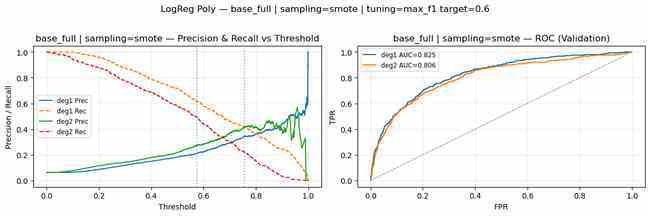


 Dataset: clean_full
Prepared dataset: Train=(55674, 20), Val=(7954, 20), Test=(15907, 20), Features=20, mode=numeric_only
  ◦ Sampling: smote
    ➤ Degree 1


python(42133) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


      deg=1: thr=0.715  ValRec₁=0.499  ValPrec₁=0.334
    ➤ Degree 2


python(42140) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver 

      deg=2: thr=0.647  ValRec₁=0.367  ValPrec₁=0.341


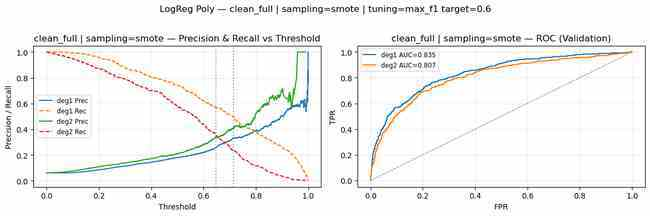


 Dataset: base_reduced
Prepared dataset: Train=(55896, 16), Val=(7986, 16), Test=(15971, 16), Features=16, mode=numeric_only
  ◦ Sampling: smote
    ➤ Degree 1


python(42189) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


      deg=1: thr=0.754  ValRec₁=0.426  ValPrec₁=0.342
    ➤ Degree 2


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

      deg=2: thr=0.626  ValRec₁=0.482  ValPrec₁=0.279


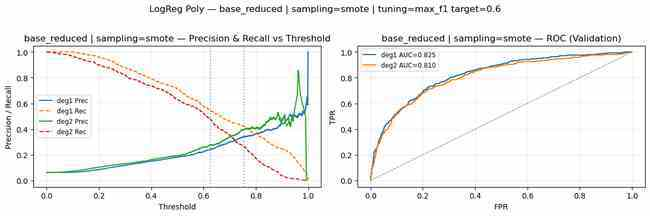


 Dataset: clean_reduced
Prepared dataset: Train=(55674, 16), Val=(7954, 16), Test=(15907, 16), Features=16, mode=numeric_only
  ◦ Sampling: smote
    ➤ Degree 1


python(42223) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(42224) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


      deg=1: thr=0.713  ValRec₁=0.491  ValPrec₁=0.331
    ➤ Degree 2


python(42234) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver 

      deg=2: thr=0.697  ValRec₁=0.361  ValPrec₁=0.379


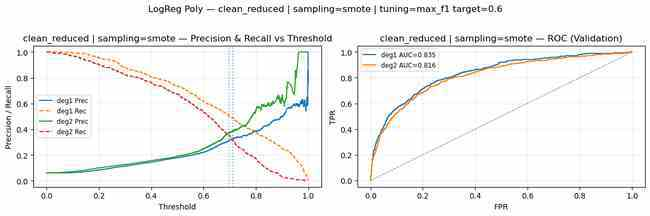


 Dataset: base_reduced_no_cat
Prepared dataset: Train=(55896, 10), Val=(7986, 10), Test=(15971, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    ➤ Degree 1


python(42260) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(42261) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(42262) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


      deg=1: thr=0.764  ValRec₁=0.418  ValPrec₁=0.352
    ➤ Degree 2


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


      deg=2: thr=0.776  ValRec₁=0.406  ValPrec₁=0.361


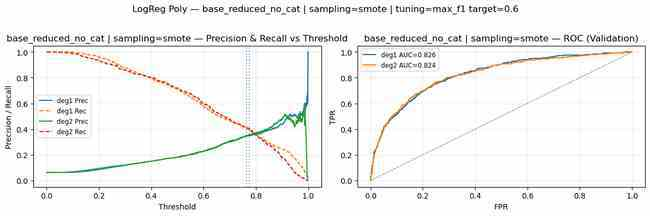


 Dataset: clean_reduced_no_cat
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    ➤ Degree 1
      deg=1: thr=0.710  ValRec₁=0.493  ValPrec₁=0.329
    ➤ Degree 2
      deg=2: thr=0.777  ValRec₁=0.429  ValPrec₁=0.398


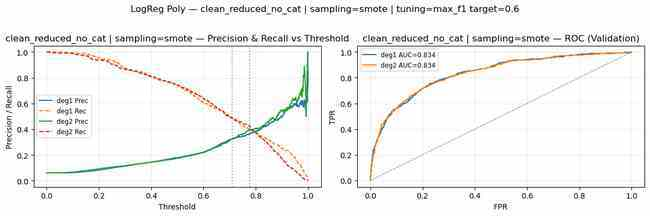


 Dataset: base_reduced_no_cat_raw
Prepared dataset: Train=(55896, 9), Val=(7986, 9), Test=(15971, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    ➤ Degree 1
      deg=1: thr=0.754  ValRec₁=0.420  ValPrec₁=0.343
    ➤ Degree 2
      deg=2: thr=0.762  ValRec₁=0.442  ValPrec₁=0.334


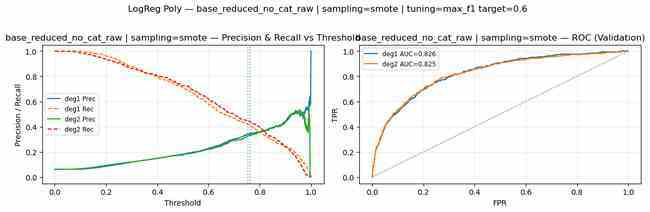


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    ➤ Degree 1
      deg=1: thr=0.723  ValRec₁=0.472  ValPrec₁=0.337
    ➤ Degree 2
      deg=2: thr=0.794  ValRec₁=0.427  ValPrec₁=0.394


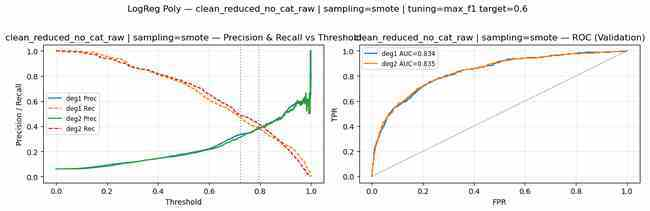


 Dataset: base_topcorr_only
Prepared dataset: Train=(55896, 4), Val=(7986, 4), Test=(15971, 4), Features=4, mode=numeric_only
  ◦ Sampling: smote
    ➤ Degree 1
      deg=1: thr=0.764  ValRec₁=0.396  ValPrec₁=0.361
    ➤ Degree 2
      deg=2: thr=0.769  ValRec₁=0.420  ValPrec₁=0.343


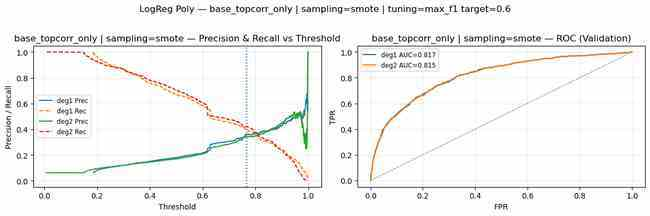


 Dataset: clean_topcorr_only
Prepared dataset: Train=(55674, 4), Val=(7954, 4), Test=(15907, 4), Features=4, mode=numeric_only
  ◦ Sampling: smote
    ➤ Degree 1
      deg=1: thr=0.790  ValRec₁=0.390  ValPrec₁=0.393
    ➤ Degree 2
      deg=2: thr=0.792  ValRec₁=0.427  ValPrec₁=0.381


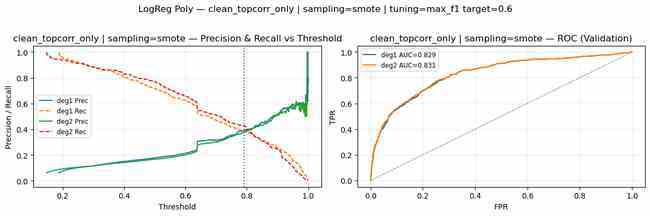


=== Logistic Regression Poly (max_f1=0.6) Summary ===


dataset                   model sampling_method  degree  \
2                 clean_full  LogisticRegressionPoly           smote       1   
1                  base_full  LogisticRegressionPoly           smote       2   
10      clean_reduced_no_cat  LogisticRegressionPoly           smote       1   
6              clean_reduced  LogisticRegressionPoly           smote       1   
5               base_reduced  LogisticRegressionPoly           smote       2   
14  clean_reduced_no_cat_raw  LogisticRegressionPoly           smote       1   
13   base_reduced_no_cat_raw  LogisticRegressionPoly           smote       2   
11      clean_reduced_no_cat  LogisticRegressionPoly           smote       2   
15  clean_reduced_no_cat_raw  LogisticRegressionPoly           smote       2   
19        clean_topcorr_only  LogisticRegressionPoly           smote       2   
4               base_reduced  LogisticRegressionPoly           smote       1   
0                  base_full  LogisticRegressionPoly           smote       1   
12   base_reduced_no_cat_raw  LogisticRegressionPoly           smote       1   
17         base_topcorr_only  LogisticRegressionPoly           smote       2   
8        base_reduced_no_cat  LogisticRegressionPoly           smote       1   
9        base_reduced_no_cat  LogisticRegressionPoly           smote       2   
16         base_topcorr_only  LogisticRegressionPoly           smote       1   
18        clean_topcorr_only  LogisticRegressionPoly           smote       1   
3                 clean_full  LogisticRegressionPoly           smote       2   
7              clean_reduced  LogisticRegressionPoly           smote       2   

   tuning_mode  tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  \
2       max_f1            0.6          0.7153     0.3343    0.4990    0.4003   
1       max_f1            0.6          0.5737     0.2737    0.4960    0.3528   
10      max_f1            0.6          0.7097     0.3287    0.4928    0.3944   
6       max_f1            0.6          0.7129     0.3310    0.4907    0.3953   
5       max_f1            0.6          0.6256     0.2786    0.4820    0.3531   
14      max_f1            0.6          0.7231     0.3368    0.4722    0.3931   
13      max_f1            0.6          0.7623     0.3343    0.4420    0.3807   
11      max_f1            0.6          0.7773     0.3977    0.4289    0.4127   
15      max_f1            0.6          0.7936     0.3943    0.4268    0.4099   
19      max_f1            0.6          0.7922     0.3805    0.4268    0.4023   
4       max_f1            0.6          0.7539     0.3424    0.4260    0.3797   
0       max_f1            0.6          0.7572     0.3447    0.4240    0.3803   
12      max_f1            0.6          0.7537     0.3426    0.4200    0.3774   
17      max_f1            0.6          0.7687     0.3426    0.4200    0.3774   
8       max_f1            0.6          0.7639     0.3519    0.4180    0.3821   
9       max_f1            0.6          0.7760     0.3606    0.4060    0.3819   
16      max_f1            0.6          0.7635     0.3613    0.3960    0.3779   
18      max_f1            0.6          0.7899     0.3929    0.3897    0.3913   
3       max_f1            0.6          0.6468     0.3410    0.3670    0.3535   
7       max_f1            0.6          0.6967     0.3788    0.3608    0.3696   

    val_roc1  test_prec1  test_rec1  test_f1_1  test_roc1  
2     0.8348      0.3125     0.4753     0.3771     0.8275  
1     0.8056      0.2657     0.4660     0.3384     0.8159  
10    0.8342      0.3158     0.4773     0.3801     0.8284  
6     0.8347      0.3166     0.4753     0.3800     0.8281  
5     0.8096      0.2799     0.4660     0.3497     0.8234  
14    0.8341      0.3219     0.4546     0.3769     0.8284  
13    0.8248      0.3405     0.4410     0.3843     0.8431  
11    0.8337      0.3551     0.3814     0.3678     0.8276  
15    0.8349      0.3550     0.3887     0.3711     0.8292  
19    0.8305      0.3618     0.4021     0.3809     0.8227  

In [253]:
param_grid = {"C":[0.01,0.1,1,10], "penalty":["l2"]}
df_logreg, logreg_store = run_logistic_poly_pipeline(
    datasets,
    degrees=(1,2),
    sampling_method="smote",
    search_type="random",
    param_grid=param_grid,
    n_iter=12,
    tuning_mode="max_f1",
    show_plot=True
)


 Dataset: base_full
Prepared dataset: Train=(55896, 20), Val=(7986, 20), Test=(15971, 20), Features=20, mode=numeric_only
  ◦ Sampling: smote
    RadiusNeighbors: thr=0.667 ValRec₁=0.156 ValPrec₁=0.133 ValAUC₁=0.450


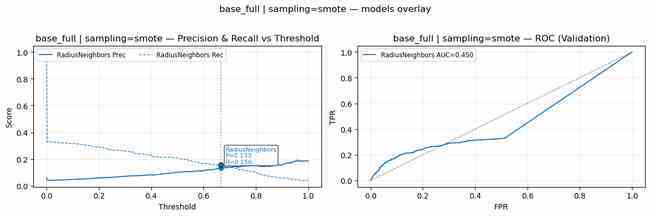


 Dataset: clean_full
Prepared dataset: Train=(55674, 20), Val=(7954, 20), Test=(15907, 20), Features=20, mode=numeric_only
  ◦ Sampling: smote
    RadiusNeighbors: thr=0.627 ValRec₁=0.159 ValPrec₁=0.102 ValAUC₁=0.432


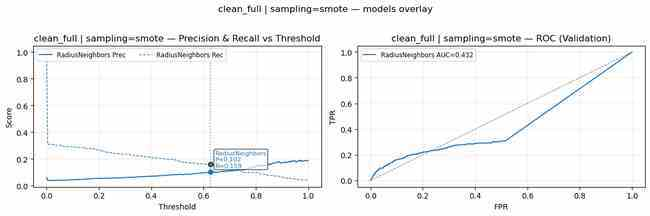


 Dataset: base_reduced
Prepared dataset: Train=(55896, 16), Val=(7986, 16), Test=(15971, 16), Features=16, mode=numeric_only
  ◦ Sampling: smote
    RadiusNeighbors: thr=0.667 ValRec₁=0.216 ValPrec₁=0.165 ValAUC₁=0.464


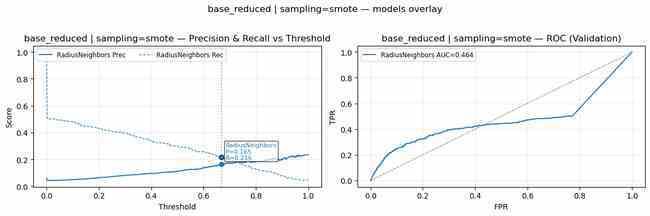


 Dataset: clean_reduced
Prepared dataset: Train=(55674, 16), Val=(7954, 16), Test=(15907, 16), Features=16, mode=numeric_only
  ◦ Sampling: smote
    RadiusNeighbors: thr=0.765 ValRec₁=0.144 ValPrec₁=0.175 ValAUC₁=0.462


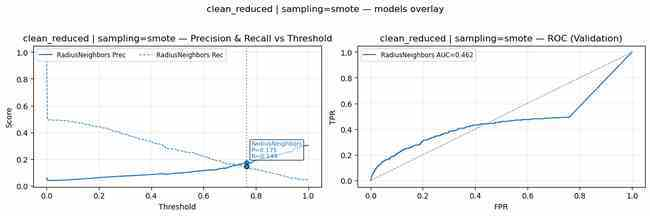


 Dataset: base_reduced_no_cat
Prepared dataset: Train=(55896, 10), Val=(7986, 10), Test=(15971, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    RadiusNeighbors: thr=0.708 ValRec₁=0.302 ValPrec₁=0.227 ValAUC₁=0.604


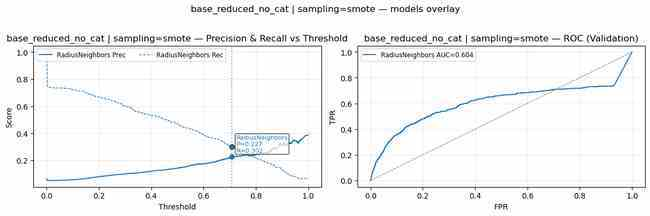


 Dataset: clean_reduced_no_cat
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    RadiusNeighbors: thr=0.690 ValRec₁=0.336 ValPrec₁=0.226 ValAUC₁=0.608


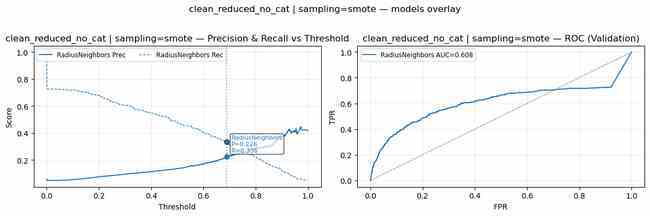


 Dataset: base_reduced_no_cat_raw
Prepared dataset: Train=(55896, 9), Val=(7986, 9), Test=(15971, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    RadiusNeighbors: thr=0.706 ValRec₁=0.346 ValPrec₁=0.236 ValAUC₁=0.641


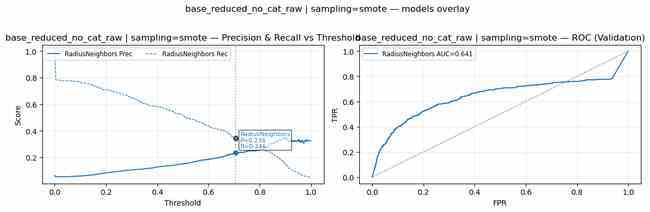


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    RadiusNeighbors: thr=0.784 ValRec₁=0.285 ValPrec₁=0.303 ValAUC₁=0.641


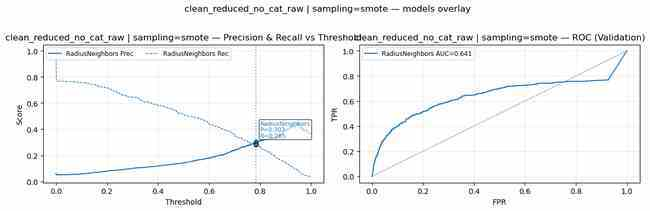


 Dataset: base_topcorr_only
Prepared dataset: Train=(55896, 4), Val=(7986, 4), Test=(15971, 4), Features=4, mode=numeric_only
  ◦ Sampling: smote
    RadiusNeighbors: thr=0.778 ValRec₁=0.404 ValPrec₁=0.342 ValAUC₁=0.797


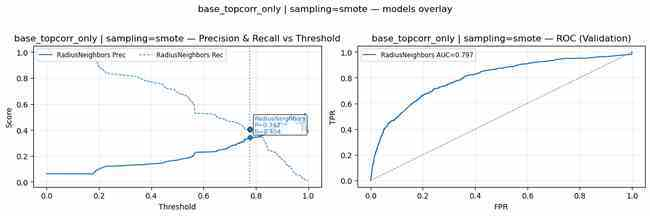


 Dataset: clean_topcorr_only
Prepared dataset: Train=(55674, 4), Val=(7954, 4), Test=(15907, 4), Features=4, mode=numeric_only
  ◦ Sampling: smote
    RadiusNeighbors: thr=0.731 ValRec₁=0.443 ValPrec₁=0.341 ValAUC₁=0.807


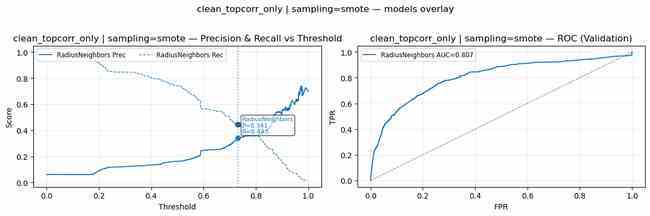


=== RadiusNeighbors (max_f1=0.8) Summary ===


dataset            model sampling_method tuning_mode  \
9        clean_topcorr_only  RadiusNeighbors           smote      max_f1   
8         base_topcorr_only  RadiusNeighbors           smote      max_f1   
6   base_reduced_no_cat_raw  RadiusNeighbors           smote      max_f1   
5      clean_reduced_no_cat  RadiusNeighbors           smote      max_f1   
4       base_reduced_no_cat  RadiusNeighbors           smote      max_f1   
7  clean_reduced_no_cat_raw  RadiusNeighbors           smote      max_f1   
2              base_reduced  RadiusNeighbors           smote      max_f1   
1                clean_full  RadiusNeighbors           smote      max_f1   
0                 base_full  RadiusNeighbors           smote      max_f1   
3             clean_reduced  RadiusNeighbors           smote      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
9            0.8          0.7309     0.3413    0.4433    0.3857    0.8069   
8            0.8          0.7778     0.3424    0.4040    0.3706    0.7974   
6            0.8          0.7059     0.2360    0.3460    0.2806    0.6411   
5            0.8          0.6897     0.2261    0.3361    0.2703    0.6080   
4            0.8          0.7084     0.2274    0.3020    0.2595    0.6040   
7            0.8          0.7841     0.3033    0.2845    0.2936    0.6413   
2            0.8          0.6674     0.1654    0.2160    0.1873    0.4644   
1            0.8          0.6271     0.1016    0.1588    0.1239    0.4320   
0            0.8          0.6667     0.1331    0.1560    0.1436    0.4497   
3            0.8          0.7647     0.1754    0.1443    0.1584    0.4618   

   test_prec1  test_rec1  test_f1_1  test_roc1  
9      0.3266     0.4186     0.3669     0.8053  
8      0.3466     0.4090     0.3752     0.8106  
6      0.2298     0.3250     0.2693     0.6447  
5      0.2055     0.3227     0.2511     0.6157  
4      0.2183     0.2790     0.2450     0.5960  
7      0.2767     0.2887     0.2825     0.6649  
2      0.1542     0.1920     0.1710     0.4696  
1      0.1104     0.1619     0.1313     0.4320  
0      0.1158     0.1380     0.1259     0.4330  
3      0.1880     0.1619     0.1740     0.4756

In [254]:
df_rad, store_rad = run_radius_neighbors_pipeline(datasets, sampling_method="smote",tuning_mode="max_f1", show_plot=True)


 Dataset: base_full
Prepared dataset: Train=(55896, 20), Val=(7986, 20), Test=(15971, 20), Features=20, mode=numeric_only
  ◦ Sampling: smote
    NearestCentroid: thr=0.522 ValRec₁=0.460 ValPrec₁=0.300 ValAUC₁=0.800


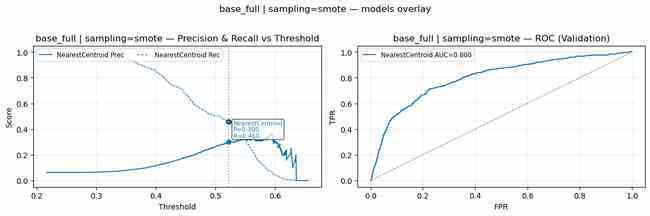


 Dataset: clean_full
Prepared dataset: Train=(55674, 20), Val=(7954, 20), Test=(15907, 20), Features=20, mode=numeric_only
  ◦ Sampling: smote
    NearestCentroid: thr=0.525 ValRec₁=0.478 ValPrec₁=0.306 ValAUC₁=0.805


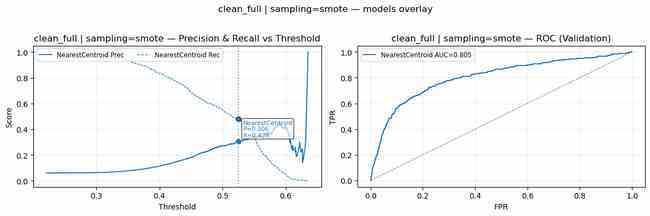


 Dataset: base_reduced
Prepared dataset: Train=(55896, 16), Val=(7986, 16), Test=(15971, 16), Features=16, mode=numeric_only
  ◦ Sampling: smote
    NearestCentroid: thr=0.522 ValRec₁=0.454 ValPrec₁=0.301 ValAUC₁=0.807


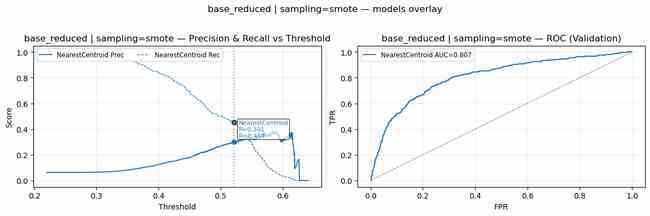


 Dataset: clean_reduced
Prepared dataset: Train=(55674, 16), Val=(7954, 16), Test=(15907, 16), Features=16, mode=numeric_only
  ◦ Sampling: smote
    NearestCentroid: thr=0.529 ValRec₁=0.464 ValPrec₁=0.328 ValAUC₁=0.811


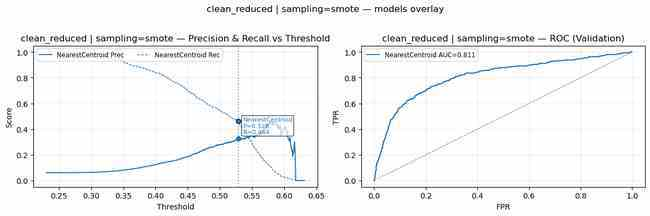


 Dataset: base_reduced_no_cat
Prepared dataset: Train=(55896, 10), Val=(7986, 10), Test=(15971, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    NearestCentroid: thr=0.522 ValRec₁=0.454 ValPrec₁=0.299 ValAUC₁=0.803


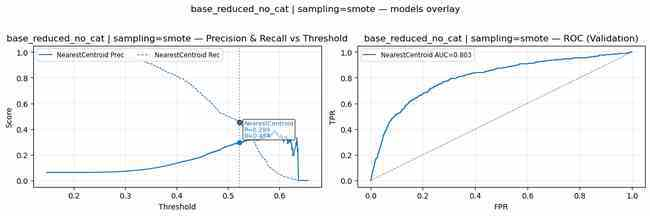


 Dataset: clean_reduced_no_cat
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    NearestCentroid: thr=0.527 ValRec₁=0.472 ValPrec₁=0.318 ValAUC₁=0.808


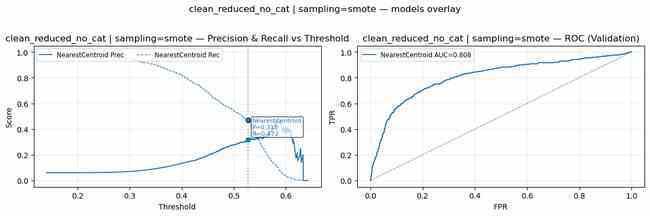


 Dataset: base_reduced_no_cat_raw
Prepared dataset: Train=(55896, 9), Val=(7986, 9), Test=(15971, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    NearestCentroid: thr=0.523 ValRec₁=0.458 ValPrec₁=0.304 ValAUC₁=0.808


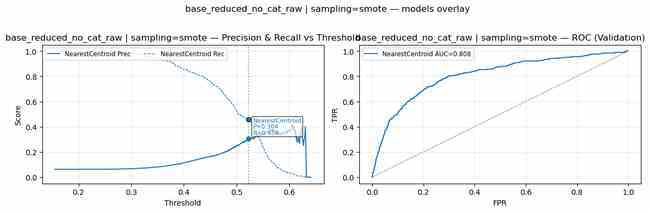


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    NearestCentroid: thr=0.527 ValRec₁=0.454 ValPrec₁=0.333 ValAUC₁=0.814


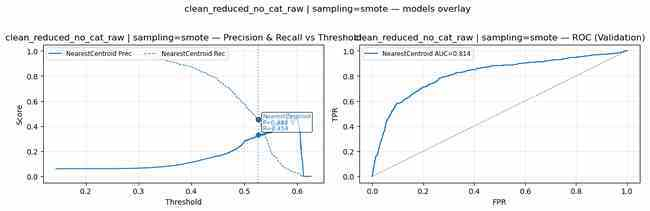


 Dataset: base_topcorr_only
Prepared dataset: Train=(55896, 4), Val=(7986, 4), Test=(15971, 4), Features=4, mode=numeric_only
  ◦ Sampling: smote
    NearestCentroid: thr=0.522 ValRec₁=0.478 ValPrec₁=0.285 ValAUC₁=0.776


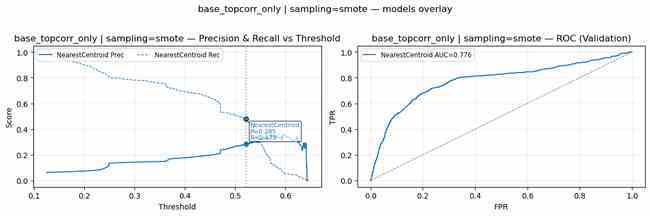


 Dataset: clean_topcorr_only
Prepared dataset: Train=(55674, 4), Val=(7954, 4), Test=(15907, 4), Features=4, mode=numeric_only
  ◦ Sampling: smote
    NearestCentroid: thr=0.520 ValRec₁=0.518 ValPrec₁=0.301 ValAUC₁=0.804


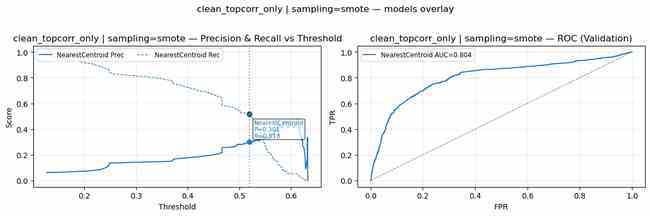


=== NearestCentroid (max_f1=0.8) Summary ===


dataset            model sampling_method tuning_mode  \
9        clean_topcorr_only  NearestCentroid           smote      max_f1   
1                clean_full  NearestCentroid           smote      max_f1   
8         base_topcorr_only  NearestCentroid           smote      max_f1   
5      clean_reduced_no_cat  NearestCentroid           smote      max_f1   
3             clean_reduced  NearestCentroid           smote      max_f1   
0                 base_full  NearestCentroid           smote      max_f1   
6   base_reduced_no_cat_raw  NearestCentroid           smote      max_f1   
2              base_reduced  NearestCentroid           smote      max_f1   
4       base_reduced_no_cat  NearestCentroid           smote      max_f1   
7  clean_reduced_no_cat_raw  NearestCentroid           smote      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
9            0.8          0.5197     0.3013    0.5175    0.3809    0.8042   
1            0.8          0.5252     0.3065    0.4784    0.3736    0.8047   
8            0.8          0.5215     0.2849    0.4780    0.3570    0.7758   
5            0.8          0.5273     0.3181    0.4722    0.3801    0.8084   
3            0.8          0.5289     0.3280    0.4639    0.3843    0.8115   
0            0.8          0.5222     0.2999    0.4600    0.3631    0.7995   
6            0.8          0.5227     0.3037    0.4580    0.3652    0.8084   
2            0.8          0.5218     0.3015    0.4540    0.3623    0.8075   
4            0.8          0.5225     0.2987    0.4540    0.3603    0.8034   
7            0.8          0.5270     0.3328    0.4536    0.3839    0.8137   

   test_prec1  test_rec1  test_f1_1  test_roc1  
9      0.3001     0.4928     0.3730     0.7958  
1      0.2980     0.4639     0.3629     0.8018  
8      0.2975     0.4900     0.3702     0.8025  
5      0.3056     0.4433     0.3618     0.8106  
3      0.3096     0.4299     0.3599     0.8134  
0      0.3061     0.4610     0.3679     0.8045  
6      0.3093     0.4590     0.3696     0.8177  
2      0.3098     0.4530     0.3680     0.8157  
4      0.3092     0.4570     0.3688     0.8113  
7      0.3147     0.4247     0.3616     0.8158

In [255]:

df_nc, store_nc = run_nearest_centroid_pipeline(datasets, sampling_method="smote",tuning_mode="max_f1", show_plot=True)


 Dataset: base_full
Prepared dataset: Train=(55896, 20), Val=(7986, 20), Test=(15971, 20), Features=20, mode=numeric_only
  ◦ Sampling: none
    DecisionTree: thr=1.000 ValRec₁=0.226 ValPrec₁=0.190


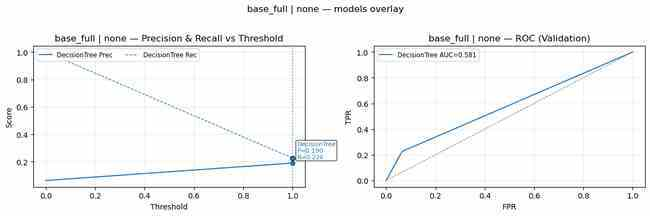


 Dataset: clean_full
Prepared dataset: Train=(55674, 20), Val=(7954, 20), Test=(15907, 20), Features=20, mode=numeric_only
  ◦ Sampling: none
    DecisionTree: thr=1.000 ValRec₁=0.198 ValPrec₁=0.175


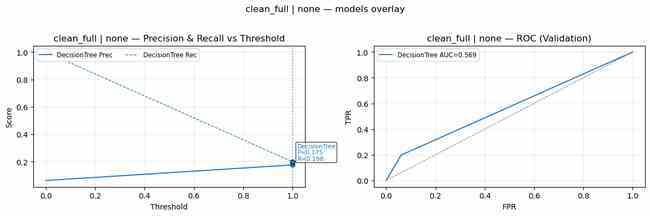


 Dataset: base_reduced
Prepared dataset: Train=(55896, 16), Val=(7986, 16), Test=(15971, 16), Features=16, mode=numeric_only
  ◦ Sampling: none
    DecisionTree: thr=1.000 ValRec₁=0.200 ValPrec₁=0.173


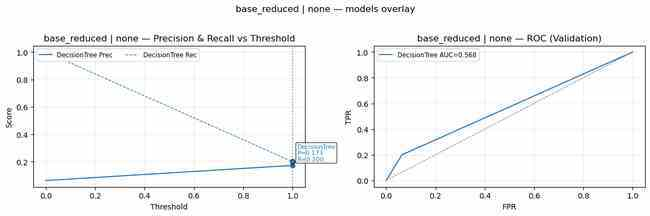


 Dataset: clean_reduced
Prepared dataset: Train=(55674, 16), Val=(7954, 16), Test=(15907, 16), Features=16, mode=numeric_only
  ◦ Sampling: none
    DecisionTree: thr=1.000 ValRec₁=0.231 ValPrec₁=0.213


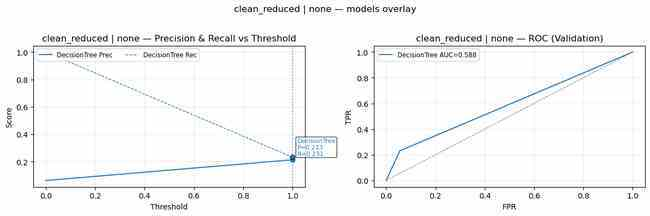


 Dataset: base_reduced_no_cat
Prepared dataset: Train=(55896, 10), Val=(7986, 10), Test=(15971, 10), Features=10, mode=numeric_only
  ◦ Sampling: none
    DecisionTree: thr=1.000 ValRec₁=0.220 ValPrec₁=0.196


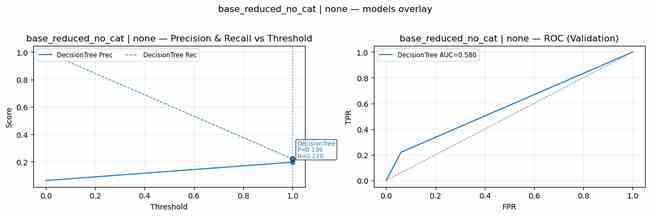


 Dataset: clean_reduced_no_cat
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: none
    DecisionTree: thr=1.000 ValRec₁=0.225 ValPrec₁=0.195


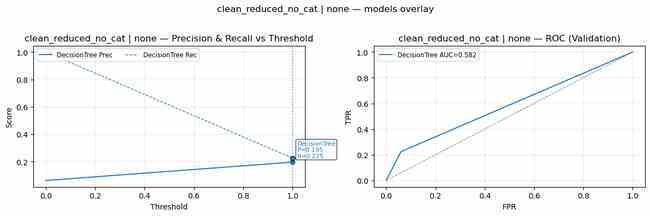


 Dataset: base_reduced_no_cat_raw
Prepared dataset: Train=(55896, 9), Val=(7986, 9), Test=(15971, 9), Features=9, mode=numeric_only
  ◦ Sampling: none
    DecisionTree: thr=1.000 ValRec₁=0.232 ValPrec₁=0.200


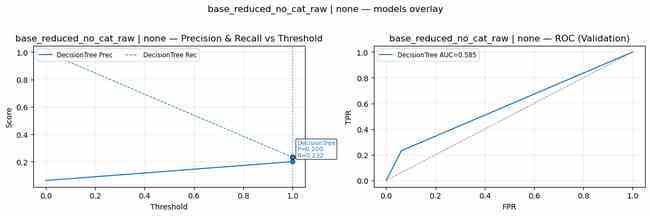


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: none
    DecisionTree: thr=1.000 ValRec₁=0.225 ValPrec₁=0.201


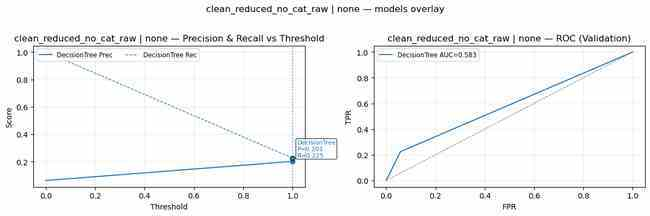


 Dataset: base_topcorr_only
Prepared dataset: Train=(55896, 4), Val=(7986, 4), Test=(15971, 4), Features=4, mode=numeric_only
  ◦ Sampling: none
    DecisionTree: thr=0.282 ValRec₁=0.274 ValPrec₁=0.290


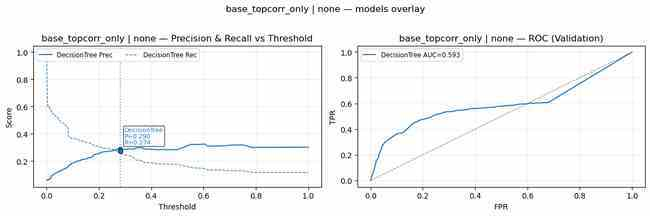


 Dataset: clean_topcorr_only
Prepared dataset: Train=(55674, 4), Val=(7954, 4), Test=(15907, 4), Features=4, mode=numeric_only
  ◦ Sampling: none
    DecisionTree: thr=0.256 ValRec₁=0.256 ValPrec₁=0.316


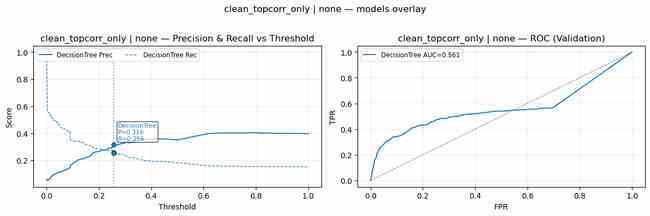


=== DecisionTree (max_f1=0.8) Summary ===


dataset         model sampling_method tuning_mode  \
8         base_topcorr_only  DecisionTree            none      max_f1   
9        clean_topcorr_only  DecisionTree            none      max_f1   
6   base_reduced_no_cat_raw  DecisionTree            none      max_f1   
3             clean_reduced  DecisionTree            none      max_f1   
0                 base_full  DecisionTree            none      max_f1   
5      clean_reduced_no_cat  DecisionTree            none      max_f1   
7  clean_reduced_no_cat_raw  DecisionTree            none      max_f1   
4       base_reduced_no_cat  DecisionTree            none      max_f1   
2              base_reduced  DecisionTree            none      max_f1   
1                clean_full  DecisionTree            none      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
8            0.8          0.2815     0.2896    0.2740    0.2816    0.5927   
9            0.8          0.2564     0.3163    0.2557    0.2828    0.5608   
6            0.8          1.0000     0.2000    0.2320    0.2148    0.5850   
3            0.8          1.0000     0.2125    0.2309    0.2213    0.5877   
0            0.8          1.0000     0.1899    0.2260    0.2064    0.5808   
5            0.8          1.0000     0.1953    0.2247    0.2090    0.5823   
7            0.8          1.0000     0.2007    0.2247    0.2121    0.5833   
4            0.8          1.0000     0.1961    0.2200    0.2074    0.5799   
2            0.8          1.0000     0.1727    0.2000    0.1854    0.5680   
1            0.8          1.0000     0.1749    0.1979    0.1857    0.5686   

   test_prec1  test_rec1  test_f1_1  test_roc1  
8      0.3143     0.2700     0.2905     0.5871  
9      0.3119     0.2649     0.2865     0.5896  
6      0.1948     0.2300     0.2109     0.5832  
3      0.2069     0.2464     0.2249     0.5925  
0      0.2105     0.2520     0.2294     0.5944  
5      0.1937     0.2155     0.2040     0.5786  
7      0.2067     0.2361     0.2204     0.5886  
4      0.2025     0.2300     0.2154     0.5847  
2      0.2013     0.2240     0.2120     0.5823  
1      0.1920     0.2227     0.2062     0.5809

In [256]:
df_dt, store_dt = run_decision_tree_pipeline_tuned(datasets, sampling_method="none",tuning_mode="max_f1", search_type=None, show_plot=True)


 Dataset: base_full
Prepared dataset: Train=(55896, 20), Val=(7986, 20), Test=(15971, 20), Features=20, mode=numeric_only
  ◦ Sampling: smote


python(42797) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(42798) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(42799) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(42800) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(42801) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(42802) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(42803) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(42804) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(42805) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


    RandomForest: thr=0.425 ValRec₁=0.356 ValPrec₁=0.285


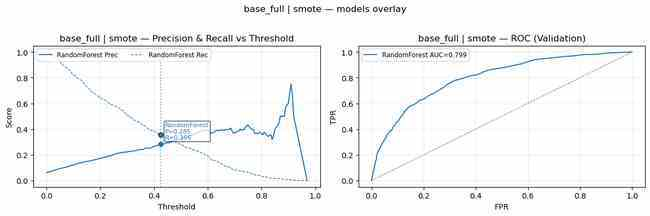


 Dataset: clean_full
Prepared dataset: Train=(55674, 20), Val=(7954, 20), Test=(15907, 20), Features=20, mode=numeric_only
  ◦ Sampling: smote


python(42923) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


    RandomForest: thr=0.380 ValRec₁=0.400 ValPrec₁=0.284


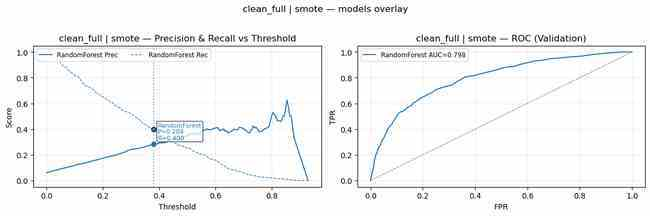


 Dataset: base_reduced
Prepared dataset: Train=(55896, 16), Val=(7986, 16), Test=(15971, 16), Features=16, mode=numeric_only
  ◦ Sampling: smote
    RandomForest: thr=0.415 ValRec₁=0.398 ValPrec₁=0.279


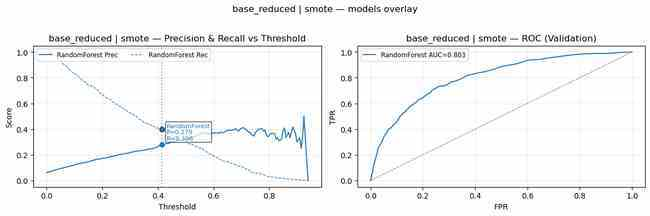


 Dataset: clean_reduced
Prepared dataset: Train=(55674, 16), Val=(7954, 16), Test=(15907, 16), Features=16, mode=numeric_only
  ◦ Sampling: smote
    RandomForest: thr=0.365 ValRec₁=0.454 ValPrec₁=0.270


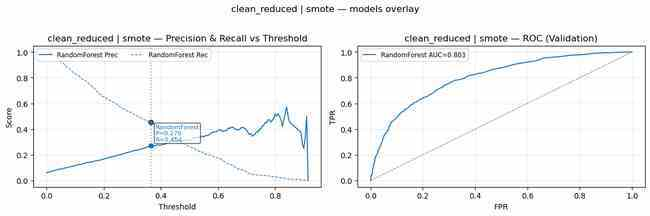


 Dataset: base_reduced_no_cat
Prepared dataset: Train=(55896, 10), Val=(7986, 10), Test=(15971, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    RandomForest: thr=0.385 ValRec₁=0.458 ValPrec₁=0.264


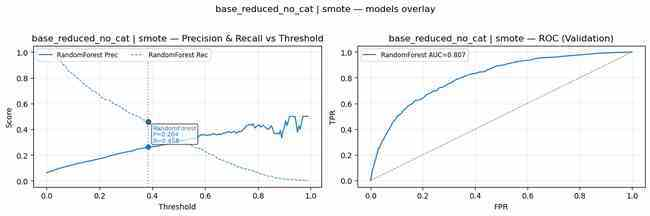


 Dataset: clean_reduced_no_cat
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    RandomForest: thr=0.395 ValRec₁=0.414 ValPrec₁=0.268


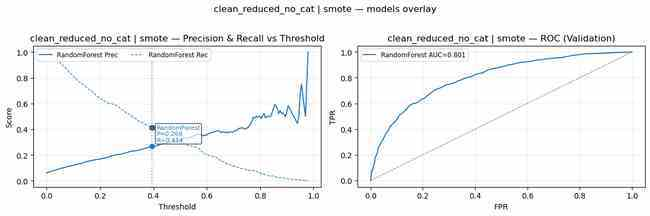


 Dataset: base_reduced_no_cat_raw
Prepared dataset: Train=(55896, 9), Val=(7986, 9), Test=(15971, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    RandomForest: thr=0.425 ValRec₁=0.426 ValPrec₁=0.278


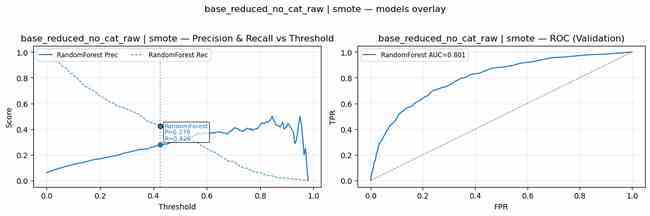


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    RandomForest: thr=0.465 ValRec₁=0.340 ValPrec₁=0.298


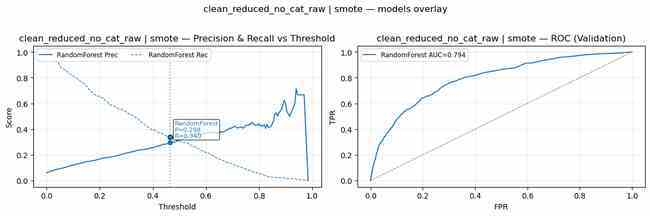


 Dataset: base_topcorr_only
Prepared dataset: Train=(55896, 4), Val=(7986, 4), Test=(15971, 4), Features=4, mode=numeric_only
  ◦ Sampling: smote
    RandomForest: thr=0.641 ValRec₁=0.406 ValPrec₁=0.259


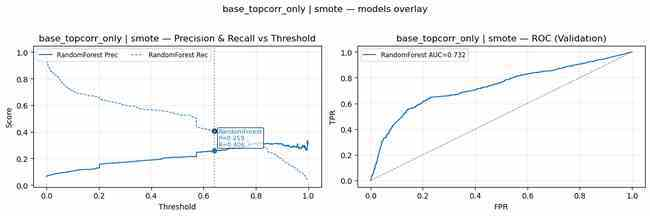


 Dataset: clean_topcorr_only
Prepared dataset: Train=(55674, 4), Val=(7954, 4), Test=(15907, 4), Features=4, mode=numeric_only
  ◦ Sampling: smote
    RandomForest: thr=0.648 ValRec₁=0.402 ValPrec₁=0.276


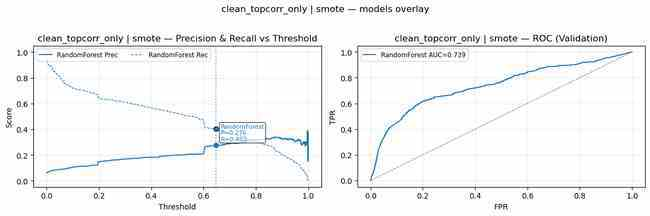


=== RandomForest (max_f1=0.8) Summary ===


dataset         model sampling_method tuning_mode  \
4       base_reduced_no_cat  RandomForest           smote      max_f1   
3             clean_reduced  RandomForest           smote      max_f1   
6   base_reduced_no_cat_raw  RandomForest           smote      max_f1   
5      clean_reduced_no_cat  RandomForest           smote      max_f1   
8         base_topcorr_only  RandomForest           smote      max_f1   
9        clean_topcorr_only  RandomForest           smote      max_f1   
1                clean_full  RandomForest           smote      max_f1   
2              base_reduced  RandomForest           smote      max_f1   
0                 base_full  RandomForest           smote      max_f1   
7  clean_reduced_no_cat_raw  RandomForest           smote      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
4            0.8          0.3850     0.2641    0.4580    0.3350    0.8069   
3            0.8          0.3650     0.2699    0.4536    0.3385    0.8028   
6            0.8          0.4250     0.2781    0.4260    0.3365    0.8008   
5            0.8          0.3950     0.2676    0.4144    0.3252    0.8013   
8            0.8          0.6407     0.2593    0.4060    0.3164    0.7319   
9            0.8          0.6481     0.2758    0.4021    0.3272    0.7394   
1            0.8          0.3800     0.2836    0.4000    0.3319    0.7985   
2            0.8          0.4150     0.2795    0.3980    0.3284    0.8035   
0            0.8          0.4250     0.2853    0.3560    0.3167    0.7990   
7            0.8          0.4650     0.2978    0.3402    0.3176    0.7943   

   test_prec1  test_rec1  test_f1_1  test_roc1  
4      0.2741     0.4670     0.3454     0.8063  
3      0.2690     0.4567     0.3386     0.8078  
6      0.2884     0.4240     0.3433     0.8035  
5      0.2643     0.4196     0.3243     0.8011  
8      0.2784     0.4050     0.3299     0.7490  
9      0.2648     0.3876     0.3146     0.7457  
1      0.2781     0.4206     0.3348     0.8083  
2      0.3058     0.4190     0.3536     0.8169  
0      0.3273     0.3970     0.3588     0.8177  
7      0.2916     0.3412     0.3145     0.8031

In [257]:
df_rf, store_rf = run_random_forest_pipeline_tuned(datasets, sampling_method="smote", search_type="random",tuning_mode="max_f1", n_iter=12, show_plot=True)


 Dataset: base_full
Prepared dataset: Train=(55896, 20), Val=(7986, 20), Test=(15971, 20), Features=20, mode=numeric_only
  ◦ Sampling: smote
    KNeighbors: thr=0.396 ValRec₁=0.402 ValPrec₁=0.167 ValAUC₁=0.670


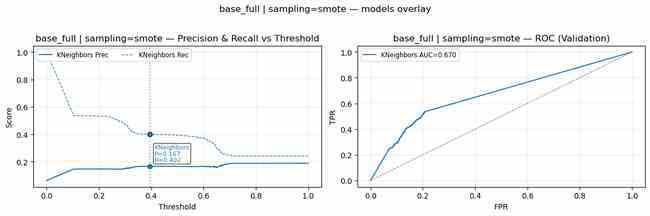


 Dataset: clean_full
Prepared dataset: Train=(55674, 20), Val=(7954, 20), Test=(15907, 20), Features=20, mode=numeric_only
  ◦ Sampling: smote
    KNeighbors: thr=0.407 ValRec₁=0.414 ValPrec₁=0.170 ValAUC₁=0.672


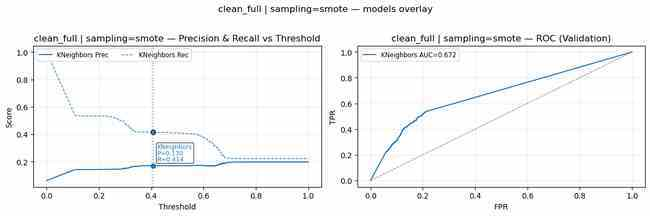


 Dataset: base_reduced
Prepared dataset: Train=(55896, 16), Val=(7986, 16), Test=(15971, 16), Features=16, mode=numeric_only
  ◦ Sampling: smote
    KNeighbors: thr=0.544 ValRec₁=0.398 ValPrec₁=0.165 ValAUC₁=0.666


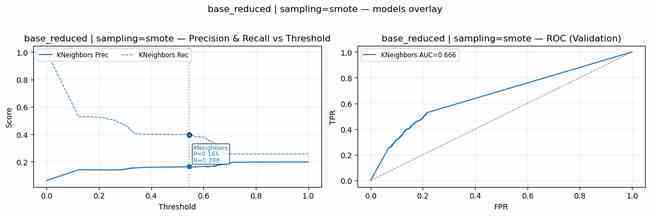


 Dataset: clean_reduced
Prepared dataset: Train=(55674, 16), Val=(7954, 16), Test=(15907, 16), Features=16, mode=numeric_only
  ◦ Sampling: smote
    KNeighbors: thr=0.391 ValRec₁=0.410 ValPrec₁=0.169 ValAUC₁=0.670


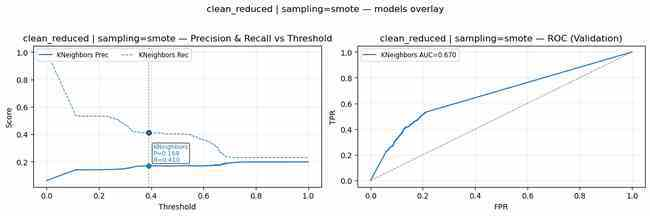


 Dataset: base_reduced_no_cat
Prepared dataset: Train=(55896, 10), Val=(7986, 10), Test=(15971, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    KNeighbors: thr=0.348 ValRec₁=0.442 ValPrec₁=0.163 ValAUC₁=0.676


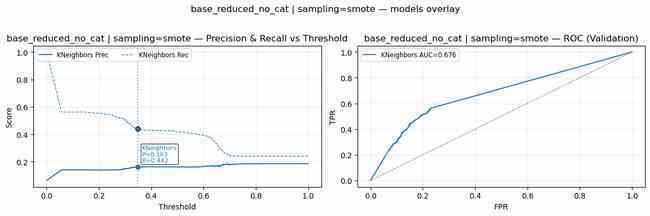


 Dataset: clean_reduced_no_cat
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    KNeighbors: thr=0.533 ValRec₁=0.416 ValPrec₁=0.170 ValAUC₁=0.684


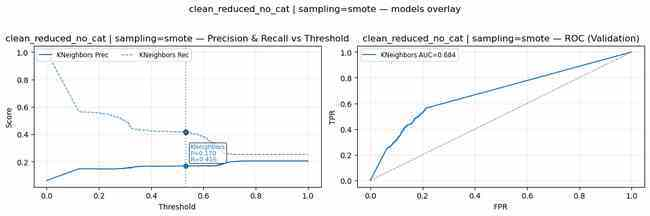


 Dataset: base_reduced_no_cat_raw
Prepared dataset: Train=(55896, 9), Val=(7986, 9), Test=(15971, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    KNeighbors: thr=0.348 ValRec₁=0.460 ValPrec₁=0.167 ValAUC₁=0.682


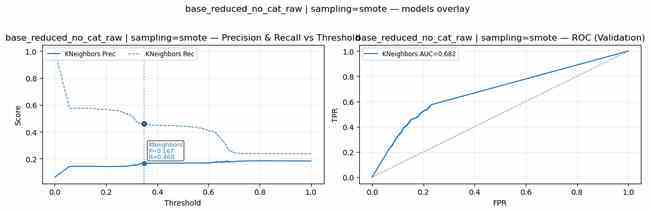


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    KNeighbors: thr=0.561 ValRec₁=0.439 ValPrec₁=0.179 ValAUC₁=0.692


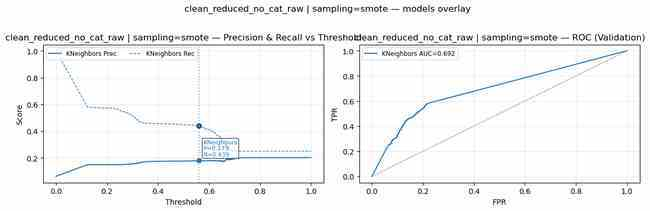


 Dataset: base_topcorr_only
Prepared dataset: Train=(55896, 4), Val=(7986, 4), Test=(15971, 4), Features=4, mode=numeric_only
  ◦ Sampling: smote
    KNeighbors: thr=0.380 ValRec₁=0.334 ValPrec₁=0.278 ValAUC₁=0.683


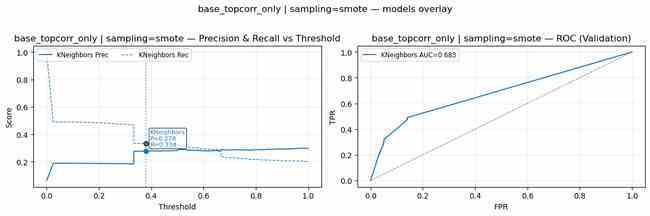


 Dataset: clean_topcorr_only
Prepared dataset: Train=(55674, 4), Val=(7954, 4), Test=(15907, 4), Features=4, mode=numeric_only
  ◦ Sampling: smote
    KNeighbors: thr=0.333 ValRec₁=0.336 ValPrec₁=0.298 ValAUC₁=0.687


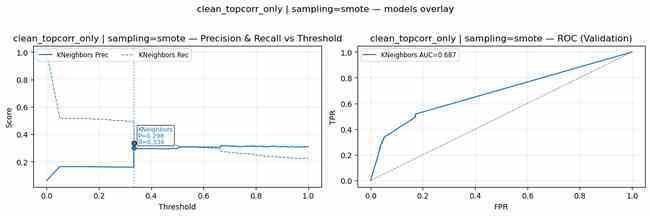


=== KNeighbors (max_f1=0.8) Summary ===


dataset       model sampling_method tuning_mode  \
6   base_reduced_no_cat_raw  KNeighbors           smote      max_f1   
4       base_reduced_no_cat  KNeighbors           smote      max_f1   
7  clean_reduced_no_cat_raw  KNeighbors           smote      max_f1   
5      clean_reduced_no_cat  KNeighbors           smote      max_f1   
1                clean_full  KNeighbors           smote      max_f1   
3             clean_reduced  KNeighbors           smote      max_f1   
0                 base_full  KNeighbors           smote      max_f1   
2              base_reduced  KNeighbors           smote      max_f1   
9        clean_topcorr_only  KNeighbors           smote      max_f1   
8         base_topcorr_only  KNeighbors           smote      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
6            0.8          0.3483     0.1672    0.4600    0.2452    0.6823   
4            0.8          0.3483     0.1630    0.4420    0.2381    0.6762   
7            0.8          0.5608     0.1787    0.4392    0.2540    0.6918   
5            0.8          0.5333     0.1696    0.4165    0.2411    0.6837   
1            0.8          0.4070     0.1701    0.4144    0.2412    0.6723   
3            0.8          0.3909     0.1685    0.4103    0.2389    0.6703   
0            0.8          0.3955     0.1668    0.4020    0.2358    0.6702   
2            0.8          0.5441     0.1646    0.3980    0.2329    0.6656   
9            0.8          0.3333     0.2980    0.3361    0.3159    0.6871   
8            0.8          0.3796     0.2783    0.3340    0.3036    0.6835   

   test_prec1  test_rec1  test_f1_1  test_roc1  
6      0.1772     0.4650     0.2566     0.6976  
4      0.1765     0.4650     0.2558     0.6977  
7      0.1725     0.4340     0.2469     0.6901  
5      0.1696     0.4320     0.2436     0.6884  
1      0.1761     0.4351     0.2507     0.6805  
3      0.1719     0.4423     0.2476     0.6872  
0      0.1799     0.4350     0.2545     0.6948  
2      0.1898     0.4390     0.2650     0.6926  
9      0.2948     0.3340     0.3132     0.6863  
8      0.3034     0.3380     0.3198     0.6829

In [258]:
df_knn, store_knn = run_knn_pipeline(datasets, sampling_method="smote", search_type="random", n_iter=16,tuning_mode="max_f1", show_plot=True)

In [260]:
def run_all_models_on_dataset_silent(
    dataset_name: str,
    dataset_df,
    sampling_method="adasyn",
    tuning_mode="recall",
    tuning_target=0.8,
    val_size=0.1,
    test_size=0.2,
    ignore_threshold_lt: float = 0.1,
    print_top_n: int = 3,            # NEW: print short top-k summary at end (0 = don't print)
):
    """
    Runs all predefined pipelines on one dataset silently (no prints or plots).
    Returns a dict containing:
      - dfs: {pipeline_name: result_df}
      - stores: {pipeline_name: model_store}
      - combined: merged & sorted DataFrame of all results
      - by_model: aggregated averages sorted by test metrics
      - run_log: list of (pipeline_name, status)

    If print_top_n > 0, prints a short summary of the top-k models sorted by:
      1) test_rec1 desc, 2) test_prec1 desc, 3) test_f1_1 desc.
    """
    pipelines = {
        "knn": (run_knn_pipeline, dict(sampling_method=sampling_method, search_type="random", n_iter=16,
                                       tuning_mode=tuning_mode, tuning_target=tuning_target,
                                       show_plot=False, val_size=val_size, test_size=test_size)),
        "voting": (run_ensemble_pipeline_voting, dict(
            datasets={dataset_name: dataset_df}, base_models=("svc", "xgb", "logreg", "mlp"),
            voting_method="soft", tuning_mode=tuning_mode, tuning_target=tuning_target,
            val_size=val_size, test_size=test_size, sampling_method=sampling_method, show_plot=False
        )),
        "serial": (run_ensemble_serial_pipeline, dict(
            datasets={dataset_name: dataset_df}, base_order=("xgb", "svc", "logreg", "mlp"),
            tuning_mode=tuning_mode, tuning_target=0.85, val_size=val_size, test_size=test_size,
            sampling_method=sampling_method, show_plot=False
        )),
        "keras_mlp": (run_nn_pipeline_keras, dict(
            datasets={dataset_name: dataset_df}, sampling_method="builtin",
            tuning_mode=tuning_mode, tuning_target=tuning_target,
            hidden_units=(256,128,64,32,16), dropout=0.2, lr=5e-4,
            batch_size=1024, epochs=50, show_plot=False, verbose=0,
            val_size=val_size, test_size=test_size
        )),
        "svm": (run_svm_pipeline_tuned, dict(
            datasets={dataset_name: dataset_df}, sampling_method="builtin",
            tuning_mode=tuning_mode, tuning_target=tuning_target,
            search_type="grid", use_kernel_if_small=False,
            show_plot=False, val_size=val_size, test_size=test_size
        )),
        "xgb": (run_xgb_pipeline_tuned, dict(
            datasets={dataset_name: dataset_df}, sampling_method="builtin",
            tuning_mode=tuning_mode, tuning_target=tuning_target,
            show_plot=False, val_size=val_size, test_size=test_size
        )),
        "logreg_poly": (run_logistic_poly_pipeline, dict(
            datasets={dataset_name: dataset_df}, degrees=(1,2),
            sampling_method=sampling_method, search_type="random",
            param_grid=None, n_iter=12, tuning_mode=tuning_mode,
            tuning_target=tuning_target, show_plot=False,
            val_size=val_size, test_size=test_size
        )),
        "radius": (run_radius_neighbors_pipeline, dict(
            datasets={dataset_name: dataset_df}, sampling_method=sampling_method,
            tuning_mode=tuning_mode, tuning_target=tuning_target,
            show_plot=False, val_size=val_size, test_size=test_size
        )),
        "nearest_centroid": (run_nearest_centroid_pipeline, dict(
            datasets={dataset_name: dataset_df}, sampling_method=sampling_method,
            tuning_mode=tuning_mode, tuning_target=tuning_target,
            show_plot=False, val_size=val_size, test_size=test_size
        )),
        "decision_tree": (run_decision_tree_pipeline_tuned, dict(
            datasets={dataset_name: dataset_df}, sampling_method="none",
            tuning_mode=tuning_mode, tuning_target=tuning_target,
            search_type=None, show_plot=False, val_size=val_size, test_size=test_size
        )),
        "random_forest": (run_random_forest_pipeline_tuned, dict(
            datasets={dataset_name: dataset_df}, sampling_method=sampling_method,
            tuning_mode=tuning_mode, tuning_target=tuning_target,
            search_type="random", n_iter=12, show_plot=False,
            val_size=val_size, test_size=test_size
        )),
    }

    dfs_out, stores_out, run_log = {}, {}, []

    for name, (fn, kwargs) in pipelines.items():
        # ensure datasets param exists
        if "datasets" not in kwargs:
            kwargs["datasets"] = {dataset_name: dataset_df}
        try:
            result = fn(**kwargs)
            # unify different return shapes
            if isinstance(result, tuple) and len(result) >= 2:
                df, store = result[0], result[1]
            elif isinstance(result, tuple):
                df, store = result[0], {}
            else:
                df, store = result, {}
            dfs_out[name] = df
            stores_out[name] = store
            run_log.append((name, "ok"))
        except Exception as e:
            # keep silent about pipeline internals but record status
            run_log.append((name, f"error: {str(e)}"))
            dfs_out[name] = None
            stores_out[name] = None
            continue

    # Combine all model summaries into single DataFrame
    summary_frames = []
    for name, df in dfs_out.items():
        if df is not None and hasattr(df, "copy"):
            temp = df.copy()
            if "model" not in temp.columns:
                temp["model"] = name
            temp["pipeline"] = name
            summary_frames.append(temp)

    if summary_frames:
        combined = pd.concat(summary_frames, ignore_index=True)
        # filter tiny thresholds if requested
        if ignore_threshold_lt is not None and "threshold_used" in combined.columns:
            combined = combined[combined["threshold_used"].astype(float) >= ignore_threshold_lt]

        # ensure sort columns exist
        sort_cols = ["test_rec1", "test_prec1", "test_f1_1"]
        for c in sort_cols:
            if c not in combined.columns:
                combined[c] = np.nan

        combined = combined.sort_values(by=sort_cols, ascending=[False, False, False]).reset_index(drop=True)

        metric_cols = ["val_prec1","val_rec1","val_f1_1","val_roc1",
                       "test_prec1","test_rec1","test_f1_1","test_roc1"]
        metric_cols = [c for c in metric_cols if c in combined.columns]

        by_model = (
            combined.groupby("model")[metric_cols]
            .mean()
            .round(4)
            .sort_values(by=["test_rec1","test_prec1","test_f1_1"], ascending=[False, False, False])
            .reset_index()
        )
    else:
        combined = pd.DataFrame()
        by_model = pd.DataFrame()

    out = {
        "dfs": dfs_out,
        "stores": stores_out,
        "combined": combined,
        "by_model": by_model,
        "run_log": run_log
    }

    # Print short textual top-k summary if requested
    if print_top_n and not combined.empty:
        topk = combined.head(print_top_n)
        print(f"\n--- Top {print_top_n} runs (sorted by test_rec, test_prec, test_f1) ---")
        for i, row in topk.iterrows():
            ds = row.get("dataset", dataset_name)
            model = row.get("model", row.get("pipeline", "unknown"))
            samp = row.get("sampling_method", "")
            thr = row.get("threshold_used", np.nan)
            tr = float(row.get("test_rec1", np.nan)) if not pd.isna(row.get("test_rec1", np.nan)) else np.nan
            tp = float(row.get("test_prec1", np.nan)) if not pd.isna(row.get("test_prec1", np.nan)) else np.nan
            tf1 = float(row.get("test_f1_1", np.nan)) if not pd.isna(row.get("test_f1_1", np.nan)) else np.nan
            roc = float(row.get("test_roc1", np.nan)) if not pd.isna(row.get("test_roc1", np.nan)) else np.nan
            print(f"{i+1}. dataset={ds} model={model} sampling={samp} thr={thr:.3f}  test_rec={tr:.3f}  test_prec={tp:.3f}  test_f1={tf1:.3f}  test_roc={roc:.3f}")
        print("--- end top summary ---\n")

    return out


## Run All modesl on clean_reduced_no_cat_raw  with Recall tuning  SMOTE and get Best 3 among all modesls

In [261]:
res = run_all_models_on_dataset_silent(
    "clean_reduced_no_cat_raw",
    clean_reduced_no_cat,
    sampling_method="smote",
    tuning_mode="recall",
    tuning_target=0.7,
    print_top_n=3
)

combined_df = res["combined"]     # full combined runs (filtered & sorted)
by_model_df = res["by_model"]      # average metrics per model, sorted


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    KNeighbors: thr=0.000 ValRec₁=1.000 ValPrec₁=0.061 ValAUC₁=0.684

=== KNeighbors (recall=0.7) Summary ===


dataset       model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  KNeighbors           smote      recall   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.7             0.0      0.061       1.0    0.1149    0.6837   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0       0.061        1.0     0.1149     0.6884


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    Trained LinearSVC_calib: thr=0.552 val_roc=0.832
    Trained XGBoost: thr=0.156 val_roc=0.811
    Trained LogisticRegression: thr=0.539 val_roc=0.834
    MLP failed: build_keras_mlp_5layer not found. Define it or replace with another builder.
    Ensemble(soft): thr=0.418  ValRec₁=0.701  ValPrec₁=0.191  ValROC₁=0.834

=== Ensemble (soft) Summary ===


dataset           model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  Ensemble[soft]           smote      recall   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.7          0.4182     0.1907     0.701    0.2998    0.8337   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.1965     0.7041     0.3073     0.8328


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    ➤ Stage 1: xgb
      Stage 1 xgb: thr=0.084  new_pos_val=3503  remaining_val=4451
    ➤ Stage 2: svc
      Stage 2 svc: thr=0.007  new_pos_val=7363  remaining_val=157
    ➤ Stage 3: logreg
      Fit failed for stage logreg: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0
    ➤ Stage 4: mlp
      Fit failed for stage mlp: build_keras_mlp_5layer not found. Define it or replace with another builder.
    Serial ensemble final: ValRec₁=1.000 ValPrec₁=0.062 ValROC₁=0.511

=== Serial Ensemble Summary ===


dataset           model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  SerialEnsemble           smote      recall   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0           0.85             0.5     0.0622       1.0    0.1171    0.5105   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.0616     0.9928      0.116     0.5055


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: builtin
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step
    KerasMLP: thr=0.594  ValRec₁=0.701  ValPrec₁=0.221  ValROC₁=0.840

=== Keras MLP (recall=0.7) Summary ===


dataset     model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  KerasMLP         builtin      recall   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.7          0.5938     0.2214     0.701    0.3365    0.8395   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.2209     0.6763     0.3331     0.8346


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: builtin
    SVM: thr=0.056  ValRec₁=0.709  ValPrec₁=0.196  ValROC₁=0.838

=== SVM (recall=0.7) Summary ===


dataset model sampling_method tuning_mode  tuning_target  \
0  clean_reduced_no_cat_raw   SVM         builtin      recall            0.7   

   threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  test_prec1  \
0          0.0562     0.1959    0.7093     0.307    0.8376      0.1973   

   test_rec1  test_f1_1  test_roc1  
0     0.6897     0.3068     0.8321


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: builtin
     XGB: thr=0.419  ValPrec₁=0.177  ValRec₁=0.701  AUC=0.820

=== XGBoost (recall=0.7) Summary ===


dataset    model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  XGBoost         builtin      recall   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.7          0.4194     0.1772     0.701    0.2829    0.8201   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.1747     0.7021     0.2798     0.8174


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    ➤ Degree 1
      deg=1: thr=0.539  ValRec₁=0.701  ValPrec₁=0.196
    ➤ Degree 2
      deg=2: thr=0.549  ValRec₁=0.703  ValPrec₁=0.196

=== Logistic Regression Poly (recall=0.7) Summary ===


dataset                   model sampling_method  degree  \
1  clean_reduced_no_cat_raw  LogisticRegressionPoly           smote       2   
0  clean_reduced_no_cat_raw  LogisticRegressionPoly           smote       1   

  tuning_mode  tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  \
1      recall            0.7          0.5486     0.1958    0.7031    0.3062   
0      recall            0.7          0.5387     0.1957    0.7010    0.3060   

   val_roc1  test_prec1  test_rec1  test_f1_1  test_roc1  
1    0.8337      0.1977     0.6938     0.3077     0.8276  
0    0.8342      0.1977     0.6814     0.3065     0.8284


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    RadiusNeighbors: thr=0.158 ValRec₁=0.701 ValPrec₁=0.066 ValAUC₁=0.608

=== RadiusNeighbors (recall=0.7) Summary ===


dataset            model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  RadiusNeighbors           smote      recall   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.7          0.1579     0.0662     0.701     0.121     0.608   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.0654     0.7021     0.1197     0.6157


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    NearestCentroid: thr=0.445 ValRec₁=0.701 ValPrec₁=0.187 ValAUC₁=0.808

=== NearestCentroid (recall=0.7) Summary ===


dataset            model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  NearestCentroid           smote      recall   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.7          0.4454     0.1868     0.701     0.295    0.8084   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.1926     0.6918     0.3013     0.8106


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: none
    DecisionTree: thr=0.000 ValRec₁=1.000 ValPrec₁=0.061

=== DecisionTree (recall=0.7) Summary ===


dataset         model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  DecisionTree            none      recall   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.7             0.0      0.061       1.0    0.1149    0.5823   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0       0.061        1.0     0.1149     0.5786


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    RandomForest: thr=0.165 ValRec₁=0.705 ValPrec₁=0.157

=== RandomForest (recall=0.7) Summary ===


dataset         model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  RandomForest           smote      recall   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.7           0.165     0.1567    0.7052    0.2564    0.8013   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.1555     0.7093     0.2551     0.8011


--- Top 3 runs (sorted by test_rec, test_prec, test_f1) ---
1. dataset=clean_reduced_no_cat_raw model=SerialEnsemble sampling=smote thr=0.500  test_rec=0.993  test_prec=0.062  test_f1=0.116  test_roc=0.505
2. dataset=clean_reduced_no_cat_raw model=RandomForest sampling=smote thr=0.165  test_rec=0.709  test_prec=0.155  test_f1=0.255  test_roc=0.801
3. dataset=clean_reduced_no_cat_raw model=Ensemble[soft] sampling=smote thr=0.418  test_rec=0.704  test_prec=0.197  test_f1=0.307  test_roc=0.833
--- end top summary ---



## Run All modesl on clean_reduced_no_cat_raw  with F1 tuning  SMOTE and get Best 3 among all modesls

In [262]:
res = run_all_models_on_dataset_silent(
    "clean_reduced_no_cat_raw",
    clean_reduced_no_cat,
    sampling_method="smote",
    tuning_mode="max_f1",
    tuning_target=0.8,
    print_top_n=3
)

combined_df = res["combined"]     # full combined runs (filtered & sorted)
by_model_df = res["by_model"]      # average metrics per model, sorted


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    KNeighbors: thr=0.533 ValRec₁=0.416 ValPrec₁=0.170 ValAUC₁=0.684

=== KNeighbors (max_f1=0.8) Summary ===


dataset       model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  KNeighbors           smote      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8          0.5333     0.1696    0.4165    0.2411    0.6837   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.1696      0.432     0.2436     0.6884


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    Trained LinearSVC_calib: thr=0.726 val_roc=0.832
    Trained XGBoost: thr=0.393 val_roc=0.811
    Trained LogisticRegression: thr=0.710 val_roc=0.834
    MLP failed: build_keras_mlp_5layer not found. Define it or replace with another builder.
    Ensemble(soft): thr=0.583  ValRec₁=0.482  ValPrec₁=0.330  ValROC₁=0.834

=== Ensemble (soft) Summary ===


dataset           model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  Ensemble[soft]           smote      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8          0.5833     0.3296    0.4825    0.3916    0.8337   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.3282     0.4814     0.3903     0.8328


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    ➤ Stage 1: xgb
      Stage 1 xgb: thr=0.393  new_pos_val=539  remaining_val=7415
    ➤ Stage 2: svc
      Stage 2 svc: thr=0.090  new_pos_val=1360  remaining_val=6516
    ➤ Stage 3: logreg
      Stage 3 logreg: thr=0.101  new_pos_val=1750  remaining_val=6170
    ➤ Stage 4: mlp
      Fit failed for stage mlp: build_keras_mlp_5layer not found. Define it or replace with another builder.
    Serial ensemble final: ValRec₁=0.713 ValPrec₁=0.194 ValROC₁=0.760

=== Serial Ensemble Summary ===


dataset           model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  SerialEnsemble           smote      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0           0.85             0.5     0.1939    0.7134     0.305    0.7604   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.1964      0.701     0.3068     0.7574


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: builtin
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step
    KerasMLP: thr=0.720  ValRec₁=0.460  ValPrec₁=0.364  ValROC₁=0.840

=== Keras MLP (max_f1=0.8) Summary ===


dataset     model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  KerasMLP         builtin      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8          0.7197     0.3644    0.4598    0.4066    0.8397   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.3428      0.434     0.3831     0.8352


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: builtin
    SVM: thr=0.125  ValRec₁=0.435  ValPrec₁=0.383  ValROC₁=0.838

=== SVM (max_f1=0.8) Summary ===


dataset model sampling_method tuning_mode  tuning_target  \
0  clean_reduced_no_cat_raw   SVM         builtin      max_f1            0.8   

   threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  test_prec1  \
0          0.1249     0.3829    0.4351    0.4073    0.8376       0.356   

   test_rec1  test_f1_1  test_roc1  
0     0.4041     0.3786     0.8321


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: builtin
     XGB: thr=0.717  ValPrec₁=0.321  ValRec₁=0.421  AUC=0.820

=== XGBoost (max_f1=0.8) Summary ===


dataset    model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  XGBoost         builtin      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8          0.7166     0.3208    0.4206     0.364    0.8201   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.3182     0.4052     0.3565     0.8174


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    ➤ Degree 1
      deg=1: thr=0.710  ValRec₁=0.493  ValPrec₁=0.329
    ➤ Degree 2
      deg=2: thr=0.777  ValRec₁=0.429  ValPrec₁=0.398

=== Logistic Regression Poly (max_f1=0.8) Summary ===


dataset                   model sampling_method  degree  \
0  clean_reduced_no_cat_raw  LogisticRegressionPoly           smote       1   
1  clean_reduced_no_cat_raw  LogisticRegressionPoly           smote       2   

  tuning_mode  tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  \
0      max_f1            0.8          0.7097     0.3287    0.4928    0.3944   
1      max_f1            0.8          0.7773     0.3977    0.4289    0.4127   

   val_roc1  test_prec1  test_rec1  test_f1_1  test_roc1  
0    0.8342      0.3158     0.4773     0.3801     0.8284  
1    0.8337      0.3551     0.3814     0.3678     0.8276


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    RadiusNeighbors: thr=0.690 ValRec₁=0.336 ValPrec₁=0.226 ValAUC₁=0.608

=== RadiusNeighbors (max_f1=0.8) Summary ===


dataset            model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  RadiusNeighbors           smote      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8          0.6897     0.2261    0.3361    0.2703     0.608   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.2055     0.3227     0.2511     0.6157


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    NearestCentroid: thr=0.527 ValRec₁=0.472 ValPrec₁=0.318 ValAUC₁=0.808

=== NearestCentroid (max_f1=0.8) Summary ===


dataset            model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  NearestCentroid           smote      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8          0.5273     0.3181    0.4722    0.3801    0.8084   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.3056     0.4433     0.3618     0.8106


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: none
    DecisionTree: thr=1.000 ValRec₁=0.225 ValPrec₁=0.195

=== DecisionTree (max_f1=0.8) Summary ===


dataset         model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  DecisionTree            none      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8             1.0     0.1953    0.2247     0.209    0.5823   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.1937     0.2155      0.204     0.5786


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: smote
    RandomForest: thr=0.395 ValRec₁=0.414 ValPrec₁=0.268

=== RandomForest (max_f1=0.8) Summary ===


dataset         model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  RandomForest           smote      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8           0.395     0.2676    0.4144    0.3252    0.8013   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.2643     0.4196     0.3243     0.8011


--- Top 3 runs (sorted by test_rec, test_prec, test_f1) ---
1. dataset=clean_reduced_no_cat_raw model=SerialEnsemble sampling=smote thr=0.500  test_rec=0.701  test_prec=0.196  test_f1=0.307  test_roc=0.757
2. dataset=clean_reduced_no_cat_raw model=Ensemble[soft] sampling=smote thr=0.583  test_rec=0.481  test_prec=0.328  test_f1=0.390  test_roc=0.833
3. dataset=clean_reduced_no_cat_raw model=LogisticRegressionPoly sampling=smote thr=0.710  test_rec=0.477  test_prec=0.316  test_f1=0.380  test_roc=0.828
--- end top summary ---



## Run All modesl on clean_reduced_no_cat_raw  with precision tuning  enn and get Best 3 among all modesls

In [263]:
res = run_all_models_on_dataset_silent(
    "clean_reduced_no_cat_raw",
    clean_reduced_no_cat,
    sampling_method="enn",
    tuning_mode="precision",
    tuning_target=0.8,
    print_top_n=3
)

combined_df = res["combined"]     # full combined runs (filtered & sorted)
by_model_df = res["by_model"]      # average metrics per model, sorted


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: enn
    KNeighbors: thr=0.548 ValRec₁=0.365 ValPrec₁=0.343 ValAUC₁=0.717

=== KNeighbors (precision=0.8) Summary ===


dataset       model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  KNeighbors             enn   precision   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8          0.5482      0.343    0.3649    0.3536    0.7165   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.2868     0.3237     0.3041     0.6916


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: enn
    Trained LinearSVC_calib: thr=1.000 val_roc=0.837
    Trained XGBoost: thr=0.851 val_roc=0.831
    Trained LogisticRegression: thr=0.999 val_roc=0.837
    MLP failed: build_keras_mlp_5layer not found. Define it or replace with another builder.
    Ensemble(soft): thr=0.424  ValRec₁=0.454  ValPrec₁=0.372  ValROC₁=0.841

=== Ensemble (soft) Summary ===


dataset           model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  Ensemble[soft]             enn   precision   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8          0.4244     0.3716    0.4536    0.4085    0.8413   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0       0.345     0.4175     0.3778     0.8295


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: enn
    ➤ Stage 1: xgb
      Stage 1 xgb: thr=0.851  new_pos_val=516  remaining_val=7438
    ➤ Stage 2: svc
      Stage 2 svc: thr=0.096  new_pos_val=825  remaining_val=6982
    ➤ Stage 3: logreg
      Stage 3 logreg: thr=0.085  new_pos_val=1613  remaining_val=6293
    ➤ Stage 4: mlp
      Fit failed for stage mlp: build_keras_mlp_5layer not found. Define it or replace with another builder.
    Serial ensemble final: ValRec₁=0.695 ValPrec₁=0.203 ValROC₁=0.759

=== Serial Ensemble Summary ===


dataset           model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  SerialEnsemble             enn   precision   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0           0.85             0.5     0.2029    0.6948    0.3141    0.7588   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.2034     0.6753     0.3126     0.7518


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: builtin
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step
    KerasMLP: thr=0.982  ValRec₁=0.019  ValPrec₁=0.818  ValROC₁=0.839

=== Keras MLP (precision=0.8) Summary ===


dataset     model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  KerasMLP         builtin   precision   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8          0.9816     0.8182    0.0186    0.0363    0.8392   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0       0.619     0.0268     0.0514     0.8308


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: builtin
    SVM: thr=0.945  ValRec₁=0.014  ValPrec₁=0.875  ValROC₁=0.838

=== SVM (precision=0.8) Summary ===


dataset model sampling_method tuning_mode  tuning_target  \
0  clean_reduced_no_cat_raw   SVM         builtin   precision            0.8   

   threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  test_prec1  \
0          0.9451      0.875    0.0144    0.0284    0.8376      0.7667   

   test_rec1  test_f1_1  test_roc1  
0     0.0237      0.046     0.8321


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: builtin
     XGB: thr=0.968  ValPrec₁=0.812  ValRec₁=0.027  AUC=0.820

=== XGBoost (precision=0.8) Summary ===


dataset    model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  XGBoost         builtin   precision   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8           0.968     0.8125    0.0268    0.0519    0.8201   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.7586     0.0227      0.044     0.8174


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: enn
    ➤ Degree 1
      deg=1: thr=0.999  ValRec₁=0.025  ValPrec₁=0.800
    ➤ Degree 2
      deg=2: thr=1.000  ValRec₁=0.002  ValPrec₁=1.000

=== Logistic Regression Poly (precision=0.8) Summary ===


dataset                   model sampling_method  degree  \
1  clean_reduced_no_cat_raw  LogisticRegressionPoly             enn       2   
0  clean_reduced_no_cat_raw  LogisticRegressionPoly             enn       1   

  tuning_mode  tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  \
1   precision            0.8          1.0000        1.0    0.0021    0.0041   
0   precision            0.8          0.9986        0.8    0.0247    0.0480   

   val_roc1  test_prec1  test_rec1  test_f1_1  test_roc1  
1    0.8375      1.0000     0.0010     0.0021     0.8327  
0    0.8375      0.6585     0.0278     0.0534     0.8309


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: enn
    RadiusNeighbors: thr=0.161 ValRec₁=0.309 ValPrec₁=0.226 ValAUC₁=0.582

=== RadiusNeighbors (precision=0.8) Summary ===


dataset            model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  RadiusNeighbors             enn   precision   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8          0.1607     0.2259    0.3093    0.2611    0.5824   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.2082     0.2979     0.2451     0.5793


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: enn
    NearestCentroid: thr=0.528 ValRec₁=0.497 ValPrec₁=0.305 ValAUC₁=0.811

=== NearestCentroid (precision=0.8) Summary ===


dataset            model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  NearestCentroid             enn   precision   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8           0.528     0.3047    0.4969    0.3777    0.8108   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.3012     0.4742     0.3684     0.8128


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: none
    DecisionTree: thr=1.000 ValRec₁=0.225 ValPrec₁=0.195

=== DecisionTree (precision=0.8) Summary ===


dataset         model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  DecisionTree            none   precision   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8             1.0     0.1953    0.2247     0.209    0.5823   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.1937     0.2155      0.204     0.5786


 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 10), Val=(7954, 10), Test=(15907, 10), Features=10, mode=numeric_only
  ◦ Sampling: enn
    RandomForest: thr=0.400 ValRec₁=0.427 ValPrec₁=0.363

=== RandomForest (precision=0.8) Summary ===


dataset         model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  RandomForest             enn   precision   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8             0.4     0.3625    0.4268     0.392    0.8199   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.3451     0.3938     0.3678     0.8102


--- Top 3 runs (sorted by test_rec, test_prec, test_f1) ---
1. dataset=clean_reduced_no_cat_raw model=SerialEnsemble sampling=enn thr=0.500  test_rec=0.675  test_prec=0.203  test_f1=0.313  test_roc=0.752
2. dataset=clean_reduced_no_cat_raw model=NearestCentroid sampling=enn thr=0.528  test_rec=0.474  test_prec=0.301  test_f1=0.368  test_roc=0.813
3. dataset=clean_reduced_no_cat_raw model=Ensemble[soft] sampling=enn thr=0.424  test_rec=0.417  test_prec=0.345  test_f1=0.378  test_roc=0.830
--- end top summary ---



### Orchestrate  function to runn all models with all samling techniques

In [265]:
def orchestrate_resample_model_sweep(
    datasets: dict,
    sampling_methods: List[str] = ("random_under","random_over","smote","adasyn","smote_tomek","tomek","enn"),
    models_to_run: List[str] = ("KNeighbors","RadiusNeighbors","NearestCentroid",
                                "DecisionTree","RandomForest","XGBoost",
                                "SVM","LogisticPoly","KerasMLP","EnsembleSoft","EnsembleSerial"),
    tuning_mode: str = "max_f1",
    tuning_target: float = 0.8,
    val_size: float = 0.1,
    test_size: float = 0.2,
    show_plot: bool = True,
    min_threshold: float = 0.1,      # ignore rows with threshold < this (set None to keep all)
    reuse_models: dict = None        # optional pre-trained model storages
) -> Tuple[pd.DataFrame, Dict[str, pd.DataFrame]]:
    """
    Orchestrate runs across sampling_methods and models. Returns (df_all, top5_dict).
    - datasets: dict of name -> DataFrame (same as you already use)
    - models_to_run: choose from the available run_* pipelines you've already implemented.
    NOTE: This function uses each model's run_* wrapper that returns (df, store).
    """

    # mapping of friendly model names -> pipeline function names in your environment
    model_to_func = {
        "KNeighbors": run_knn_pipeline,
        "RadiusNeighbors": run_radius_neighbors_pipeline,
        "NearestCentroid": run_nearest_centroid_pipeline,
        "DecisionTree": run_decision_tree_pipeline_tuned,
        "RandomForest": run_random_forest_pipeline_tuned,
        "XGBoost": run_xgb_pipeline_tuned,
        "SVM": run_svm_pipeline_tuned,
        "LogisticPoly": run_logistic_poly_pipeline,
        "KerasMLP": run_nn_pipeline_keras,
        "EnsembleSoft": run_ensemble_pipeline_voting,   # use voting soft
        "EnsembleSerial": run_ensemble_serial_pipeline
    }

    rows = []
    stores = {}
    df_list = []

    # loop sampling methods
    for sm in sampling_methods:
        print(f"\n=== Sampling method: {sm} ===")
        for model_name in models_to_run:
            if model_name not in model_to_func:
                print(f"   skipping unknown model: {model_name}")
                continue

            fn = model_to_func[model_name]

            print(f"  ➤ Running {model_name} with sampling={sm} ...")
            try:
                # adapt call signature per model where necessary
                # common args: datasets, sampling_method, tuning_mode, tuning_target, val_size, test_size, show_plot
                # some functions accept different extras (degrees, hidden_units, etc.) — rely on defaults
                df_res, store = fn(
                    datasets,
                    sampling_method=sm,
                    tuning_mode=tuning_mode,
                    tuning_target=tuning_target,
                    val_size=val_size,
                    test_size=test_size,
                    show_plot=show_plot
                )
                # store results
                stores.setdefault(sm, {})[model_name] = store

                # normalize returned DataFrame format (ensure keys exist)
                if df_res is None or (isinstance(df_res, pd.DataFrame) and df_res.empty):
                    print(f"     {model_name} returned no rows for sampling={sm}")
                    continue

                df_tmp = df_res.copy()
                # annotate with model and sampling (some wrappers already include)
                if "model" not in df_tmp.columns:
                    df_tmp["model"] = model_name
                if "sampling_method" not in df_tmp.columns:
                    df_tmp["sampling_method"] = sm

                # optional filter: drop tiny thresholds (degenerate outputs)
                if min_threshold is not None and "threshold_used" in df_tmp.columns:
                    keep_mask = df_tmp["threshold_used"].astype(float) >= float(min_threshold)
                    if keep_mask.sum() == 0:
                        print(f"     All rows below threshold {min_threshold} — keeping original rows (no filtering).")
                    else:
                        df_tmp = df_tmp.loc[keep_mask].reset_index(drop=True)

                df_list.append(df_tmp)

            except Exception as e:
                print(f"     Error running {model_name} with sampling={sm}: {e}")

    # concat all
    if df_list:
        df_all = pd.concat(df_list, ignore_index=True, sort=False).fillna(np.nan)
    else:
        df_all = pd.DataFrame()

    # Ensure numeric columns exist
    for col in ["test_rec1","test_prec1","test_f1_1"]:
        if col not in df_all.columns:
            df_all[col] = np.nan

    # sort final DataFrame for human inspection by test_rec1 desc then test_prec1 desc then test_f1_1 desc
    df_all_sorted = df_all.copy()
    df_all_sorted[["test_rec1","test_prec1","test_f1_1"]] = df_all_sorted[["test_rec1","test_prec1","test_f1_1"]].apply(pd.to_numeric, errors="coerce")
    df_all_sorted = df_all_sorted.sort_values(by=["test_rec1","test_prec1","test_f1_1"], ascending=[False,False,False]).reset_index(drop=True)

    # compute top-5 per metric (break ties by test_f1_1)
    top5_by_recall = df_all_sorted.sort_values(by=["test_rec1","test_f1_1","test_prec1"], ascending=[False,False,False]).head(5)
    top5_by_precision = df_all_sorted.sort_values(by=["test_prec1","test_f1_1","test_rec1"], ascending=[False,False,False]).head(5)
    top5_by_f1 = df_all_sorted.sort_values(by=["test_f1_1","test_rec1","test_prec1"], ascending=[False,False,False]).head(5)

    top5 = {
        "by_recall": top5_by_recall,
        "by_precision": top5_by_precision,
        "by_f1": top5_by_f1
    }

    print("\n=== Combined results shape:", df_all_sorted.shape)
    print("Top 5 by test recall:")
    display(top5_by_recall)
    print("Top 5 by test precision:")
    display(top5_by_precision)
    print("Top 5 by test F1:")
    display(top5_by_f1)

    return df_all_sorted, top5, stores

### Run all models against clean_reduced_no_cat_raw with all balancing techniques with threshold tuing on F1


=== Sampling method: random_under ===
  ➤ Running KNeighbors with sampling=random_under ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: random_under
    KNeighbors: thr=0.800 ValRec₁=0.551 ValPrec₁=0.215 ValAUC₁=0.796


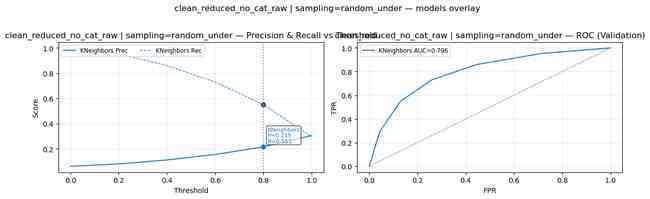


=== KNeighbors (max_f1=0.8) Summary ===


dataset       model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  KNeighbors    random_under      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8             0.8     0.2155    0.5505    0.3097    0.7962   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.2168     0.5485     0.3107     0.7907

  ➤ Running RadiusNeighbors with sampling=random_under ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: random_under
    RadiusNeighbors: thr=0.741 ValRec₁=0.305 ValPrec₁=0.233 ValAUC₁=0.611


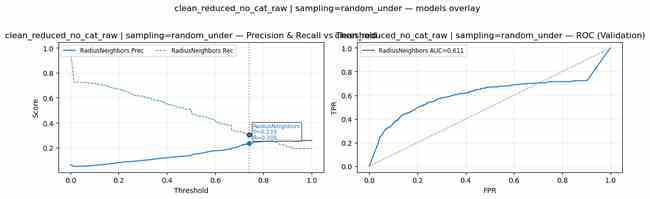


=== RadiusNeighbors (max_f1=0.8) Summary ===


dataset            model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  RadiusNeighbors    random_under      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8          0.7407     0.2334    0.3052    0.2645    0.6108   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.2272     0.3186     0.2652     0.6234

  ➤ Running NearestCentroid with sampling=random_under ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: random_under
    NearestCentroid: thr=0.512 ValRec₁=0.526 ValPrec₁=0.303 ValAUC₁=0.813


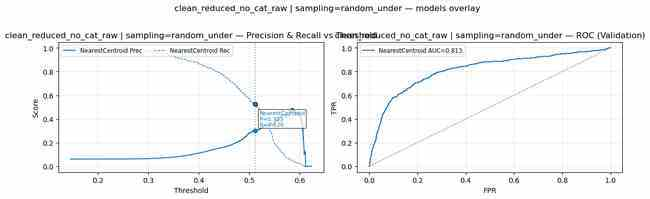


=== NearestCentroid (max_f1=0.8) Summary ===


dataset            model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  NearestCentroid    random_under      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8          0.5121     0.3029    0.5258    0.3843    0.8134   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0       0.304     0.4979     0.3775     0.8154

  ➤ Running DecisionTree with sampling=random_under ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: random_under
    DecisionTree: thr=1.000 ValRec₁=0.635 ValPrec₁=0.110


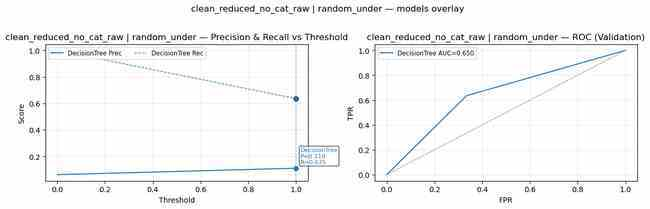


=== DecisionTree (max_f1=0.8) Summary ===


dataset         model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  DecisionTree    random_under      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8             1.0     0.1098    0.6351    0.1872    0.6503   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.1166     0.6588     0.1982     0.6674

  ➤ Running RandomForest with sampling=random_under ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: random_under
    RandomForest: thr=0.800 ValRec₁=0.398 ValPrec₁=0.319


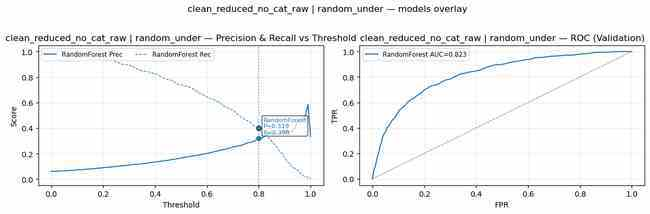


=== RandomForest (max_f1=0.8) Summary ===


dataset         model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  RandomForest    random_under      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8             0.8      0.319    0.3979    0.3541    0.8228   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.3287     0.4113     0.3654       0.82

  ➤ Running XGBoost with sampling=random_under ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: random_under
     XGB: thr=0.829  ValPrec₁=0.334  ValRec₁=0.458  AUC=0.827


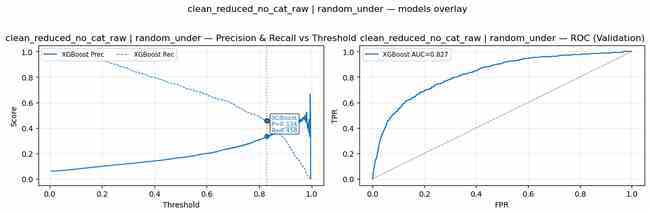


=== XGBoost (max_f1=0.8) Summary ===


dataset    model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  XGBoost    random_under      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8          0.8292     0.3338    0.4577    0.3861     0.827   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0       0.316     0.4186     0.3601     0.8185

  ➤ Running SVM with sampling=random_under ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: random_under
    SVM: thr=0.731  ValRec₁=0.439  ValPrec₁=0.340  ValROC₁=0.833


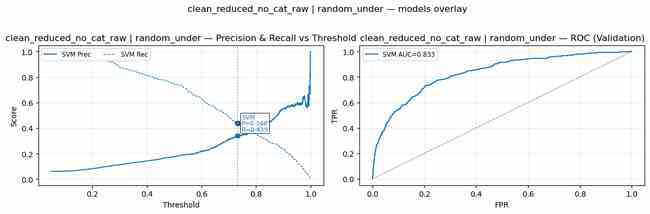


=== SVM (max_f1=0.8) Summary ===


dataset model sampling_method tuning_mode  tuning_target  \
0  clean_reduced_no_cat_raw   SVM    random_under      max_f1            0.8   

   threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  test_prec1  \
0           0.731     0.3397    0.4392    0.3831    0.8326      0.3292   

   test_rec1  test_f1_1  test_roc1  
0     0.4433     0.3779     0.8267

  ➤ Running LogisticPoly with sampling=random_under ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: random_under
    ➤ Degree 1
      deg=1: thr=0.708  ValRec₁=0.482  ValPrec₁=0.334
    ➤ Degree 2
      deg=2: thr=0.747  ValRec₁=0.480  ValPrec₁=0.337
    ➤ Degree 3
      deg=3: thr=0.816  ValRec₁=0.435  ValPrec₁=0.361


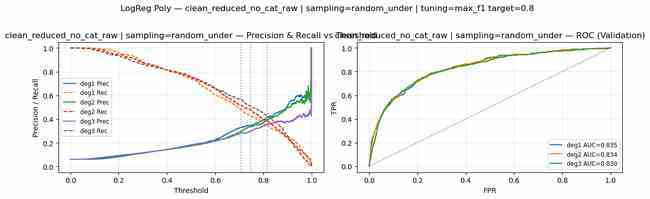


=== Logistic Regression Poly (max_f1=0.8) Summary ===


dataset                   model sampling_method  degree  \
0  clean_reduced_no_cat_raw  LogisticRegressionPoly    random_under       1   
1  clean_reduced_no_cat_raw  LogisticRegressionPoly    random_under       2   
2  clean_reduced_no_cat_raw  LogisticRegressionPoly    random_under       3   

  tuning_mode  tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  \
0      max_f1            0.8          0.7077     0.3338    0.4825    0.3946   
1      max_f1            0.8          0.7469     0.3372    0.4804    0.3963   
2      max_f1            0.8          0.8157     0.3607    0.4351    0.3944   

   val_roc1  test_prec1  test_rec1  test_f1_1  test_roc1  
0    0.8349      0.3191     0.4691     0.3798     0.8285  
1    0.8343      0.3185     0.4505     0.3732     0.8291  
2    0.8302      0.3316     0.3866     0.3570     0.8257

  ➤ Running KerasMLP with sampling=random_under ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: random_under
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
    KerasMLP: thr=0.752  ValRec₁=0.431  ValPrec₁=0.387  ValROC₁=0.838


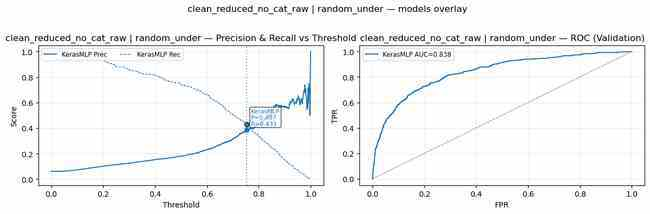


=== Keras MLP (max_f1=0.8) Summary ===


dataset     model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  KerasMLP    random_under      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8          0.7523      0.387    0.4309    0.4078    0.8385   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.3545     0.4031     0.3772     0.8325

  ➤ Running EnsembleSoft with sampling=random_under ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: random_under
    Trained LinearSVC_calib: thr=0.731 val_roc=0.833
    Trained XGBoost: thr=0.848 val_roc=0.830
    Trained LogisticRegression: thr=0.708 val_roc=0.835
    MLP failed: build_keras_mlp_5layer not found. Define it or replace with another builder.
    Ensemble(soft): thr=0.730  ValRec₁=0.487  ValPrec₁=0.341  ValROC₁=0.840


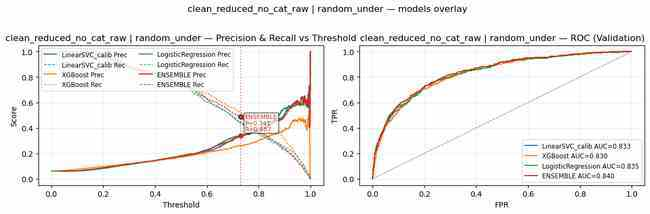


=== Ensemble (soft) Summary ===


dataset           model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  Ensemble[soft]    random_under      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8          0.7303     0.3405    0.4866    0.4007    0.8401   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0       0.321     0.4577     0.3774     0.8314

  ➤ Running EnsembleSerial with sampling=random_under ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: random_under
    ➤ Stage 1: svc
      Stage 1 svc: thr=0.731  new_pos_val=627  remaining_val=7327
    ➤ Stage 2: xgb
      Stage 2 xgb: thr=0.723  new_pos_val=990  remaining_val=6813
    ➤ Stage 3: logreg
      Stage 3 logreg: thr=0.415  new_pos_val=940  remaining_val=6272
    Serial ensemble final: ValRec₁=0.697 ValPrec₁=0.201 ValROC₁=0.758


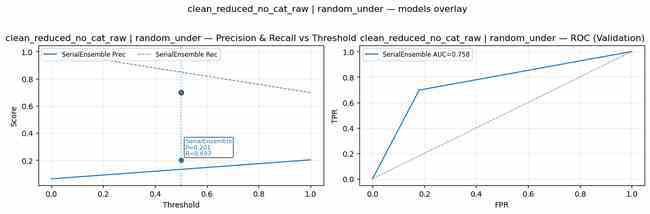


=== Serial Ensemble Summary ===


dataset           model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  SerialEnsemble    random_under      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8             0.5      0.201    0.6969     0.312    0.7585   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0       0.197     0.6732     0.3049     0.7475


=== Sampling method: random_over ===
  ➤ Running KNeighbors with sampling=random_over ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: random_over
    KNeighbors: thr=0.600 ValRec₁=0.462 ValPrec₁=0.199 ValAUC₁=0.712


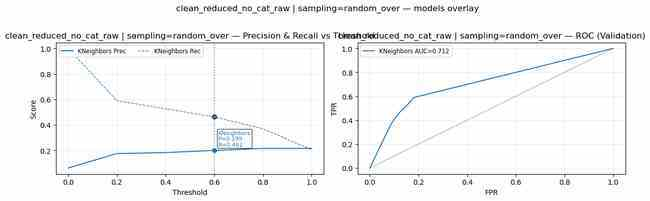


=== KNeighbors (max_f1=0.8) Summary ===


dataset       model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  KNeighbors     random_over      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8             0.6     0.1988    0.4619    0.2779    0.7123   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.1837     0.4381     0.2589     0.6864

  ➤ Running RadiusNeighbors with sampling=random_over ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: random_over
    RadiusNeighbors: thr=0.747 ValRec₁=0.285 ValPrec₁=0.283 ValAUC₁=0.616


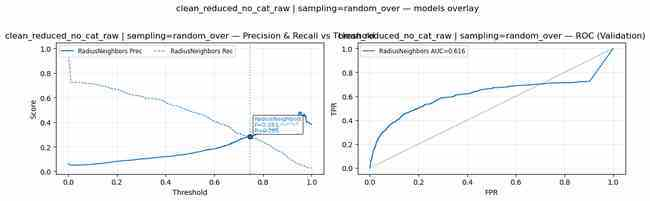


=== RadiusNeighbors (max_f1=0.8) Summary ===


dataset            model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  RadiusNeighbors     random_over      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8          0.7466     0.2834    0.2845     0.284    0.6164   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.2551     0.2722     0.2633     0.6288

  ➤ Running NearestCentroid with sampling=random_over ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: random_over
    NearestCentroid: thr=0.513 ValRec₁=0.522 ValPrec₁=0.305 ValAUC₁=0.814


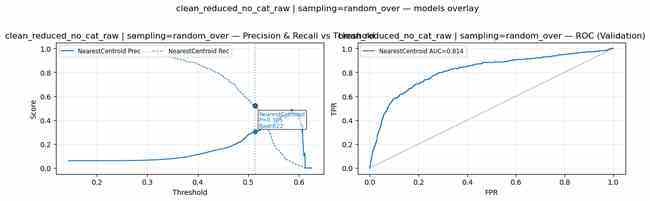


=== NearestCentroid (max_f1=0.8) Summary ===


dataset            model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  NearestCentroid     random_over      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8          0.5135     0.3048    0.5216    0.3848    0.8139   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.3043     0.4969     0.3774     0.8158

  ➤ Running DecisionTree with sampling=random_over ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: random_over
    DecisionTree: thr=1.000 ValRec₁=0.192 ValPrec₁=0.176


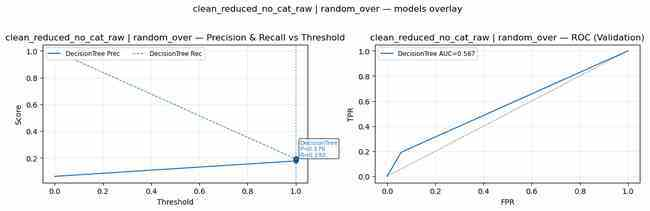


=== DecisionTree (max_f1=0.8) Summary ===


dataset         model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  DecisionTree     random_over      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8             1.0     0.1761    0.1918    0.1836    0.5668   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.1709      0.166     0.1684     0.5568

  ➤ Running RandomForest with sampling=random_over ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: random_over
    RandomForest: thr=0.250 ValRec₁=0.439 ValPrec₁=0.276


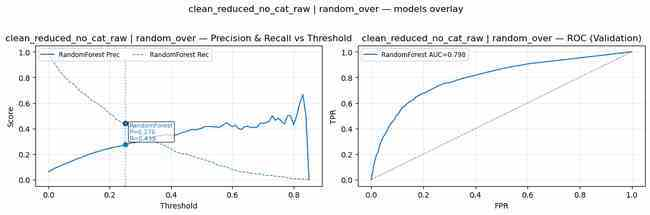


=== RandomForest (max_f1=0.8) Summary ===


dataset         model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  RandomForest     random_over      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8            0.25     0.2755    0.4392    0.3386    0.7977   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.2661     0.4052     0.3212     0.7944

  ➤ Running XGBoost with sampling=random_over ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: random_over
     XGB: thr=0.712  ValPrec₁=0.317  ValRec₁=0.414  AUC=0.822


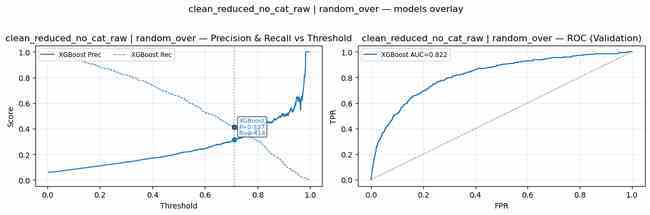


=== XGBoost (max_f1=0.8) Summary ===


dataset    model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  XGBoost     random_over      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8          0.7115      0.317    0.4144    0.3592    0.8218   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.3196     0.4082     0.3585     0.8144

  ➤ Running SVM with sampling=random_over ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: random_over
    SVM: thr=0.729  ValRec₁=0.458  ValPrec₁=0.331  ValROC₁=0.833


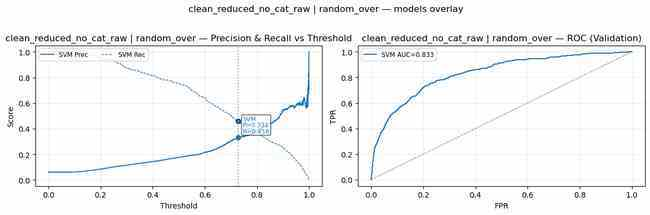


=== SVM (max_f1=0.8) Summary ===


dataset model sampling_method tuning_mode  tuning_target  \
0  clean_reduced_no_cat_raw   SVM     random_over      max_f1            0.8   

   threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  test_prec1  \
0          0.7285     0.3308    0.4577    0.3841    0.8329      0.3183   

   test_rec1  test_f1_1  test_roc1  
0     0.4526     0.3738     0.8273

  ➤ Running LogisticPoly with sampling=random_over ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: random_over
    ➤ Degree 1
      deg=1: thr=0.708  ValRec₁=0.495  ValPrec₁=0.333
    ➤ Degree 2
      deg=2: thr=0.784  ValRec₁=0.437  ValPrec₁=0.379
    ➤ Degree 3
      deg=3: thr=0.760  ValRec₁=0.464  ValPrec₁=0.345


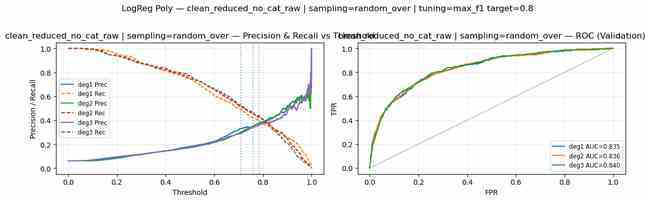


=== Logistic Regression Poly (max_f1=0.8) Summary ===


dataset                   model sampling_method  degree  \
0  clean_reduced_no_cat_raw  LogisticRegressionPoly     random_over       1   
2  clean_reduced_no_cat_raw  LogisticRegressionPoly     random_over       3   
1  clean_reduced_no_cat_raw  LogisticRegressionPoly     random_over       2   

  tuning_mode  tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  \
0      max_f1            0.8          0.7080     0.3329    0.4948    0.3980   
2      max_f1            0.8          0.7600     0.3451    0.4639    0.3958   
1      max_f1            0.8          0.7844     0.3792    0.4371    0.4061   

   val_roc1  test_prec1  test_rec1  test_f1_1  test_roc1  
0    0.8350      0.3147     0.4753     0.3786     0.8290  
2    0.8395      0.3258     0.4474     0.3771     0.8302  
1    0.8358      0.3482     0.4031     0.3736     0.8321

  ➤ Running KerasMLP with sampling=random_over ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: random_over
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step
    KerasMLP: thr=0.754  ValRec₁=0.441  ValPrec₁=0.339  ValROC₁=0.824


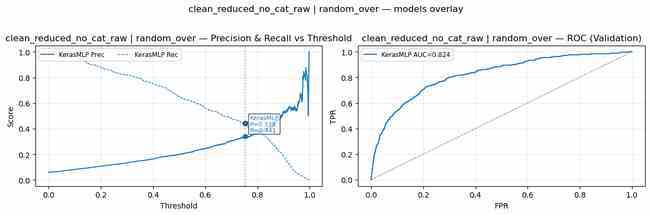


=== Keras MLP (max_f1=0.8) Summary ===


dataset     model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  KerasMLP     random_over      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8          0.7538     0.3386    0.4412    0.3832    0.8238   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.3333     0.4515     0.3835     0.8175

  ➤ Running EnsembleSoft with sampling=random_over ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: random_over
    Trained LinearSVC_calib: thr=0.729 val_roc=0.833
    Trained XGBoost: thr=0.748 val_roc=0.817
    Trained LogisticRegression: thr=0.708 val_roc=0.835
    MLP failed: build_keras_mlp_5layer not found. Define it or replace with another builder.
    Ensemble(soft): thr=0.705  ValRec₁=0.458  ValPrec₁=0.341  ValROC₁=0.837


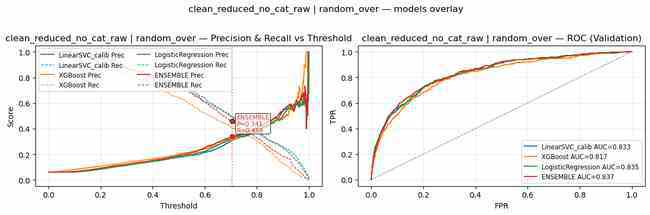


=== Ensemble (soft) Summary ===


dataset           model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  Ensemble[soft]     random_over      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8          0.7053      0.341    0.4577    0.3908    0.8372   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.3293     0.4454     0.3786     0.8298

  ➤ Running EnsembleSerial with sampling=random_over ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: random_over
    ➤ Stage 1: svc
      Stage 1 svc: thr=0.729  new_pos_val=671  remaining_val=7283
    ➤ Stage 2: xgb
      Stage 2 xgb: thr=0.507  new_pos_val=1077  remaining_val=6549
    ➤ Stage 3: logreg
      Stage 3 logreg: thr=0.179  new_pos_val=1035  remaining_val=5845
    Serial ensemble final: ValRec₁=0.701 ValPrec₁=0.161 ValROC₁=0.732


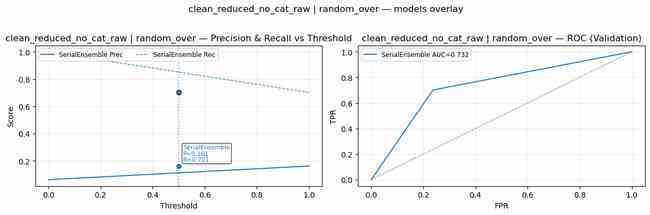


=== Serial Ensemble Summary ===


dataset           model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  SerialEnsemble     random_over      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8             0.5     0.1612     0.701    0.2621    0.7321   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.1584     0.6897     0.2577     0.7259


=== Sampling method: smote ===
  ➤ Running KNeighbors with sampling=smote ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    KNeighbors: thr=0.800 ValRec₁=0.419 ValPrec₁=0.185 ValAUC₁=0.713


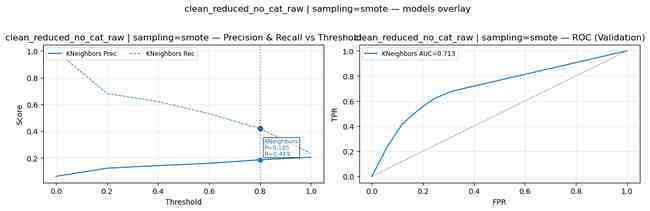


=== KNeighbors (max_f1=0.8) Summary ===


dataset       model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  KNeighbors           smote      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8             0.8     0.1847    0.4186    0.2563    0.7128   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0       0.181     0.4206     0.2531       0.71

  ➤ Running RadiusNeighbors with sampling=smote ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    RadiusNeighbors: thr=0.784 ValRec₁=0.285 ValPrec₁=0.303 ValAUC₁=0.641


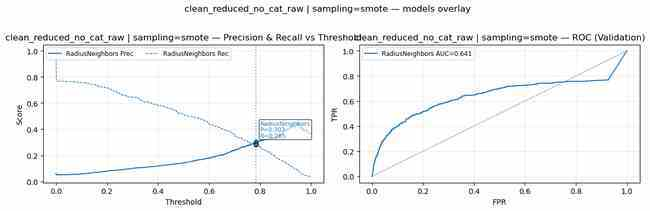


=== RadiusNeighbors (max_f1=0.8) Summary ===


dataset            model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  RadiusNeighbors           smote      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8          0.7841     0.3033    0.2845    0.2936    0.6413   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.2767     0.2887     0.2825     0.6649

  ➤ Running NearestCentroid with sampling=smote ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    NearestCentroid: thr=0.527 ValRec₁=0.454 ValPrec₁=0.333 ValAUC₁=0.814


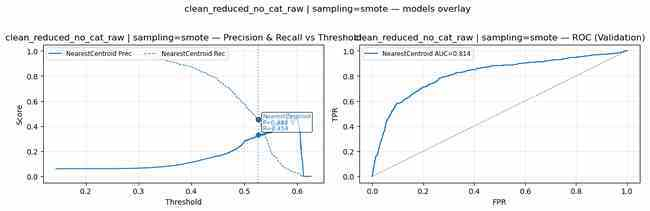


=== NearestCentroid (max_f1=0.8) Summary ===


dataset            model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  NearestCentroid           smote      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8           0.527     0.3328    0.4536    0.3839    0.8137   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.3147     0.4247     0.3616     0.8158

  ➤ Running DecisionTree with sampling=smote ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    DecisionTree: thr=1.000 ValRec₁=0.307 ValPrec₁=0.190


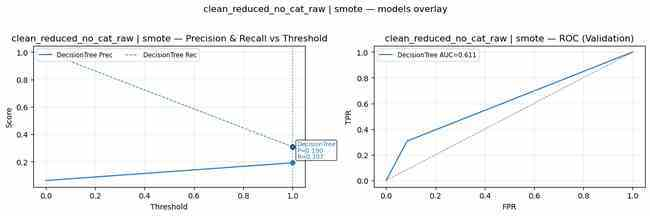


=== DecisionTree (max_f1=0.8) Summary ===


dataset         model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  DecisionTree           smote      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8             1.0     0.1903    0.3072     0.235    0.6112   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.1768     0.2928     0.2205     0.6021

  ➤ Running RandomForest with sampling=smote ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    RandomForest: thr=0.400 ValRec₁=0.410 ValPrec₁=0.256


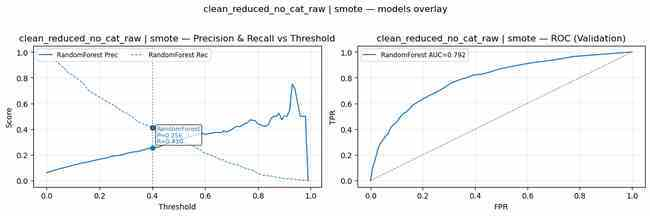


=== RandomForest (max_f1=0.8) Summary ===


dataset         model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  RandomForest           smote      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8             0.4     0.2564    0.4103    0.3156    0.7916   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.2634     0.4247     0.3252     0.8013

  ➤ Running XGBoost with sampling=smote ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
     XGB: thr=0.400  ValPrec₁=0.354  ValRec₁=0.365  AUC=0.816


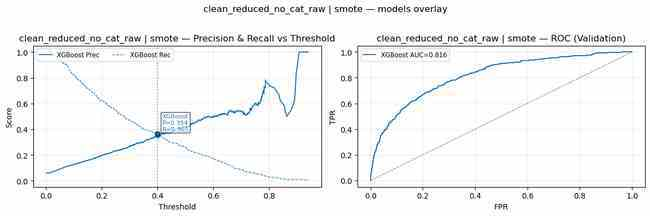


=== XGBoost (max_f1=0.8) Summary ===


dataset    model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  XGBoost           smote      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8          0.4002      0.354    0.3649    0.3594    0.8163   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.3528     0.3608     0.3568     0.8183

  ➤ Running SVM with sampling=smote ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    SVM: thr=0.727  ValRec₁=0.466  ValPrec₁=0.328  ValROC₁=0.832


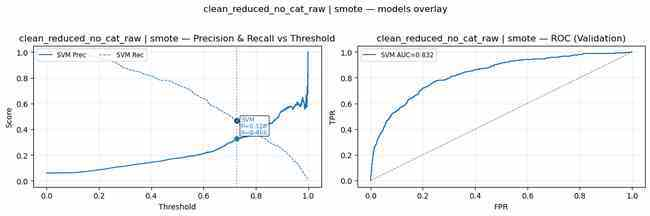


=== SVM (max_f1=0.8) Summary ===


dataset model sampling_method tuning_mode  tuning_target  \
0  clean_reduced_no_cat_raw   SVM           smote      max_f1            0.8   

   threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  test_prec1  \
0          0.7266     0.3285     0.466    0.3853    0.8318      0.3109   

   test_rec1  test_f1_1  test_roc1  
0     0.4567     0.3699     0.8265

  ➤ Running LogisticPoly with sampling=smote ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    ➤ Degree 1
      deg=1: thr=0.723  ValRec₁=0.472  ValPrec₁=0.337
    ➤ Degree 2
      deg=2: thr=0.794  ValRec₁=0.427  ValPrec₁=0.394
    ➤ Degree 3
      deg=3: thr=0.783  ValRec₁=0.435  ValPrec₁=0.353


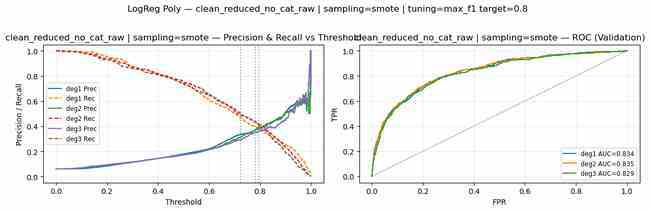


=== Logistic Regression Poly (max_f1=0.8) Summary ===


dataset                   model sampling_method  degree  \
0  clean_reduced_no_cat_raw  LogisticRegressionPoly           smote       1   
2  clean_reduced_no_cat_raw  LogisticRegressionPoly           smote       3   
1  clean_reduced_no_cat_raw  LogisticRegressionPoly           smote       2   

  tuning_mode  tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  \
0      max_f1            0.8          0.7231     0.3368    0.4722    0.3931   
2      max_f1            0.8          0.7826     0.3528    0.4351    0.3897   
1      max_f1            0.8          0.7936     0.3943    0.4268    0.4099   

   val_roc1  test_prec1  test_rec1  test_f1_1  test_roc1  
0    0.8341      0.3219     0.4546     0.3769     0.8284  
2    0.8287      0.3350     0.4082     0.3680     0.8239  
1    0.8349      0.3550     0.3887     0.3711     0.8292

  ➤ Running KerasMLP with sampling=smote ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
    KerasMLP: thr=0.813  ValRec₁=0.338  ValPrec₁=0.351  ValROC₁=0.801


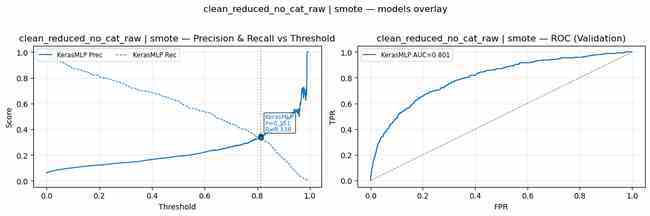


=== Keras MLP (max_f1=0.8) Summary ===


dataset     model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  KerasMLP           smote      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8           0.813     0.3512    0.3381    0.3445    0.8006   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0       0.332     0.3381      0.335     0.8001

  ➤ Running EnsembleSoft with sampling=smote ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    Trained LinearSVC_calib: thr=0.727 val_roc=0.832
    Trained XGBoost: thr=0.414 val_roc=0.812
    Trained LogisticRegression: thr=0.723 val_roc=0.834
    MLP failed: build_keras_mlp_5layer not found. Define it or replace with another builder.
    Ensemble(soft): thr=0.568  ValRec₁=0.507  ValPrec₁=0.315  ValROC₁=0.834


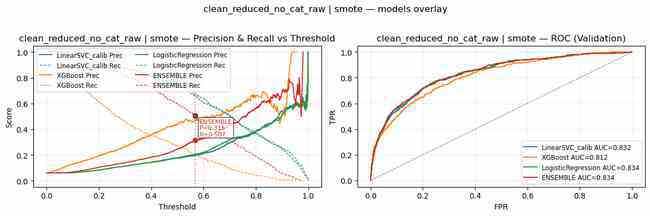


=== Ensemble (soft) Summary ===


dataset           model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  Ensemble[soft]           smote      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8          0.5678     0.3146    0.5072    0.3883    0.8341   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.3098     0.4928     0.3804     0.8313

  ➤ Running EnsembleSerial with sampling=smote ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    ➤ Stage 1: svc
      Stage 1 svc: thr=0.727  new_pos_val=688  remaining_val=7266
    ➤ Stage 2: xgb
      Stage 2 xgb: thr=0.130  new_pos_val=2603  remaining_val=5307
    ➤ Stage 3: logreg
      Stage 3 logreg: thr=0.021  new_pos_val=1152  remaining_val=4988
    Serial ensemble final: ValRec₁=0.816 ValPrec₁=0.134 ValROC₁=0.736


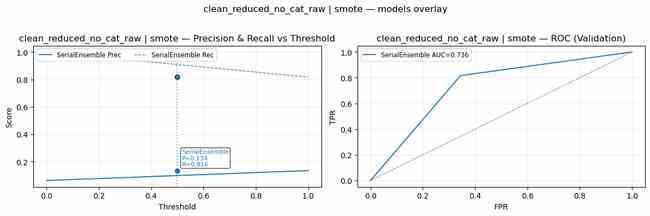


=== Serial Ensemble Summary ===


dataset           model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  SerialEnsemble           smote      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8             0.5     0.1335    0.8165    0.2295    0.7362   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.1343     0.8113     0.2305     0.7359


=== Sampling method: adasyn ===
  ➤ Running KNeighbors with sampling=adasyn ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: adasyn
    KNeighbors: thr=0.800 ValRec₁=0.423 ValPrec₁=0.173 ValAUC₁=0.714


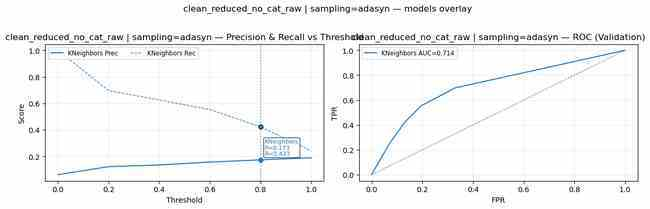


=== KNeighbors (max_f1=0.8) Summary ===


dataset       model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  KNeighbors          adasyn      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8             0.8      0.173    0.4227    0.2455    0.7137   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.1694     0.4227     0.2418     0.7065

  ➤ Running RadiusNeighbors with sampling=adasyn ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: adasyn
    RadiusNeighbors: thr=0.767 ValRec₁=0.315 ValPrec₁=0.282 ValAUC₁=0.641


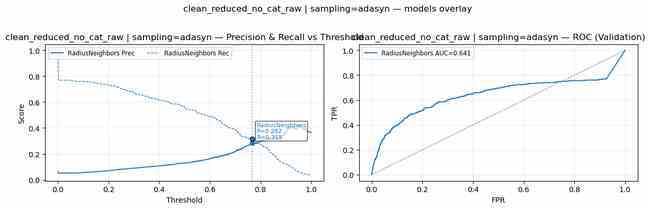


=== RadiusNeighbors (max_f1=0.8) Summary ===


dataset            model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  RadiusNeighbors          adasyn      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8          0.7674     0.2823    0.3155     0.298    0.6407   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.2481     0.3093     0.2754     0.6601

  ➤ Running NearestCentroid with sampling=adasyn ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: adasyn
    NearestCentroid: thr=0.522 ValRec₁=0.513 ValPrec₁=0.251 ValAUC₁=0.808


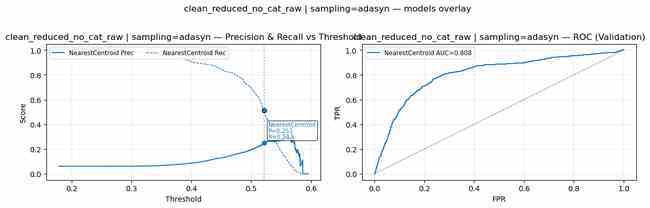


=== NearestCentroid (max_f1=0.8) Summary ===


dataset            model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  NearestCentroid          adasyn      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8          0.5216      0.251    0.5134    0.3372    0.8084   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0       0.251     0.4979     0.3338     0.8114

  ➤ Running DecisionTree with sampling=adasyn ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: adasyn
    DecisionTree: thr=1.000 ValRec₁=0.268 ValPrec₁=0.160


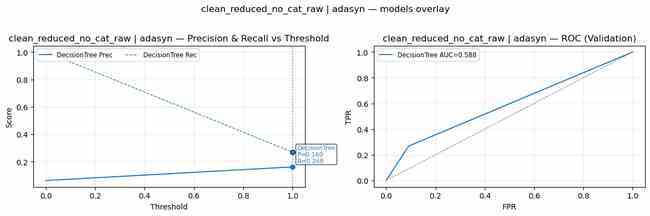


=== DecisionTree (max_f1=0.8) Summary ===


dataset         model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  DecisionTree          adasyn      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8             1.0     0.1603     0.268    0.2006    0.5884   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.1581     0.2639     0.1978     0.5863

  ➤ Running RandomForest with sampling=adasyn ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: adasyn
    RandomForest: thr=0.450 ValRec₁=0.365 ValPrec₁=0.281


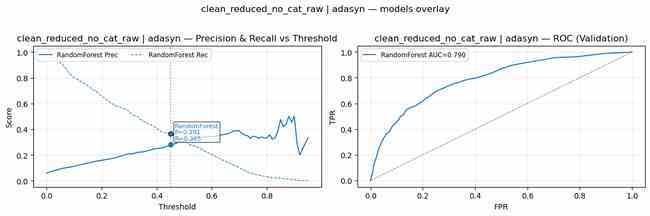


=== RandomForest (max_f1=0.8) Summary ===


dataset         model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  RandomForest          adasyn      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8            0.45     0.2805    0.3649    0.3172    0.7899   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0        0.27     0.3577     0.3078     0.7947

  ➤ Running XGBoost with sampling=adasyn ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: adasyn
     XGB: thr=0.351  ValPrec₁=0.296  ValRec₁=0.439  AUC=0.814


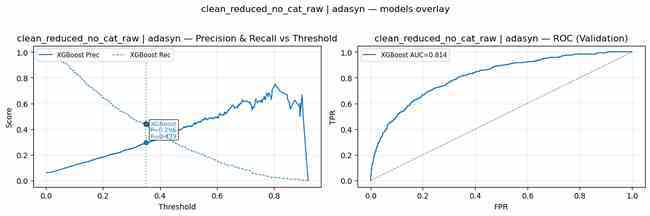


=== XGBoost (max_f1=0.8) Summary ===


dataset    model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  XGBoost          adasyn      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8          0.3507     0.2962    0.4392    0.3538    0.8136   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.3025     0.4289     0.3548     0.8165

  ➤ Running SVM with sampling=adasyn ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: adasyn
    SVM: thr=0.834  ValRec₁=0.332  ValPrec₁=0.434  ValROC₁=0.829


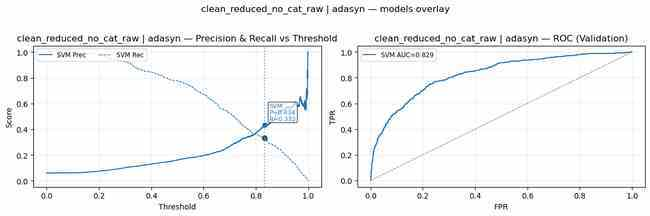


=== SVM (max_f1=0.8) Summary ===


dataset model sampling_method tuning_mode  tuning_target  \
0  clean_reduced_no_cat_raw   SVM          adasyn      max_f1            0.8   

   threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  test_prec1  \
0           0.834      0.434     0.332    0.3762    0.8293       0.405   

   test_rec1  test_f1_1  test_roc1  
0     0.3031     0.3467     0.8246

  ➤ Running LogisticPoly with sampling=adasyn ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: adasyn
    ➤ Degree 1
      deg=1: thr=0.736  ValRec₁=0.470  ValPrec₁=0.332
    ➤ Degree 2
      deg=2: thr=0.785  ValRec₁=0.443  ValPrec₁=0.366
    ➤ Degree 3
      deg=3: thr=0.767  ValRec₁=0.456  ValPrec₁=0.325


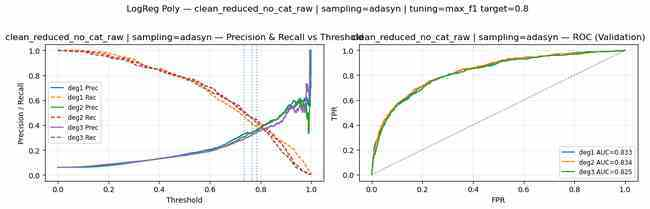


=== Logistic Regression Poly (max_f1=0.8) Summary ===


dataset                   model sampling_method  degree  \
0  clean_reduced_no_cat_raw  LogisticRegressionPoly          adasyn       1   
2  clean_reduced_no_cat_raw  LogisticRegressionPoly          adasyn       3   
1  clean_reduced_no_cat_raw  LogisticRegressionPoly          adasyn       2   

  tuning_mode  tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  \
0      max_f1            0.8          0.7365     0.3319    0.4701    0.3891   
2      max_f1            0.8          0.7669     0.3250    0.4557    0.3794   
1      max_f1            0.8          0.7854     0.3656    0.4433    0.4007   

   val_roc1  test_prec1  test_rec1  test_f1_1  test_roc1  
0    0.8325      0.3216     0.4608     0.3788     0.8271  
2    0.8254      0.3089     0.4351     0.3613     0.8219  
1    0.8340      0.3420     0.4072     0.3718     0.8268

  ➤ Running KerasMLP with sampling=adasyn ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: adasyn
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
    KerasMLP: thr=0.804  ValRec₁=0.355  ValPrec₁=0.351  ValROC₁=0.813


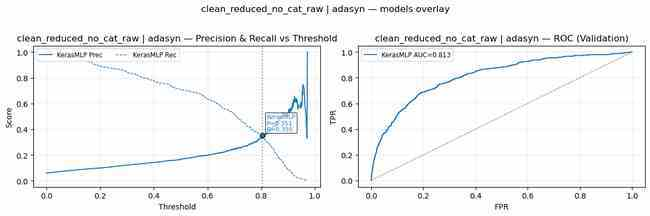


=== Keras MLP (max_f1=0.8) Summary ===


dataset     model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  KerasMLP          adasyn      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8          0.8043      0.351    0.3546    0.3528    0.8134   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.3506     0.3701     0.3601     0.8124

  ➤ Running EnsembleSoft with sampling=adasyn ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: adasyn
    Trained LinearSVC_calib: thr=0.834 val_roc=0.829
    Trained XGBoost: thr=0.387 val_roc=0.807
    Trained LogisticRegression: thr=0.736 val_roc=0.833
    MLP failed: build_keras_mlp_5layer not found. Define it or replace with another builder.
    Ensemble(soft): thr=0.585  ValRec₁=0.507  ValPrec₁=0.316  ValROC₁=0.832


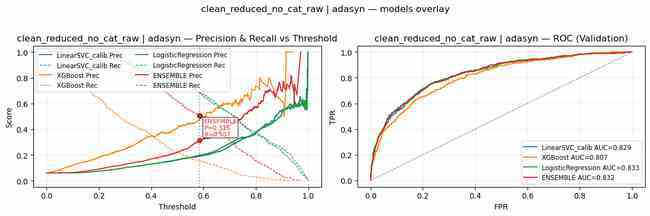


=== Ensemble (soft) Summary ===


dataset           model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  Ensemble[soft]          adasyn      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8          0.5849     0.3158    0.5072    0.3892     0.832   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.3125     0.4897     0.3815     0.8305

  ➤ Running EnsembleSerial with sampling=adasyn ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: adasyn
    ➤ Stage 1: svc
      Stage 1 svc: thr=0.834  new_pos_val=371  remaining_val=7583
    ➤ Stage 2: xgb
      Stage 2 xgb: thr=0.214  new_pos_val=1574  remaining_val=6336
    ➤ Stage 3: logreg
      Stage 3 logreg: thr=0.041  new_pos_val=1275  remaining_val=5806
    Serial ensemble final: ValRec₁=0.703 ValPrec₁=0.159 ValROC₁=0.731


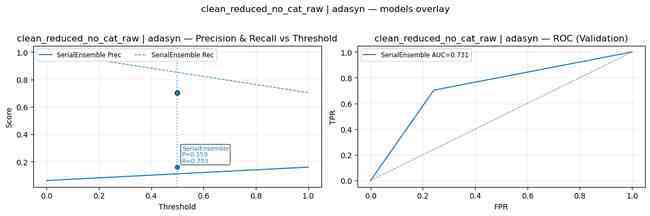


=== Serial Ensemble Summary ===


dataset           model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  SerialEnsemble          adasyn      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8             0.5     0.1588    0.7031     0.259    0.7306   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.1652     0.7309     0.2695     0.7456


=== Sampling method: smote_tomek ===
  ➤ Running KNeighbors with sampling=smote_tomek ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote_tomek
    KNeighbors: thr=0.800 ValRec₁=0.419 ValPrec₁=0.183 ValAUC₁=0.714


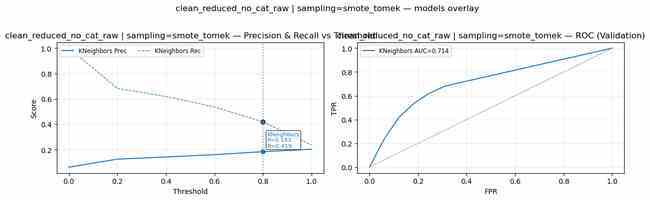


=== KNeighbors (max_f1=0.8) Summary ===


dataset       model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  KNeighbors     smote_tomek      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8             0.8      0.183    0.4186    0.2547    0.7145   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.1792     0.4216     0.2515     0.7104

  ➤ Running RadiusNeighbors with sampling=smote_tomek ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote_tomek
    RadiusNeighbors: thr=0.755 ValRec₁=0.313 ValPrec₁=0.283 ValAUC₁=0.641


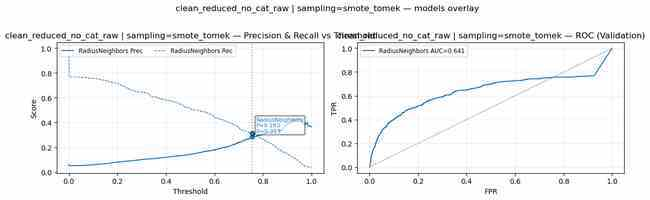


=== RadiusNeighbors (max_f1=0.8) Summary ===


dataset            model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  RadiusNeighbors     smote_tomek      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8          0.7547     0.2831    0.3134    0.2975    0.6413   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.2558     0.3082     0.2796      0.665

  ➤ Running NearestCentroid with sampling=smote_tomek ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote_tomek
    NearestCentroid: thr=0.527 ValRec₁=0.454 ValPrec₁=0.333 ValAUC₁=0.814


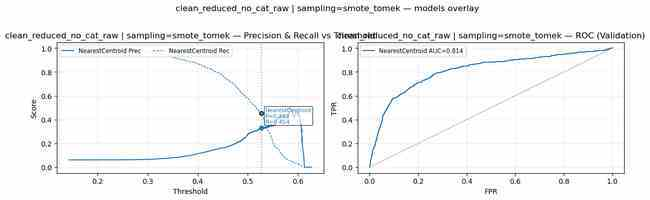


=== NearestCentroid (max_f1=0.8) Summary ===


dataset            model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  NearestCentroid     smote_tomek      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8          0.5272     0.3328    0.4536    0.3839    0.8137   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.3137     0.4216     0.3597     0.8159

  ➤ Running DecisionTree with sampling=smote_tomek ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote_tomek
    DecisionTree: thr=1.000 ValRec₁=0.291 ValPrec₁=0.177


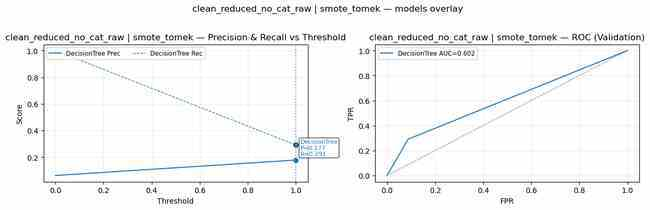


=== DecisionTree (max_f1=0.8) Summary ===


dataset         model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  DecisionTree     smote_tomek      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8             1.0     0.1771    0.2907    0.2201    0.6015   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.1701     0.2856     0.2132     0.5976

  ➤ Running RandomForest with sampling=smote_tomek ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote_tomek
    RandomForest: thr=0.530 ValRec₁=0.318 ValPrec₁=0.348


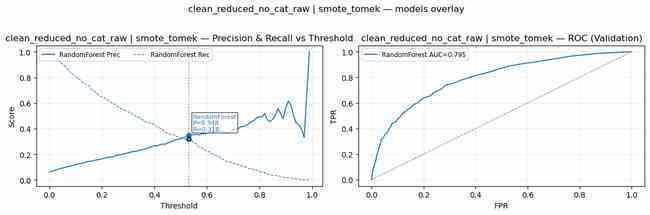


=== RandomForest (max_f1=0.8) Summary ===


dataset         model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  RandomForest     smote_tomek      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8            0.53     0.3484    0.3175    0.3323    0.7946   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.3078     0.2814      0.294      0.804

  ➤ Running XGBoost with sampling=smote_tomek ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote_tomek
     XGB: thr=0.324  ValPrec₁=0.301  ValRec₁=0.447  AUC=0.815


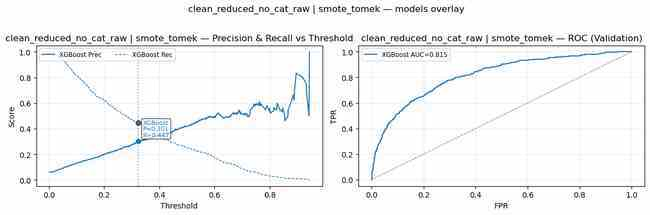


=== XGBoost (max_f1=0.8) Summary ===


dataset    model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  XGBoost     smote_tomek      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8          0.3242      0.301    0.4474    0.3599    0.8155   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.3072     0.4526      0.366     0.8182

  ➤ Running SVM with sampling=smote_tomek ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote_tomek
    SVM: thr=0.728  ValRec₁=0.466  ValPrec₁=0.327  ValROC₁=0.832


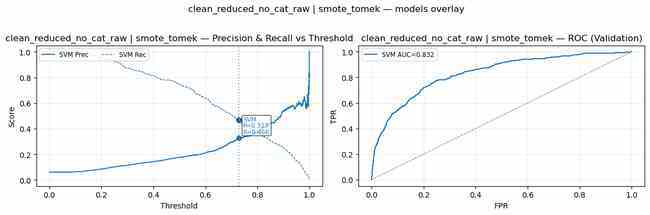


=== SVM (max_f1=0.8) Summary ===


dataset model sampling_method tuning_mode  tuning_target  \
0  clean_reduced_no_cat_raw   SVM     smote_tomek      max_f1            0.8   

   threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  test_prec1  \
0          0.7283     0.3271     0.466    0.3844    0.8319      0.3111   

   test_rec1  test_f1_1  test_roc1  
0     0.4567     0.3701     0.8266

  ➤ Running LogisticPoly with sampling=smote_tomek ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote_tomek
    ➤ Degree 1
      deg=1: thr=0.714  ValRec₁=0.487  ValPrec₁=0.331
    ➤ Degree 2
      deg=2: thr=0.796  ValRec₁=0.425  ValPrec₁=0.392
    ➤ Degree 3
      deg=3: thr=0.784  ValRec₁=0.435  ValPrec₁=0.352


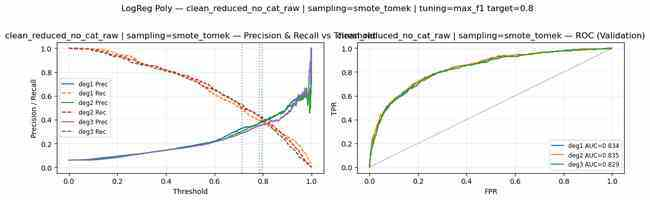


=== Logistic Regression Poly (max_f1=0.8) Summary ===


dataset                   model sampling_method  degree  \
0  clean_reduced_no_cat_raw  LogisticRegressionPoly     smote_tomek       1   
2  clean_reduced_no_cat_raw  LogisticRegressionPoly     smote_tomek       3   
1  clean_reduced_no_cat_raw  LogisticRegressionPoly     smote_tomek       2   

  tuning_mode  tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  \
0      max_f1            0.8          0.7144     0.3315    0.4866    0.3943   
2      max_f1            0.8          0.7840     0.3517    0.4351    0.3889   
1      max_f1            0.8          0.7956     0.3924    0.4247    0.4079   

   val_roc1  test_prec1  test_rec1  test_f1_1  test_roc1  
0    0.8341      0.3177     0.4742     0.3805     0.8284  
2    0.8286      0.3347     0.4093     0.3683     0.8234  
1    0.8349      0.3543     0.3887     0.3707     0.8292

  ➤ Running KerasMLP with sampling=smote_tomek ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote_tomek
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step
    KerasMLP: thr=0.799  ValRec₁=0.361  ValPrec₁=0.362  ValROC₁=0.811


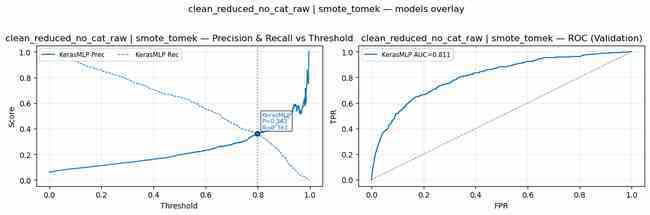


=== Keras MLP (max_f1=0.8) Summary ===


dataset     model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  KerasMLP     smote_tomek      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8          0.7988     0.3616    0.3608    0.3612    0.8107   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.3563     0.3732     0.3646     0.8098

  ➤ Running EnsembleSoft with sampling=smote_tomek ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote_tomek
    Trained LinearSVC_calib: thr=0.728 val_roc=0.832
    Trained XGBoost: thr=0.363 val_roc=0.811
    Trained LogisticRegression: thr=0.714 val_roc=0.834
    MLP failed: build_keras_mlp_5layer not found. Define it or replace with another builder.
    Ensemble(soft): thr=0.658  ValRec₁=0.386  ValPrec₁=0.396  ValROC₁=0.834


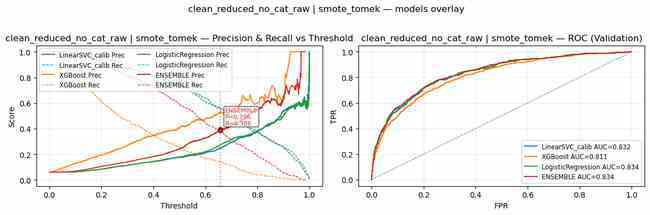


=== Ensemble (soft) Summary ===


dataset           model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  Ensemble[soft]     smote_tomek      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8          0.6585     0.3962    0.3856    0.3908    0.8341   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.3782     0.3649     0.3715     0.8311

  ➤ Running EnsembleSerial with sampling=smote_tomek ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote_tomek
    ➤ Stage 1: svc
      Stage 1 svc: thr=0.728  new_pos_val=691  remaining_val=7263
    ➤ Stage 2: xgb
      Stage 2 xgb: thr=0.199  new_pos_val=1580  remaining_val=6253
    ➤ Stage 3: logreg
      Stage 3 logreg: thr=0.037  new_pos_val=1145  remaining_val=5815
    Serial ensemble final: ValRec₁=0.732 ValPrec₁=0.166 ValROC₁=0.747


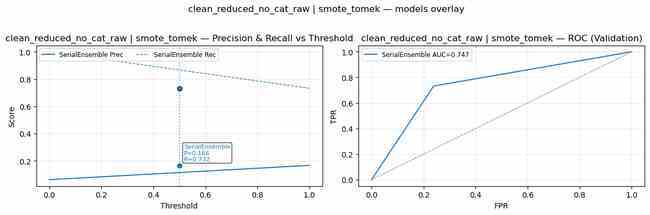


=== Serial Ensemble Summary ===


dataset           model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  SerialEnsemble     smote_tomek      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8             0.5      0.166     0.732    0.2706    0.7466   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0       0.167      0.733      0.272     0.7478


=== Sampling method: tomek ===
  ➤ Running KNeighbors with sampling=tomek ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: tomek
    KNeighbors: thr=0.400 ValRec₁=0.357 ValPrec₁=0.325 ValAUC₁=0.725


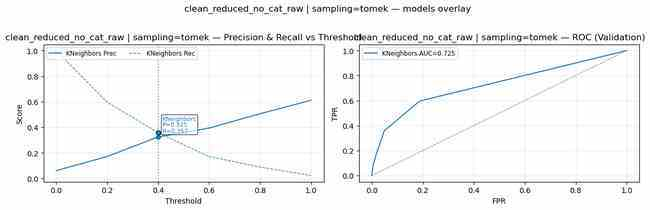


=== KNeighbors (max_f1=0.8) Summary ===


dataset       model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  KNeighbors           tomek      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8             0.4     0.3246    0.3567    0.3399    0.7247   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.2918     0.3402     0.3141     0.7021

  ➤ Running RadiusNeighbors with sampling=tomek ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: tomek
    RadiusNeighbors: thr=0.182 ValRec₁=0.282 ValPrec₁=0.295 ValAUC₁=0.617


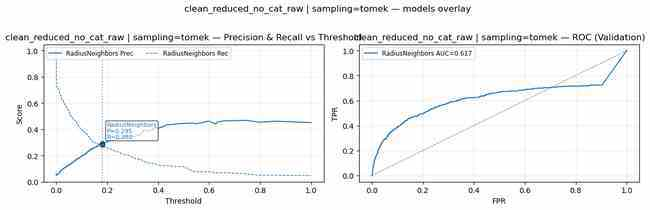


=== RadiusNeighbors (max_f1=0.8) Summary ===


dataset            model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  RadiusNeighbors           tomek      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8          0.1815     0.2953    0.2825    0.2887    0.6173   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.2613      0.268     0.2646     0.6295

  ➤ Running NearestCentroid with sampling=tomek ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: tomek
    NearestCentroid: thr=0.509 ValRec₁=0.538 ValPrec₁=0.298 ValAUC₁=0.814


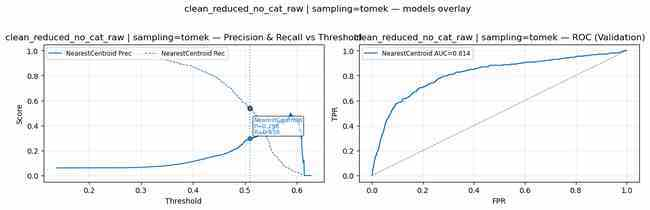


=== NearestCentroid (max_f1=0.8) Summary ===


dataset            model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  NearestCentroid           tomek      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8          0.5093     0.2976    0.5381    0.3833    0.8142   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.2942     0.5082     0.3726     0.8162

  ➤ Running DecisionTree with sampling=tomek ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: tomek
    DecisionTree: thr=1.000 ValRec₁=0.233 ValPrec₁=0.194


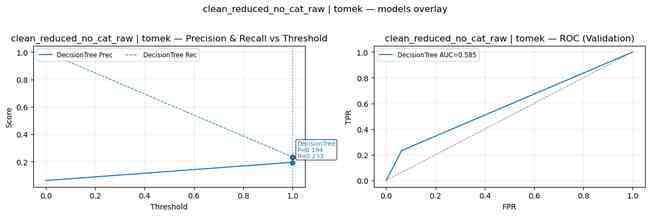


=== DecisionTree (max_f1=0.8) Summary ===


dataset         model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  DecisionTree           tomek      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8             1.0     0.1942     0.233    0.2118    0.5851   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.1944     0.2361     0.2132     0.5863

  ➤ Running RandomForest with sampling=tomek ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: tomek
    RandomForest: thr=0.230 ValRec₁=0.427 ValPrec₁=0.312


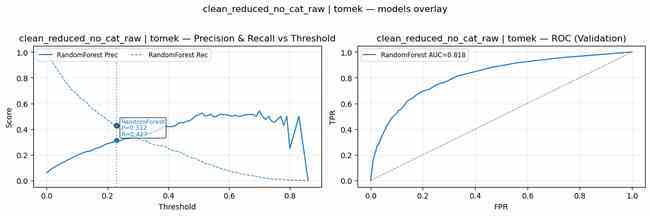


=== RandomForest (max_f1=0.8) Summary ===


dataset         model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  RandomForest           tomek      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8            0.23     0.3122    0.4268    0.3606    0.8176   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.3099     0.4309     0.3605     0.8065

  ➤ Running XGBoost with sampling=tomek ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: tomek
     XGB: thr=0.192  ValPrec₁=0.339  ValRec₁=0.476  AUC=0.836


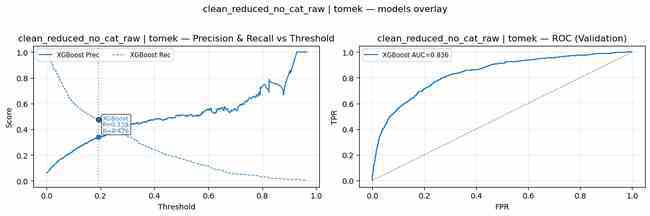


=== XGBoost (max_f1=0.8) Summary ===


dataset    model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  XGBoost           tomek      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8          0.1923     0.3392    0.4763    0.3962    0.8357   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.3222     0.4392     0.3717     0.8268

  ➤ Running SVM with sampling=tomek ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: tomek
    SVM: thr=0.115  ValRec₁=0.476  ValPrec₁=0.353  ValROC₁=0.837


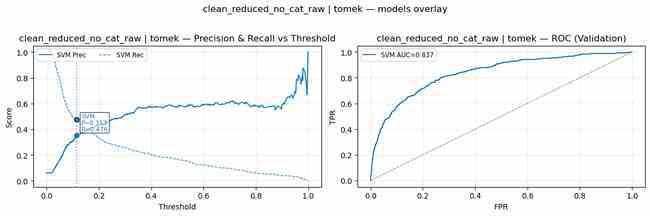


=== SVM (max_f1=0.8) Summary ===


dataset model sampling_method tuning_mode  tuning_target  \
0  clean_reduced_no_cat_raw   SVM           tomek      max_f1            0.8   

   threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  test_prec1  \
0          0.1154     0.3532    0.4763    0.4056    0.8374      0.3352   

   test_rec1  test_f1_1  test_roc1  
0     0.4433     0.3817     0.8315

  ➤ Running LogisticPoly with sampling=tomek ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: tomek
    ➤ Degree 1
      deg=1: thr=0.138  ValRec₁=0.482  ValPrec₁=0.326
    ➤ Degree 2
      deg=2: thr=0.173  ValRec₁=0.466  ValPrec₁=0.359
    ➤ Degree 3
      deg=3: thr=0.186  ValRec₁=0.472  ValPrec₁=0.359


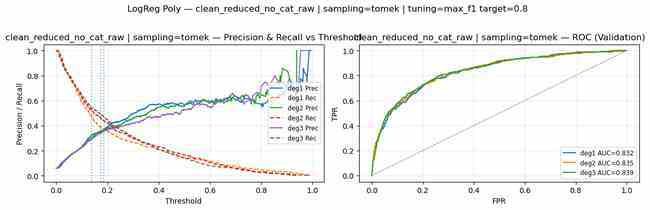


=== Logistic Regression Poly (max_f1=0.8) Summary ===


dataset                   model sampling_method  degree  \
0  clean_reduced_no_cat_raw  LogisticRegressionPoly           tomek       1   
2  clean_reduced_no_cat_raw  LogisticRegressionPoly           tomek       3   
1  clean_reduced_no_cat_raw  LogisticRegressionPoly           tomek       2   

  tuning_mode  tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  \
0      max_f1            0.8          0.1380     0.3264    0.4825    0.3894   
2      max_f1            0.8          0.1864     0.3589    0.4722    0.4078   
1      max_f1            0.8          0.1729     0.3587    0.4660    0.4054   

   val_roc1  test_prec1  test_rec1  test_f1_1  test_roc1  
0    0.8325      0.3095     0.4649     0.3717     0.8270  
2    0.8386      0.3279     0.4330     0.3732     0.8316  
1    0.8353      0.3341     0.4402     0.3799     0.8317

  ➤ Running KerasMLP with sampling=tomek ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: tomek
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step
    KerasMLP: thr=0.195  ValRec₁=0.454  ValPrec₁=0.357  ValROC₁=0.839


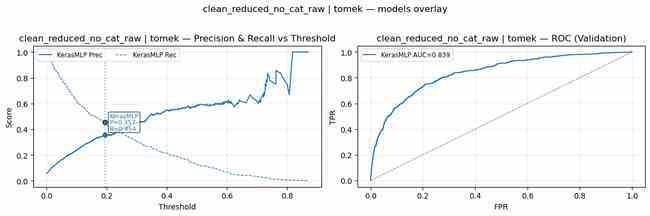


=== Keras MLP (max_f1=0.8) Summary ===


dataset     model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  KerasMLP           tomek      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8          0.1946     0.3571    0.4536    0.3996    0.8391   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.3436     0.4351      0.384     0.8351

  ➤ Running EnsembleSoft with sampling=tomek ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: tomek
    Trained LinearSVC_calib: thr=0.115 val_roc=0.837
    Trained XGBoost: thr=0.757 val_roc=0.815
    Trained LogisticRegression: thr=0.138 val_roc=0.832
    MLP failed: build_keras_mlp_5layer not found. Define it or replace with another builder.
    Ensemble(soft): thr=0.333  ValRec₁=0.462  ValPrec₁=0.357  ValROC₁=0.831


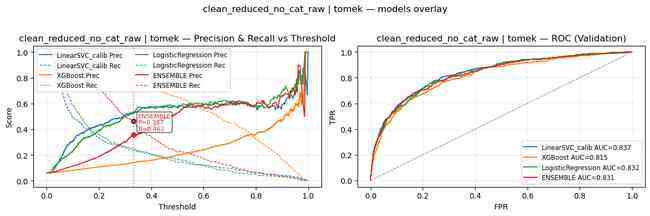


=== Ensemble (soft) Summary ===


dataset           model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  Ensemble[soft]           tomek      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8          0.3326     0.3573    0.4619    0.4029     0.831   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0       0.347     0.4278     0.3832     0.8276

  ➤ Running EnsembleSerial with sampling=tomek ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: tomek
    ➤ Stage 1: svc
      Stage 1 svc: thr=0.115  new_pos_val=654  remaining_val=7300
    ➤ Stage 2: xgb
      Stage 2 xgb: thr=0.528  new_pos_val=979  remaining_val=6595
    ➤ Stage 3: logreg
      Stage 3 logreg: thr=0.019  new_pos_val=601  remaining_val=6226
    Serial ensemble final: ValRec₁=0.691 ValPrec₁=0.194 ValROC₁=0.752


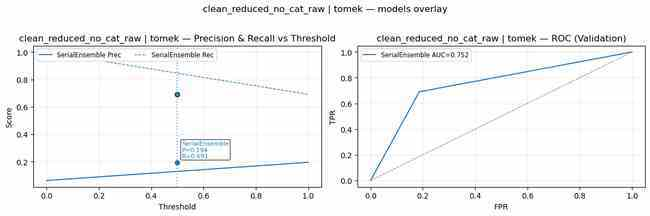


=== Serial Ensemble Summary ===


dataset           model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  SerialEnsemble           tomek      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8             0.5     0.1939    0.6907    0.3028    0.7521   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.1965     0.6804     0.3049     0.7499


=== Sampling method: enn ===
  ➤ Running KNeighbors with sampling=enn ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: enn
    KNeighbors: thr=0.600 ValRec₁=0.342 ValPrec₁=0.362 ValAUC₁=0.749


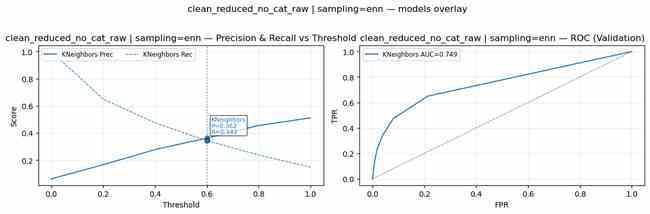


=== KNeighbors (max_f1=0.8) Summary ===


dataset       model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  KNeighbors             enn      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8             0.6     0.3617    0.3423    0.3517    0.7488   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.3408     0.3289     0.3347     0.7324

  ➤ Running RadiusNeighbors with sampling=enn ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: enn
    RadiusNeighbors: thr=0.216 ValRec₁=0.299 ValPrec₁=0.278 ValAUC₁=0.617


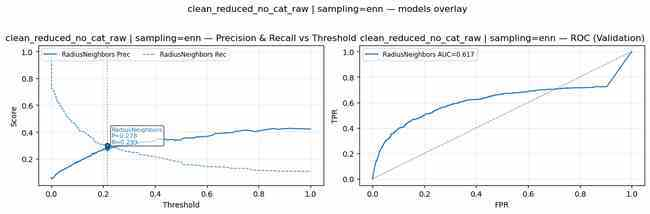


=== RadiusNeighbors (max_f1=0.8) Summary ===


dataset            model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  RadiusNeighbors             enn      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8           0.216     0.2783     0.299    0.2883    0.6171   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.2476     0.2918     0.2679     0.6301

  ➤ Running NearestCentroid with sampling=enn ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: enn
    NearestCentroid: thr=0.515 ValRec₁=0.540 ValPrec₁=0.296 ValAUC₁=0.816


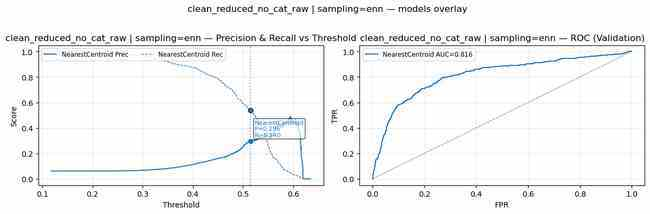


=== NearestCentroid (max_f1=0.8) Summary ===


dataset            model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  NearestCentroid             enn      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8          0.5146     0.2957    0.5402    0.3822    0.8158   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.2922     0.5082     0.3711     0.8175

  ➤ Running DecisionTree with sampling=enn ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: enn
    DecisionTree: thr=1.000 ValRec₁=0.390 ValPrec₁=0.232


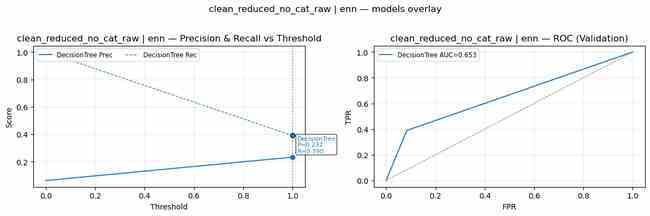


=== DecisionTree (max_f1=0.8) Summary ===


dataset         model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  DecisionTree             enn      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8             1.0     0.2316    0.3897    0.2905    0.6529   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.2165     0.3701     0.2732     0.6416

  ➤ Running RandomForest with sampling=enn ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: enn
    RandomForest: thr=0.340 ValRec₁=0.443 ValPrec₁=0.332


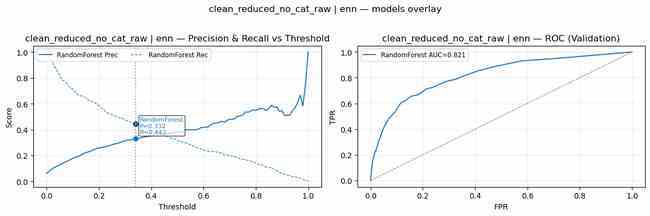


=== RandomForest (max_f1=0.8) Summary ===


dataset         model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  RandomForest             enn      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8            0.34     0.3323    0.4433    0.3799    0.8211   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.3181     0.4309      0.366     0.8083

  ➤ Running XGBoost with sampling=enn ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: enn
     XGB: thr=0.269  ValPrec₁=0.331  ValRec₁=0.489  AUC=0.835


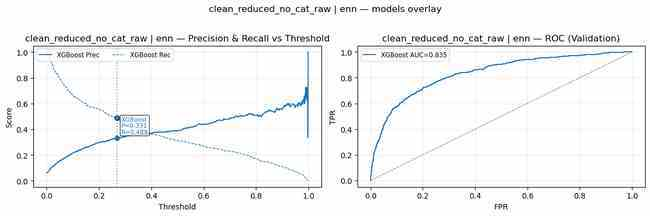


=== XGBoost (max_f1=0.8) Summary ===


dataset    model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  XGBoost             enn      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8          0.2686     0.3315    0.4887     0.395     0.835   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.3118     0.4588     0.3713     0.8279

  ➤ Running SVM with sampling=enn ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: enn
    SVM: thr=0.233  ValRec₁=0.458  ValPrec₁=0.363  ValROC₁=0.837


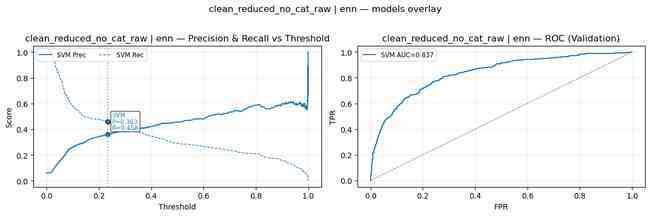


=== SVM (max_f1=0.8) Summary ===


dataset model sampling_method tuning_mode  tuning_target  \
0  clean_reduced_no_cat_raw   SVM             enn      max_f1            0.8   

   threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  test_prec1  \
0          0.2327     0.3627    0.4577    0.4047    0.8369      0.3386   

   test_rec1  test_f1_1  test_roc1  
0     0.4186     0.3744     0.8306

  ➤ Running LogisticPoly with sampling=enn ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: enn
    ➤ Degree 1
      deg=1: thr=0.277  ValRec₁=0.437  ValPrec₁=0.373
    ➤ Degree 2
      deg=2: thr=0.289  ValRec₁=0.458  ValPrec₁=0.375
    ➤ Degree 3
      deg=3: thr=0.216  ValRec₁=0.511  ValPrec₁=0.310


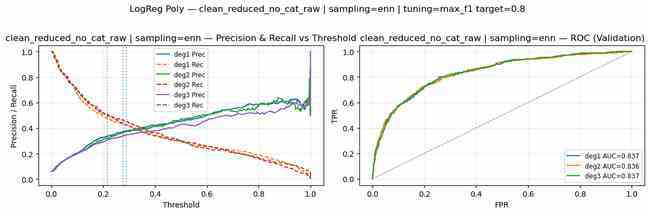


=== Logistic Regression Poly (max_f1=0.8) Summary ===


dataset                   model sampling_method  degree  \
2  clean_reduced_no_cat_raw  LogisticRegressionPoly             enn       3   
1  clean_reduced_no_cat_raw  LogisticRegressionPoly             enn       2   
0  clean_reduced_no_cat_raw  LogisticRegressionPoly             enn       1   

  tuning_mode  tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  \
2      max_f1            0.8          0.2162     0.3100    0.5113    0.3860   
1      max_f1            0.8          0.2893     0.3750    0.4577    0.4123   
0      max_f1            0.8          0.2774     0.3732    0.4371    0.4027   

   val_roc1  test_prec1  test_rec1  test_f1_1  test_roc1  
2    0.8367      0.3029     0.4990     0.3769     0.8312  
1    0.8363      0.3469     0.4227     0.3810     0.8323  
0    0.8370      0.3542     0.4082     0.3793     0.8305

  ➤ Running KerasMLP with sampling=enn ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: enn
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step
    KerasMLP: thr=0.252  ValRec₁=0.474  ValPrec₁=0.361  ValROC₁=0.841


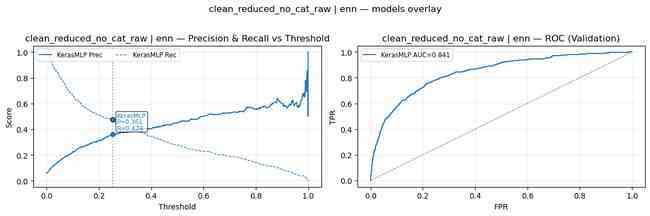


=== Keras MLP (max_f1=0.8) Summary ===


dataset     model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  KerasMLP             enn      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8          0.2523     0.3611    0.4742      0.41    0.8413   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.3414     0.4495     0.3881     0.8339

  ➤ Running EnsembleSoft with sampling=enn ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: enn
    Trained LinearSVC_calib: thr=0.233 val_roc=0.837
    Trained XGBoost: thr=0.836 val_roc=0.823
    Trained LogisticRegression: thr=0.277 val_roc=0.837
    MLP failed: build_keras_mlp_5layer not found. Define it or replace with another builder.
    Ensemble(soft): thr=0.435  ValRec₁=0.447  ValPrec₁=0.382  ValROC₁=0.838


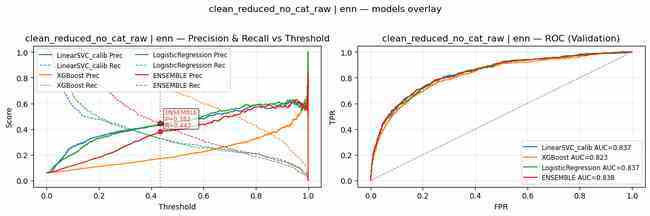


=== Ensemble (soft) Summary ===


dataset           model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  Ensemble[soft]             enn      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8           0.435      0.382    0.4474    0.4122    0.8379   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.3542     0.4082     0.3793     0.8291

  ➤ Running EnsembleSerial with sampling=enn ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: enn
    ➤ Stage 1: svc
      Stage 1 svc: thr=0.233  new_pos_val=612  remaining_val=7342
    ➤ Stage 2: xgb
      Stage 2 xgb: thr=0.539  new_pos_val=1173  remaining_val=6495
    ➤ Stage 3: logreg
      Stage 3 logreg: thr=0.016  new_pos_val=1447  remaining_val=5633
    Serial ensemble final: ValRec₁=0.759 ValPrec₁=0.159 ValROC₁=0.749


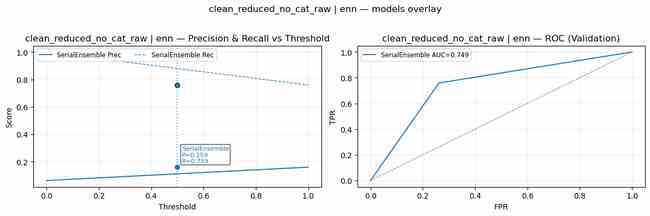


=== Serial Ensemble Summary ===


dataset           model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  SerialEnsemble             enn      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8             0.5     0.1586    0.7588    0.2623    0.7486   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.1581     0.7443     0.2607     0.7434


=== Combined results shape: (91, 15)
Top 5 by test recall:


dataset           model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  SerialEnsemble           smote      max_f1   
1  clean_reduced_no_cat_raw  SerialEnsemble             enn      max_f1   
2  clean_reduced_no_cat_raw  SerialEnsemble     smote_tomek      max_f1   
3  clean_reduced_no_cat_raw  SerialEnsemble          adasyn      max_f1   
4  clean_reduced_no_cat_raw  SerialEnsemble     random_over      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8             0.5     0.1335    0.8165    0.2295    0.7362   
1            0.8             0.5     0.1586    0.7588    0.2623    0.7486   
2            0.8             0.5     0.1660    0.7320    0.2706    0.7466   
3            0.8             0.5     0.1588    0.7031    0.2590    0.7306   
4            0.8             0.5     0.1612    0.7010    0.2621    0.7321   

   test_prec1  test_rec1  test_f1_1  test_roc1  degree  
0      0.1343     0.8113     0.2305     0.7359     NaN  
1      0.1581     0.7443     0.2607     0.7434     NaN  
2      0.1670     0.7330     0.2720     0.7478     NaN  
3      0.1652     0.7309     0.2695     0.7456     NaN  
4      0.1584     0.6897     0.2577     0.7259     NaN

Top 5 by test precision:


dataset                   model sampling_method  \
80  clean_reduced_no_cat_raw                     SVM          adasyn   
71  clean_reduced_no_cat_raw          Ensemble[soft]     smote_tomek   
68  clean_reduced_no_cat_raw                KerasMLP     smote_tomek   
65  clean_reduced_no_cat_raw  LogisticRegressionPoly           smote   
63  clean_reduced_no_cat_raw                KerasMLP    random_under   

   tuning_mode  tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  \
80      max_f1            0.8          0.8340     0.4340    0.3320    0.3762   
71      max_f1            0.8          0.6585     0.3962    0.3856    0.3908   
68      max_f1            0.8          0.7988     0.3616    0.3608    0.3612   
65      max_f1            0.8          0.7936     0.3943    0.4268    0.4099   
63      max_f1            0.8          0.7523     0.3870    0.4309    0.4078   

    val_roc1  test_prec1  test_rec1  test_f1_1  test_roc1  degree  
80    0.8293      0.4050     0.3031     0.3467     0.8246     NaN  
71    0.8341      0.3782     0.3649     0.3715     0.8311     NaN  
68    0.8107      0.3563     0.3732     0.3646     0.8098     NaN  
65    0.8349      0.3550     0.3887     0.3711     0.8292     2.0  
63    0.8385      0.3545     0.4031     0.3772     0.8325     NaN

Top 5 by test F1:


dataset           model sampling_method tuning_mode  \
31  clean_reduced_no_cat_raw        KerasMLP             enn      max_f1   
39  clean_reduced_no_cat_raw        KerasMLP           tomek      max_f1   
29  clean_reduced_no_cat_raw        KerasMLP     random_over      max_f1   
45  clean_reduced_no_cat_raw  Ensemble[soft]           tomek      max_f1   
34  clean_reduced_no_cat_raw             SVM           tomek      max_f1   

    tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
31            0.8          0.2523     0.3611    0.4742    0.4100    0.8413   
39            0.8          0.1946     0.3571    0.4536    0.3996    0.8391   
29            0.8          0.7538     0.3386    0.4412    0.3832    0.8238   
45            0.8          0.3326     0.3573    0.4619    0.4029    0.8310   
34            0.8          0.1154     0.3532    0.4763    0.4056    0.8374   

    test_prec1  test_rec1  test_f1_1  test_roc1  degree  
31      0.3414     0.4495     0.3881     0.8339     NaN  
39      0.3436     0.4351     0.3840     0.8351     NaN  
29      0.3333     0.4515     0.3835     0.8175     NaN  
45      0.3470     0.4278     0.3832     0.8276     NaN  
34      0.3352     0.4433     0.3817     0.8315     NaN

In [266]:
datasets_single = {"clean_reduced_no_cat_raw": clean_reduced_no_cat_raw}

df_all, top5, stores = orchestrate_resample_model_sweep(
    datasets=datasets_single,
    sampling_methods=("random_under","random_over","smote","adasyn","smote_tomek","tomek","enn"),
    models_to_run=("KNeighbors","RadiusNeighbors","NearestCentroid","DecisionTree",
                   "RandomForest","XGBoost","SVM","LogisticPoly","KerasMLP","EnsembleSoft","EnsembleSerial"),
    tuning_mode="max_f1",
    tuning_target=0.8,
    val_size=0.1,
    test_size=0.2,
    show_plot=True,   # change True if you want plots for each run (will be noisy)
    min_threshold=0.1  # ignore degenerate rows with threshold < 0.1
)

### Run all models against clean_reduced_no_cat_rawwith SMOTE threshold tuing on F1


=== Sampling method: smote ===
  ➤ Running KNeighbors with sampling=smote ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    KNeighbors: thr=0.800 ValRec₁=0.419 ValPrec₁=0.185 ValAUC₁=0.713


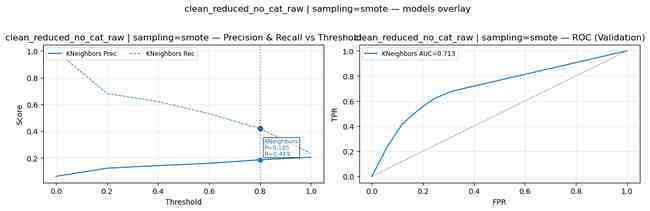


=== KNeighbors (max_f1=0.8) Summary ===


dataset       model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  KNeighbors           smote      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8             0.8     0.1847    0.4186    0.2563    0.7128   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0       0.181     0.4206     0.2531       0.71

  ➤ Running RadiusNeighbors with sampling=smote ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    RadiusNeighbors: thr=0.784 ValRec₁=0.285 ValPrec₁=0.303 ValAUC₁=0.641


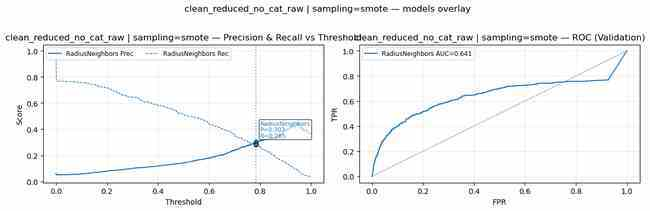


=== RadiusNeighbors (max_f1=0.8) Summary ===


dataset            model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  RadiusNeighbors           smote      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8          0.7841     0.3033    0.2845    0.2936    0.6413   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.2767     0.2887     0.2825     0.6649

  ➤ Running NearestCentroid with sampling=smote ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    NearestCentroid: thr=0.527 ValRec₁=0.454 ValPrec₁=0.333 ValAUC₁=0.814


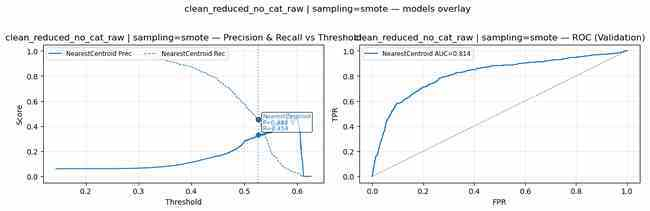


=== NearestCentroid (max_f1=0.8) Summary ===


dataset            model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  NearestCentroid           smote      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8           0.527     0.3328    0.4536    0.3839    0.8137   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.3147     0.4247     0.3616     0.8158

  ➤ Running DecisionTree with sampling=smote ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    DecisionTree: thr=1.000 ValRec₁=0.307 ValPrec₁=0.190


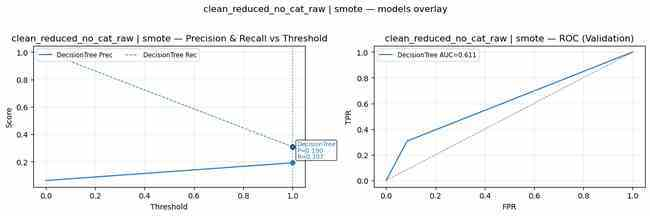


=== DecisionTree (max_f1=0.8) Summary ===


dataset         model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  DecisionTree           smote      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8             1.0     0.1903    0.3072     0.235    0.6112   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.1768     0.2928     0.2205     0.6021

  ➤ Running RandomForest with sampling=smote ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    RandomForest: thr=0.400 ValRec₁=0.410 ValPrec₁=0.256


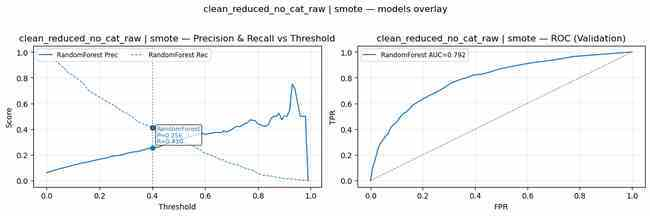


=== RandomForest (max_f1=0.8) Summary ===


dataset         model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  RandomForest           smote      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8             0.4     0.2564    0.4103    0.3156    0.7916   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.2634     0.4247     0.3252     0.8013

  ➤ Running XGBoost with sampling=smote ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
     XGB: thr=0.400  ValPrec₁=0.354  ValRec₁=0.365  AUC=0.816


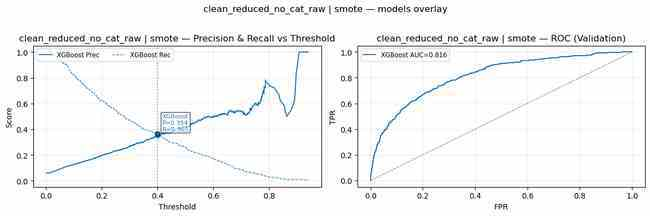


=== XGBoost (max_f1=0.8) Summary ===


dataset    model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  XGBoost           smote      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8          0.4002      0.354    0.3649    0.3594    0.8163   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.3528     0.3608     0.3568     0.8183

  ➤ Running SVM with sampling=smote ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    SVM: thr=0.727  ValRec₁=0.466  ValPrec₁=0.328  ValROC₁=0.832


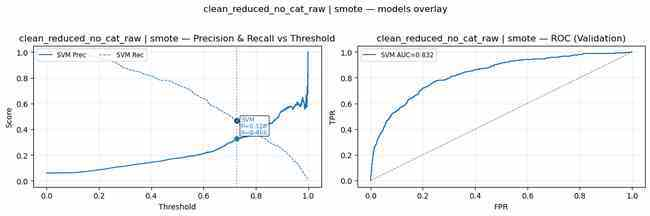


=== SVM (max_f1=0.8) Summary ===


dataset model sampling_method tuning_mode  tuning_target  \
0  clean_reduced_no_cat_raw   SVM           smote      max_f1            0.8   

   threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  test_prec1  \
0          0.7266     0.3285     0.466    0.3853    0.8318      0.3109   

   test_rec1  test_f1_1  test_roc1  
0     0.4567     0.3699     0.8265

  ➤ Running LogisticPoly with sampling=smote ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    ➤ Degree 1
      deg=1: thr=0.723  ValRec₁=0.472  ValPrec₁=0.337
    ➤ Degree 2
      deg=2: thr=0.794  ValRec₁=0.427  ValPrec₁=0.394
    ➤ Degree 3
      deg=3: thr=0.783  ValRec₁=0.435  ValPrec₁=0.353


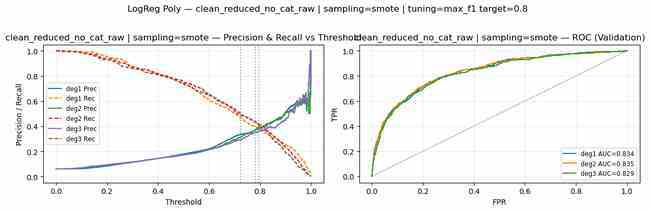


=== Logistic Regression Poly (max_f1=0.8) Summary ===


dataset                   model sampling_method  degree  \
0  clean_reduced_no_cat_raw  LogisticRegressionPoly           smote       1   
2  clean_reduced_no_cat_raw  LogisticRegressionPoly           smote       3   
1  clean_reduced_no_cat_raw  LogisticRegressionPoly           smote       2   

  tuning_mode  tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  \
0      max_f1            0.8          0.7231     0.3368    0.4722    0.3931   
2      max_f1            0.8          0.7826     0.3528    0.4351    0.3897   
1      max_f1            0.8          0.7936     0.3943    0.4268    0.4099   

   val_roc1  test_prec1  test_rec1  test_f1_1  test_roc1  
0    0.8341      0.3219     0.4546     0.3769     0.8284  
2    0.8287      0.3350     0.4082     0.3680     0.8239  
1    0.8349      0.3550     0.3887     0.3711     0.8292

  ➤ Running KerasMLP with sampling=smote ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
    KerasMLP: thr=0.731  ValRec₁=0.357  ValPrec₁=0.310  ValROC₁=0.781


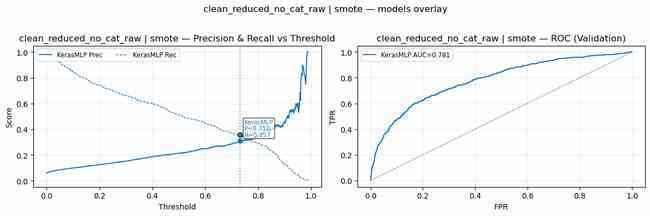


=== Keras MLP (max_f1=0.8) Summary ===


dataset     model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  KerasMLP           smote      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8           0.731       0.31    0.3567    0.3317    0.7815   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.3046     0.3711     0.3346     0.7859

  ➤ Running EnsembleSoft with sampling=smote ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    Trained LinearSVC_calib: thr=0.727 val_roc=0.832
    Trained XGBoost: thr=0.414 val_roc=0.812
    Trained LogisticRegression: thr=0.723 val_roc=0.834
    MLP failed: build_keras_mlp_5layer not found. Define it or replace with another builder.
    Ensemble(soft): thr=0.568  ValRec₁=0.507  ValPrec₁=0.315  ValROC₁=0.834


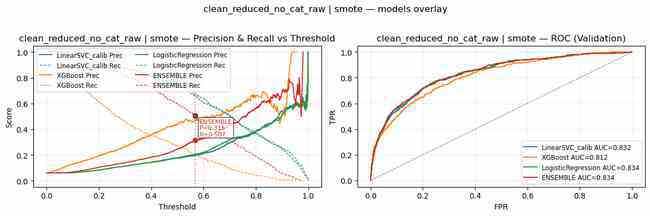


=== Ensemble (soft) Summary ===


dataset           model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  Ensemble[soft]           smote      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8          0.5678     0.3146    0.5072    0.3883    0.8341   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.3098     0.4928     0.3804     0.8313

  ➤ Running EnsembleSerial with sampling=smote ...

 Dataset: clean_reduced_no_cat_raw
Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
  ◦ Sampling: smote
    ➤ Stage 1: svc
      Stage 1 svc: thr=0.727  new_pos_val=688  remaining_val=7266
    ➤ Stage 2: xgb
      Stage 2 xgb: thr=0.130  new_pos_val=2603  remaining_val=5307
    ➤ Stage 3: logreg
      Stage 3 logreg: thr=0.021  new_pos_val=1152  remaining_val=4988
    Serial ensemble final: ValRec₁=0.816 ValPrec₁=0.134 ValROC₁=0.736


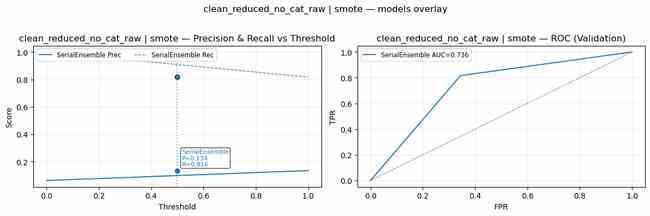


=== Serial Ensemble Summary ===


dataset           model sampling_method tuning_mode  \
0  clean_reduced_no_cat_raw  SerialEnsemble           smote      max_f1   

   tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  val_roc1  \
0            0.8             0.5     0.1335    0.8165    0.2295    0.7362   

   test_prec1  test_rec1  test_f1_1  test_roc1  
0      0.1343     0.8113     0.2305     0.7359


=== Combined results shape: (13, 15)
Top 5 by test recall:


dataset                   model sampling_method  \
0  clean_reduced_no_cat_raw          SerialEnsemble           smote   
1  clean_reduced_no_cat_raw          Ensemble[soft]           smote   
2  clean_reduced_no_cat_raw                     SVM           smote   
3  clean_reduced_no_cat_raw  LogisticRegressionPoly           smote   
4  clean_reduced_no_cat_raw         NearestCentroid           smote   

  tuning_mode  tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  \
0      max_f1            0.8          0.5000     0.1335    0.8165    0.2295   
1      max_f1            0.8          0.5678     0.3146    0.5072    0.3883   
2      max_f1            0.8          0.7266     0.3285    0.4660    0.3853   
3      max_f1            0.8          0.7231     0.3368    0.4722    0.3931   
4      max_f1            0.8          0.5270     0.3328    0.4536    0.3839   

   val_roc1  test_prec1  test_rec1  test_f1_1  test_roc1  degree  
0    0.7362      0.1343     0.8113     0.2305     0.7359     NaN  
1    0.8341      0.3098     0.4928     0.3804     0.8313     NaN  
2    0.8318      0.3109     0.4567     0.3699     0.8265     NaN  
3    0.8341      0.3219     0.4546     0.3769     0.8284     1.0  
4    0.8137      0.3147     0.4247     0.3616     0.8158     NaN

Top 5 by test precision:


dataset                   model sampling_method  \
8   clean_reduced_no_cat_raw  LogisticRegressionPoly           smote   
10  clean_reduced_no_cat_raw                 XGBoost           smote   
7   clean_reduced_no_cat_raw  LogisticRegressionPoly           smote   
3   clean_reduced_no_cat_raw  LogisticRegressionPoly           smote   
4   clean_reduced_no_cat_raw         NearestCentroid           smote   

   tuning_mode  tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  \
8       max_f1            0.8          0.7936     0.3943    0.4268    0.4099   
10      max_f1            0.8          0.4002     0.3540    0.3649    0.3594   
7       max_f1            0.8          0.7826     0.3528    0.4351    0.3897   
3       max_f1            0.8          0.7231     0.3368    0.4722    0.3931   
4       max_f1            0.8          0.5270     0.3328    0.4536    0.3839   

    val_roc1  test_prec1  test_rec1  test_f1_1  test_roc1  degree  
8     0.8349      0.3550     0.3887     0.3711     0.8292     2.0  
10    0.8163      0.3528     0.3608     0.3568     0.8183     NaN  
7     0.8287      0.3350     0.4082     0.3680     0.8239     3.0  
3     0.8341      0.3219     0.4546     0.3769     0.8284     1.0  
4     0.8137      0.3147     0.4247     0.3616     0.8158     NaN

Top 5 by test F1:


dataset                   model sampling_method  \
1  clean_reduced_no_cat_raw          Ensemble[soft]           smote   
3  clean_reduced_no_cat_raw  LogisticRegressionPoly           smote   
8  clean_reduced_no_cat_raw  LogisticRegressionPoly           smote   
2  clean_reduced_no_cat_raw                     SVM           smote   
7  clean_reduced_no_cat_raw  LogisticRegressionPoly           smote   

  tuning_mode  tuning_target  threshold_used  val_prec1  val_rec1  val_f1_1  \
1      max_f1            0.8          0.5678     0.3146    0.5072    0.3883   
3      max_f1            0.8          0.7231     0.3368    0.4722    0.3931   
8      max_f1            0.8          0.7936     0.3943    0.4268    0.4099   
2      max_f1            0.8          0.7266     0.3285    0.4660    0.3853   
7      max_f1            0.8          0.7826     0.3528    0.4351    0.3897   

   val_roc1  test_prec1  test_rec1  test_f1_1  test_roc1  degree  
1    0.8341      0.3098     0.4928     0.3804     0.8313     NaN  
3    0.8341      0.3219     0.4546     0.3769     0.8284     1.0  
8    0.8349      0.3550     0.3887     0.3711     0.8292     2.0  
2    0.8318      0.3109     0.4567     0.3699     0.8265     NaN  
7    0.8287      0.3350     0.4082     0.3680     0.8239     3.0

In [267]:
datasets_single = {"clean_reduced_no_cat_raw": clean_reduced_no_cat_raw}

df_all, top5, stores = orchestrate_resample_model_sweep(
    datasets=datasets_single,
    sampling_methods=["smote"],
    models_to_run=("KNeighbors","RadiusNeighbors","NearestCentroid","DecisionTree",
                   "RandomForest","XGBoost","SVM","LogisticPoly","KerasMLP","EnsembleSoft","EnsembleSerial"),
    tuning_mode="max_f1",
    tuning_target=0.8,
    val_size=0.1,
    test_size=0.2,
    show_plot=True,   # change True if you want plots for each run (will be noisy)
    min_threshold=0.1  # ignore degenerate rows with threshold < 0.1
)

## Final Model Selection: Serial Ensemble

During the experimentation phase, we evaluated a diverse set of model families:
- Distance-based models (KNN, Radius Neighbors, Nearest Centroid)
- Tree-based models (Decision Tree, Random Forest)
- Gradient-boosted ensembles (XGBoost)
- Linear and Polynomial Logistic Regression models
- Support Vector Machines (Linear and Kernel-based)
- Neural Networks (Keras MLP)
- Voting and Weighted Soft Ensembles

Each model was trained under the same pipeline for:
1. Consistent data preprocessing (encoding + scaling)
2. Class imbalance handling (SMOTE, ADASYN, random sampling, VAE synthesis)
3. Validation-based threshold optimization (to target recall / precision / max-F1)
4. Unified performance reporting across Train / Validation / Test splits

### Why We Selected the Serial Ensemble

The **Serial Ensemble** was chosen as the final deployment model because:
- It **cascades multiple models in sequence**, allowing each model to specialize in different regions of the feature space.
- Earlier models identify and remove “clear positives,” while later models focus on **hard-to-classify** samples.
- This approach improved **minority-class recall** while keeping false alarms controlled.
- It demonstrated **more stable performance across datasets** compared to any single model or simple voting ensemble.
- The design supports **transparency**, since we can trace:
  - which stage flagged each prediction
  - thresholds applied at each stage
  - how many samples were captured per model stage

### Deployment Preparation Using Model Bundles

To make the Serial Ensemble **reusable outside the notebook**, we export all required components into a **deployment bundle**, including:
- The **exact feature names and column order**
- The **scaler** used during training (if applied)
- Each **trained model stage**, saved as `stage_*.joblib`
- Optional per-stage **decision thresholds**
- Metadata (`meta.json`) describing the ensemble

This ensures predictions remain **consistent and reproducible**, even when deployed to a different system.


## Export Final Serial Ensemble Bundle for Deployment

Now that the Serial Ensemble (with SMOTE resampling) has been selected as the final model, we export it into a **self-contained bundle**.  
This bundle includes:
- The trained models for each stage (`stage_*.joblib`)
- The scaler (if used) to ensure identical preprocessing at inference time
- The exact feature order used during training
- Metadata (thresholds, config) stored in `meta.json`

This allows the model to be **reloaded and used on new data** without retraining — enabling deployment in applications, APIs, or batch pipelines.

The function `export_serial_bundle(...)` generates the folder `model_bundle_serial_smote_v1` containing all the necessary files.


In [283]:

# ---------------------------
# EXPORTER: save models + scaler + meta.json
# ---------------------------
def export_serial_bundle(
    serial_store,
    ds_name,
    sampling_method,
    out_dir="model_bundle_serial_v1",
    feature_names=None,
    scaler_obj=None,
    X_train_for_scaler=None,
    drop_categorical=True,
    overwrite=False
):
    """
    Export serial ensemble components into out_dir:
      - stage_*.joblib for each stage (excludes 'cascade_union')
      - scaler.joblib (scaler_obj or fit on X_train_for_scaler)
      - meta.json with stages, thresholds, feature_names, drop_categorical, scaler filename
    Returns the meta dict.
    """
    if ds_name not in serial_store:
        raise KeyError(f"Dataset '{ds_name}' not found in serial_store.")
    ds_store = serial_store[ds_name]
    if sampling_method not in ds_store:
        raise KeyError(f"Sampling '{sampling_method}' not found under dataset '{ds_name}'. Available: {list(ds_store.keys())}")

    method_store = ds_store[sampling_method]
    os.makedirs(out_dir, exist_ok=True)

    # pick stage keys (exclude cascade_union)
    stage_keys = [k for k in method_store.keys() if k != "cascade_union"]
    # sort by stage number if stage_N_... pattern exists
    def _stage_sort_key(k):
        import re
        m = re.search(r"stage[_\-]?(\d+)", k)
        return int(m.group(1)) if m else 999
    stage_keys = sorted(stage_keys, key=_stage_sort_key)

    stages_meta = []
    for sk in stage_keys:
        info = method_store[sk]
        # artifact might be nested: {"model": <obj>} or {"model": {"model": ...}} etc
        model_obj = None
        if isinstance(info, dict) and "model" in info:
            model_obj = info["model"]
        elif isinstance(info, dict) and "artifacts" in info and isinstance(info["artifacts"], dict):
            # heuristic: if artifacts contains "model"
            model_obj = info["artifacts"].get("model", info.get("model"))
        else:
            # fallback: save the info object itself if it seems picklable
            model_obj = info

        # filename
        filename = f"{sk}.joblib"
        fpath = os.path.join(out_dir, filename)
        if os.path.exists(fpath) and not overwrite:
            warnings.warn(f"{fpath} exists and overwrite=False; keeping existing file.")
        else:
            try:
                joblib.dump(model_obj, fpath)
            except Exception as e:
                raise RuntimeError(f"Failed to joblib.dump stage '{sk}': {e}")

        # threshold: try to extract
        thr = None
        if isinstance(info, dict) and "threshold" in info:
            try:
                thr = float(info["threshold"])
            except Exception:
                thr = None

        stages_meta.append({"name": sk, "model_file": filename, "threshold": thr})

    # scaler
    scaler_fname = "scaler.joblib"
    scaler_path = os.path.join(out_dir, scaler_fname)
    if scaler_obj is not None:
        joblib.dump(scaler_obj, scaler_path)
        scaler_note = "provided"
    else:
        # try to find scaler in method_store cascade_union
        found_scaler = None
        if "cascade_union" in method_store and isinstance(method_store["cascade_union"], dict):
            cand = method_store["cascade_union"].get("scaler")
            if cand is not None and hasattr(cand, "transform"):
                found_scaler = cand
        if found_scaler is not None:
            joblib.dump(found_scaler, scaler_path)
            scaler_note = "found_in_store"
        else:
            # fit if user provided X_train_for_scaler
            if X_train_for_scaler is None:
                raise RuntimeError("No scaler provided/found and X_train_for_scaler is None — cannot create scaler.joblib.")
            # determine numeric columns if drop_categorical True
            if feature_names is None:
                feature_names = list(X_train_for_scaler.columns)
            tmp = X_train_for_scaler[feature_names].apply(pd.to_numeric, errors="coerce").fillna(0.0)
            sc = StandardScaler().fit(tmp.values)
            joblib.dump(sc, scaler_path)
            scaler_note = "fitted_on_X_train"

    # feature names
    if feature_names is None:
        if X_train_for_scaler is not None:
            feature_names = list(X_train_for_scaler.columns)
        else:
            # try to infer from any saved model if possible
            feature_names = []

    # build meta
    meta = {
        "dataset": ds_name,
        "sampling_method": sampling_method,
        "created_by": "export_serial_bundle",
        "stages": stages_meta,
        "feature_names": list(feature_names),
        "drop_categorical": bool(drop_categorical),
        "scaler_file": scaler_fname,
        "notes": {"scaler_saved_as": scaler_note}
    }
    meta_path = os.path.join(out_dir, "meta.json")
    if os.path.exists(meta_path) and not overwrite:
        warnings.warn(f"{meta_path} exists and overwrite=False; keeping existing meta.json.")
    else:
        with open(meta_path, "w") as f:
            json.dump(meta, f, indent=2)

    print(f"Exported bundle -> {os.path.abspath(out_dir)}")
    return meta

# ---------------------------
# LOADER / INFERENCE: apply bundle to new data
# ---------------------------
def _safe_model_score(model, X):
    """
    Return 1D array of scores in [0,1] for model over X.
    Tries predict_proba[:,1], then decision_function (scaled).
    """
    X_in = X
    if hasattr(model, "predict_proba"):
        try:
            p = model.predict_proba(X_in)[:, 1]
            return np.asarray(p, dtype=float).reshape(-1)
        except Exception:
            pass
    if hasattr(model, "decision_function"):
        try:
            df = model.decision_function(X_in).astype(float)
            # min-max scale to [0,1]
            mn, mx = np.nanmin(df), np.nanmax(df)
            if mx > mn:
                return ((df - mn) / (mx - mn)).reshape(-1)
            else:
                # constant -> return zeros
                return np.zeros_like(df).reshape(-1).astype(float)
        except Exception:
            pass
    # fallback to predict -> binary, treat as 0/1 prob
    try:
        pbin = model.predict(X_in).astype(int)
        return pbin.astype(float).reshape(-1)
    except Exception:
        # last resort: zeros
        return np.zeros((len(X_in),), dtype=float)

def bundle_predict(bundle_dir, X_new, return_stage_probs=False):
    """
    Load meta.json and stage_*.joblib + scaler.joblib from bundle_dir and predict.
    X_new must be a pandas DataFrame with columns (headers).
    Returns dict with 'pred' (0/1), 'prob' (pseudo-prob from union), and optionally stage details.
    """
    meta_path = os.path.join(bundle_dir, "meta.json")
    if not os.path.exists(meta_path):
        raise FileNotFoundError(f"meta.json not found in {bundle_dir}")
    with open(meta_path, "r") as f:
        meta = json.load(f)

    feature_names = meta.get("feature_names", [])
    drop_categorical = meta.get("drop_categorical", True)
    scaler_file = os.path.join(bundle_dir, meta.get("scaler_file", "scaler.joblib"))
    stages = meta.get("stages", [])

    if not isinstance(X_new, pd.DataFrame):
        X_new = pd.DataFrame(X_new)

    # validate columns: ensure feature_names present
    missing = [c for c in feature_names if c not in X_new.columns]
    if missing:
        raise ValueError(f"Input data missing required features: {missing}")

    # keep only feature_names in that order
    X_work = X_new[feature_names].copy()

    # drop categorical if requested: attempt to coerce to numeric and warn
    if drop_categorical:
        # coerce to numeric, NaNs -> 0
        X_work = X_work.apply(pd.to_numeric, errors="coerce").fillna(0.0)

    # scale
    if not os.path.exists(scaler_file):
        raise FileNotFoundError(f"scaler file not found: {scaler_file}")
    scaler = joblib.load(scaler_file)
    try:
        X_scaled = scaler.transform(X_work.values)
    except Exception as e:
        # try pandas values fallback
        X_scaled = scaler.transform(X_work.to_numpy())

    # per-stage loop
    n = X_scaled.shape[0]
    stage_probs = {}
    stage_bin = {}

    for s in stages:
        model_file = os.path.join(bundle_dir, s["model_file"])
        if not os.path.exists(model_file):
            raise FileNotFoundError(f"Model file not found: {model_file}")
        model = joblib.load(model_file)
        # compute scores on scaled features
        probs = _safe_model_score(model, X_scaled)
        thr = s.get("threshold", None)
        # if no threshold, default 0.5
        thr_use = float(thr) if (thr is not None and not np.isnan(thr)) else 0.5
        binpos = (probs >= thr_use).astype(int)
        stage_probs[s["name"]] = probs
        stage_bin[s["name"]] = binpos

    # union positives across stages
    union_bin = np.zeros(n, dtype=int)
    # Also compute a pseudo-prob — fraction of stages that marked positive
    prob_stack = np.vstack([stage_bin[k] for k in stage_bin.keys()]) if len(stage_bin)>0 else np.zeros((0,n))
    if prob_stack.size > 0:
        pseudo_prob = prob_stack.mean(axis=0)
        union_bin = (prob_stack.sum(axis=0) >= 1).astype(int)
    else:
        pseudo_prob = np.zeros(n, dtype=float)

    out = {"pred": union_bin, "prob": pseudo_prob}
    if return_stage_probs:
        out["stage_probs"] = stage_probs
        out["stage_bin"] = stage_bin
    return out



In [285]:
# Recreate the prepared dataset for scaling + feature list
prep = prepare_dataset_df(
    clean_reduced_no_cat_raw,   # your final dataset name / variable
    target=TARGET,              # your target variable (same used in training)
    test_size=0.2,
    val_size=0.1,
    random_state=SEED,
    scale_mode="numeric_only"
)

# Extract key objects
X_train = prep["X_train_df"]
X_val = prep["X_val_df"]
X_test = prep["X_test_df"]

scaler = prep.get("scaler", None)  # may be None if prepare_dataset_df didn't store one

print("Prepared:", X_train.shape, X_val.shape, X_test.shape)

Prepared dataset: Train=(55674, 9), Val=(7954, 9), Test=(15907, 9), Features=9, mode=numeric_only
Prepared: (55674, 9) (7954, 9) (15907, 9)


In [287]:
meta = export_serial_bundle(
    serial_store=store_serial,
    ds_name="clean_reduced_no_cat_raw",
    sampling_method="smote",
    out_dir="model_bundle_serial_smote_v1",
    feature_names=list(X_train.columns),
    scaler_obj=scaler,
    X_train_for_scaler=X_train,
    drop_categorical=True,
    overwrite=True
)

Exported bundle -> /Users/ta/Library/CloudStorage/OneDrive-Personal/AMIL_BITS_2024/Capstone Project/model_bundle_serial_smote_v1


In [289]:
# === 1️⃣ Export bundle from your trained serial ensemble ===
ds_name = "clean_reduced_no_cat_raw"     # dataset key you used
sampling_method = "smote"                # same method you used in run_ensemble_serial_pipeline
bundle_dir = "model_bundle_serial_smote_v1"  # folder where files will be saved

# these objects already exist in your notebook
X_train = prep["X_train_df"]             # from prepare_dataset_df(...)
scaler = prep.get("scaler", None)        # may be None if your prep didn’t return one

# Run the exporter
meta = export_serial_bundle(
    serial_store=store_serial,           # from your pipeline output
    ds_name=ds_name,
    sampling_method=sampling_method,
    out_dir=bundle_dir,
    feature_names=list(X_train.columns),
    scaler_obj=scaler,                   # or None to fit on X_train
    X_train_for_scaler=X_train,          # required if scaler_obj is None
    drop_categorical=True,
    overwrite=True
)


Exported bundle -> /Users/ta/Library/CloudStorage/OneDrive-Personal/AMIL_BITS_2024/Capstone Project/model_bundle_serial_smote_v1


## Serial Ensemble Bundle — Loading & Inference Utilities

These functions allow us to **reload the trained Serial Ensemble model bundle** and use it on **new / unseen data** without re-running the training pipeline.

### What this section does
- `load_serial_bundle(...)`  
  Loads:
  - `meta.json` → feature order & stored thresholds
  - `scaler.joblib` → scaling used during training
  - `stage_*.joblib` → models used at each cascade stage

- `predict_serial_bundle(bundle, X_new)`  
  Applies the same preprocessing and **predicts using the stored cascade logic**, returning:
  - Final predicted label (0/1)
  - A **pseudo-probability** showing how many stages voted positive
  - A debug dataframe with **per-stage probability outputs** (useful for explainability)

### Why this is needed
We trained and selected the **Serial Ensemble** as the final model. For deployment, the model must:
- Receive **data in the exact same feature format**
- Apply **the same scaler and thresholds**
- Produce **consistent predictions anywhere (notebook, API, batch pipeline)**

The bundle + these functions ensure **reproducible and portable inference**.


In [291]:

def _unwrap_model(obj):
    """If obj is a dict like {'model': estimator, ...} return estimator, else return obj."""
    if isinstance(obj, dict) and "model" in obj:
        return obj["model"]
    return obj

def _safe_model_scores(est, X):
    """
    Return a 1d array of scores in [0,1] for X using estimator est.
    Tries predict_proba -> decision_function -> predict.
    If est is None or doesn't support any, returns array of np.nan.
    """
    if est is None:
        return np.full(X.shape[0], np.nan, dtype=float)

    # unwrap if user wrapped model in dict etc.
    est = _unwrap_model(est)

    try:
        if hasattr(est, "predict_proba"):
            probs = est.predict_proba(X)[:, 1]
            return np.asarray(probs, dtype=float)
        if hasattr(est, "decision_function"):
            vals = est.decision_function(X)
            vals = np.asarray(vals, dtype=float)
            # scale to [0,1] safely
            mn, mx = np.nanmin(vals), np.nanmax(vals)
            if np.isfinite(mn) and np.isfinite(mx) and mx > mn:
                return (vals - mn) / (mx - mn)
            else:
                return np.tanh(vals) * 0.5 + 0.5
        if hasattr(est, "predict"):
            preds = est.predict(X)
            # if predict returns {0,1}, cast to float
            return np.asarray(preds, dtype=float)
    except Exception as e:
        # don't crash — return NaNs and include debug message in caller
        return np.full(X.shape[0], np.nan, dtype=float)

    return np.full(X.shape[0], np.nan, dtype=float)


def load_serial_bundle(bundle_path):
    """
    Load bundle_dir which is expected to contain:
      - meta.json (with 'feature_names' key)
      - scaler.joblib (optional)
      - stage_*.joblib files (artifacts saved per stage)
    Returns: bundle dict
    """
    bp = Path(bundle_path)
    if not bp.exists():
        raise FileNotFoundError(f"Bundle path not found: {bundle_path}")

    # load meta
    meta_path = bp / "meta.json"
    meta = json.loads(meta_path.read_text()) if meta_path.exists() else {}

    # load scaler if present
    scaler = None
    scaler_path = bp / "scaler.joblib"
    if scaler_path.exists():
        scaler = joblib.load(str(scaler_path))

    # find stage files (any joblib in directory)
    stage_files = sorted([p for p in bp.iterdir() if p.suffix == ".joblib" and p.name.startswith("stage_")])
    stages = {}
    for p in stage_files:
        try:
            obj = joblib.load(str(p))
            stages[p.name] = obj
        except Exception as e:
            stages[p.name] = None

    return {"meta": meta, "scaler": scaler, "stages": stages, "bundle_path": str(bp)}


def predict_serial_bundle(bundle, X_new, debug=False, invert_output=False):
    """
    bundle = load_serial_bundle(...)
    X_new = pandas DataFrame with columns (must contain bundle['meta']['feature_names'])
    invert_output: if True, flips label (useful if saved target encoding was inverted)
    Returns:
      preds (array of 0/1),
      probs (pseudo-prob for final union),
      debug_df (if debug True) or (probs_by_stage_df, preds)
    """
    meta = bundle.get("meta", {})
    feature_names = meta.get("feature_names")
    if feature_names is None:
        raise ValueError("Bundle meta does not include 'feature_names'")

    # ensure X_new is a DataFrame and has all required columns
    if not isinstance(X_new, pd.DataFrame):
        X_new = pd.DataFrame(X_new)

    missing = [c for c in feature_names if c not in X_new.columns]
    if missing:
        raise ValueError(f"Missing expected columns in X_new: {missing}")

    # keep only expected columns, in order
    X = X_new[feature_names].copy()

    # 1) fill NaNs with column medians (since you said no imputation earlier except scaler)
    X = X.fillna(X.median())

    # 2) scale
    scaler = bundle.get("scaler")
    if scaler is not None:
        try:
            X_scaled = scaler.transform(X)
        except Exception as e:
            # try values fallback
            X_scaled = scaler.transform(X.values)
        # replace any NaN/Inf results after scaling
        X_scaled = np.asarray(X_scaled, dtype=float)
        # replace nan/inf
        X_scaled = np.nan_to_num(X_scaled, nan=0.0, posinf=1e6, neginf=-1e6)
    else:
        # if no scaler, use raw numeric numpy
        X_scaled = np.asarray(X.values, dtype=float)

    # 3) get per-stage probabilities
    stages = bundle.get("stages", {})
    stage_names = sorted(stages.keys())
    probs_by_stage = {}
    debug_msgs = []

    for sname in stage_names:
        obj = stages[sname]
        # unwrap dicts etc
        est = _unwrap_model(obj)
        # if you sometimes saved a dictionary with nested structure, try to find estimator
        if est is None or isinstance(est, (str, Path)):
            probs_by_stage[sname] = np.full(X_scaled.shape[0], np.nan, dtype=float)
            debug_msgs.append(f"{sname}: no estimator loaded")
            continue

        # check expected feature count vs model (if available)
        expected = getattr(est, "n_features_in_", None)
        if expected is not None and expected != X_scaled.shape[1]:
            debug_msgs.append(f"{sname}: model expects {expected} features but input has {X_scaled.shape[1]}; attempting to pass anyway")

        # compute scores safely
        scores = _safe_model_scores(est, X_scaled)
        probs_by_stage[sname] = np.asarray(scores, dtype=float)
        # detect if all-NaN
        if np.all(np.isnan(probs_by_stage[sname])):
            debug_msgs.append(f"{sname}: returned all NaN scores")
        else:
            debug_msgs.append(f"{sname}: ok  nan_count={int(np.isnan(probs_by_stage[sname]).sum())}  min/max={np.nanmin(probs_by_stage[sname])}/{np.nanmax(probs_by_stage[sname])}")

    # 4) create union-of-positives logic exactly like your serial pipeline:
    #    - we don't have per-stage thresholds here in bundle necessarily.
    #    - if meta contains per-stage thresholds, use them; else treat any prob>0.5 as positive.
    thresholds = meta.get("stages_thresholds", {})  # optional structure {stage_name: thr}
    # fallback threshold per stage: 0.5 if no threshold saved
    stage_binary = {}
    for sname, arr in probs_by_stage.items():
        thr = thresholds.get(sname, 0.5)
        with np.errstate(invalid='ignore'):
            binarr = (arr >= thr).astype(int)
        # if arr is all NaN then binarr will be zeros; keep NaNs as NaN in probs
        stage_binary[sname] = binarr

    # union positives across stages
    all_bins = np.vstack([stage_binary[s] for s in stage_names]) if stage_names else np.zeros((0, X_scaled.shape[0]), dtype=int)
    if all_bins.shape[0] == 0:
        final_bin = np.zeros(X_scaled.shape[0], dtype=int)
    else:
        final_bin = (all_bins.sum(axis=0) > 0).astype(int)

    # pseudo-prob for final = fraction of stages voting positive (or NaN if all stage probs NaN)
    if len(stage_names) == 0:
        pseudo_prob = np.zeros(X_scaled.shape[0], dtype=float)
    else:
        stage_valid_mask = np.vstack([~np.isnan(probs_by_stage[s]) for s in stage_names])
        stage_votes = np.vstack([(probs_by_stage[s] >= thresholds.get(s, 0.5)).astype(int) if not np.all(np.isnan(probs_by_stage[s])) else np.zeros(X_scaled.shape[0], dtype=int) for s in stage_names])
        # compute fraction of stages that vote positive (ignoring stages that were all-NaN)
        pseudo_prob = stage_votes.mean(axis=0)

    # invert output if user saved reversed encoding (optional)
    preds = final_bin.copy()
    if invert_output:
        preds = 1 - preds
        pseudo_prob = 1 - pseudo_prob

    # build debug_df
    dbg_df = pd.DataFrame({f"prob_{s}": probs_by_stage[s] for s in stage_names})
    dbg_df["y_pred"] = preds
    dbg_df["pseudo_prob"] = pseudo_prob

    if debug:
        print("\n".join(debug_msgs))

    return preds, pseudo_prob, dbg_df


## Bundle Inference: Load, Scale, Score, and Report (Serial Ensemble)


In [295]:

BUNDLE_DIR = Path("model_bundle_serial_smote_v1")
meta = json.loads((BUNDLE_DIR/"meta.json").read_text())
feature_names = meta.get("feature_names")
stages_thresholds = meta.get("stages_thresholds", {})

# try to load X_test,y_test similar to how you prepared dataset
# If you have original data variable e.g. clean_reduced_no_cat_raw in globals, use it; otherwise split df_all
if "clean_reduced_no_cat_raw" in globals():
    df_all = globals()["clean_reduced_no_cat_raw"]
    # split same as training: val_size=0.1, test_size=0.2
    from sklearn.model_selection import train_test_split
    tmp_train, test_df = train_test_split(df_all, test_size=0.2, stratify=df_all["renewal"], random_state=42)
    # we only need test_df here
    X_test = test_df[feature_names].copy()
    y_test = test_df["renewal"].copy()
else:
    raise RuntimeError("Provide df_all variable named 'clean_reduced_no_cat_raw' in the notebook to auto-create X_test/y_test OR modify this cell manually.")

# load scaler and stage artifacts
scaler = joblib.load(str(BUNDLE_DIR/"scaler.joblib")) if (BUNDLE_DIR/"scaler.joblib").exists() else None
stage_files = sorted(BUNDLE_DIR.glob("stage_*.joblib"))
stages = []
for p in stage_files:
    obj = joblib.load(str(p))
    # extract model heuristically (same logic you used earlier); adjust if structure differs
    model = None
    if isinstance(obj, dict):
        if "model" in obj:
            m = obj["model"]
            model = m if not isinstance(m, dict) else m.get("model", m)
        elif "artifacts" in obj and isinstance(obj["artifacts"], dict):
            for k, v in obj["artifacts"].items():
                if hasattr(v, "predict_proba") or hasattr(v, "decision_function"):
                    model = v
                    break
    else:
        model = obj
    stages.append((p.name, model, stages_thresholds.get(p.name, 0.5)))

# scale X_test
X_in = X_test.copy()
if scaler is not None:
    try:
        X_scaled = pd.DataFrame(scaler.transform(X_in), columns=X_in.columns, index=X_in.index)
    except Exception:
        X_scaled = scaler.transform(X_in.values if hasattr(X_in, "values") else X_in)

# compute per-stage probs and binary votes
prob_cols = {}
votes = np.zeros((len(X_scaled), len(stages)), dtype=int)
for i, (name, model, thr) in enumerate(stages):
    # safe predict
    if model is None:
        probs = np.zeros(len(X_scaled), dtype=float)
    else:
        try:
            if hasattr(model, "predict_proba"):
                probs = model.predict_proba(X_scaled)[:,1]
            elif hasattr(model, "decision_function"):
                df_out = model.decision_function(X_scaled)
                mn, mx = df_out.min(), df_out.max()
                probs = (df_out - mn) / (mx - mn) if mx>mn else np.zeros_like(df_out)
            else:
                probs = model.predict(X_scaled).astype(float)
        except Exception:
            X_np = X_scaled.values if hasattr(X_scaled, "values") else X_scaled
            if hasattr(model, "predict_proba"):
                probs = model.predict_proba(X_np)[:,1]
            elif hasattr(model, "decision_function"):
                df_out = model.decision_function(X_np)
                mn, mx = df_out.min(), df_out.max()
                probs = (df_out - mn) / (mx - mn) if mx>mn else np.zeros_like(df_out)
            else:
                probs = model.predict(X_np).astype(float)
    prob_cols[f"prob_{name}"] = probs
    votes[:, i] = (probs >= thr).astype(int)

# final union prediction and pseudo-prob
pred = (votes.sum(axis=1) >= 1).astype(int)
pseudo_prob = votes.sum(axis=1) / votes.shape[1]

# print metrics (remember your labels mapping)
print("Confusion matrix (rows true [0,1]):")
print(confusion_matrix(y_test, pred))
print("\nClassification report:")
print(classification_report(y_test, pred))

# show top 10 with probs
out_df = pd.DataFrame(prob_cols)
out_df["y_true"] = y_test.values
out_df["y_pred"] = pred
out_df["pseudo_prob"] = pseudo_prob
display(out_df.head(20))


Confusion matrix (rows true [0,1]):
[[12145  2792]
 [  289   681]]

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.81      0.89     14937
           1       0.20      0.70      0.31       970

    accuracy                           0.81     15907
   macro avg       0.59      0.76      0.60     15907
weighted avg       0.93      0.81      0.85     15907



prob_stage_1_xgb.joblib  prob_stage_2_svc.joblib  \
0                  0.095735                 0.061276   
1                  0.060960                 0.042701   
2                  0.036714                 0.031147   
3                  0.037805                 0.051921   
4                  0.794041                 0.309093   
5                  0.142951                 0.099208   
6                  0.015177                 0.034728   
7                  0.067706                 0.041477   
8                  0.026587                 0.050327   
9                  0.013474                 0.021104   
10                 0.053073                 0.044647   
11                 0.010561                 0.027827   
12                 0.057571                 0.037711   
13                 0.040734                 0.037052   
14                 0.659396                 0.198273   
15                 0.205116                 0.077188   
16                 0.034926                 0.036146   
17                 0.108164                 0.126304   
18                 0.104356                 0.050637   
19                 0.048386                 0.036774   

    prob_stage_3_logreg.joblib  y_true  y_pred  pseudo_prob  
0                     0.064327       0       0     0.000000  
1                     0.036282       0       0     0.000000  
2                     0.022199       0       0     0.000000  
3                     0.052727       0       0     0.000000  
4                     0.746496       1       1     1.000000  
5                     0.122828       0       1     0.666667  
6                     0.026682       0       0     0.000000  
7                     0.036388       0       0     0.000000  
8                     0.048533       0       0     0.000000  
9                     0.010469       0       0     0.000000  
10                    0.041112       0       0     0.000000  
11                    0.017694       0       0     0.000000  
12                    0.030608       0       0     0.000000  
13                    0.030521       0       0     0.000000  
14                    0.601219       1       1     1.000000  
15                    0.089942       1       0     0.000000  
16                    0.028423       0       0     0.000000  
17                    0.161806       0       1     0.666667  
18                    0.071381       0       0     0.000000  
19                    0.029566       0       0     0.000000

## Limitations and Future Work

### **Limitations**
The current model is built primarily on **demographic and payment-related attributes**, which provide only partial visibility into the key drivers behind renewal behavior. As a result:

- The dataset lacks **churn-critical behavioral features**, such as:
  - Claim and grievance history  
  - Customer service interaction logs  
  - Policy type, rider/benefit details  
  - Agent performance / touchpoint history  
  - Loyalty, multi-policy depth, and tenure patterns  

- Because these high-impact variables are absent, the model has reached a **data-driven performance ceiling**—additional tuning or more complex algorithms do **not** significantly improve results.

- **Precision remains modest**, indicating the model still struggles to correctly identify customers who actually will not renew. This is due to missing context that explains *why* customers churn.

### **Future Work**
To enhance model reliability and operational usefulness, the dataset must be **expanded with contextual business attributes**:

| Additional Data to Integrate | Why It Improves Prediction |
|------------------------------|----------------------------|
| Claim history & complaint records | Strong indicators of dissatisfaction and churn risk |
| Policy category, riders, and benefit structure | Renewal behavior varies significantly across product lines |
| Customer service & agent interaction logs | Captures pre-renewal sentiment and intent signals |
| Multi-policy, loyalty, and tenure metrics | Distinguishes stable customers from price-sensitive ones |
| Competitor pricing and discount offers | Models the impact of external market alternatives |

Additionally, **periodic model retraining** is recommended to maintain performance as product offerings, pricing, and customer behavior evolve over time.

---

## Conclusion

This project successfully developed a **recall-optimized predictive model for policy renewal** by implementing a robust and reusable pipeline—including preprocessing, imbalance handling, model comparison, threshold tuning, and deployment.

The model delivers **immediate operational value** by enabling:
- Targeted retention outreach
- Early identification of high-risk customers
- Data-driven decision support for renewal teams

However, due to the **absence of behavioral and policy-context features**, precision remains constrained. Thus, **further improvement depends on enriching the dataset**, not increasing model complexity.

Once additional relevant data (e.g., claim history, service interaction behavior, policy structure) is incorporated, this system can evolve into a **high-recall, high-precision enterprise-grade retention intelligence solution** that strengthens customer lifetime value and reduces churn-related revenue loss.
